Optimization methods (DE,PSO, Bayesian Optimization, MAP) on SDE data.

In [1]:
import os
import sys
import time
import errno
import time
import timeit
import json

import numpy as np
import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

import torch
import sbi.utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import analysis as analysis

import warnings
warnings.simplefilter("ignore")

%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
cwd = os.getcwd()
cwd

'/home/tng/Documents/montbrio/benchmark_NEW'

In [3]:
! mkdir -p $cwd/results

In [4]:
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 

def MontbrioFlow(x, t, delta, eta, J, I0):
    Fr=(delta/np.pi) +(2*x[0]*x[1])
    Fv=(x[1]**2)  -(np.pi*x[0])**2 + J*x[0]+ eta +I0
    F=np.array([Fr, Fv])
    return F

def plot_vector_field(ax, param, xrange, yrange, steps=1000):
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    dx,dy = MontbrioFlow([X,Y],0,**param)   
    ax.streamplot(X,Y,dx, dy, density=2.0, color='lightgray')
    ax.contour(X,Y,dx, [0], linestyles='--', linewidths=3, colors="lime", alpha=0.9, zorder=4)
    ax.contour(X,Y,dy, [0], linestyles='--', linewidths=3, colors="cyan", alpha=0.9, zorder=4)
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))
    
from numba import njit
@njit
def set_seed(value):
    np.random.seed(value)

In [5]:
def plot_phase_plane(params_true, params_est, obs, est) :
    
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    
    r_obs = obs[1]
    v_obs = obs[0]
    r_est = est[1]
    v_est = est[0]
    
    xrange = (0, 4) 
    yrange =(-4, 4)
    
    param={"delta":params_true[0], "eta":params_true[1], "J":params_true[2], "I0":I0}
    plot_vector_field(ax[0], param, xrange, yrange)
    ax[0].plot(r_obs, v_obs, marker="o", markersize=0, lw=2, color='r', zorder=2)
    ax[0].plot(r_obs[0], v_obs[0], marker="o", markersize=20, lw=0, color='r', zorder=3)
    ax[0].set(xlabel='r',  ylabel='v',
              title="Observed phase plane\ndelta={:.2f}".format(param["delta"]) +\
              ", eta={:.2f}".format(param["eta"]) +", J={:.2f}".format(param["J"]))
    
    param={"delta":params_est[0], "eta":params_est[1], "J":params_est[2], "I0":I0}
    plot_vector_field(ax[1], param, xrange, yrange)
    ax[1].plot(r_est, v_est, marker="o", markersize=0, lw=2, color='r', zorder=2)
    ax[1].plot(r_est[0], v_est[0], marker="o", markersize=20, lw=0, color='r', zorder=3)
    ax[1].set(xlabel='r', ylabel='v',
              title="Estimated phase plane\ndelta={:.2f}".format(param["delta"]) +\
              ", eta={:.2f}".format(param["eta"]) +", J={:.2f}".format(param["J"]))
    
    fig, ax = plt.subplots(nrows=2, figsize=(12, 4))
    ax[0].plot(ts, r_obs, label='r observed')
    ax[0].plot(ts, r_est, label='r estimated')
    ax[1].plot(ts, v_obs, label='v observed')
    ax[1].plot(ts, v_est, label='v estimated')
    for a in ax.flatten():
        a.set(xlabel='Time')
        a.legend()
plt.show()

# Simulator

In [6]:
#Simulator

def Montbrio_SDEmodel(params, constants, I_input, dt, ts):
   
    delta, eta, J, sigma  = params[0], params[1], params[2], params[3]

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init = constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init
        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.array(v).reshape(-1), np.array(r).reshape(-1)

In [7]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

### Simulation parameters

In [8]:
delta=0.7
eta=-4.6
J=14.5

v0 = -3.
r0 = 0.5

t_init = 0.0
t_final = 100.0
dt = 0.001
ts = np.arange(t_init,t_final,dt)

I0=3.
t_on=30.
t_off=60.

#uniform I
I_input = [0 for i in range(int((t_on - t_init)/dt))] +\
[I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
I_input = np.array(I_input)

prms = [delta, eta, J]
inits = [v0, r0]

sigma=0.1

In [9]:
params_true = prms + [sigma]
print(params_true)

[0.7, -4.6, 14.5, 0.1]


# Load data

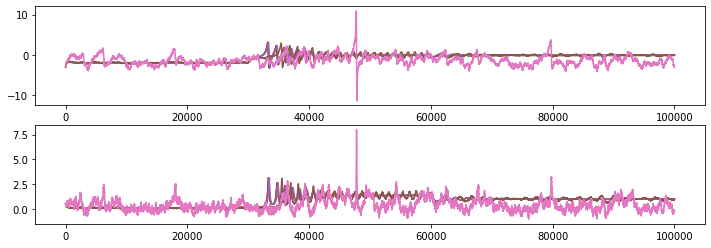

In [10]:
fig, ax = plt.subplots(2, figsize=(12, 4))
X_obs_list = []
data_input_list = []

sigma_list = [10**(-i) for i in range(0, 7)][::-1]
for sigma in sigma_list :
    data_input_filename=str('data_input_mpr_sd'+ '_sigma='+str(sigma))
    data_input_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_input_filename)+ '.R.npz'
    data_input = dict(load(data_input_path))
    v_obs, r_obs = data_input['vs'], data_input['rs']
    ax[0].plot(v_obs)
    ax[1].plot(r_obs)
    
    X_obs = np.vstack((v_obs, r_obs))
    X_obs_list.append(X_obs)    
    data_input_list.append(data_input)
    
    sigma_noise = sigma

# Inference

In [11]:
bounds=[(0.2, 5), (-10, -3), (5,  20), (0, 1)]

In [12]:
global cost_model_list
global X_model_list

In [13]:
i_sig = 5 #index for sigma=0.1

## DE

In [14]:
from scipy.optimize import differential_evolution

In [15]:
def black_box_function(x):
    prms_proposal = [0] * 4
    prms_proposal[0] = x[0]
    prms_proposal[1] = x[1]
    prms_proposal[2] = x[2]
    prms_proposal[3] = x[3]
    
    params_val = prms_proposal
    sim = Montbrio_SDEmodel_numba(params_val, inits, I_input, dt, ts)
    
    X_model = np.vstack((sim[0], sim[1]))
    cost_model = np.sqrt(np.sum((X_model[0, :] - X_obs[0, :])**2))
    
    if cost_model < min(cost_model_list) :
        cost_model_list.append(cost_model)
        X_model_list.append(X_model)
    
    return cost_model

In [16]:
def callback(xk, convergence):
    val.append(convergence)
    cost_val.append(black_box_function(xk))

### Fixed dynamical noise 0.1, to estimate

In [17]:
%%time

sigma_noise = sigma_list[i_sig]
print('sigma=', sigma_noise)
X_obs = X_obs_list[i_sig]
params_true = prms + [sigma_noise]

cost_model_list  = [100000]
X_model_list = [100000]

val=[]
cost_val=[]
max_iter = 500

set_seed(0)
result = differential_evolution(black_box_function, bounds,  popsize=10,  maxiter=max_iter, seed=0,
                                callback=callback)

sigma= 0.1
CPU times: user 2min 20s, sys: 55.9 ms, total: 2min 20s
Wall time: 2min 20s


In [18]:
result.x, result.fun

(array([ 0.42825233, -4.4259861 , 14.17665049,  0.05103034]), 66.1250999961521)

In [19]:
np.sqrt(np.sum((X_model_list[np.argmin(cost_model_list)][0, :] - X_obs[0, :])**2))

66.1250999961521

In [20]:
cost_final = result.fun
params_est = result.x

In [21]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

0.2297175244250077

In [22]:
v_fit, r_fit = X_model_list[np.argmin(cost_model_list)].copy()

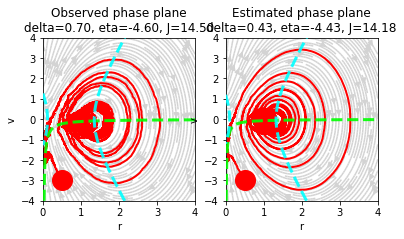

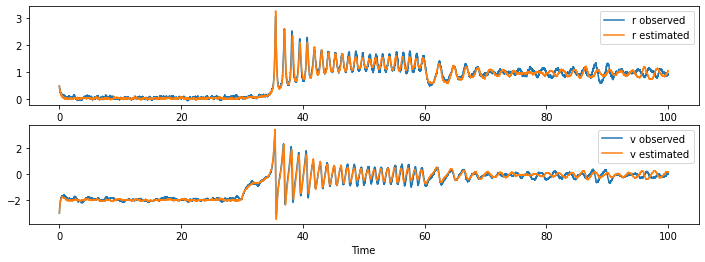

In [23]:
plot_phase_plane(params_true, params_est, X_obs, np.vstack([v_fit, r_fit]))

New simulation with optimal parameters:

In [24]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, dt, ts)

In [25]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

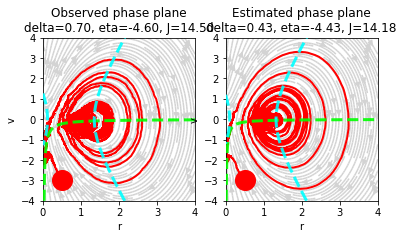

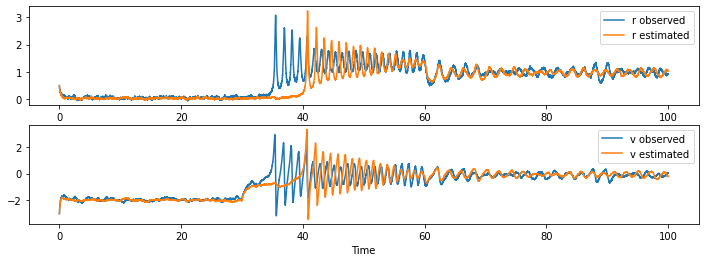

In [26]:
plot_phase_plane(params_true, params_est, X_obs, Sim_est)

In [27]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est),
            'v_fit' : list(v_fit), 'r_fit': list(r_fit),
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'sigma': params_est[3], 
            'rmse_prms': rmse_prms, 'cost': cost_final}

json_object = json.dumps(res_dict, indent=4)
with open("results/v_only_DE_sim_output.json", "w") as outfile:
    outfile.write(json_object)

In [14]:
with open("results/v_only_DE_sim_output.json", "r") as readfile:
    sim = json.load(readfile)

In [20]:
sim['rmse_fit'] = RMSE(np.vstack([sim['v_fit'], sim['r_fit']]), X_obs)

json_object = json.dumps(sim, indent=4)
with open("results/v_only_DE_sim_output.json", "w") as outfile:
    outfile.write(json_object)

### Influence of dynamical noise on rmse-based optimization:

In [17]:
cost_model_list  = [100000]
X_model_list = [100000]

In [ ]:
np.set_printoptions(suppress=True)

cost_end_batch = []
rmse_prms_batch = []

for batch in range(10) :
    cost_end = []
    rmse_prms_list = []
    print(batch)

    #fig, ax  = plt.subplots(nrows=len(sigma_list), figsize=(6, 12))

    for i in range(len(sigma_list)) :

        sigma_noise = sigma_list[i]
        X_obs = X_obs_list[i]
        params_true = prms + [sigma_noise]

        val=[]
        cost_val=[]
        max_iter = 500
        set_seed(0)
        result = differential_evolution(black_box_function, bounds,  popsize=10,  maxiter=max_iter, callback=callback)

        #ax[i].plot(cost_val)
        #ax[i].set(ylabel='Cost', xlabel='Iter', 
        #          title=r'Noise $\sigma=$' + np.format_float_positional(sigma_noise, trim='-'))

        if np.isnan(result.fun) :
            cost_end.append(cost_val[-1])
        else :
            cost_end.append(result.fun)
        rmse_prms_list.append(RMSE(result.x, params_true))

    #fig.tight_layout()
    #plt.show()
    
    cost_end_batch.append(cost_end)
    rmse_prms_batch.append(rmse_prms_list)

0
1
2
3
4
5
6
7
8
9


In [ ]:
np.save("results/v_only_DE_batch_cost_noise.npy", np.array(cost_end_batch))

In [ ]:
np.save("results/v_only_DE_batch_rmse_noise.npy", np.array(rmse_prms_batch))

## PSO

In [ ]:
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [ ]:
n_particles=10

In [ ]:
def black_box_function_pso(x):
    prms_proposal = np.zeros((n_particles, 4))

    prms_proposal[:, 0] = x[:, 0]
    prms_proposal[:, 1] = x[:, 1]
    prms_proposal[:, 2] = x[:, 2]
    prms_proposal[:, 3] = x[:, 3]
    
    
    params_val = prms_proposal
    #sim = np.zeros((n_particles, X_obs.shape[0], X_obs.shape[1]))
    costf = np.zeros(n_particles)
    for i in range(n_particles):
        sim_i = Montbrio_SDEmodel_numba(list(params_val[i, :]), inits, I_input, dt, ts)
        
        X_model_i = sim_i[0], sim_i[1]
        costf[i] = np.sqrt(np.sum((X_model_i[0] - X_obs[0, :])**2))
        
        if costf[i] < min(cost_model_list) :
            cost_model_list.append(costf[i])
            X_model_list.append(X_model_i)
            
    return costf

In [ ]:
lb = np.array(bounds)[:, 0]
ub = np.array(bounds)[:, 1]
(lb, ub)

In [ ]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

#### Fixed dynamical noise = 0.1, to estimate:

In [ ]:
%%time

sigma_noise = sigma_list[i_sig]
print('sigma=', sigma_noise)
X_obs = X_obs_list[i_sig]
params_true = prms + [sigma_noise]

cost_model_list  = [100000]
X_model_list = [100000]

set_seed(0)
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=4, options=options, bounds=(lb, ub))
cost, pos = optimizer.optimize(black_box_function_pso, iters=500)

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(optimizer.cost_history)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
cost_final = cost
params_est = pos
cost

In [ ]:
np.sqrt(np.sum((X_model_list[np.argmin(cost_model_list)][0] - X_obs[0, :])**2))

In [ ]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

In [ ]:
v_fit, r_fit = X_model_list[np.argmin(cost_model_list)]

In [ ]:
plot_phase_plane(params_true, params_est, X_obs, np.vstack([v_fit, r_fit]))

New simulation with optimal parameters:

In [ ]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, dt, ts)

In [ ]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

In [ ]:
plot_phase_plane(params_true, params_est, X_obs, Sim_est)

In [ ]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est),
            'v_fit' : list(v_fit), 'r_fit': list(r_fit),
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'sigma': params_est[3], 
            'rmse_prms': rmse_prms, 'cost': cost_final}

json_object = json.dumps(res_dict, indent=4)
with open("results/v_only_PSO2_sim_output.json", "w") as outfile:
    outfile.write(json_object)

In [21]:
with open("results/v_only_PSO2_sim_output.json", "r") as readfile:
    sim = json.load(readfile)

In [22]:
sim['rmse_fit'] = RMSE(np.vstack([sim['v_fit'], sim['r_fit']]), X_obs)

json_object = json.dumps(sim, indent=4)
with open("results/v_only_PSO2_sim_output.json", "w") as outfile:
    outfile.write(json_object)

### Influence of noise on optimization based on rmse:

In [ ]:
cost_model_list  = [100000]
X_model_list = [100000]

In [ ]:
cost_end_batch = []
rmse_prms_batch = []

for batch in range(10) :
    cost_end = []
    rmse_prms_list = []
    print(batch)

    for i in range(len(sigma_list)) :

        sigma_noise = sigma_list[i]
        X_obs = X_obs_list[i]

        optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=4, options=options, bounds=(lb, ub))
        set_seed(batch)
        cost, pos = optimizer.optimize(black_box_function_pso, iters=500)
        cost_end.append(cost)
        rmse_prms_list.append(RMSE(pos, params_true))
        
    cost_end_batch.append(cost_end)
    rmse_prms_batch.append(rmse_prms_list)

In [ ]:
np.save("results/v_only_PSO2_batch_cost_noise.npy", np.array(cost_end_batch))

In [ ]:
np.save("results/v_only_PSO2_batch_rmse_noise.npy", np.array(rmse_prms_batch))

In [ ]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(cost_end_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(cost_end_batch, 0.025, axis=0), 
                np.quantile(cost_end_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='Cost', xlabel=r'$\sigma$')
ax.semilogx() ;

In [ ]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(rmse_prms_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(rmse_prms_batch, 0.025, axis=0), 
                np.quantile(rmse_prms_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='RMSE parameters', xlabel=r'$\sigma$')
ax.semilogx() ;

## Bayesian Optimization

In [14]:
from matplotlib import gridspec
from bayes_opt import BayesianOptimization #v1.4.0
from bayes_opt import UtilityFunction

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((0, 2))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((0, 2))
    acq.set_ylim((-25, np.max(utility) + 1.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [15]:
def black_box_function_BO(delta, eta, J, sigma):
    prms_proposal = [0] * 4
    prms_proposal[0] = delta
    prms_proposal[1] = eta
    prms_proposal[2] = J
    prms_proposal[3] = sigma
    
    params_val = prms_proposal
    sim = Montbrio_SDEmodel_numba(params_val, inits, I_input, dt, ts)
    
    X_model = np.vstack([sim[0], sim[1]])
    cost_model = np.nan_to_num(-1*np.sqrt(np.sum((X_model - X_obs)**2)), nan=-1000)
    
    if cost_model > max(cost_model_list) :
        cost_model_list.append(cost_model)
        X_model_list.append(X_model)

    return cost_model

In [16]:
pbounds = {'delta': bounds[0], 'eta': bounds[1], 'J': bounds[2], 'sigma': bounds[3]}
pbounds

{'delta': (0.2, 5), 'eta': (-10, -3), 'J': (5, 20), 'sigma': (0, 1)}

#### Fixed dynamical noise = 0.1, to estimate:

In [ ]:
%%time

sigma_noise = sigma_list[i_sig]
print('sigma=', sigma_noise)
X_obs = X_obs_list[i_sig]
params_true = prms + [sigma_noise]

cost_model_list  = [-100000]
X_model_list = [-100000]

set_seed(0)
optimizer = BayesianOptimization(f=black_box_function_BO, pbounds=pbounds, random_state=1)
optimizer.maximize(init_points=50, n_iter=450)

In [ ]:
print(optimizer.max)

In [19]:
np.sqrt(np.sum((X_model_list[np.argmax(cost_model_list)] - X_obs)**2))

186.45571550631615

In [20]:
cost_final = -optimizer.max['target']
params_opt = optimizer.max['params']
params_est = np.array([params_opt[prm] for prm in ['delta', 'eta', 'J', 'sigma']])
params_est

array([ 1.58453032, -5.28257319, 15.09994831,  0.        ])

In [21]:
rmse_prms = RMSE(params_est, params_true)
rmse_prms

0.636049921344923

In [22]:
v_fit, r_fit = X_model_list[np.argmax(cost_model_list)]

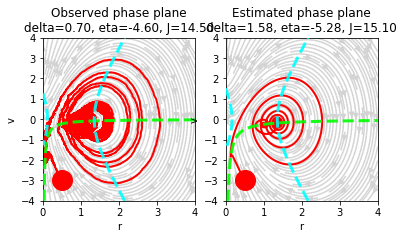

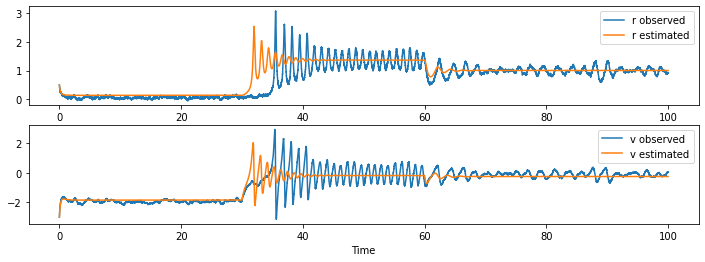

In [23]:
plot_phase_plane(params_true, params_est, X_obs, np.vstack([v_fit, r_fit]))

New simulation with optimal parameters:

In [24]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, dt, ts)

In [25]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

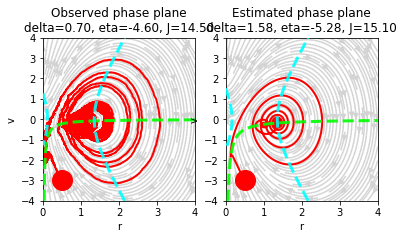

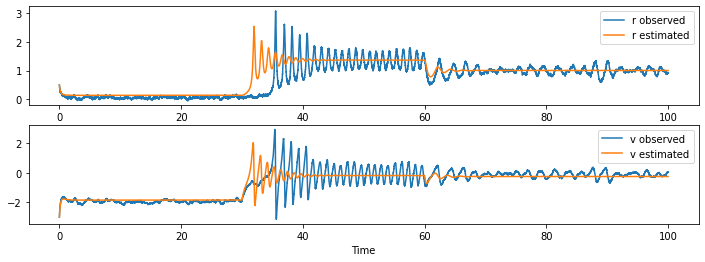

In [26]:
plot_phase_plane(params_true, params_est, X_obs, Sim_est)

In [27]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est),
            'v_fit' : list(v_fit), 'r_fit': list(r_fit),
            'delta': params_est[0], 'eta': params_est[1], 'J': params_est[2],
            'sigma': params_est[3], 
            'rmse_prms': rmse_prms, 'cost': cost_final}

json_object = json.dumps(res_dict, indent=4)
with open("results/v_only_bayesopt_sim_output.json", "w") as outfile:
    outfile.write(json_object)

In [23]:
with open("results/v_only_bayesopt_sim_output.json", "r") as readfile:
    sim = json.load(readfile)

In [24]:
sim['rmse_fit'] = RMSE(np.vstack([sim['v_fit'], sim['r_fit']]), X_obs)

json_object = json.dumps(sim, indent=4)
with open("results/v_only_bayesopt_sim_output.json", "w") as outfile:
    outfile.write(json_object)

### Influence of noise on rmse-based optimization:

In [17]:
cost_end_batch = []
rmse_prms_batch = []

for batch in range(10) :
    print(batch)
    cost_end = []
    rmse_prms_list = []

    for i in range(len(sigma_list)) :

        sigma_noise = sigma_list[i]
        X_obs = X_obs_list[i]
        params_true = prms + [sigma_noise]
        cost_model_list  = [-100000]
        X_model_list = [-100000]
        set_seed(batch)
        optimizer = BayesianOptimization(f=black_box_function_BO, pbounds=pbounds, random_state=batch, 
                                        allow_duplicate_points=True)
        optimizer.maximize(init_points=50, n_iter=450, kappa=100)
        cost_end.append(optimizer.max['target'])
        rmse_prms_list.append(RMSE(np.array([optimizer.max['params'][prm] for prm in ['delta', 'eta', 'J', 'sigma']]),
                                   params_true))
    cost_end_batch.append(cost_end)
    rmse_prms_batch.append(rmse_prms_list)

0
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -379.8    | 13.23     | 3.633     | -5.781    | 0.5449    |
| 2         | -564.3    | 11.35     | 3.3       | -6.937    | 0.8918    |
| 3         | -606.3    | 19.45     | 2.041     | -4.458    | 0.5289    |
| 4         | -596.7    | 13.52     | 4.643     | -9.503    | 0.08713   |
| 5         | -545.9    | 5.303     | 4.197     | -4.553    | 0.87      |
| 6         | -495.1    | 19.68     | 4.036     | -6.77     | 0.7805    |
| 7         | -777.2    | 6.774     | 3.272     | -8.997    | 0.9447    |
| 8         | -670.4    | 12.83     | 2.19      | -8.148    | 0.7742    |
| 9         | -758.0    | 11.84     | 2.928     | -9.868    | 0.6176    |
| 10        | -458.0    | 14.18     | 3.161     | -3.394    | 0.6818    |
| 11        | -416.2    | 10.39     | 2.298     | -5.117    | 0.06023   |
| 12        | -511.4    | 15.0      

| 67        | -317.0    | 10.04     | 3.376     | -3.525    | 0.0       |
| 68        | -313.6    | 11.64     | 3.65      | -4.069    | 0.0       |
| 69        | -325.4    | 10.96     | 4.658     | -3.0      | 0.0       |
| 70        | -338.0    | 14.95     | 4.818     | -5.443    | 0.0       |
| 71        | -329.2    | 12.93     | 4.803     | -4.176    | 0.02966   |
| 72        | -448.8    | 11.12     | 3.644     | -3.0      | 1.0       |
| 73        | -322.3    | 9.551     | 1.875     | -3.0      | 0.0       |
| 74        | -335.7    | 8.624     | 3.519     | -3.235    | 0.1388    |
| 75        | -343.3    | 9.151     | 4.873     | -3.255    | 0.1803    |
| 76        | -404.8    | 11.78     | 4.782     | -4.671    | 0.7707    |
| 77        | -362.9    | 14.85     | 4.784     | -3.871    | 0.01641   |
| 78        | -419.2    | 14.0      | 5.0       | -4.882    | 1.0       |
| 79        | -383.0    | 16.75     | 4.88      | -5.067    | 0.02052   |
| 80        | -443.8    | 5.264     | 

| 135       | -191.3    | 17.93     | 1.931     | -6.228    | 0.0       |
| 136       | -477.7    | 10.93     | 5.0       | -7.026    | 0.0       |
| 137       | -213.3    | 17.53     | 1.221     | -5.138    | 0.0       |
| 138       | -327.4    | 13.9      | 5.0       | -6.23     | 0.0       |
| 139       | -181.5    | 17.82     | 3.362     | -8.344    | 0.0       |
| 140       | -388.9    | 16.31     | 2.328     | -4.741    | 0.0       |
| 141       | -366.6    | 6.516     | 3.789     | -3.0      | 0.0       |
| 142       | -436.5    | 18.34     | 3.716     | -8.952    | 0.0       |
| 143       | -445.8    | 10.16     | 5.0       | -3.84     | 1.0       |
| 144       | -193.6    | 17.48     | 1.907     | -5.767    | 0.0       |
| 145       | -176.0    | 17.69     | 3.238     | -7.95     | 0.0       |
| 146       | -173.0    | 17.58     | 2.393     | -6.845    | 0.01537   |
| 147       | -720.2    | 9.447     | 5.0       | -10.0     | 0.0       |
| 148       | -237.7    | 20.0      | 

| 203       | -627.9    | 10.08     | 0.2       | -5.108    | 1.0       |
| 204       | -160.6    | 17.67     | 1.954     | -6.787    | 0.005886  |
| 205       | -222.3    | 19.34     | 1.658     | -7.276    | 0.04242   |
| 206       | -199.7    | 19.98     | 2.769     | -8.875    | 0.04371   |
| 207       | -409.4    | 15.61     | 2.242     | -6.354    | 0.0       |
| 208       | -318.1    | 16.01     | 2.571     | -5.995    | 0.4564    |
| 209       | -188.1    | 16.0      | 2.597     | -5.852    | 0.0       |
| 210       | -692.2    | 14.18     | 0.2112    | -7.318    | 0.9125    |
| 211       | -441.0    | 14.38     | 5.0       | -6.465    | 1.0       |
| 212       | -355.9    | 14.35     | 2.425     | -4.212    | 0.0       |
| 213       | -320.8    | 13.7      | 4.478     | -5.264    | 0.0       |
| 214       | -617.5    | 20.0      | 3.492     | -3.0      | 1.0       |
| 215       | -494.9    | 11.85     | 3.021     | -4.739    | 1.0       |
| 216       | -325.4    | 11.49     | 

| 271       | -523.4    | 14.61     | 3.639     | -5.647    | 0.9996    |
| 272       | -420.5    | 6.431     | 2.391     | -4.031    | 0.0       |
| 273       | -206.7    | 19.3      | 2.183     | -7.074    | 0.0       |
| 274       | -443.5    | 13.55     | 3.175     | -6.951    | 0.01981   |
| 275       | -439.9    | 11.56     | 5.0       | -3.0      | 1.0       |
| 276       | -440.3    | 12.55     | 5.0       | -7.285    | 0.0       |
| 277       | -359.8    | 13.83     | 3.932     | -3.0      | 0.0       |
| 278       | -315.4    | 9.229     | 2.829     | -3.0      | 0.0       |
| 279       | -200.8    | 20.0      | 2.016     | -8.209    | 0.0       |
| 280       | -161.8    | 16.63     | 1.667     | -5.826    | 0.0       |
| 281       | -331.3    | 10.24     | 4.512     | -3.883    | 0.0       |
| 282       | -340.2    | 13.28     | 2.659     | -3.894    | 0.0       |
| 283       | -497.0    | 14.61     | 5.0       | -3.0      | 1.0       |
| 284       | -457.8    | 15.85     | 

| 339       | -200.9    | 16.46     | 1.172     | -4.776    | 0.0       |
| 340       | -521.1    | 19.64     | 3.171     | -9.972    | 0.04647   |
| 341       | -374.3    | 20.0      | 5.0       | -9.429    | 0.0       |
| 342       | -747.0    | 5.0       | 5.0       | -7.86     | 1.0       |
| 343       | -175.6    | 17.54     | 1.594     | -6.405    | 0.0       |
| 344       | -493.5    | 15.56     | 0.2       | -3.0      | 0.0       |
| 345       | -345.8    | 7.694     | 3.771     | -3.044    | 0.05954   |
| 346       | -155.1    | 16.1      | 1.397     | -5.446    | 0.0       |
| 347       | -317.5    | 17.39     | 4.198     | -7.84     | 0.0       |
| 348       | -524.7    | 6.838     | 5.0       | -5.886    | 0.0       |
| 349       | -207.4    | 16.18     | 1.514     | -5.489    | 0.2528    |
| 350       | -346.6    | 18.49     | 4.948     | -8.635    | 0.009012  |
| 351       | -408.8    | 18.63     | 5.0       | -6.25     | 0.0       |
| 352       | -377.7    | 15.77     | 

| 407       | -157.7    | 16.5      | 2.309     | -6.63     | 0.000875  |
| 408       | -170.5    | 13.74     | 1.163     | -4.237    | 0.0       |
| 409       | -164.9    | 16.74     | 2.711     | -7.223    | 0.006244  |
| 410       | -497.9    | 9.983     | 3.436     | -4.86     | 1.0       |
| 411       | -177.8    | 16.61     | 2.005     | -5.719    | 0.007679  |
| 412       | -288.4    | 20.0      | 3.717     | -9.19     | 0.4499    |
| 413       | -412.2    | 12.33     | 3.925     | -6.446    | 0.0       |
| 414       | -354.3    | 6.816     | 2.768     | -3.0      | 0.0       |
| 415       | -360.4    | 14.35     | 4.527     | -6.941    | 0.0       |
| 416       | -187.4    | 18.91     | 2.297     | -8.113    | 0.0385    |
| 417       | -194.8    | 18.99     | 2.606     | -7.207    | 0.005784  |
| 418       | -165.5    | 16.62     | 2.608     | -6.89     | 0.0       |
| 419       | -215.4    | 13.54     | 0.7575    | -4.021    | 0.0295    |
| 420       | -218.0    | 14.28     | 

| 475       | -760.9    | 12.27     | 0.2       | -8.305    | 1.0       |
| 476       | -484.7    | 17.13     | 4.383     | -4.553    | 1.0       |
| 477       | -559.4    | 14.71     | 0.2       | -3.0      | 1.0       |
| 478       | -483.3    | 20.0      | 4.175     | -4.267    | 0.0       |
| 479       | -454.3    | 17.55     | 2.384     | -3.0      | 0.0       |
| 480       | -399.0    | 5.0       | 3.807     | -3.0      | 0.0       |
| 481       | -510.1    | 5.0       | 5.0       | -3.0      | 1.0       |
| 482       | -843.2    | 20.0      | 0.2       | -10.0     | 1.0       |
| 483       | -472.1    | 16.99     | 5.0       | -7.672    | 1.0       |
| 484       | -191.3    | 17.28     | 0.7866    | -5.189    | 0.0       |
| 485       | -474.8    | 7.177     | 4.044     | -3.5      | 0.9974    |
| 486       | -187.7    | 19.47     | 3.121     | -8.645    | 0.0       |
| 487       | -592.2    | 14.33     | 3.327     | -7.358    | 1.0       |
| 488       | -619.7    | 16.85     | 

| 47        | -500.0    | 19.01     | 3.147     | -6.251    | 0.5899    |
| 48        | -502.0    | 15.95     | 1.697     | -7.212    | 0.2098    |
| 49        | -462.6    | 7.793     | 4.733     | -4.823    | 0.4905    |
| 50        | -802.3    | 8.411     | 1.421     | -9.594    | 0.4344    |
| 51        | -346.9    | 16.56     | 4.379     | -6.629    | 0.1061    |
| 52        | -221.4    | 12.51     | 0.4869    | -3.0      | 0.0       |
| 53        | -330.1    | 11.35     | 2.26      | -3.0      | 0.0       |
| 54        | -352.1    | 17.0      | 3.079     | -6.416    | 0.0       |
| 55        | -186.2    | 17.52     | 3.544     | -7.654    | 0.0       |
| 56        | -440.4    | 12.04     | 0.5066    | -4.249    | 0.1667    |
| 57        | -407.0    | 14.07     | 0.2       | -3.0      | 0.0       |
| 58        | -352.9    | 12.77     | 1.585     | -3.357    | 0.08489   |
| 59        | -410.0    | 16.74     | 3.304     | -7.617    | 0.0       |
| 60        | -482.7    | 17.55     | 

| 115       | -551.4    | 5.0       | 0.2       | -4.664    | 0.0       |
| 116       | -470.3    | 13.75     | 5.0       | -3.0      | 1.0       |
| 117       | -389.9    | 5.0       | 3.002     | -3.0      | 0.0       |
| 118       | -243.5    | 18.57     | 1.001     | -5.619    | 0.0164    |
| 119       | -318.7    | 18.03     | 0.4012    | -5.006    | 0.1679    |
| 120       | -177.9    | 17.78     | 1.623     | -6.4      | 0.0       |
| 121       | -420.2    | 5.0       | 5.0       | -3.0      | 0.0       |
| 122       | -368.1    | 9.044     | 4.011     | -4.271    | 0.00999   |
| 123       | -351.7    | 11.74     | 3.874     | -5.3      | 0.0       |
| 124       | -146.5    | 17.74     | 1.86      | -7.359    | 0.0       |
| 125       | -790.9    | 5.0       | 5.0       | -10.0     | 0.0       |
| 126       | -186.0    | 17.96     | 1.036     | -5.821    | 0.0       |
| 127       | -315.3    | 18.08     | 4.997     | -8.83     | 0.05835   |
| 128       | -337.0    | 12.52     | 

| 183       | -527.4    | 18.73     | 0.2       | -4.599    | 0.0       |
| 184       | -342.6    | 15.65     | 3.923     | -5.809    | 0.0       |
| 185       | -506.9    | 9.354     | 0.9465    | -3.0      | 1.0       |
| 186       | -468.8    | 14.48     | 3.987     | -5.913    | 1.0       |
| 187       | -438.1    | 11.99     | 5.0       | -3.0      | 1.0       |
| 188       | -322.3    | 10.72     | 4.351     | -3.756    | 0.007204  |
| 189       | -320.4    | 9.739     | 4.071     | -3.0      | 0.0       |
| 190       | -162.1    | 17.51     | 1.953     | -6.789    | 0.05211   |
| 191       | -195.8    | 18.28     | 1.419     | -6.421    | 0.02981   |
| 192       | -174.9    | 14.55     | 1.971     | -5.004    | 0.0       |
| 193       | -165.3    | 16.89     | 2.531     | -6.843    | 0.0       |
| 194       | -156.3    | 18.21     | 1.798     | -7.358    | 0.0       |
| 195       | -608.9    | 20.0      | 2.488     | -10.0     | 1.0       |
| 196       | -334.1    | 17.54     | 

| 251       | -176.7    | 17.4      | 3.151     | -7.331    | 0.0       |
| 252       | -835.8    | 18.01     | 0.2       | -10.0     | 1.0       |
| 253       | -154.1    | 13.21     | 0.7609    | -3.815    | 0.0       |
| 254       | -166.1    | 17.73     | 1.744     | -7.03     | 0.0       |
| 255       | -216.7    | 17.99     | 1.754     | -7.887    | 0.02364   |
| 256       | -145.4    | 14.0      | 1.296     | -4.642    | 0.0       |
| 257       | -203.0    | 19.99     | 2.765     | -8.269    | 0.01163   |
| 258       | -556.0    | 11.62     | 5.0       | -8.387    | 0.0       |
| 259       | -434.6    | 20.0      | 5.0       | -6.936    | 0.0       |
| 260       | -758.5    | 14.76     | 2.901     | -10.0     | 1.0       |
| 261       | -434.3    | 18.66     | 5.0       | -10.0     | 0.0       |
| 262       | -342.2    | 11.42     | 5.0       | -4.925    | 0.0       |
| 263       | -163.7    | 15.61     | 2.121     | -5.925    | 0.0       |
| 264       | -166.1    | 17.31     | 

| 319       | -170.8    | 15.11     | 2.175     | -5.574    | 0.0       |
| 320       | -542.4    | 18.74     | 5.0       | -6.192    | 1.0       |
| 321       | -209.3    | 19.27     | 1.329     | -6.744    | 0.0       |
| 322       | -383.7    | 9.214     | 1.435     | -3.739    | 0.0       |
| 323       | -232.1    | 11.25     | 1.334     | -3.0      | 0.0       |
| 324       | -551.7    | 19.41     | 2.22      | -8.653    | 0.6595    |
| 325       | -383.9    | 14.56     | 4.286     | -7.186    | 0.0       |
| 326       | -430.2    | 10.9      | 1.502     | -3.0      | 0.8329    |
| 327       | -682.3    | 8.717     | 0.2       | -6.154    | 1.0       |
| 328       | -315.2    | 9.343     | 3.048     | -3.0      | 0.0       |
| 329       | -554.4    | 18.07     | 5.0       | -10.0     | 1.0       |
| 330       | -164.9    | 15.5      | 1.757     | -5.406    | 0.0       |
| 331       | -400.3    | 19.7      | 3.646     | -7.886    | 0.006687  |
| 332       | -485.1    | 5.0       | 

| 387       | -179.4    | 16.15     | 1.065     | -4.953    | 0.004179  |
| 388       | -179.4    | 18.75     | 2.338     | -7.949    | 0.0       |
| 389       | -407.1    | 17.0      | 4.425     | -8.565    | 0.0       |
| 390       | -163.7    | 16.45     | 1.956     | -6.034    | 0.0       |
| 391       | -368.7    | 12.95     | 2.256     | -5.011    | 0.0       |
| 392       | -214.5    | 19.97     | 1.712     | -7.931    | 0.05682   |
| 393       | -315.3    | 14.15     | 4.015     | -5.631    | 0.0       |
| 394       | -488.0    | 8.893     | 5.0       | -4.439    | 1.0       |
| 395       | -324.3    | 15.04     | 4.851     | -6.294    | 0.01392   |
| 396       | -339.1    | 12.48     | 5.0       | -3.0      | 0.0       |
| 397       | -363.9    | 13.48     | 2.505     | -3.0      | 0.0       |
| 398       | -188.5    | 20.0      | 3.012     | -9.107    | 0.0       |
| 399       | -164.0    | 19.24     | 2.917     | -8.861    | 0.07364   |
| 400       | -203.8    | 16.18     | 

| 455       | -486.6    | 20.0      | 5.0       | -7.79     | 1.0       |
| 456       | -191.0    | 20.0      | 3.073     | -9.695    | 0.0       |
| 457       | -216.4    | 20.0      | 1.673     | -6.85     | 0.0       |
| 458       | -420.4    | 12.79     | 5.0       | -7.123    | 0.0       |
| 459       | -152.7    | 15.56     | 1.261     | -5.236    | 0.02955   |
| 460       | -168.0    | 14.84     | 1.855     | -5.304    | 0.0       |
| 461       | -336.3    | 14.09     | 3.148     | -4.654    | 0.009204  |
| 462       | -159.4    | 15.62     | 1.201     | -4.984    | 0.0       |
| 463       | -427.2    | 5.0       | 3.883     | -3.549    | 0.0       |
| 464       | -515.9    | 11.41     | 1.934     | -6.516    | 0.0       |
| 465       | -169.4    | 15.49     | 2.211     | -5.645    | 0.0       |
| 466       | -191.1    | 18.37     | 1.67      | -6.909    | 0.0       |
| 467       | -315.0    | 19.23     | 3.826     | -8.838    | 0.2382    |
| 468       | -405.8    | 12.13     | 

| 27        | -511.7    | 8.731     | 2.966     | -5.856    | 0.5723    |
| 28        | -626.7    | 8.346     | 4.773     | -6.87     | 0.8464    |
| 29        | -421.5    | 15.49     | 1.628     | -4.303    | 0.3965    |
| 30        | -597.1    | 18.22     | 2.99      | -3.828    | 0.6925    |
| 31        | -460.3    | 15.88     | 2.606     | -3.307    | 0.644     |
| 32        | -727.0    | 11.36     | 3.111     | -9.866    | 0.3016    |
| 33        | -480.0    | 14.9      | 1.592     | -5.674    | 0.4288    |
| 34        | -605.4    | 7.032     | 1.632     | -6.01     | 0.5909    |
| 35        | -342.0    | 13.61     | 3.335     | -5.435    | 0.4314    |
| 36        | -601.2    | 18.45     | 1.964     | -6.949    | 0.8919    |
| 37        | -596.0    | 17.09     | 3.579     | -9.298    | 0.9195    |
| 38        | -551.8    | 15.71     | 4.994     | -8.954    | 0.8681    |
| 39        | -760.6    | 7.437     | 3.155     | -9.133    | 0.848     |
| 40        | -173.1    | 17.11     | 

| 95        | -315.4    | 12.9      | 3.189     | -4.519    | 0.0       |
| 96        | -790.9    | 5.0       | 5.0       | -10.0     | 0.0       |
| 97        | -159.0    | 17.32     | 2.687     | -7.553    | 0.0       |
| 98        | -584.0    | 13.76     | 0.2       | -5.344    | 0.0       |
| 99        | -186.4    | 13.97     | 1.437     | -4.049    | 0.0       |
| 100       | -341.5    | 14.22     | 2.352     | -4.518    | 0.0       |
| 101       | -139.3    | 13.35     | 0.7943    | -3.727    | 0.0       |
| 102       | -373.5    | 13.1      | 1.435     | -4.4      | 0.009979  |
| 103       | -379.6    | 14.07     | 1.459     | -3.215    | 0.0       |
| 104       | -419.5    | 16.84     | 5.0       | -3.0      | 0.0       |
| 105       | -492.3    | 7.002     | 1.736     | -3.0      | 1.0       |
| 106       | -480.3    | 13.1      | 0.3359    | -3.524    | 0.1709    |
| 107       | -387.9    | 11.26     | 0.5624    | -3.0      | 0.0       |
| 108       | -173.8    | 13.95     | 

| 163       | -333.7    | 8.172     | 2.293     | -3.0      | 0.0       |
| 164       | -173.8    | 18.61     | 2.141     | -7.583    | 0.04113   |
| 165       | -216.0    | 13.15     | 0.9984    | -3.106    | 0.005173  |
| 166       | -171.1    | 18.17     | 2.087     | -7.304    | 0.01084   |
| 167       | -830.3    | 11.45     | 0.2232    | -9.81     | 0.2701    |
| 168       | -249.7    | 12.11     | 1.206     | -3.044    | 0.04962   |
| 169       | -321.3    | 10.33     | 4.327     | -3.056    | 0.01348   |
| 170       | -392.0    | 15.48     | 3.931     | -3.071    | 0.0002036 |
| 171       | -380.2    | 9.212     | 3.741     | -4.568    | 0.0       |
| 172       | -183.6    | 18.61     | 2.662     | -7.5      | 0.01555   |
| 173       | -450.3    | 12.26     | 3.388     | -3.0      | 1.0       |
| 174       | -171.2    | 18.22     | 2.302     | -7.77     | 0.008212  |
| 175       | -169.8    | 18.34     | 3.052     | -8.294    | 0.0       |
| 176       | -509.8    | 20.0      | 

| 231       | -422.7    | 15.69     | 1.156     | -3.0      | 0.0       |
| 232       | -320.3    | 9.209     | 3.684     | -3.0      | 0.0       |
| 233       | -362.5    | 8.42      | 1.136     | -3.0      | 0.0       |
| 234       | -378.5    | 15.91     | 5.0       | -4.236    | 0.0       |
| 235       | -402.0    | 15.68     | 2.435     | -6.448    | 0.0       |
| 236       | -1.099e+0 | 15.78     | 0.2       | -3.0      | 1.0       |
| 237       | -189.9    | 19.98     | 3.597     | -9.924    | 0.01185   |
| 238       | -350.2    | 11.68     | 2.437     | -4.532    | 0.0       |
| 239       | -395.5    | 12.87     | 2.705     | -5.74     | 0.0       |
| 240       | -221.1    | 14.14     | 0.7371    | -4.315    | 0.006275  |
| 241       | -349.2    | 14.77     | 1.612     | -4.007    | 0.0       |
| 242       | -177.9    | 16.65     | 2.13      | -5.808    | 0.0       |
| 243       | -523.6    | 10.83     | 5.0       | -5.384    | 1.0       |
| 244       | -329.5    | 14.58     | 

| 299       | -439.3    | 8.984     | 4.974     | -5.468    | 0.03421   |
| 300       | -538.3    | 9.089     | 1.695     | -4.302    | 1.0       |
| 301       | -514.7    | 5.37      | 1.887     | -3.107    | 0.9864    |
| 302       | -201.0    | 17.23     | 1.683     | -5.313    | 0.002564  |
| 303       | -166.7    | 17.27     | 2.644     | -7.139    | 0.0       |
| 304       | -169.8    | 17.58     | 1.879     | -7.006    | 0.0       |
| 305       | -180.3    | 15.14     | 2.022     | -5.032    | 0.0       |
| 306       | -341.6    | 17.54     | 3.369     | -7.085    | 0.0229    |
| 307       | -463.7    | 10.07     | 3.741     | -6.213    | 0.0       |
| 308       | -836.1    | 17.51     | 0.2       | -10.0     | 1.0       |
| 309       | -474.6    | 16.51     | 5.0       | -7.409    | 1.0       |
| 310       | -513.8    | 20.0      | 5.0       | -7.651    | 1.0       |
| 311       | -152.6    | 16.75     | 2.013     | -6.744    | 0.0325    |
| 312       | -440.6    | 13.35     | 

| 367       | -216.7    | 16.39     | 0.7428    | -4.23     | 0.03038   |
| 368       | -322.6    | 12.09     | 2.778     | -3.685    | 0.0       |
| 369       | -367.5    | 15.32     | 2.614     | -4.61     | 0.0       |
| 370       | -395.2    | 5.0       | 1.286     | -3.0      | 0.0       |
| 371       | -435.4    | 5.03      | 3.64      | -3.767    | 0.008897  |
| 372       | -361.0    | 7.188     | 1.791     | -3.053    | 0.01785   |
| 373       | -415.5    | 14.7      | 3.953     | -5.098    | 0.7638    |
| 374       | -563.0    | 19.51     | 5.0       | -5.913    | 1.0       |
| 375       | -543.3    | 20.0      | 0.2       | -4.846    | 0.0       |
| 376       | -181.8    | 19.07     | 2.327     | -7.85     | 0.01409   |
| 377       | -163.8    | 17.88     | 2.817     | -7.868    | 0.02551   |
| 378       | -178.9    | 17.05     | 1.322     | -5.698    | 0.0       |
| 379       | -338.6    | 9.387     | 4.279     | -3.704    | 0.0       |
| 380       | -350.3    | 10.07     | 

| 435       | -224.6    | 15.88     | 3.658     | -6.866    | 0.0       |
| 436       | -368.2    | 15.76     | 4.174     | -7.476    | 0.005955  |
| 437       | -406.8    | 15.16     | 3.41      | -7.118    | 0.0       |
| 438       | -186.7    | 19.53     | 3.707     | -9.588    | 0.0       |
| 439       | -448.3    | 15.95     | 3.568     | -6.903    | 0.708     |
| 440       | -202.3    | 20.0      | 3.053     | -8.389    | 0.0       |
| 441       | -387.1    | 15.37     | 5.0       | -3.0      | 0.0       |
| 442       | -143.8    | 13.66     | 0.7747    | -3.929    | 0.0       |
| 443       | -174.0    | 16.75     | 2.965     | -7.002    | 0.006945  |
| 444       | -538.4    | 5.001     | 3.217     | -5.459    | 0.03578   |
| 445       | -345.1    | 13.63     | 5.0       | -3.7      | 0.0       |
| 446       | -187.1    | 18.55     | 1.885     | -7.313    | 0.0       |
| 447       | -803.7    | 20.0      | 2.042     | -3.0      | 1.0       |
| 448       | -719.8    | 11.85     | 

| 13        | -571.2    | 9.731     | 1.946     | -6.009    | 0.4386    |
| 14        | -719.5    | 19.83     | 0.6898    | -8.538    | 0.1613    |
| 15        | -503.0    | 14.8      | 1.416     | -6.736    | 0.2444    |
| 16        | -570.6    | 7.385     | 0.7298    | -5.406    | 0.1382    |
| 17        | -414.6    | 7.949     | 1.97      | -4.253    | 0.0971    |
| 18        | -591.2    | 17.57     | 0.6613    | -3.165    | 0.4687    |
| 19        | -471.3    | 19.65     | 3.103     | -4.825    | 0.03919   |
| 20        | -713.9    | 9.242     | 0.7769    | -7.927    | 0.1187    |
| 21        | -781.1    | 9.77      | 2.188     | -9.551    | 0.6925    |
| 22        | -479.7    | 13.5      | 1.474     | -6.337    | 0.09394   |
| 23        | -503.0    | 13.64     | 4.661     | -7.77     | 0.6674    |
| 24        | -664.0    | 6.977     | 3.638     | -7.974    | 0.1832    |
| 25        | -263.4    | 13.8      | 0.2965    | -4.197    | 0.004695  |
| 26        | -561.9    | 15.17     | 

| 81        | -438.4    | 9.983     | 4.229     | -3.758    | 0.9258    |
| 82        | -305.3    | 12.75     | 2.722     | -4.504    | 0.0       |
| 83        | -375.3    | 13.39     | 1.344     | -4.511    | 0.0       |
| 84        | -454.5    | 12.75     | 3.484     | -4.466    | 1.0       |
| 85        | -338.2    | 9.308     | 2.399     | -3.014    | 0.2733    |
| 86        | -328.0    | 8.41      | 3.461     | -3.0      | 0.0       |
| 87        | -352.0    | 11.57     | 4.192     | -5.109    | 0.1731    |
| 88        | -165.2    | 17.94     | 2.138     | -7.35     | 0.01384   |
| 89        | -464.6    | 7.845     | 2.628     | -3.0      | 1.0       |
| 90        | -573.3    | 14.05     | 0.2       | -5.18     | 0.0       |
| 91        | -337.4    | 8.972     | 4.847     | -3.0      | 0.0       |
| 92        | -351.8    | 11.72     | 2.239     | -4.415    | 0.0       |
| 93        | -375.1    | 14.73     | 0.2       | -3.586    | 0.0       |
| 94        | -355.4    | 13.93     | 

| 149       | -385.1    | 12.21     | 2.887     | -5.506    | 0.0       |
| 150       | -359.3    | 9.906     | 2.014     | -3.897    | 0.0       |
| 151       | -393.7    | 7.227     | 3.374     | -3.931    | 0.0       |
| 152       | -720.3    | 9.438     | 5.0       | -10.0     | 0.0       |
| 153       | -320.9    | 11.07     | 3.376     | -3.0      | 0.0       |
| 154       | -161.7    | 17.85     | 2.584     | -7.463    | 0.06165   |
| 155       | -511.7    | 5.0       | 3.247     | -3.0      | 1.0       |
| 156       | -340.8    | 14.16     | 2.419     | -4.522    | 0.0       |
| 157       | -314.8    | 17.3      | 3.099     | -6.855    | 0.08083   |
| 158       | -346.2    | 15.78     | 4.214     | -5.816    | 0.01425   |
| 159       | -344.4    | 17.58     | 5.0       | -7.832    | 0.0       |
| 160       | -157.2    | 17.54     | 2.25      | -7.405    | 0.02424   |
| 161       | -443.3    | 5.873     | 2.092     | -4.181    | 0.0       |
| 162       | -455.5    | 16.65     | 

| 217       | -154.3    | 17.04     | 1.79      | -6.306    | 0.0       |
| 218       | -436.0    | 6.518     | 5.0       | -4.146    | 0.0       |
| 219       | -553.7    | 18.73     | 5.0       | -5.423    | 1.0       |
| 220       | -502.7    | 6.158     | 1.917     | -3.0      | 1.0       |
| 221       | -390.0    | 14.71     | 4.064     | -7.194    | 0.0       |
| 222       | -184.6    | 19.62     | 2.512     | -8.24     | 0.009495  |
| 223       | -188.8    | 19.75     | 2.374     | -9.08     | 0.004356  |
| 224       | -685.9    | 19.78     | 2.311     | -9.954    | 0.9998    |
| 225       | -181.1    | 19.42     | 2.896     | -9.154    | 0.05523   |
| 226       | -225.1    | 11.41     | 1.064     | -3.0      | 0.0       |
| 227       | -185.5    | 19.47     | 2.933     | -8.676    | 0.0961    |
| 228       | -180.3    | 19.14     | 3.126     | -8.62     | 0.004826  |
| 229       | -334.0    | 13.49     | 3.386     | -4.202    | 0.0       |
| 230       | -170.9    | 14.83     | 

| 285       | -184.2    | 18.01     | 2.278     | -6.678    | 0.0       |
| 286       | -173.9    | 16.15     | 1.603     | -5.368    | 0.01867   |
| 287       | -171.6    | 15.51     | 1.561     | -5.098    | 0.001617  |
| 288       | -591.2    | 9.698     | 0.2       | -5.39     | 0.0       |
| 289       | -415.4    | 18.2      | 2.591     | -5.686    | 0.0       |
| 290       | -501.1    | 11.15     | 2.907     | -4.94     | 1.0       |
| 291       | -189.7    | 20.0      | 2.287     | -8.551    | 0.0       |
| 292       | -321.7    | 11.98     | 2.842     | -3.641    | 0.0       |
| 293       | -846.2    | 5.0       | 2.502     | -10.0     | 1.0       |
| 294       | -366.2    | 8.322     | 4.198     | -3.835    | 0.0       |
| 295       | -146.4    | 16.05     | 1.859     | -6.075    | 0.04484   |
| 296       | -356.3    | 13.64     | 3.972     | -3.0      | 0.0       |
| 297       | -343.3    | 15.26     | 2.637     | -5.23     | 0.0       |
| 298       | -171.6    | 15.69     | 

| 353       | -446.7    | 17.11     | 1.683     | -7.057    | 0.5242    |
| 354       | -519.7    | 15.07     | 5.0       | -7.37     | 1.0       |
| 355       | -483.2    | 7.058     | 3.662     | -3.541    | 0.9789    |
| 356       | -599.6    | 9.544     | 3.556     | -7.711    | 0.0       |
| 357       | -675.7    | 8.554     | 0.2       | -6.327    | 1.0       |
| 358       | -383.6    | 16.53     | 4.464     | -8.164    | 0.005435  |
| 359       | -258.9    | 15.89     | 3.96      | -7.101    | 0.0       |
| 360       | -334.6    | 12.99     | 5.0       | -3.867    | 0.0       |
| 361       | -228.1    | 17.75     | 1.046     | -5.208    | 0.0574    |
| 362       | -325.7    | 13.14     | 4.982     | -5.53     | 0.01259   |
| 363       | -187.3    | 16.43     | 3.269     | -6.931    | 0.01255   |
| 364       | -526.2    | 15.06     | 0.9021    | -3.015    | 0.9684    |
| 365       | -195.2    | 19.92     | 3.58      | -9.979    | 0.01814   |
| 366       | -510.0    | 5.0       | 

| 421       | -155.1    | 16.32     | 1.512     | -5.783    | 0.004017  |
| 422       | -465.4    | 9.514     | 5.0       | -6.161    | 0.0       |
| 423       | -618.0    | 17.1      | 2.471     | -3.0      | 1.0       |
| 424       | -337.3    | 18.35     | 1.552     | -6.031    | 0.3601    |
| 425       | -490.9    | 5.0       | 5.0       | -4.474    | 0.0       |
| 426       | -369.1    | 11.24     | 5.0       | -5.456    | 0.0       |
| 427       | -455.1    | 6.255     | 3.463     | -4.584    | 0.006036  |
| 428       | -479.9    | 14.27     | 3.536     | -5.03     | 1.0       |
| 429       | -184.2    | 18.36     | 3.677     | -8.467    | 0.0       |
| 430       | -338.8    | 10.16     | 2.907     | -4.08     | 0.0       |
| 431       | -454.5    | 11.27     | 4.193     | -4.096    | 1.0       |
| 432       | -330.3    | 11.72     | 3.17      | -4.71     | 0.0       |
| 433       | -194.9    | 20.0      | 3.699     | -9.531    | 0.0       |
| 434       | -483.9    | 16.23     | 

| 489       | -523.0    | 12.98     | 0.2       | -4.408    | 0.0       |
| 490       | -176.9    | 16.62     | 3.001     | -6.934    | 0.04429   |
| 491       | -418.7    | 18.98     | 5.0       | -6.244    | 0.0       |
| 492       | -174.6    | 17.86     | 3.142     | -7.806    | 0.0       |
| 493       | -322.1    | 13.79     | 3.546     | -4.958    | 0.0       |
| 494       | -178.2    | 14.01     | 0.6826    | -3.661    | 0.01033   |
| 495       | -160.1    | 17.39     | 1.296     | -6.44     | 0.01178   |
| 496       | -152.5    | 13.7      | 0.7155    | -3.693    | 0.01202   |
| 497       | -189.8    | 17.85     | 1.316     | -6.583    | 0.0       |
| 498       | -145.7    | 15.94     | 1.646     | -5.802    | 0.0       |
| 499       | -152.2    | 13.67     | 0.8566    | -3.903    | 0.01444   |
| 500       | -182.4    | 19.09     | 2.849     | -8.855    | 0.0       |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
--------------------------------------

| 55        | -245.9    | 13.98     | 0.7262    | -3.0      | 0.0       |
| 56        | -201.9    | 12.97     | 1.887     | -4.134    | 0.01084   |
| 57        | -528.3    | 12.82     | 1.418     | -3.0      | 0.7535    |
| 58        | -312.6    | 12.28     | 3.323     | -4.318    | 0.0       |
| 59        | -318.6    | 9.445     | 3.67      | -3.0      | 0.0       |
| 60        | -197.9    | 17.6      | 3.536     | -7.477    | 0.0       |
| 61        | -338.0    | 13.61     | 2.078     | -4.138    | 0.04568   |
| 62        | -328.9    | 10.97     | 5.0       | -3.0      | 0.0       |
| 63        | -341.2    | 14.02     | 5.0       | -4.39     | 0.0       |
| 64        | -367.6    | 12.05     | 2.037     | -4.52     | 0.09423   |
| 65        | -194.9    | 16.79     | 3.399     | -7.387    | 0.1279    |
| 66        | -367.5    | 12.87     | 4.971     | -3.087    | 0.4115    |
| 67        | -427.1    | 10.23     | 3.836     | -3.901    | 0.8575    |
| 68        | -389.1    | 17.03     | 

| 123       | -509.0    | 5.0       | 5.0       | -3.0      | 1.0       |
| 124       | -331.1    | 12.76     | 2.601     | -3.886    | 0.0       |
| 125       | -318.5    | 13.27     | 4.094     | -4.921    | 0.0       |
| 126       | -343.4    | 11.27     | 3.764     | -4.901    | 0.0       |
| 127       | -218.5    | 11.59     | 0.7185    | -3.004    | 0.07429   |
| 128       | -318.7    | 10.68     | 3.681     | -3.0      | 0.0       |
| 129       | -637.6    | 11.33     | 0.2       | -3.0      | 1.0       |
| 130       | -231.6    | 11.01     | 1.355     | -3.0      | 0.0       |
| 131       | -602.0    | 5.0       | 5.0       | -6.476    | 0.0       |
| 132       | -407.1    | 20.0      | 5.0       | -8.297    | 0.0       |
| 133       | -164.6    | 16.64     | 1.975     | -6.117    | 0.07827   |
| 134       | -164.6    | 16.57     | 2.261     | -6.436    | 0.0       |
| 135       | -175.3    | 16.71     | 2.979     | -7.147    | 0.0       |
| 136       | -765.7    | 9.629     | 

| 191       | -167.1    | 16.41     | 1.92      | -5.959    | 0.0       |
| 192       | -484.0    | 16.57     | 5.0       | -7.142    | 1.0       |
| 193       | -192.0    | 19.29     | 2.339     | -7.688    | 0.002549  |
| 194       | -223.3    | 18.98     | 1.31      | -6.354    | 0.0       |
| 195       | -605.1    | 19.94     | 0.2955    | -6.114    | 0.2055    |
| 196       | -184.5    | 18.75     | 2.912     | -7.699    | 0.0       |
| 197       | -189.9    | 13.58     | 1.184     | -4.046    | 0.0       |
| 198       | -517.8    | 11.2      | 5.0       | -7.708    | 0.0       |
| 199       | -175.3    | 16.73     | 1.853     | -5.859    | 0.0       |
| 200       | -215.3    | 11.73     | 1.179     | -3.0      | 0.0       |
| 201       | -450.7    | 12.26     | 3.802     | -3.0      | 1.0       |
| 202       | -200.9    | 16.53     | 1.317     | -4.866    | 0.0       |
| 203       | -198.0    | 18.96     | 1.79      | -6.748    | 0.0       |
| 204       | -397.7    | 16.4      | 

| 259       | -493.1    | 16.63     | 3.79      | -7.421    | 0.9754    |
| 260       | -716.7    | 13.93     | 0.2       | -7.655    | 0.0       |
| 261       | -453.9    | 6.403     | 5.0       | -4.437    | 0.0       |
| 262       | -437.1    | 20.0      | 3.151     | -6.994    | 0.0       |
| 263       | -624.6    | 18.39     | 1.293     | -5.349    | 0.8648    |
| 264       | -501.5    | 17.07     | 1.668     | -7.425    | 0.003759  |
| 265       | -510.2    | 17.8      | 2.055     | -8.133    | 0.1375    |
| 266       | -364.2    | 11.45     | 1.327     | -3.69     | 0.0       |
| 267       | -374.4    | 16.12     | 4.054     | -4.862    | 0.0       |
| 268       | -584.9    | 20.0      | 1.944     | -7.292    | 1.0       |
| 269       | -376.6    | 9.197     | 2.287     | -4.115    | 0.0       |
| 270       | -315.2    | 10.35     | 2.083     | -3.0      | 0.0       |
| 271       | -496.4    | 12.99     | 5.0       | -5.913    | 1.0       |
| 272       | -503.5    | 13.08     | 

| 327       | -490.5    | 9.33      | 2.691     | -4.362    | 0.963     |
| 328       | -475.8    | 20.0      | 5.0       | -7.776    | 1.0       |
| 329       | -344.0    | 12.72     | 3.322     | -3.0      | 0.0       |
| 330       | -328.2    | 12.77     | 5.0       | -5.328    | 0.0       |
| 331       | -560.1    | 14.09     | 2.59      | -6.174    | 1.0       |
| 332       | -317.7    | 12.14     | 4.173     | -4.389    | 0.0       |
| 333       | -372.2    | 7.809     | 3.232     | -3.775    | 0.0       |
| 334       | -331.6    | 9.813     | 4.082     | -3.793    | 0.0       |
| 335       | -433.5    | 13.64     | 5.0       | -3.0      | 1.0       |
| 336       | -187.1    | 19.13     | 2.898     | -8.179    | 0.0       |
| 337       | -350.2    | 9.142     | 1.282     | -3.0      | 0.0       |
| 338       | -185.4    | 19.1      | 3.455     | -8.831    | 0.0       |
| 339       | -467.2    | 18.55     | 3.631     | -9.229    | 0.09217   |
| 340       | -194.9    | 19.94     | 

| 395       | -186.3    | 14.89     | 2.159     | -5.011    | 0.03784   |
| 396       | -410.2    | 14.23     | 1.528     | -5.329    | 0.04272   |
| 397       | -278.4    | 14.54     | 1.24      | -4.828    | 0.2223    |
| 398       | -325.3    | 9.941     | 4.501     | -3.006    | 0.03447   |
| 399       | -183.3    | 14.79     | 1.729     | -4.623    | 0.03214   |
| 400       | -589.0    | 12.18     | 5.0       | -7.455    | 1.0       |
| 401       | -350.1    | 15.61     | 1.943     | -4.677    | 0.01841   |
| 402       | -177.0    | 14.26     | 1.729     | -4.526    | 0.0194    |
| 403       | -161.1    | 14.07     | 1.131     | -4.446    | 0.0       |
| 404       | -412.8    | 9.212     | 1.061     | -4.041    | 0.0       |
| 405       | -346.1    | 11.14     | 5.0       | -4.848    | 0.0       |
| 406       | -173.4    | 17.25     | 2.739     | -6.826    | 0.007153  |
| 407       | -165.8    | 14.58     | 1.444     | -4.939    | 0.0       |
| 408       | -459.7    | 14.87     | 

| 463       | -186.9    | 15.8      | 0.923     | -4.914    | 0.0       |
| 464       | -366.8    | 13.69     | 2.555     | -3.051    | 7.524e-05 |
| 465       | -186.4    | 18.21     | 3.483     | -7.821    | 0.02777   |
| 466       | -134.4    | 14.65     | 1.316     | -5.145    | 0.007994  |
| 467       | -324.6    | 14.55     | 5.0       | -6.064    | 0.0       |
| 468       | -211.6    | 17.91     | 4.34      | -8.548    | 0.0       |
| 469       | -439.5    | 17.08     | 4.377     | -8.926    | 0.0193    |
| 470       | -351.1    | 18.27     | 5.0       | -8.323    | 0.0       |
| 471       | -640.6    | 8.811     | 0.2       | -6.209    | 0.0       |
| 472       | -168.0    | 17.46     | 2.048     | -7.363    | 0.04399   |
| 473       | -182.7    | 18.66     | 2.135     | -7.207    | 0.0       |
| 474       | -180.4    | 18.67     | 3.121     | -8.237    | 0.01303   |
| 475       | -176.4    | 14.23     | 1.4       | -4.541    | 0.0       |
| 476       | -328.4    | 12.09     | 

| 30        | -617.0    | 18.22     | 2.99      | -3.828    | 0.6925    |
| 31        | -476.9    | 15.88     | 2.606     | -3.307    | 0.644     |
| 32        | -725.2    | 11.36     | 3.111     | -9.866    | 0.3016    |
| 33        | -496.4    | 14.9      | 1.592     | -5.674    | 0.4288    |
| 34        | -602.3    | 7.032     | 1.632     | -6.01     | 0.5909    |
| 35        | -350.1    | 13.61     | 3.335     | -5.435    | 0.4314    |
| 36        | -610.5    | 18.45     | 1.964     | -6.949    | 0.8919    |
| 37        | -590.9    | 17.09     | 3.579     | -9.298    | 0.9195    |
| 38        | -552.7    | 15.71     | 4.994     | -8.954    | 0.8681    |
| 39        | -758.3    | 7.437     | 3.155     | -9.133    | 0.848     |
| 40        | -205.2    | 17.11     | 2.932     | -7.15     | 0.06917   |
| 41        | -487.1    | 15.46     | 2.377     | -4.946    | 0.8664    |
| 42        | -480.8    | 19.63     | 4.308     | -9.918    | 0.36      |
| 43        | -513.3    | 15.95     | 

| 98        | -514.7    | 20.0      | 5.0       | -3.0      | 0.0       |
| 99        | -385.6    | 14.56     | 5.0       | -3.0      | 0.0       |
| 100       | -835.2    | 5.0       | 0.2       | -10.0     | 0.0       |
| 101       | -381.4    | 17.89     | 5.0       | -7.344    | 0.0       |
| 102       | -868.8    | 15.3      | 0.2       | -10.0     | 1.0       |
| 103       | -413.8    | 5.03      | 3.038     | -3.075    | 0.3431    |
| 104       | -210.4    | 14.26     | 0.8358    | -4.276    | 0.0       |
| 105       | -421.7    | 16.24     | 4.89      | -3.043    | 0.06523   |
| 106       | -423.2    | 5.0       | 5.0       | -3.0      | 0.0       |
| 107       | -421.1    | 11.57     | 5.0       | -6.428    | 0.0       |
| 108       | -592.1    | 14.41     | 0.2       | -5.537    | 0.0       |
| 109       | -379.8    | 14.42     | 3.391     | -6.389    | 0.0       |
| 110       | -343.0    | 11.31     | 5.0       | -4.476    | 0.0       |
| 111       | -330.9    | 13.44     | 

| 166       | -479.8    | 10.31     | 1.842     | -3.0      | 1.0       |
| 167       | -544.7    | 15.2      | 5.0       | -3.0      | 1.0       |
| 168       | -201.5    | 16.22     | 1.411     | -5.354    | 0.00787   |
| 169       | -202.9    | 15.09     | 1.019     | -4.804    | 0.0       |
| 170       | -222.7    | 16.66     | 1.394     | -5.118    | 0.0       |
| 171       | -831.6    | 11.82     | 0.2       | -10.0     | 0.0       |
| 172       | -410.3    | 14.7      | 1.869     | -3.0      | 0.0       |
| 173       | -187.6    | 14.14     | 1.105     | -4.548    | 0.001089  |
| 174       | -196.5    | 16.78     | 2.734     | -7.196    | 0.0       |
| 175       | -462.4    | 14.47     | 5.0       | -6.359    | 1.0       |
| 176       | -198.6    | 16.17     | 1.954     | -5.79     | 0.0       |
| 177       | -192.0    | 16.3      | 2.28      | -6.457    | 0.05721   |
| 178       | -197.9    | 15.6      | 1.424     | -5.117    | 0.0       |
| 179       | -216.7    | 15.77     | 

| 234       | -220.7    | 15.63     | 0.9303    | -4.603    | 0.0       |
| 235       | -213.2    | 16.87     | 2.124     | -5.865    | 0.03757   |
| 236       | -371.3    | 8.391     | 4.328     | -3.823    | 0.0       |
| 237       | -453.4    | 17.63     | 1.799     | -4.236    | 0.0       |
| 238       | -532.6    | 17.24     | 4.795     | -4.144    | 0.9481    |
| 239       | -192.6    | 16.8      | 2.029     | -6.425    | 0.02307   |
| 240       | -343.9    | 12.92     | 5.0       | -4.114    | 0.0       |
| 241       | -191.4    | 16.5      | 2.213     | -6.469    | 0.0       |
| 242       | -649.5    | 11.31     | 5.0       | -8.099    | 1.0       |
| 243       | -371.8    | 13.71     | 4.042     | -6.422    | 0.0       |
| 244       | -187.8    | 17.01     | 1.917     | -7.141    | 0.0       |
| 245       | -669.9    | 11.53     | 0.2       | -6.83     | 0.0       |
| 246       | -389.5    | 14.87     | 5.0       | -7.652    | 0.0       |
| 247       | -828.2    | 18.08     | 

| 302       | -476.2    | 10.04     | 5.0       | -6.539    | 0.0       |
| 303       | -502.6    | 9.373     | 5.0       | -4.652    | 1.0       |
| 304       | -605.7    | 18.89     | 1.574     | -8.027    | 0.0       |
| 305       | -513.2    | 18.66     | 2.446     | -8.323    | 0.3007    |
| 306       | -516.1    | 11.6      | 2.36      | -4.789    | 1.0       |
| 307       | -202.3    | 18.08     | 1.759     | -7.344    | 0.1101    |
| 308       | -846.2    | 5.0       | 2.467     | -10.0     | 1.0       |
| 309       | -250.7    | 20.0      | 1.978     | -7.769    | 0.09137   |
| 310       | -728.5    | 13.89     | 0.2       | -7.95     | 0.0       |
| 311       | -602.1    | 16.07     | 0.2       | -4.458    | 1.0       |
| 312       | -437.2    | 16.64     | 3.59      | -3.0      | 0.0       |
| 313       | -200.9    | 18.23     | 2.024     | -7.671    | 0.0       |
| 314       | -218.6    | 18.28     | 1.647     | -6.938    | 0.02152   |
| 315       | -724.4    | 6.975     | 

| 370       | -211.6    | 18.26     | 2.888     | -7.462    | 0.0       |
| 371       | -357.4    | 8.497     | 2.69      | -3.567    | 0.0       |
| 372       | -362.6    | 13.82     | 5.0       | -3.648    | 0.0       |
| 373       | -327.6    | 11.34     | 3.922     | -4.144    | 0.0       |
| 374       | -226.2    | 20.0      | 2.873     | -8.988    | 0.0       |
| 375       | -462.1    | 18.75     | 5.0       | -4.269    | 0.0       |
| 376       | -230.9    | 15.62     | 2.309     | -5.301    | 0.0       |
| 377       | -196.3    | 12.53     | 0.797     | -3.407    | 0.0       |
| 378       | -222.1    | 17.68     | 1.779     | -5.958    | 0.0       |
| 379       | -327.2    | 9.127     | 3.235     | -3.0      | 0.0       |
| 380       | -242.5    | 19.26     | 1.617     | -6.981    | 0.0       |
| 381       | -197.9    | 14.23     | 1.934     | -5.065    | 0.01629   |
| 382       | -456.4    | 12.6      | 3.466     | -4.79     | 1.0       |
| 383       | -268.4    | 19.51     | 

| 438       | -338.6    | 8.881     | 4.251     | -3.0      | 0.0       |
| 439       | -203.0    | 18.47     | 2.174     | -8.06     | 0.0       |
| 440       | -226.5    | 19.75     | 2.982     | -8.562    | 0.0       |
| 441       | -306.2    | 19.35     | 1.052     | -5.17     | 0.01179   |
| 442       | -334.7    | 15.03     | 1.409     | -3.825    | 0.0       |
| 443       | -354.9    | 9.587     | 4.1       | -4.115    | 0.0       |
| 444       | -359.3    | 16.51     | 4.126     | -7.678    | 0.0       |
| 445       | -348.5    | 19.1      | 4.08      | -9.106    | 0.4095    |
| 446       | -473.8    | 16.39     | 4.029     | -5.474    | 1.0       |
| 447       | -219.2    | 14.02     | 0.7736    | -3.791    | 0.0       |
| 448       | -477.8    | 20.0      | 3.994     | -5.642    | 0.0       |
| 449       | -564.0    | 9.748     | 0.2       | -3.0      | 1.0       |
| 450       | -371.3    | 14.02     | 5.0       | -6.961    | 0.0       |
| 451       | -347.1    | 12.98     | 

| 24        | -555.6    | 6.977     | 3.638     | -7.974    | 0.1832    |
| 25        | -579.8    | 13.8      | 0.2965    | -4.197    | 0.004695  |
| 26        | -626.3    | 15.17     | 1.496     | -4.854    | 0.9622    |
| 27        | -474.4    | 8.731     | 2.966     | -5.856    | 0.5723    |
| 28        | -552.8    | 8.346     | 4.773     | -6.87     | 0.8464    |
| 29        | -642.5    | 15.49     | 1.628     | -4.303    | 0.3965    |
| 30        | -787.4    | 18.22     | 2.99      | -3.828    | 0.6925    |
| 31        | -670.9    | 15.88     | 2.606     | -3.307    | 0.644     |
| 32        | -604.2    | 11.36     | 3.111     | -9.866    | 0.3016    |
| 33        | -499.6    | 14.9      | 1.592     | -5.674    | 0.4288    |
| 34        | -507.5    | 7.032     | 1.632     | -6.01     | 0.5909    |
| 35        | -471.3    | 13.61     | 3.335     | -5.435    | 0.4314    |
| 36        | -634.2    | 18.45     | 1.964     | -6.949    | 0.8919    |
| 37        | -545.0    | 17.09     | 

| 92        | -438.3    | 9.645     | 5.0       | -4.236    | 0.0       |
| 93        | -452.5    | 12.23     | 2.439     | -5.93     | 0.0       |
| 94        | -434.5    | 10.76     | 3.674     | -4.835    | 0.0       |
| 95        | -429.7    | 5.0       | 4.094     | -3.0      | 0.0       |
| 96        | -432.8    | 6.552     | 3.776     | -4.233    | 0.002153  |
| 97        | -435.3    | 7.294     | 4.176     | -3.0      | 0.0       |
| 98        | -430.7    | 8.211     | 3.463     | -3.808    | 0.0       |
| 99        | -430.6    | 5.068     | 2.572     | -3.553    | 0.0725    |
| 100       | -433.1    | 11.49     | 4.373     | -5.645    | 0.0       |
| 101       | -432.5    | 9.488     | 4.128     | -5.273    | 0.0       |
| 102       | -429.1    | 6.052     | 3.034     | -3.155    | 0.02983   |
| 103       | -439.2    | 12.76     | 4.396     | -5.941    | 0.0       |
| 104       | -428.4    | 5.0       | 2.767     | -3.0      | 0.0       |
| 105       | -433.5    | 9.21      | 

| 159       | -430.4    | 5.554     | 2.393     | -3.477    | 0.0       |
| 160       | -428.2    | 5.418     | 3.335     | -3.288    | 0.0       |
| 161       | -433.0    | 5.705     | 3.686     | -3.186    | 0.1894    |
| 162       | -429.8    | 8.516     | 3.928     | -4.185    | 0.0       |
| 163       | -428.3    | 5.2       | 3.621     | -3.0      | 0.0       |
| 164       | -429.1    | 6.312     | 3.857     | -3.628    | 0.0       |
| 165       | -430.5    | 6.283     | 4.267     | -3.036    | 0.0       |
| 166       | -428.7    | 7.793     | 3.458     | -4.088    | 0.0       |
| 167       | -428.7    | 7.451     | 3.132     | -3.863    | 0.0       |
| 168       | -433.8    | 12.06     | 4.214     | -6.012    | 0.0       |
| 169       | -428.7    | 5.637     | 3.024     | -3.0      | 0.0       |
| 170       | -428.2    | 6.198     | 3.447     | -3.345    | 0.0       |
| 171       | -428.9    | 5.998     | 3.949     | -3.263    | 0.0       |
| 172       | -428.1    | 5.884     | 

| 227       | -428.0    | 5.094     | 3.188     | -3.0      | 0.0       |
| 228       | -428.0    | 5.0       | 3.093     | -3.0      | 0.0       |
| 229       | -428.8    | 7.203     | 3.817     | -3.726    | 0.0       |
| 230       | -428.0    | 5.269     | 3.207     | -3.084    | 0.0       |
| 231       | -428.1    | 5.612     | 3.068     | -3.296    | 0.0       |
| 232       | -428.4    | 7.22      | 3.371     | -3.839    | 0.0       |
| 233       | -431.0    | 9.62      | 3.463     | -4.511    | 0.0       |
| 234       | -428.9    | 7.981     | 3.716     | -4.046    | 0.0       |
| 235       | -428.0    | 5.0       | 3.216     | -3.0      | 0.0       |
| 236       | -429.0    | 7.751     | 3.7       | -4.204    | 0.0       |
| 237       | -428.0    | 5.0       | 3.289     | -3.0      | 0.0       |
| 238       | -428.0    | 5.124     | 3.376     | -3.0      | 0.0       |
| 239       | -428.2    | 6.547     | 3.357     | -3.518    | 0.0       |
| 240       | -429.7    | 7.072     | 

| 295       | -434.7    | 10.48     | 5.0       | -5.084    | 0.0       |
| 296       | -438.0    | 11.92     | 3.655     | -5.255    | 0.0       |
| 297       | -431.5    | 10.04     | 4.204     | -5.319    | 0.0       |
| 298       | -450.2    | 8.045     | 1.036     | -3.853    | 0.0       |
| 299       | -429.9    | 7.839     | 3.011     | -4.23     | 0.0       |
| 300       | -433.2    | 10.54     | 4.509     | -5.704    | 0.0       |
| 301       | -434.2    | 5.667     | 5.0       | -3.258    | 0.0       |
| 302       | -543.2    | 8.587     | 0.2       | -4.183    | 1.0       |
| 303       | -435.0    | 5.513     | 1.638     | -3.0      | 0.0       |
| 304       | -481.2    | 8.615     | 0.2       | -4.786    | 0.0       |
| 305       | -437.1    | 10.25     | 2.249     | -4.276    | 0.01427   |
| 306       | -494.9    | 9.876     | 2.297     | -3.0      | 0.0       |
| 307       | -455.4    | 6.989     | 0.4348    | -4.053    | 0.05005   |
| 308       | -433.2    | 9.79      | 

| 363       | -434.4    | 7.048     | 5.0       | -4.053    | 0.0       |
| 364       | -428.0    | 5.0       | 3.091     | -3.09     | 0.0       |
| 365       | -428.0    | 5.0       | 3.2       | -3.0      | 0.0       |
| 366       | -428.8    | 6.296     | 3.443     | -3.177    | 0.01886   |
| 367       | -428.0    | 5.0       | 3.322     | -3.0      | 0.0       |
| 368       | -428.2    | 5.533     | 3.521     | -3.205    | 0.0       |
| 369       | -428.4    | 6.442     | 3.605     | -3.388    | 0.0411    |
| 370       | -428.0    | 5.066     | 3.225     | -3.0      | 0.0       |
| 371       | -430.2    | 8.722     | 3.007     | -4.306    | 0.0       |
| 372       | -431.6    | 7.567     | 4.628     | -3.654    | 0.0       |
| 373       | -428.0    | 5.081     | 3.296     | -3.0      | 0.0       |
| 374       | -429.5    | 5.805     | 4.129     | -3.064    | 0.0       |
| 375       | -428.1    | 5.592     | 3.251     | -3.107    | 0.0       |
| 376       | -428.0    | 5.059     | 

| 431       | -428.0    | 5.0       | 3.216     | -3.0      | 0.0       |
| 432       | -428.0    | 5.0       | 3.213     | -3.0      | 0.0       |
| 433       | -428.9    | 6.785     | 2.981     | -3.466    | 0.0       |
| 434       | -428.0    | 5.0       | 3.169     | -3.048    | 0.0       |
| 435       | -428.0    | 5.0       | 3.201     | -3.0      | 0.0       |
| 436       | -428.0    | 5.369     | 3.28      | -3.15     | 0.0       |
| 437       | -428.3    | 6.576     | 3.408     | -3.653    | 0.0       |
| 438       | -428.2    | 6.567     | 3.554     | -3.507    | 0.01269   |
| 439       | -428.0    | 5.0       | 3.105     | -3.0      | 0.0       |
| 440       | -428.0    | 5.1       | 3.19      | -3.0      | 0.0       |
| 441       | -428.5    | 5.889     | 3.714     | -3.171    | 0.0       |
| 442       | -428.3    | 6.43      | 3.421     | -3.405    | 0.0       |
| 443       | -428.1    | 5.326     | 3.007     | -3.093    | 0.0       |
| 444       | -428.0    | 5.056     | 

| 499       | -428.1    | 6.046     | 3.28      | -3.397    | 0.0       |
| 500       | -428.0    | 5.0       | 3.24      | -3.0      | 0.0       |
1
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -720.4    | 11.26     | 3.658     | -9.999    | 0.3023    |
| 2         | -769.9    | 7.201     | 0.6432    | -8.696    | 0.3456    |
| 3         | -578.3    | 10.95     | 2.786     | -7.066    | 0.6852    |
| 4         | -757.8    | 8.067     | 4.415     | -9.808    | 0.6705    |
| 5         | -689.9    | 11.26     | 2.882     | -9.017    | 0.1981    |
| 6         | -456.6    | 17.01     | 4.848     | -7.806    | 0.6923    |
| 7         | -436.3    | 18.15     | 4.494     | -9.405    | 0.03905   |
| 8         | -735.5    | 7.547     | 4.415     | -9.312    | 0.4211    |
| 9         | -490.1    | 19.37     | 2.759     | -5.157    | 0.3155    |
| 10        | -656.6    | 15.3      

| 64        | -454.3    | 15.43     | 1.785     | -6.371    | 0.0       |
| 65        | -470.7    | 14.15     | 1.576     | -4.483    | 0.7031    |
| 66        | -368.6    | 16.27     | 2.673     | -5.39     | 0.0       |
| 67        | -185.9    | 14.56     | 2.428     | -5.457    | 0.0       |
| 68        | -331.5    | 14.97     | 3.499     | -5.558    | 0.0       |
| 69        | -315.7    | 13.16     | 3.151     | -5.21     | 0.02081   |
| 70        | -324.2    | 11.96     | 2.548     | -4.37     | 0.0       |
| 71        | -314.9    | 11.22     | 3.749     | -4.002    | 0.002187  |
| 72        | -326.6    | 12.67     | 3.772     | -3.869    | 0.0       |
| 73        | -345.7    | 11.48     | 2.905     | -3.0      | 0.3972    |
| 74        | -444.7    | 11.93     | 3.538     | -4.492    | 1.0       |
| 75        | -402.6    | 10.12     | 4.003     | -3.066    | 0.7989    |
| 76        | -330.4    | 11.76     | 4.683     | -3.0      | 0.0       |
| 77        | -327.3    | 13.68     | 

| 132       | -501.7    | 11.49     | 0.2       | -4.085    | 0.0       |
| 133       | -510.1    | 11.99     | 0.966     | -3.134    | 0.9846    |
| 134       | -455.6    | 7.324     | 4.888     | -4.941    | 0.02518   |
| 135       | -363.3    | 14.11     | 4.204     | -3.046    | 0.0001439 |
| 136       | -832.7    | 17.83     | 0.2       | -10.0     | 0.0       |
| 137       | -578.6    | 6.938     | 0.2       | -3.631    | 1.0       |
| 138       | -315.0    | 9.469     | 3.072     | -3.05     | 0.008383  |
| 139       | -484.6    | 13.99     | 5.0       | -6.902    | 1.0       |
| 140       | -163.5    | 15.57     | 1.15      | -5.225    | 0.0       |
| 141       | -152.3    | 13.87     | 1.27      | -4.526    | 0.04876   |
| 142       | -171.0    | 16.68     | 1.728     | -5.793    | 0.0       |
| 143       | -158.7    | 17.19     | 1.857     | -6.612    | 0.0       |
| 144       | -186.5    | 17.73     | 1.439     | -6.182    | 0.0       |
| 145       | -174.8    | 17.93     | 

| 200       | -441.3    | 19.69     | 3.3       | -6.412    | 0.02196   |
| 201       | -450.2    | 13.33     | 3.688     | -3.504    | 0.9622    |
| 202       | -375.9    | 13.75     | 1.21      | -3.0      | 0.0       |
| 203       | -177.9    | 17.22     | 1.357     | -5.714    | 0.0       |
| 204       | -504.0    | 5.0       | 1.094     | -3.0      | 1.0       |
| 205       | -440.9    | 16.13     | 2.715     | -7.311    | 0.0       |
| 206       | -344.0    | 15.0      | 2.671     | -5.069    | 0.0001469 |
| 207       | -172.1    | 18.53     | 2.144     | -7.208    | 0.0002    |
| 208       | -200.2    | 16.84     | 1.659     | -5.071    | 0.0       |
| 209       | -381.3    | 14.58     | 2.873     | -6.161    | 0.01214   |
| 210       | -519.4    | 11.83     | 4.911     | -6.652    | 0.9749    |
| 211       | -578.6    | 18.44     | 4.808     | -4.067    | 0.9538    |
| 212       | -841.1    | 5.0       | 2.791     | -10.0     | 1.0       |
| 213       | -328.2    | 8.699     | 

| 268       | -466.5    | 15.64     | 4.996     | -7.399    | 0.9495    |
| 269       | -227.1    | 18.19     | 1.06      | -5.57     | 0.007503  |
| 270       | -401.3    | 9.791     | 1.789     | -4.41     | 0.0       |
| 271       | -337.9    | 11.64     | 1.948     | -3.0      | 0.0       |
| 272       | -836.2    | 11.28     | 0.2       | -10.0     | 0.0       |
| 273       | -362.0    | 17.45     | 5.0       | -6.998    | 0.0       |
| 274       | -538.8    | 13.6      | 2.245     | -3.0      | 1.0       |
| 275       | -405.8    | 15.41     | 2.186     | -3.057    | 0.02821   |
| 276       | -413.6    | 12.88     | 3.253     | -6.344    | 0.0       |
| 277       | -472.4    | 11.27     | 5.0       | -5.033    | 1.0       |
| 278       | -160.6    | 16.59     | 1.668     | -6.414    | 0.0       |
| 279       | -376.2    | 6.402     | 1.454     | -3.0      | 0.0       |
| 280       | -501.9    | 20.0      | 2.853     | -8.745    | 0.6614    |
| 281       | -343.6    | 7.571     | 

| 336       | -553.0    | 7.281     | 3.865     | -4.99     | 1.0       |
| 337       | -260.8    | 16.52     | 3.64      | -7.058    | 0.0       |
| 338       | -453.5    | 8.732     | 5.0       | -5.582    | 0.0       |
| 339       | -162.5    | 16.26     | 1.443     | -5.958    | 0.0       |
| 340       | -158.0    | 17.2      | 2.103     | -7.113    | 0.0       |
| 341       | -191.8    | 13.89     | 1.138     | -3.906    | 0.008533  |
| 342       | -195.8    | 19.96     | 2.898     | -9.373    | 0.03121   |
| 343       | -375.1    | 15.58     | 1.871     | -4.389    | 0.0       |
| 344       | -222.7    | 16.85     | 1.301     | -4.527    | 0.0       |
| 345       | -194.6    | 13.69     | 1.872     | -4.301    | 0.0       |
| 346       | -162.9    | 16.62     | 2.026     | -6.205    | 0.0       |
| 347       | -348.1    | 18.77     | 5.0       | -8.878    | 0.0       |
| 348       | -170.5    | 18.87     | 2.888     | -8.433    | 0.0       |
| 349       | -333.7    | 11.3      | 

| 404       | -646.3    | 20.0      | 5.0       | -3.0      | 1.0       |
| 405       | -501.8    | 9.704     | 3.079     | -6.378    | 0.0       |
| 406       | -498.0    | 5.846     | 4.198     | -3.0      | 1.0       |
| 407       | -140.1    | 16.78     | 1.721     | -6.977    | 0.0       |
| 408       | -404.5    | 7.16      | 5.0       | -3.829    | 0.0       |
| 409       | -179.3    | 15.08     | 2.494     | -5.722    | 0.0       |
| 410       | -457.9    | 16.53     | 1.95      | -6.934    | 0.0       |
| 411       | -503.5    | 6.942     | 1.736     | -3.026    | 0.9978    |
| 412       | -485.7    | 17.06     | 1.592     | -6.922    | 0.1509    |
| 413       | -748.0    | 16.9      | 2.241     | -10.0     | 1.0       |
| 414       | -463.7    | 18.46     | 1.475     | -6.092    | 0.6907    |
| 415       | -423.8    | 18.37     | 0.3401    | -4.09     | 0.0       |
| 416       | -672.6    | 9.361     | 2.157     | -8.074    | 0.0       |
| 417       | -467.6    | 18.37     | 

| 472       | -181.4    | 18.88     | 2.176     | -7.593    | 0.002712  |
| 473       | -788.2    | 10.87     | 0.2       | -8.274    | 1.0       |
| 474       | -356.3    | 13.52     | 3.531     | -3.0      | 0.0       |
| 475       | -223.8    | 19.57     | 1.569     | -6.771    | 0.0       |
| 476       | -449.9    | 20.0      | 2.438     | -6.296    | 0.0       |
| 477       | -236.0    | 19.23     | 1.814     | -5.689    | 0.0       |
| 478       | -322.1    | 14.82     | 5.0       | -6.471    | 0.0       |
| 479       | -475.9    | 10.25     | 1.636     | -5.666    | 0.0       |
| 480       | -151.9    | 13.53     | 1.028     | -4.087    | 0.004917  |
| 481       | -356.6    | 13.74     | 5.0       | -3.0      | 0.0       |
| 482       | -173.4    | 16.62     | 2.471     | -6.213    | 0.0       |
| 483       | -192.3    | 18.16     | 1.527     | -6.656    | 0.0       |
| 484       | -263.9    | 18.72     | 2.158     | -6.005    | 0.03063   |
| 485       | -176.3    | 15.65     | 

| 51        | -358.3    | 14.46     | 2.205     | -4.216    | 0.0       |
| 52        | -103.5    | 15.39     | 0.8122    | -4.998    | 0.0       |
| 53        | -140.1    | 15.2      | 1.486     | -5.417    | 0.0       |
| 54        | -181.6    | 15.14     | 0.8429    | -4.338    | 0.0       |
| 55        | -597.5    | 16.25     | 0.3277    | -5.723    | 0.1414    |
| 56        | -449.8    | 14.95     | 0.8782    | -5.144    | 0.1549    |
| 57        | -183.2    | 15.59     | 1.375     | -4.791    | 0.0       |
| 58        | -172.3    | 14.82     | 1.717     | -4.871    | 0.0       |
| 59        | -141.1    | 15.78     | 0.6403    | -4.642    | 0.0       |
| 60        | -186.8    | 14.34     | 1.273     | -4.128    | 0.0       |
| 61        | -167.6    | 15.48     | 2.126     | -5.649    | 0.0       |
| 62        | -172.9    | 13.87     | 1.636     | -4.78     | 0.0       |
| 63        | -150.0    | 15.87     | 1.472     | -5.575    | 0.0       |
| 64        | -454.3    | 15.43     | 

| 119       | -342.0    | 12.22     | 3.944     | -5.406    | 0.0       |
| 120       | -187.3    | 13.38     | 1.512     | -4.226    | 0.0007684 |
| 121       | -315.9    | 13.16     | 2.341     | -4.351    | 0.0       |
| 122       | -172.6    | 15.11     | 2.027     | -5.176    | 0.01732   |
| 123       | -835.7    | 5.0       | 5.0       | -10.0     | 1.0       |
| 124       | -317.8    | 9.018     | 2.6       | -3.0      | 0.0       |
| 125       | -423.9    | 17.57     | 5.0       | -3.816    | 0.0       |
| 126       | -379.3    | 13.83     | 3.503     | -6.278    | 0.1107    |
| 127       | -469.5    | 7.945     | 5.0       | -3.0      | 1.0       |
| 128       | -329.4    | 14.28     | 3.082     | -5.029    | 0.0       |
| 129       | -313.5    | 10.16     | 2.243     | -3.0      | 0.0       |
| 130       | -208.8    | 11.98     | 0.5285    | -3.0      | 0.0       |
| 131       | -469.7    | 11.85     | 0.3653    | -3.068    | 0.8372    |
| 132       | -239.4    | 12.78     | 

| 187       | -248.4    | 16.58     | 3.061     | -6.494    | 0.0       |
| 188       | -162.8    | 17.95     | 2.175     | -7.066    | 0.0       |
| 189       | -160.7    | 16.73     | 2.618     | -7.171    | 0.0       |
| 190       | -637.8    | 18.33     | 0.4283    | -6.671    | 0.04949   |
| 191       | -662.3    | 5.012     | 3.384     | -7.482    | 0.004375  |
| 192       | -396.5    | 18.83     | 3.888     | -7.179    | 0.04925   |
| 193       | -165.6    | 16.3      | 1.944     | -5.905    | 0.0       |
| 194       | -611.6    | 18.87     | 1.746     | -7.35     | 1.0       |
| 195       | -548.8    | 20.0      | 5.0       | -5.272    | 1.0       |
| 196       | -220.0    | 19.51     | 2.112     | -6.403    | 0.0002561 |
| 197       | -287.1    | 19.91     | 1.199     | -5.692    | 0.1163    |
| 198       | -687.4    | 20.0      | 1.738     | -6.008    | 1.0       |
| 199       | -203.2    | 18.71     | 2.156     | -6.362    | 0.0       |
| 200       | -217.8    | 19.36     | 

| 255       | -547.9    | 6.694     | 0.2       | -4.644    | 0.0       |
| 256       | -187.0    | 17.29     | 2.511     | -6.244    | 0.01496   |
| 257       | -804.3    | 5.0       | 2.757     | -10.0     | 0.0       |
| 258       | -199.6    | 19.44     | 4.401     | -9.516    | 0.01027   |
| 259       | -422.7    | 9.891     | 5.0       | -5.659    | 0.0       |
| 260       | -395.2    | 10.96     | 3.733     | -5.565    | 0.0       |
| 261       | -416.0    | 18.96     | 5.0       | -10.0     | 0.0       |
| 262       | -799.8    | 20.0      | 2.468     | -3.0      | 1.0       |
| 263       | -703.5    | 5.0       | 5.0       | -7.165    | 1.0       |
| 264       | -202.0    | 20.0      | 4.408     | -9.717    | 0.0       |
| 265       | -488.2    | 14.94     | 5.0       | -3.0      | 1.0       |
| 266       | -420.2    | 5.0       | 5.0       | -3.0      | 0.0       |
| 267       | -353.6    | 19.23     | 4.22      | -8.665    | 0.0       |
| 268       | -191.9    | 19.69     | 

| 323       | -224.4    | 12.86     | 1.087     | -3.0      | 0.0       |
| 324       | -254.1    | 19.15     | 1.149     | -5.366    | 0.0       |
| 325       | -188.1    | 19.86     | 2.542     | -8.888    | 0.005396  |
| 326       | -359.9    | 17.27     | 5.0       | -6.886    | 0.0       |
| 327       | -348.7    | 7.357     | 2.6       | -3.064    | 0.06704   |
| 328       | -229.0    | 15.6      | 0.5373    | -4.98     | 0.004907  |
| 329       | -836.2    | 11.27     | 0.2       | -10.0     | 0.0       |
| 330       | -172.9    | 15.65     | 2.506     | -5.981    | 0.0       |
| 331       | -234.0    | 15.86     | 0.7189    | -4.186    | 0.08462   |
| 332       | -350.6    | 10.42     | 1.092     | -3.0      | 0.0       |
| 333       | -165.7    | 18.29     | 2.269     | -7.469    | 0.0       |
| 334       | -394.3    | 16.16     | 1.927     | -4.375    | 0.0       |
| 335       | -168.2    | 14.86     | 1.833     | -5.263    | 0.0       |
| 336       | -368.5    | 11.56     | 

| 391       | -188.5    | 16.79     | 1.03      | -6.363    | 0.03648   |
| 392       | -149.6    | 16.33     | 1.495     | -6.213    | 0.1908    |
| 393       | -159.8    | 16.58     | 1.459     | -5.942    | 0.07204   |
| 394       | -166.9    | 16.9      | 1.528     | -6.156    | 0.0008298 |
| 395       | -831.7    | 16.88     | 0.2       | -3.0      | 1.0       |
| 396       | -733.2    | 9.402     | 1.68      | -7.835    | 0.9745    |
| 397       | -127.7    | 16.51     | 1.381     | -6.265    | 0.0       |
| 398       | -515.2    | 5.0       | 1.656     | -3.0      | 1.0       |
| 399       | -156.6    | 17.53     | 2.522     | -7.431    | 0.0       |
| 400       | -524.1    | 10.62     | 5.0       | -6.113    | 1.0       |
| 401       | -154.0    | 16.56     | 1.622     | -6.326    | 0.05871   |
| 402       | -832.4    | 7.295     | 2.5       | -10.0     | 1.0       |
| 403       | -348.1    | 14.74     | 4.2       | -4.629    | 0.0       |
| 404       | -431.0    | 11.11     | 

| 459       | -339.1    | 15.58     | 4.424     | -5.902    | 0.06239   |
| 460       | -377.0    | 9.4       | 3.024     | -4.459    | 0.0       |
| 461       | -467.1    | 18.79     | 5.0       | -3.0      | 0.0       |
| 462       | -168.7    | 13.35     | 0.6511    | -3.378    | 0.0       |
| 463       | -428.8    | 12.85     | 2.711     | -6.225    | 0.0       |
| 464       | -227.2    | 12.2      | 1.938     | -3.871    | 0.0       |
| 465       | -181.6    | 13.85     | 1.766     | -4.531    | 0.003938  |
| 466       | -362.6    | 12.47     | 1.926     | -4.495    | 0.0       |
| 467       | -337.8    | 13.78     | 2.549     | -5.215    | 0.0       |
| 468       | -712.1    | 7.163     | 0.2       | -6.953    | 1.0       |
| 469       | -329.9    | 12.25     | 2.828     | -3.43     | 0.06056   |
| 470       | -352.9    | 8.138     | 5.0       | -3.0      | 0.0       |
| 471       | -291.3    | 15.21     | 0.6189    | -3.0      | 0.0       |
| 472       | -157.2    | 16.3      | 

| 35        | -560.3    | 17.11     | 2.062     | -3.955    | 0.7471    |
| 36        | -785.1    | 13.34     | 0.855     | -9.581    | 0.1213    |
| 37        | -782.1    | 5.668     | 0.716     | -8.42     | 0.713     |
| 38        | -851.7    | 13.4      | 0.2603    | -9.496    | 0.9673    |
| 39        | -712.0    | 13.52     | 1.176     | -8.234    | 0.7438    |
| 40        | -455.8    | 7.931     | 2.991     | -3.21     | 0.8468    |
| 41        | -594.2    | 8.598     | 2.57      | -5.66     | 0.829     |
| 42        | -820.0    | 7.352     | 0.2892    | -9.51     | 0.4863    |
| 43        | -584.1    | 14.09     | 2.93      | -7.778    | 0.9886    |
| 44        | -500.2    | 13.7      | 2.025     | -6.143    | 0.7453    |
| 45        | -753.9    | 15.04     | 1.472     | -9.536    | 0.3701    |
| 46        | -146.8    | 14.45     | 1.209     | -4.731    | 0.06654   |
| 47        | -685.0    | 8.905     | 4.063     | -8.646    | 0.6395    |
| 48        | -500.7    | 12.87     | 

| 103       | -464.4    | 15.24     | 0.2       | -3.0      | 0.0       |
| 104       | -650.1    | 20.0      | 5.0       | -3.0      | 1.0       |
| 105       | -514.2    | 6.176     | 4.812     | -3.712    | 0.9765    |
| 106       | -387.3    | 5.0       | 2.395     | -3.0      | 0.0       |
| 107       | -408.9    | 12.66     | 1.766     | -5.133    | 0.0       |
| 108       | -365.1    | 14.56     | 5.0       | -7.3      | 0.0       |
| 109       | -803.7    | 20.0      | 0.2       | -10.0     | 1.0       |
| 110       | -819.0    | 20.0      | 0.2       | -3.0      | 0.0       |
| 111       | -359.9    | 11.28     | 4.872     | -5.352    | 0.09831   |
| 112       | -190.2    | 15.76     | 0.9856    | -5.119    | 0.0       |
| 113       | -379.3    | 10.71     | 2.708     | -4.833    | 0.0       |
| 114       | -505.9    | 16.6      | 4.456     | -6.137    | 1.0       |
| 115       | -170.7    | 15.53     | 1.813     | -5.264    | 0.0       |
| 116       | -373.4    | 15.13     | 

| 171       | -209.0    | 19.66     | 2.254     | -8.91     | 0.1038    |
| 172       | -588.7    | 19.82     | 2.338     | -8.301    | 0.9554    |
| 173       | -196.4    | 20.0      | 2.764     | -8.488    | 0.0       |
| 174       | -312.8    | 20.0      | 5.0       | -10.0     | 0.0       |
| 175       | -648.7    | 5.0       | 5.0       | -6.226    | 1.0       |
| 176       | -389.7    | 19.03     | 4.998     | -7.779    | 0.06347   |
| 177       | -179.3    | 16.87     | 2.987     | -6.772    | 0.0       |
| 178       | -696.3    | 10.93     | 0.2       | -6.69     | 1.0       |
| 179       | -188.9    | 19.63     | 1.736     | -7.516    | 0.004419  |
| 180       | -394.8    | 20.0      | 5.0       | -8.774    | 0.0       |
| 181       | -608.3    | 17.2      | 0.2       | -3.0      | 0.0       |
| 182       | -659.1    | 20.0      | 1.487     | -8.619    | 0.0       |
| 183       | -612.5    | 8.624     | 0.2392    | -3.471    | 0.9825    |
| 184       | -185.5    | 19.26     | 

| 239       | -445.0    | 10.51     | 0.2       | -3.0      | 0.0       |
| 240       | -592.3    | 12.54     | 0.2       | -3.0      | 1.0       |
| 241       | -348.8    | 16.86     | 5.0       | -6.919    | 0.0       |
| 242       | -216.1    | 16.48     | 1.206     | -4.468    | 0.01346   |
| 243       | -616.8    | 5.0       | 0.2       | -4.024    | 1.0       |
| 244       | -384.3    | 14.94     | 3.498     | -3.0      | 0.0       |
| 245       | -184.7    | 18.76     | 2.91      | -7.738    | 0.0       |
| 246       | -186.2    | 19.16     | 3.397     | -8.597    | 0.001974  |
| 247       | -414.0    | 19.38     | 4.264     | -10.0     | 0.0       |
| 248       | -719.5    | 20.0      | 2.417     | -3.0      | 1.0       |
| 249       | -174.1    | 17.73     | 1.704     | -6.554    | 0.0       |
| 250       | -448.6    | 17.73     | 3.512     | -3.0      | 0.0       |
| 251       | -338.8    | 8.086     | 4.018     | -3.0      | 0.0       |
| 252       | -176.6    | 19.2      | 

| 307       | -357.6    | 14.69     | 3.983     | -6.714    | 0.08093   |
| 308       | -191.9    | 18.54     | 1.526     | -6.272    | 0.0       |
| 309       | -324.3    | 13.42     | 5.0       | -5.417    | 0.0       |
| 310       | -522.4    | 14.12     | 3.578     | -3.0      | 1.0       |
| 311       | -169.7    | 15.02     | 2.044     | -5.432    | 0.0       |
| 312       | -167.3    | 17.16     | 2.683     | -7.102    | 0.0       |
| 313       | -385.6    | 19.47     | 3.984     | -8.205    | 0.0       |
| 314       | -589.3    | 16.66     | 1.092     | -6.837    | 0.01145   |
| 315       | -524.2    | 17.34     | 0.2       | -4.524    | 0.0       |
| 316       | -157.7    | 15.38     | 1.16      | -5.171    | 0.0       |
| 317       | -357.3    | 14.93     | 4.077     | -4.355    | 0.0       |
| 318       | -445.2    | 18.79     | 5.0       | -8.541    | 1.0       |
| 319       | -313.6    | 10.38     | 3.185     | -3.2      | 0.001361  |
| 320       | -159.9    | 16.56     | 

| 375       | -506.8    | 16.59     | 5.0       | -4.721    | 1.0       |
| 376       | -176.0    | 16.18     | 1.735     | -5.414    | 0.0       |
| 377       | -429.6    | 17.22     | 2.7       | -7.692    | 0.04866   |
| 378       | -325.4    | 13.21     | 3.646     | -4.367    | 0.0       |
| 379       | -336.8    | 11.54     | 1.701     | -3.0      | 0.0       |
| 380       | -333.5    | 13.12     | 4.645     | -3.932    | 0.0       |
| 381       | -323.2    | 11.97     | 4.327     | -3.692    | 0.0       |
| 382       | -192.1    | 17.38     | 3.522     | -7.433    | 0.0       |
| 383       | -521.4    | 12.68     | 2.642     | -5.33     | 1.0       |
| 384       | -408.4    | 17.21     | 4.01      | -4.434    | 0.0       |
| 385       | -357.2    | 16.89     | 5.0       | -8.494    | 0.0       |
| 386       | -448.2    | 18.73     | 2.65      | -7.965    | 0.3658    |
| 387       | -181.9    | 13.53     | 1.715     | -4.431    | 0.05015   |
| 388       | -234.9    | 17.22     | 

| 443       | -374.8    | 6.174     | 1.671     | -3.0      | 0.0       |
| 444       | -171.6    | 18.48     | 2.114     | -7.158    | 0.007507  |
| 445       | -179.8    | 18.51     | 3.187     | -8.037    | 0.0       |
| 446       | -353.5    | 8.307     | 2.789     | -3.581    | 0.003566  |
| 447       | -435.7    | 13.75     | 3.911     | -7.333    | 0.0       |
| 448       | -178.2    | 17.27     | 1.478     | -6.268    | 0.0       |
| 449       | -339.4    | 12.51     | 5.0       | -3.0      | 0.0       |
| 450       | -150.9    | 15.47     | 1.528     | -5.363    | 0.0       |
| 451       | -199.6    | 19.2      | 4.282     | -9.101    | 0.0001097 |
| 452       | -214.6    | 17.96     | 1.534     | -5.464    | 0.0       |
| 453       | -186.0    | 19.59     | 3.544     | -9.658    | 0.0       |
| 454       | -165.9    | 16.29     | 2.346     | -6.27     | 0.0       |
| 455       | -432.4    | 11.54     | 2.304     | -5.686    | 0.0       |
| 456       | -188.6    | 18.02     | 

| 13        | -831.6    | 9.317     | 0.8241    | -9.864    | 0.6788    |
| 14        | -610.1    | 8.174     | 1.475     | -6.559    | 0.05336   |
| 15        | -578.6    | 13.61     | 0.9043    | -5.875    | 0.6998    |
| 16        | -515.4    | 6.535     | 2.187     | -5.139    | 0.4142    |
| 17        | -552.2    | 5.749     | 2.772     | -5.353    | 0.5149    |
| 18        | -483.3    | 19.17     | 3.015     | -3.676    | 0.1375    |
| 19        | -607.9    | 7.089     | 4.075     | -7.216    | 0.1654    |
| 20        | -542.2    | 18.91     | 1.869     | -4.744    | 0.726     |
| 21        | -462.2    | 18.25     | 3.194     | -4.743    | 0.3489    |
| 22        | -633.1    | 9.049     | 4.5       | -7.003    | 0.9648    |
| 23        | -696.3    | 14.95     | 3.184     | -9.197    | 0.9495    |
| 24        | -520.5    | 11.75     | 2.976     | -7.143    | 0.237     |
| 25        | -600.5    | 18.55     | 2.954     | -9.98     | 0.6171    |
| 26        | -356.1    | 9.9       | 

| 81        | -319.5    | 10.41     | 3.92      | -3.098    | 0.05864   |
| 82        | -489.4    | 10.64     | 1.654     | -3.0      | 1.0       |
| 83        | -431.8    | 12.37     | 3.268     | -3.0      | 0.8299    |
| 84        | -336.9    | 8.952     | 4.633     | -3.161    | 0.03972   |
| 85        | -352.2    | 9.965     | 4.392     | -4.404    | 0.0       |
| 86        | -416.4    | 9.895     | 5.0       | -3.0      | 1.0       |
| 87        | -469.6    | 15.28     | 0.2       | -3.0      | 0.0       |
| 88        | -371.1    | 7.203     | 5.0       | -3.0      | 0.0       |
| 89        | -406.3    | 8.083     | 4.992     | -4.354    | 0.0998    |
| 90        | -393.5    | 5.505     | 4.165     | -3.0      | 0.0       |
| 91        | -405.5    | 12.34     | 1.851     | -5.134    | 0.04646   |
| 92        | -447.2    | 18.26     | 4.972     | -5.955    | 0.5084    |
| 93        | -525.9    | 6.145     | 5.0       | -3.991    | 1.0       |
| 94        | -426.3    | 13.14     | 

| 149       | -176.0    | 17.98     | 2.267     | -6.943    | 0.01647   |
| 150       | -625.5    | 19.54     | 0.8692    | -7.235    | 0.1292    |
| 151       | -252.7    | 18.16     | 1.003     | -5.213    | 0.1194    |
| 152       | -160.5    | 16.75     | 2.332     | -7.014    | 0.07021   |
| 153       | -173.4    | 17.17     | 2.334     | -6.451    | 0.0       |
| 154       | -180.1    | 16.46     | 3.08      | -6.82     | 0.0       |
| 155       | -573.8    | 18.78     | 0.2594    | -5.381    | 0.06829   |
| 156       | -434.1    | 16.41     | 3.037     | -7.576    | 0.0       |
| 157       | -222.4    | 17.4      | 1.452     | -4.883    | 0.01126   |
| 158       | -416.6    | 16.48     | 3.373     | -6.484    | 0.6496    |
| 159       | -842.7    | 5.0       | 5.0       | -10.0     | 1.0       |
| 160       | -165.2    | 17.31     | 1.895     | -7.13     | 0.0       |
| 161       | -671.9    | 10.86     | 0.2       | -6.279    | 1.0       |
| 162       | -173.8    | 16.37     | 

| 217       | -182.1    | 18.36     | 3.56      | -8.354    | 0.003147  |
| 218       | -332.2    | 13.35     | 5.0       | -4.396    | 0.0       |
| 219       | -154.0    | 13.58     | 1.315     | -4.419    | 0.03555   |
| 220       | -415.7    | 18.44     | 1.313     | -6.184    | 0.4524    |
| 221       | -381.8    | 8.8       | 2.32      | -4.096    | 0.0       |
| 222       | -159.2    | 15.29     | 1.109     | -4.925    | 0.0       |
| 223       | -584.2    | 17.13     | 5.0       | -10.0     | 1.0       |
| 224       | -717.2    | 20.0      | 3.496     | -3.0      | 1.0       |
| 225       | -518.8    | 5.0       | 5.0       | -3.0      | 1.0       |
| 226       | -633.2    | 17.6      | 0.2       | -4.303    | 1.0       |
| 227       | -386.2    | 14.42     | 5.0       | -7.487    | 0.0       |
| 228       | -488.2    | 9.296     | 2.522     | -3.0      | 1.0       |
| 229       | -444.9    | 18.32     | 3.961     | -8.139    | 0.7552    |
| 230       | -197.9    | 20.0      | 

| 285       | -187.9    | 16.82     | 1.084     | -4.955    | 0.0       |
| 286       | -483.4    | 19.87     | 1.382     | -4.53     | 0.009045  |
| 287       | -515.6    | 13.6      | 5.0       | -7.18     | 1.0       |
| 288       | -762.0    | 10.17     | 5.0       | -10.0     | 1.0       |
| 289       | -853.2    | 5.0       | 2.545     | -10.0     | 1.0       |
| 290       | -334.2    | 17.91     | 3.927     | -7.793    | 0.0       |
| 291       | -166.1    | 14.98     | 1.93      | -5.491    | 0.0       |
| 292       | -215.0    | 16.37     | 1.551     | -4.461    | 0.0       |
| 293       | -521.9    | 11.17     | 0.2       | -4.35     | 0.0       |
| 294       | -192.1    | 13.32     | 1.234     | -3.746    | 0.003429  |
| 295       | -237.0    | 17.16     | 1.094     | -4.429    | 0.0       |
| 296       | -176.7    | 15.64     | 0.9865    | -4.57     | 0.0003376 |
| 297       | -491.5    | 16.54     | 1.693     | -7.158    | 0.02665   |
| 298       | -197.1    | 19.24     | 

| 353       | -518.1    | 5.003     | 1.9       | -3.014    | 0.9801    |
| 354       | -467.0    | 18.2      | 5.0       | -7.126    | 1.0       |
| 355       | -397.2    | 12.55     | 5.0       | -6.661    | 0.0       |
| 356       | -156.7    | 14.29     | 1.12      | -4.432    | 0.003936  |
| 357       | -380.1    | 14.96     | 4.138     | -3.064    | 0.005737  |
| 358       | -163.0    | 18.9      | 2.512     | -8.644    | 0.0       |
| 359       | -142.6    | 15.47     | 1.634     | -5.643    | 0.0       |
| 360       | -333.4    | 14.42     | 5.0       | -5.279    | 0.0       |
| 361       | -451.5    | 13.59     | 3.785     | -3.0      | 1.0       |
| 362       | -325.8    | 10.02     | 3.525     | -3.845    | 0.0       |
| 363       | -131.5    | 12.77     | 0.6786    | -3.338    | 0.0141    |
| 364       | -390.8    | 12.72     | 0.8394    | -3.045    | 0.2433    |
| 365       | -474.7    | 12.35     | 0.2615    | -3.132    | 0.03056   |
| 366       | -206.2    | 12.89     | 

| 421       | -632.2    | 11.79     | 5.0       | -8.11     | 1.0       |
| 422       | -322.8    | 20.0      | 3.892     | -9.585    | 0.4469    |
| 423       | -186.5    | 13.59     | 1.556     | -4.034    | 0.01859   |
| 424       | -334.3    | 8.254     | 2.799     | -3.128    | 0.03889   |
| 425       | -460.0    | 11.71     | 5.0       | -5.213    | 1.0       |
| 426       | -177.1    | 15.5      | 1.194     | -5.49     | 0.0       |
| 427       | -319.8    | 11.83     | 4.249     | -3.909    | 0.002507  |
| 428       | -184.1    | 16.08     | 1.578     | -5.061    | 0.0       |
| 429       | -432.0    | 6.817     | 5.0       | -4.22     | 0.0       |
| 430       | -453.0    | 13.89     | 5.0       | -4.127    | 1.0       |
| 431       | -605.3    | 5.0       | 0.2       | -4.559    | 1.0       |
| 432       | -406.6    | 18.85     | 4.962     | -6.696    | 0.008392  |
| 433       | -197.6    | 18.27     | 1.031     | -5.718    | 0.02295   |
| 434       | -366.0    | 13.81     | 

| 489       | -164.0    | 16.98     | 2.729     | -7.321    | 0.01874   |
| 490       | -369.6    | 8.132     | 4.132     | -3.822    | 0.0       |
| 491       | -183.9    | 17.0      | 3.304     | -7.184    | 0.01146   |
| 492       | -344.0    | 15.68     | 3.566     | -5.756    | 0.008618  |
| 493       | -465.9    | 13.53     | 3.641     | -7.559    | 0.002689  |
| 494       | -388.2    | 12.0      | 3.998     | -5.995    | 0.0003423 |
| 495       | -329.3    | 17.77     | 4.963     | -8.389    | 0.03498   |
| 496       | -479.0    | 14.37     | 4.981     | -8.694    | 0.02889   |
| 497       | -188.5    | 19.07     | 3.834     | -9.107    | 0.008932  |
| 498       | -346.1    | 15.86     | 4.975     | -5.96     | 0.02423   |
| 499       | -516.0    | 8.227     | 5.0       | -6.35     | 0.0       |
| 500       | -234.7    | 15.55     | 1.832     | -5.643    | 0.3282    |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
--------------------------------------

| 54        | -176.0    | 15.1      | 0.9014    | -4.366    | 0.0       |
| 55        | -502.9    | 15.18     | 0.7956    | -5.024    | 0.5432    |
| 56        | -176.6    | 16.27     | 1.113     | -5.223    | 0.0       |
| 57        | -538.9    | 16.39     | 0.2       | -4.709    | 0.0       |
| 58        | -180.0    | 15.99     | 2.298     | -5.625    | 0.0681    |
| 59        | -149.6    | 16.52     | 1.747     | -6.154    | 0.002056  |
| 60        | -477.8    | 15.83     | 1.054     | -6.126    | 0.0       |
| 61        | -188.8    | 16.91     | 2.026     | -5.505    | 0.0       |
| 62        | -205.2    | 15.66     | 1.721     | -4.711    | 0.0769    |
| 63        | -173.2    | 16.54     | 2.816     | -6.624    | 0.0       |
| 64        | -316.4    | 15.38     | 3.842     | -6.377    | 0.0       |
| 65        | -323.0    | 10.95     | 4.276     | -3.0      | 0.0       |
| 66        | -311.5    | 11.89     | 3.469     | -4.393    | 0.0       |
| 67        | -431.6    | 11.37     | 

| 122       | -416.4    | 7.944     | 5.0       | -4.507    | 0.0       |
| 123       | -428.8    | 17.22     | 5.0       | -3.0      | 0.0       |
| 124       | -354.1    | 13.91     | 3.964     | -6.373    | 0.0       |
| 125       | -545.8    | 16.83     | 1.689     | -5.939    | 0.5668    |
| 126       | -409.3    | 15.31     | 1.797     | -3.0      | 0.0       |
| 127       | -185.9    | 18.02     | 1.997     | -6.712    | 0.07169   |
| 128       | -171.4    | 14.74     | 2.029     | -5.313    | 0.0       |
| 129       | -377.5    | 10.74     | 3.299     | -5.066    | 0.0       |
| 130       | -193.4    | 14.3      | 0.9985    | -4.04     | 0.0       |
| 131       | -418.6    | 18.13     | 5.0       | -5.017    | 0.0       |
| 132       | -169.3    | 17.88     | 2.41      | -7.282    | 0.0       |
| 133       | -190.9    | 19.05     | 2.719     | -7.551    | 0.006201  |
| 134       | -440.4    | 20.0      | 3.054     | -6.859    | 0.0       |
| 135       | -521.3    | 8.102     | 

| 190       | -392.2    | 5.0       | 1.524     | -3.0      | 0.0       |
| 191       | -367.4    | 18.72     | 4.279     | -8.085    | 0.01014   |
| 192       | -555.4    | 20.0      | 5.0       | -5.332    | 1.0       |
| 193       | -194.6    | 18.21     | 1.375     | -6.021    | 0.0       |
| 194       | -545.0    | 6.637     | 0.2       | -4.599    | 0.0       |
| 195       | -164.6    | 16.13     | 1.98      | -5.935    | 0.0       |
| 196       | -180.4    | 14.59     | 1.326     | -4.382    | 0.0       |
| 197       | -327.6    | 12.87     | 3.214     | -4.009    | 0.01764   |
| 198       | -187.2    | 17.72     | 1.408     | -5.784    | 0.0       |
| 199       | -220.6    | 18.73     | 2.368     | -6.349    | 0.0       |
| 200       | -360.1    | 7.761     | 5.0       | -3.0      | 0.0       |
| 201       | -199.7    | 16.67     | 1.648     | -4.868    | 0.0       |
| 202       | -197.7    | 19.98     | 3.08      | -9.959    | 0.01546   |
| 203       | -201.0    | 19.84     | 

| 258       | -401.0    | 7.834     | 2.345     | -4.129    | 0.0       |
| 259       | -399.3    | 13.95     | 0.2212    | -3.029    | 0.0126    |
| 260       | -352.1    | 16.16     | 5.0       | -6.031    | 0.0       |
| 261       | -333.4    | 11.86     | 5.0       | -3.0      | 0.0       |
| 262       | -187.8    | 19.38     | 2.126     | -7.64     | 0.0       |
| 263       | -384.4    | 14.98     | 3.693     | -3.0      | 0.0       |
| 264       | -420.2    | 17.54     | 1.953     | -4.763    | 0.01099   |
| 265       | -537.6    | 5.0       | 0.2       | -4.451    | 0.0       |
| 266       | -387.0    | 9.509     | 3.313     | -4.734    | 0.0       |
| 267       | -486.2    | 10.35     | 3.786     | -4.347    | 1.0       |
| 268       | -316.2    | 12.89     | 4.194     | -5.129    | 0.0       |
| 269       | -504.9    | 12.12     | 1.937     | -3.706    | 1.0       |
| 270       | -368.8    | 15.5      | 5.0       | -4.33     | 0.0       |
| 271       | -218.7    | 20.0      | 

| 326       | -171.7    | 14.54     | 1.546     | -4.82     | 0.0       |
| 327       | -326.5    | 14.16     | 4.151     | -5.311    | 0.09208   |
| 328       | -194.7    | 18.53     | 3.416     | -7.763    | 0.0       |
| 329       | -199.6    | 14.47     | 0.5819    | -3.758    | 0.0       |
| 330       | -161.6    | 16.94     | 1.758     | -6.452    | 0.03695   |
| 331       | -368.8    | 10.38     | 1.342     | -3.699    | 0.0       |
| 332       | -437.6    | 10.12     | 2.098     | -5.296    | 0.0       |
| 333       | -187.0    | 15.31     | 0.8485    | -4.627    | 0.01063   |
| 334       | -608.5    | 11.86     | 0.2       | -5.34     | 1.0       |
| 335       | -322.1    | 10.24     | 4.211     | -3.448    | 0.03876   |
| 336       | -314.8    | 10.28     | 2.983     | -3.0      | 0.0       |
| 337       | -259.4    | 20.0      | 2.162     | -6.313    | 0.0       |
| 338       | -469.2    | 15.12     | 4.051     | -5.596    | 1.0       |
| 339       | -642.9    | 17.97     | 

| 394       | -367.0    | 6.146     | 2.637     | -3.0      | 0.0       |
| 395       | -404.1    | 11.33     | 4.061     | -5.947    | 0.0       |
| 396       | -218.7    | 20.0      | 2.204     | -7.473    | 0.0       |
| 397       | -214.8    | 16.95     | 0.8532    | -5.22     | 0.0       |
| 398       | -478.5    | 19.9      | 1.881     | -5.147    | 0.005832  |
| 399       | -217.5    | 17.91     | 1.06      | -5.507    | 0.0       |
| 400       | -501.8    | 10.3      | 2.031     | -4.537    | 1.0       |
| 401       | -171.3    | 18.67     | 2.781     | -8.453    | 0.0       |
| 402       | -320.7    | 15.04     | 4.607     | -6.369    | 0.0       |
| 403       | -183.1    | 18.84     | 3.044     | -8.132    | 0.0       |
| 404       | -348.8    | 12.34     | 2.072     | -3.0      | 0.0       |
| 405       | -185.1    | 19.05     | 3.389     | -8.597    | 0.002878  |
| 406       | -197.6    | 19.69     | 2.946     | -8.015    | 0.03139   |
| 407       | -452.2    | 18.29     | 

| 462       | -214.7    | 12.9      | 0.9427    | -3.0      | 0.0       |
| 463       | -443.9    | 12.09     | 4.1       | -5.004    | 0.8048    |
| 464       | -335.4    | 9.484     | 1.609     | -3.0      | 0.0       |
| 465       | -443.4    | 9.077     | 2.624     | -3.0      | 1.0       |
| 466       | -237.0    | 16.91     | 1.314     | -4.189    | 0.0       |
| 467       | -553.4    | 5.978     | 5.0       | -6.011    | 0.0       |
| 468       | -194.1    | 13.62     | 1.051     | -3.931    | 0.007229  |
| 469       | -380.2    | 15.85     | 3.989     | -4.24     | 0.0       |
| 470       | -225.5    | 19.56     | 1.777     | -8.346    | 0.0       |
| 471       | -320.2    | 11.05     | 4.091     | -4.006    | 0.06846   |
| 472       | -555.3    | 5.0       | 2.777     | -4.119    | 1.0       |
| 473       | -723.3    | 7.035     | 2.597     | -7.748    | 1.0       |
| 474       | -189.9    | 15.51     | 1.373     | -4.561    | 0.0       |
| 475       | -495.6    | 14.75     | 

| 40        | -462.3    | 7.931     | 2.991     | -3.21     | 0.8468    |
| 41        | -594.0    | 8.598     | 2.57      | -5.66     | 0.829     |
| 42        | -815.9    | 7.352     | 0.2892    | -9.51     | 0.4863    |
| 43        | -582.2    | 14.09     | 2.93      | -7.778    | 0.9886    |
| 44        | -519.0    | 13.7      | 2.025     | -6.143    | 0.7453    |
| 45        | -750.8    | 15.04     | 1.472     | -9.536    | 0.3701    |
| 46        | -192.2    | 14.45     | 1.209     | -4.731    | 0.06654   |
| 47        | -682.7    | 8.905     | 4.063     | -8.646    | 0.6395    |
| 48        | -503.6    | 12.87     | 4.639     | -8.157    | 0.06596   |
| 49        | -552.4    | 16.03     | 3.906     | -3.645    | 0.932     |
| 50        | -634.4    | 5.209     | 1.325     | -5.683    | 0.949     |
| 51        | -375.6    | 14.44     | 2.196     | -4.139    | 0.0       |
| 52        | -219.2    | 15.45     | 0.772     | -5.017    | 0.0       |
| 53        | -185.7    | 15.06     | 

| 108       | -396.7    | 15.25     | 3.438     | -6.915    | 0.0       |
| 109       | -472.6    | 5.976     | 3.955     | -3.0      | 1.0       |
| 110       | -469.4    | 12.67     | 2.868     | -3.0      | 1.0       |
| 111       | -339.4    | 13.58     | 4.246     | -4.707    | 0.0646    |
| 112       | -526.9    | 6.494     | 0.7337    | -3.0      | 1.0       |
| 113       | -365.5    | 10.66     | 3.581     | -4.817    | 0.0       |
| 114       | -348.6    | 12.17     | 5.0       | -3.0      | 0.0       |
| 115       | -438.7    | 17.81     | 4.999     | -5.722    | 0.4612    |
| 116       | -381.3    | 13.48     | 4.351     | -6.589    | 0.001286  |
| 117       | -585.6    | 5.0       | 5.0       | -4.896    | 1.0       |
| 118       | -337.6    | 12.44     | 5.0       | -4.487    | 0.0       |
| 119       | -237.2    | 12.09     | 0.4066    | -3.0      | 0.0       |
| 120       | -498.0    | 12.28     | 0.2992    | -3.045    | 0.8714    |
| 121       | -205.5    | 16.43     | 

| 176       | -477.4    | 16.89     | 2.219     | -6.689    | 0.4679    |
| 177       | -454.4    | 11.19     | 1.894     | -3.0      | 1.0       |
| 178       | -346.1    | 13.32     | 3.129     | -4.168    | 0.0       |
| 179       | -391.8    | 17.25     | 3.444     | -6.163    | 0.0       |
| 180       | -541.7    | 20.0      | 2.21      | -7.459    | 0.9359    |
| 181       | -556.6    | 14.65     | 1.113     | -3.988    | 0.9779    |
| 182       | -328.6    | 10.55     | 3.397     | -3.0      | 0.0       |
| 183       | -371.1    | 14.49     | 3.774     | -4.192    | 0.1396    |
| 184       | -342.1    | 11.83     | 3.879     | -3.0      | 0.0       |
| 185       | -412.1    | 10.1      | 5.0       | -5.504    | 0.0       |
| 186       | -196.3    | 15.83     | 0.823     | -5.577    | 0.0       |
| 187       | -484.2    | 14.16     | 5.0       | -3.65     | 1.0       |
| 188       | -341.3    | 9.978     | 4.091     | -3.945    | 0.0       |
| 189       | -345.5    | 15.96     | 

| 244       | -330.2    | 11.66     | 1.848     | -3.446    | 0.02964   |
| 245       | -510.2    | 11.31     | 2.925     | -4.815    | 1.0       |
| 246       | -216.5    | 19.52     | 2.543     | -8.935    | 0.01502   |
| 247       | -338.7    | 18.96     | 4.252     | -8.71     | 0.0       |
| 248       | -489.2    | 9.555     | 3.17      | -3.0      | 1.0       |
| 249       | -447.3    | 16.36     | 5.0       | -6.115    | 1.0       |
| 250       | -252.2    | 17.66     | 1.274     | -4.943    | 0.0       |
| 251       | -241.9    | 15.45     | 0.7146    | -4.267    | 0.0       |
| 252       | -484.4    | 19.37     | 4.039     | -10.0     | 0.0       |
| 253       | -477.0    | 14.01     | 3.385     | -4.862    | 0.989     |
| 254       | -384.0    | 10.22     | 1.808     | -4.099    | 0.0       |
| 255       | -423.1    | 15.37     | 2.001     | -3.0      | 0.0       |
| 256       | -344.8    | 12.17     | 4.676     | -5.319    | 0.0       |
| 257       | -722.1    | 5.0       | 

| 312       | -388.7    | 17.72     | 2.569     | -6.115    | 0.0       |
| 313       | -240.5    | 19.55     | 2.101     | -7.293    | 0.0       |
| 314       | -355.9    | 17.53     | 3.398     | -7.138    | 0.09852   |
| 315       | -200.5    | 17.56     | 2.507     | -7.161    | 0.0       |
| 316       | -229.0    | 16.44     | 1.785     | -4.977    | 0.01131   |
| 317       | -840.2    | 6.436     | 2.622     | -10.0     | 1.0       |
| 318       | -646.1    | 18.64     | 2.008     | -9.014    | 0.0       |
| 319       | -605.8    | 10.65     | 1.17      | -5.093    | 1.0       |
| 320       | -580.5    | 17.89     | 3.505     | -3.0      | 1.0       |
| 321       | -208.8    | 18.2      | 2.57      | -7.399    | 0.0       |
| 322       | -214.3    | 18.66     | 2.976     | -7.786    | 0.0       |
| 323       | -497.7    | 17.79     | 2.84      | -7.646    | 0.806     |
| 324       | -372.2    | 6.198     | 3.141     | -3.0      | 0.0       |
| 325       | -708.3    | 9.968     | 

| 380       | -427.2    | 16.09     | 3.217     | -3.0      | 0.0       |
| 381       | -313.7    | 17.85     | 4.147     | -8.118    | 0.0       |
| 382       | -204.8    | 17.8      | 1.265     | -6.743    | 0.0       |
| 383       | -207.0    | 15.53     | 1.432     | -4.893    | 0.0       |
| 384       | -372.3    | 7.84      | 4.432     | -3.512    | 0.0       |
| 385       | -212.5    | 18.13     | 3.287     | -7.724    | 0.01127   |
| 386       | -563.0    | 10.69     | 5.0       | -6.556    | 1.0       |
| 387       | -372.5    | 17.88     | 5.0       | -7.69     | 0.0       |
| 388       | -353.2    | 7.412     | 2.79      | -3.072    | 0.0058    |
| 389       | -341.0    | 16.61     | 4.299     | -7.256    | 0.0       |
| 390       | -399.3    | 17.06     | 4.646     | -8.581    | 0.003193  |
| 391       | -415.0    | 16.98     | 3.752     | -4.693    | 0.0       |
| 392       | -207.8    | 17.04     | 2.895     | -6.818    | 0.01531   |
| 393       | -229.1    | 20.0      | 

| 448       | -465.7    | 17.52     | 1.239     | -6.544    | 0.396     |
| 449       | -386.0    | 18.05     | 4.086     | -7.272    | 0.0       |
| 450       | -204.6    | 14.46     | 1.578     | -4.544    | 0.008568  |
| 451       | -353.7    | 15.42     | 4.004     | -5.737    | 0.008045  |
| 452       | -329.4    | 10.33     | 3.274     | -3.841    | 0.0       |
| 453       | -224.7    | 20.0      | 3.373     | -9.512    | 0.0       |
| 454       | -374.3    | 14.26     | 2.803     | -5.809    | 0.0       |
| 455       | -220.0    | 14.5      | 1.086     | -3.999    | 0.02409   |
| 456       | -426.6    | 11.42     | 3.164     | -3.0      | 0.777     |
| 457       | -440.9    | 12.31     | 4.28      | -6.888    | 0.073     |
| 458       | -251.8    | 20.0      | 1.978     | -7.008    | 0.0       |
| 459       | -391.0    | 7.845     | 2.792     | -3.987    | 0.002204  |
| 460       | -418.0    | 11.14     | 2.804     | -5.517    | 0.0       |
| 461       | -229.8    | 14.0      | 

| 27        | -550.9    | 18.63     | 3.192     | -9.889    | 0.9294    |
| 28        | -459.3    | 15.36     | 4.987     | -8.794    | 0.1371    |
| 29        | -559.8    | 18.99     | 3.545     | -9.538    | 0.7555    |
| 30        | -586.4    | 16.31     | 4.631     | -5.019    | 0.1243    |
| 31        | -684.5    | 5.298     | 0.3258    | -9.802    | 0.2462    |
| 32        | -630.1    | 17.9      | 2.786     | -6.13     | 0.842     |
| 33        | -549.8    | 6.863     | 1.54      | -5.9      | 0.9696    |
| 34        | -511.3    | 13.42     | 0.2895    | -4.396    | 0.233     |
| 35        | -725.7    | 17.11     | 2.062     | -3.955    | 0.7471    |
| 36        | -647.8    | 13.34     | 0.855     | -9.581    | 0.1213    |
| 37        | -653.7    | 5.668     | 0.716     | -8.42     | 0.713     |
| 38        | -703.2    | 13.4      | 0.2603    | -9.496    | 0.9673    |
| 39        | -609.2    | 13.52     | 1.176     | -8.234    | 0.7438    |
| 40        | -473.7    | 7.931     | 

| 95        | -432.9    | 6.26      | 4.679     | -3.708    | 0.0       |
| 96        | -437.6    | 6.556     | 1.757     | -3.877    | 0.0       |
| 97        | -429.5    | 7.356     | 3.912     | -3.623    | 0.0       |
| 98        | -436.5    | 9.884     | 5.0       | -5.696    | 0.0       |
| 99        | -435.5    | 7.196     | 2.514     | -3.066    | 0.0       |
| 100       | -442.3    | 8.147     | 5.0       | -3.0      | 0.0       |
| 101       | -432.4    | 5.0       | 3.1       | -3.732    | 0.0       |
| 102       | -431.7    | 8.973     | 3.896     | -5.0      | 0.0       |
| 103       | -431.3    | 9.827     | 3.305     | -4.594    | 0.0       |
| 104       | -431.9    | 6.961     | 4.509     | -3.206    | 0.0       |
| 105       | -429.9    | 5.69      | 4.278     | -3.0      | 0.0       |
| 106       | -428.9    | 6.109     | 2.816     | -3.571    | 0.0       |
| 107       | -428.1    | 5.414     | 3.344     | -3.0      | 0.0       |
| 108       | -440.7    | 12.65     | 

| 163       | -464.2    | 16.78     | 4.029     | -8.565    | 0.0       |
| 164       | -440.7    | 12.57     | 3.304     | -6.17     | 0.0       |
| 165       | -439.0    | 7.168     | 3.585     | -4.871    | 0.0005408 |
| 166       | -440.7    | 8.388     | 2.001     | -3.262    | 0.01351   |
| 167       | -450.4    | 8.756     | 4.949     | -5.972    | 0.01103   |
| 168       | -520.9    | 17.8      | 5.0       | -8.659    | 0.0       |
| 169       | -444.2    | 15.95     | 4.923     | -8.2      | 0.1065    |
| 170       | -447.5    | 9.597     | 4.96      | -4.304    | 0.7581    |
| 171       | -448.7    | 14.38     | 4.178     | -7.631    | 0.0       |
| 172       | -492.8    | 15.71     | 5.0       | -7.139    | 0.0       |
| 173       | -459.3    | 14.9      | 2.842     | -6.862    | 0.0       |
| 174       | -450.4    | 13.65     | 3.773     | -5.858    | 0.0       |
| 175       | -442.7    | 10.75     | 4.057     | -6.35     | 0.0       |
| 176       | -443.5    | 11.68     | 

| 231       | -440.7    | 6.434     | 2.933     | -4.674    | 0.0       |
| 232       | -433.8    | 5.695     | 4.157     | -3.86     | 0.0       |
| 233       | -436.2    | 8.866     | 4.484     | -4.427    | 0.3777    |
| 234       | -445.9    | 14.75     | 5.0       | -8.119    | 0.0       |
| 235       | -430.0    | 7.644     | 2.868     | -4.118    | 0.0       |
| 236       | -429.5    | 8.54      | 3.258     | -4.218    | 0.0       |
| 237       | -428.4    | 5.352     | 2.915     | -3.0      | 0.0       |
| 238       | -432.2    | 7.478     | 3.158     | -3.348    | 0.0       |
| 239       | -488.8    | 9.41      | 3.929     | -3.913    | 1.0       |
| 240       | -438.8    | 9.135     | 2.564     | -4.197    | 0.3744    |
| 241       | -443.5    | 10.44     | 4.973     | -5.18     | 0.4946    |
| 242       | -440.4    | 12.91     | 5.0       | -7.219    | 0.0       |
| 243       | -430.3    | 6.296     | 3.246     | -3.0      | 0.0       |
| 244       | -432.9    | 6.207     | 

| 299       | -437.3    | 7.753     | 3.037     | -4.881    | 0.0       |
| 300       | -447.8    | 9.311     | 5.0       | -3.831    | 0.258     |
| 301       | -433.4    | 5.477     | 1.899     | -3.437    | 0.0       |
| 302       | -430.7    | 7.152     | 4.528     | -3.692    | 0.0       |
| 303       | -457.4    | 5.0       | 2.294     | -4.866    | 0.0       |
| 304       | -433.8    | 11.16     | 3.26      | -5.1      | 0.0       |
| 305       | -428.2    | 6.569     | 3.342     | -3.545    | 0.0       |
| 306       | -433.7    | 10.23     | 2.844     | -4.545    | 0.0       |
| 307       | -428.8    | 5.916     | 3.673     | -3.495    | 0.0       |
| 308       | -430.9    | 7.949     | 2.576     | -3.96     | 0.0       |
| 309       | -434.9    | 11.79     | 4.367     | -5.604    | 0.0       |
| 310       | -431.4    | 7.995     | 3.593     | -3.651    | 0.0       |
| 311       | -435.2    | 7.668     | 1.91      | -3.426    | 0.0       |
| 312       | -429.0    | 7.45      | 

| 367       | -428.1    | 5.322     | 3.16      | -3.0      | 0.0       |
| 368       | -428.0    | 5.091     | 3.236     | -3.0      | 0.0       |
| 369       | -428.6    | 7.175     | 3.274     | -3.773    | 0.01044   |
| 370       | -426.8    | 6.616     | 2.895     | -3.661    | 0.1087    |
| 371       | -429.3    | 8.877     | 3.307     | -4.502    | 0.1536    |
| 372       | -433.0    | 6.815     | 2.014     | -3.366    | 0.0       |
| 373       | -429.4    | 6.674     | 3.057     | -3.907    | 0.05672   |
| 374       | -427.8    | 6.663     | 3.299     | -3.597    | 0.0959    |
| 375       | -429.0    | 5.612     | 2.659     | -3.097    | 0.0       |
| 376       | -429.8    | 6.837     | 3.756     | -3.983    | 0.0246    |
| 377       | -429.8    | 8.211     | 3.896     | -4.003    | 0.0       |
| 378       | -428.1    | 5.516     | 3.255     | -3.29     | 0.0       |
| 379       | -429.0    | 7.906     | 3.141     | -4.037    | 0.0008905 |
| 380       | -433.2    | 8.633     | 

| 435       | -438.3    | 13.18     | 3.633     | -6.28     | 0.0       |
| 436       | -442.5    | 8.753     | 1.359     | -3.558    | 0.0       |
| 437       | -439.8    | 8.175     | 4.882     | -5.145    | 0.04266   |
| 438       | -434.8    | 9.891     | 4.787     | -4.864    | 0.369     |
| 439       | -467.4    | 17.33     | 3.291     | -7.953    | 0.0       |
| 440       | -445.6    | 14.5      | 3.668     | -6.337    | 0.0       |
| 441       | -437.6    | 10.36     | 3.518     | -5.752    | 0.0       |
| 442       | -442.0    | 10.81     | 2.678     | -5.49     | 0.0       |
| 443       | -446.8    | 8.244     | 1.75      | -4.793    | 0.0       |
| 444       | -440.1    | 5.515     | 2.853     | -4.37     | 0.0       |
| 445       | -437.5    | 13.37     | 4.285     | -6.4      | 0.0       |
| 446       | -436.2    | 12.34     | 5.0       | -6.135    | 0.0       |
| 447       | -447.2    | 9.228     | 2.532     | -5.53     | 0.0       |
| 448       | -452.4    | 10.86     | 

| 13        | -350.5    | 13.03     | 4.778     | -6.191    | 0.08209   |
| 14        | -511.7    | 10.5      | 4.284     | -7.156    | 0.0272    |
| 15        | -520.4    | 8.708     | 0.5223    | -3.043    | 0.9706    |
| 16        | -406.0    | 17.0      | 3.089     | -4.645    | 0.1692    |
| 17        | -614.4    | 9.395     | 2.716     | -7.504    | 0.04568   |
| 18        | -438.0    | 19.75     | 2.319     | -6.472    | 0.3235    |
| 19        | -466.6    | 8.896     | 2.057     | -4.176    | 0.7367    |
| 20        | -522.3    | 10.69     | 0.2625    | -4.418    | 0.2694    |
| 21        | -568.0    | 13.74     | 0.3226    | -5.365    | 0.3875    |
| 22        | -596.1    | 12.46     | 2.192     | -7.544    | 0.551     |
| 23        | -678.4    | 19.59     | 0.7413    | -7.807    | 0.0418    |
| 24        | -501.7    | 16.08     | 3.356     | -8.498    | 0.4168    |
| 25        | -656.2    | 14.66     | 3.375     | -8.807    | 0.8817    |
| 26        | -578.5    | 16.67     | 

| 81        | -352.1    | 9.078     | 5.0       | -3.626    | 0.0       |
| 82        | -365.9    | 9.035     | 3.719     | -3.028    | 0.6355    |
| 83        | -352.8    | 7.635     | 4.435     | -3.0      | 0.0       |
| 84        | -485.9    | 7.906     | 4.598     | -4.109    | 1.0       |
| 85        | -335.4    | 9.707     | 3.796     | -3.917    | 0.0005213 |
| 86        | -372.1    | 16.36     | 5.0       | -5.179    | 0.0       |
| 87        | -381.2    | 15.45     | 4.968     | -3.521    | 0.04919   |
| 88        | -397.6    | 5.995     | 5.0       | -3.0      | 0.0       |
| 89        | -353.1    | 6.895     | 3.041     | -3.0      | 0.0       |
| 90        | -478.1    | 5.665     | 3.429     | -3.0      | 1.0       |
| 91        | -312.5    | 10.21     | 2.716     | -3.052    | 0.04069   |
| 92        | -332.7    | 11.5      | 2.247     | -3.0      | 0.0       |
| 93        | -208.8    | 12.35     | 1.046     | -3.342    | 0.02981   |
| 94        | -189.2    | 13.02     | 

| 149       | -213.7    | 15.09     | 0.6215    | -4.177    | 0.1192    |
| 150       | -411.1    | 15.06     | 1.753     | -3.055    | 0.1342    |
| 151       | -331.1    | 9.391     | 1.776     | -3.06     | 0.008996  |
| 152       | -558.3    | 15.39     | 3.128     | -5.39     | 1.0       |
| 153       | -174.1    | 13.88     | 0.806     | -3.807    | 0.002753  |
| 154       | -169.7    | 14.44     | 0.9223    | -4.152    | 0.05698   |
| 155       | -304.5    | 15.57     | 4.107     | -6.835    | 0.01235   |
| 156       | -825.8    | 18.04     | 0.2652    | -9.968    | 0.8436    |
| 157       | -729.2    | 12.29     | 5.0       | -10.0     | 1.0       |
| 158       | -202.7    | 16.72     | 3.092     | -6.599    | 0.0       |
| 159       | -157.5    | 16.73     | 2.233     | -6.615    | 0.0       |
| 160       | -420.6    | 16.16     | 2.544     | -6.914    | 0.0       |
| 161       | -189.7    | 17.1      | 2.555     | -6.16     | 0.0       |
| 162       | -168.0    | 17.38     | 

| 217       | -196.0    | 15.69     | 1.51      | -4.835    | 0.08775   |
| 218       | -204.2    | 18.93     | 3.458     | -7.886    | 0.0       |
| 219       | -180.9    | 15.39     | 1.846     | -5.435    | 0.2061    |
| 220       | -144.9    | 15.58     | 1.541     | -5.813    | 0.1214    |
| 221       | -462.1    | 16.0      | 1.864     | -5.682    | 0.4127    |
| 222       | -421.1    | 15.45     | 1.214     | -5.419    | 0.2558    |
| 223       | -168.9    | 14.87     | 1.854     | -5.35     | 0.01455   |
| 224       | -340.3    | 15.12     | 2.363     | -5.208    | 0.1143    |
| 225       | -424.8    | 15.17     | 1.792     | -5.987    | 0.0       |
| 226       | -398.5    | 15.47     | 3.349     | -3.103    | 0.1158    |
| 227       | -412.8    | 18.17     | 4.774     | -7.493    | 0.6855    |
| 228       | -179.3    | 18.08     | 2.602     | -8.118    | 0.1576    |
| 229       | -194.8    | 19.63     | 2.25      | -7.923    | 0.04207   |
| 230       | -303.9    | 19.32     | 

| 285       | -185.1    | 19.27     | 3.633     | -9.113    | 0.03085   |
| 286       | -191.7    | 20.0      | 3.823     | -10.0     | 0.0       |
| 287       | -583.2    | 20.0      | 5.0       | -4.603    | 1.0       |
| 288       | -467.7    | 19.3      | 4.16      | -10.0     | 0.0       |
| 289       | -348.1    | 8.207     | 1.605     | -3.0      | 0.0       |
| 290       | -732.9    | 13.0      | 2.754     | -10.0     | 0.0       |
| 291       | -802.9    | 5.0       | 2.907     | -10.0     | 0.0       |
| 292       | -524.5    | 14.78     | 3.839     | -3.066    | 0.9948    |
| 293       | -509.8    | 20.0      | 5.0       | -8.107    | 1.0       |
| 294       | -316.8    | 9.12      | 2.896     | -3.009    | 0.0227    |
| 295       | -414.7    | 9.054     | 3.419     | -5.018    | 0.0       |
| 296       | -383.5    | 16.88     | 2.727     | -5.482    | 0.0       |
| 297       | -505.3    | 13.05     | 3.785     | -6.184    | 0.9746    |
| 298       | -121.8    | 15.89     | 

| 353       | -417.5    | 7.76      | 0.2       | -3.0      | 0.0       |
| 354       | -396.2    | 12.16     | 3.805     | -6.104    | 0.0       |
| 355       | -870.8    | 8.045     | 0.2       | -10.0     | 1.0       |
| 356       | -211.8    | 19.47     | 1.717     | -7.151    | 0.0       |
| 357       | -690.7    | 14.3      | 5.0       | -10.0     | 1.0       |
| 358       | -339.1    | 14.09     | 3.229     | -5.841    | 0.0       |
| 359       | -370.8    | 6.423     | 3.965     | -3.0      | 0.0       |
| 360       | -440.1    | 17.55     | 5.0       | -6.429    | 1.0       |
| 361       | -361.4    | 10.97     | 3.067     | -4.824    | 0.0       |
| 362       | -538.0    | 6.993     | 0.2       | -3.0      | 1.0       |
| 363       | -395.5    | 9.805     | 1.395     | -4.025    | 0.0       |
| 364       | -199.4    | 17.99     | 2.675     | -6.579    | 0.03581   |
| 365       | -167.9    | 16.25     | 1.315     | -5.952    | 0.0       |
| 366       | -197.3    | 16.31     | 

| 421       | -388.6    | 16.3      | 5.0       | -4.153    | 0.0       |
| 422       | -321.4    | 10.42     | 3.353     | -3.943    | 0.0       |
| 423       | -328.6    | 12.2      | 2.841     | -3.497    | 0.0       |
| 424       | -454.8    | 7.594     | 3.757     | -3.0      | 1.0       |
| 425       | -169.7    | 16.85     | 2.058     | -6.193    | 0.0       |
| 426       | -234.5    | 15.49     | 0.6415    | -4.233    | 0.0       |
| 427       | -526.7    | 19.98     | 1.592     | -7.032    | 0.6978    |
| 428       | -439.4    | 18.51     | 3.69      | -4.684    | 0.0       |
| 429       | -266.2    | 19.49     | 3.82      | -8.855    | 0.4355    |
| 430       | -361.2    | 15.43     | 1.395     | -3.849    | 0.01389   |
| 431       | -406.1    | 13.32     | 3.86      | -6.732    | 0.0       |
| 432       | -183.7    | 16.77     | 1.734     | -5.542    | 0.0       |
| 433       | -496.5    | 9.018     | 2.619     | -3.0      | 1.0       |
| 434       | -384.2    | 18.96     | 

| 489       | -364.1    | 15.82     | 4.108     | -5.004    | 0.0       |
| 490       | -422.7    | 13.58     | 0.776     | -4.537    | 0.02217   |
| 491       | -365.4    | 12.06     | 1.127     | -3.806    | 0.0       |
| 492       | -435.4    | 13.91     | 0.9173    | -4.118    | 0.294     |
| 493       | -678.9    | 20.0      | 2.328     | -10.0     | 0.0       |
| 494       | -233.2    | 19.59     | 1.603     | -6.292    | 0.0       |
| 495       | -446.0    | 11.51     | 1.787     | -3.043    | 0.9293    |
| 496       | -548.1    | 6.053     | 5.0       | -4.47     | 1.0       |
| 497       | -221.1    | 14.46     | 0.5576    | -4.088    | 0.01031   |
| 498       | -332.1    | 9.706     | 5.0       | -3.0      | 0.0       |
| 499       | -334.0    | 13.22     | 4.305     | -4.065    | 0.0845    |
| 500       | -314.3    | 11.73     | 3.748     | -4.401    | 0.0       |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
--------------------------------------

| 55        | -112.2    | 15.08     | 0.5252    | -4.251    | 0.0       |
| 56        | -536.1    | 15.2      | 0.2382    | -4.73     | 0.04572   |
| 57        | -216.1    | 15.28     | 0.6822    | -3.805    | 0.0       |
| 58        | -274.2    | 14.75     | 0.3655    | -3.982    | 0.0       |
| 59        | -178.2    | 15.1      | 0.9817    | -4.314    | 0.0       |
| 60        | -520.1    | 14.98     | 0.4027    | -4.174    | 0.5654    |
| 61        | -377.4    | 14.88     | 1.405     | -3.61     | 0.0       |
| 62        | -188.7    | 14.93     | 0.7428    | -4.129    | 0.0       |
| 63        | -221.1    | 15.45     | 0.6733    | -4.238    | 0.0       |
| 64        | -170.0    | 14.49     | 1.182     | -4.461    | 0.0       |
| 65        | -151.3    | 14.84     | 1.27      | -4.851    | 0.0       |
| 66        | -420.5    | 14.67     | 1.366     | -4.674    | 0.4463    |
| 67        | -180.9    | 15.5      | 1.394     | -4.771    | 0.03708   |
| 68        | -164.3    | 15.26     | 

| 123       | -316.2    | 10.34     | 3.554     | -3.0      | 0.0       |
| 124       | -336.2    | 8.98      | 4.412     | -3.174    | 0.1447    |
| 125       | -329.4    | 10.15     | 5.0       | -3.0      | 0.0       |
| 126       | -333.0    | 9.382     | 3.502     | -3.694    | 0.006369  |
| 127       | -388.9    | 8.269     | 4.255     | -4.266    | 0.0       |
| 128       | -482.6    | 9.611     | 3.296     | -3.097    | 0.9994    |
| 129       | -370.3    | 7.404     | 4.933     | -3.024    | 0.1605    |
| 130       | -362.3    | 7.53      | 3.618     | -3.2      | 0.3495    |
| 131       | -452.7    | 6.13      | 4.018     | -3.101    | 0.7362    |
| 132       | -417.8    | 16.53     | 4.696     | -3.016    | 0.1978    |
| 133       | -511.8    | 7.326     | 5.0       | -4.314    | 1.0       |
| 134       | -340.7    | 12.79     | 4.561     | -3.083    | 0.009266  |
| 135       | -386.5    | 15.1      | 3.649     | -3.0      | 0.0       |
| 136       | -514.7    | 20.0      | 

| 191       | -225.7    | 12.34     | 0.4092    | -3.621    | 0.04761   |
| 192       | -260.8    | 11.72     | 0.3153    | -3.203    | 0.05318   |
| 193       | -386.2    | 12.21     | 0.7747    | -3.106    | 0.2962    |
| 194       | -343.3    | 19.98     | 0.5565    | -5.548    | 0.007347  |
| 195       | -409.6    | 11.7      | 0.7421    | -3.783    | 0.1437    |
| 196       | -563.5    | 19.01     | 0.2994    | -5.629    | 0.8527    |
| 197       | -839.5    | 5.0       | 0.2       | -10.0     | 0.0       |
| 198       | -601.6    | 6.988     | 0.28      | -4.493    | 0.9555    |
| 199       | -467.3    | 5.0       | 3.838     | -4.285    | 0.0       |
| 200       | -476.2    | 14.11     | 3.336     | -3.081    | 0.9923    |
| 201       | -480.3    | 12.11     | 5.0       | -5.581    | 1.0       |
| 202       | -475.3    | 20.0      | 1.668     | -5.11     | 0.0       |
| 203       | -719.3    | 20.0      | 1.888     | -10.0     | 0.0       |
| 204       | -325.3    | 14.69     | 

| 259       | -186.2    | 19.23     | 2.921     | -8.292    | 0.03663   |
| 260       | -185.1    | 19.09     | 2.593     | -7.876    | 0.1133    |
| 261       | -195.7    | 19.46     | 2.221     | -8.215    | 0.03306   |
| 262       | -662.3    | 5.0       | 3.308     | -7.471    | 0.0       |
| 263       | -157.6    | 17.78     | 2.42      | -7.406    | 0.0       |
| 264       | -169.6    | 17.15     | 1.542     | -6.107    | 0.029     |
| 265       | -510.0    | 13.06     | 4.991     | -7.19     | 0.7917    |
| 266       | -390.7    | 5.0       | 1.652     | -3.0      | 0.0       |
| 267       | -710.0    | 9.989     | 5.0       | -10.0     | 0.0       |
| 268       | -592.1    | 7.37      | 3.31      | -5.434    | 1.0       |
| 269       | -807.4    | 7.251     | 5.0       | -10.0     | 1.0       |
| 270       | -211.2    | 20.0      | 2.604     | -7.828    | 0.0       |
| 271       | -576.0    | 5.0       | 0.2       | -5.059    | 0.0       |
| 272       | -432.0    | 9.177     | 

| 327       | -422.8    | 6.374     | 5.0       | -3.798    | 0.0       |
| 328       | -201.1    | 17.45     | 1.543     | -5.474    | 0.009588  |
| 329       | -247.1    | 19.28     | 0.9639    | -6.148    | 0.05127   |
| 330       | -197.6    | 19.4      | 4.212     | -9.168    | 0.05104   |
| 331       | -396.2    | 6.464     | 3.168     | -3.674    | 0.0       |
| 332       | -861.7    | 10.85     | 0.2       | -10.0     | 1.0       |
| 333       | -260.2    | 19.0      | 1.019     | -5.362    | 0.04184   |
| 334       | -361.7    | 9.837     | 2.037     | -3.932    | 0.0       |
| 335       | -692.9    | 20.0      | 0.2       | -6.546    | 1.0       |
| 336       | -237.3    | 19.49     | 1.529     | -6.08     | 0.0       |
| 337       | -310.0    | 18.43     | 4.654     | -8.845    | 0.0       |
| 338       | -508.2    | 20.0      | 3.388     | -3.0      | 0.0       |
| 339       | -163.5    | 15.09     | 1.282     | -5.402    | 0.0       |
| 340       | -212.5    | 19.85     | 

| 395       | -344.8    | 8.967     | 1.434     | -3.0      | 0.0       |
| 396       | -188.4    | 14.57     | 2.171     | -5.491    | 0.05853   |
| 397       | -196.9    | 19.17     | 2.638     | -7.287    | 0.0       |
| 398       | -187.7    | 20.0      | 2.135     | -8.322    | 0.0       |
| 399       | -216.9    | 11.68     | 0.8571    | -3.0      | 0.0       |
| 400       | -325.4    | 14.18     | 3.36      | -5.116    | 0.0       |
| 401       | -165.4    | 17.03     | 1.739     | -6.665    | 0.0       |
| 402       | -732.7    | 5.0       | 0.2       | -7.838    | 0.0       |
| 403       | -454.4    | 16.6      | 5.0       | -5.885    | 1.0       |
| 404       | -171.4    | 14.78     | 1.956     | -5.195    | 0.0       |
| 405       | -169.0    | 16.85     | 1.569     | -6.406    | 0.006562  |
| 406       | -189.2    | 17.49     | 1.303     | -5.959    | 0.008109  |
| 407       | -366.5    | 6.789     | 4.077     | -3.044    | 0.0176    |
| 408       | -188.1    | 17.18     | 

| 463       | -365.2    | 10.32     | 4.992     | -4.813    | 0.0005266 |
| 464       | -555.4    | 6.679     | 0.2       | -3.0      | 1.0       |
| 465       | -215.6    | 16.07     | 1.355     | -4.308    | 0.01551   |
| 466       | -404.0    | 16.47     | 1.746     | -4.251    | 0.007882  |
| 467       | -192.8    | 18.68     | 1.752     | -6.984    | 0.0       |
| 468       | -197.2    | 14.55     | 2.635     | -5.64     | 0.0       |
| 469       | -369.8    | 5.999     | 2.465     | -3.0      | 0.0       |
| 470       | -331.0    | 14.05     | 2.525     | -4.685    | 0.01594   |
| 471       | -185.5    | 16.82     | 1.782     | -5.527    | 0.0       |
| 472       | -173.0    | 17.9      | 2.934     | -7.623    | 0.0       |
| 473       | -194.9    | 12.97     | 1.366     | -3.902    | 0.01531   |
| 474       | -193.7    | 19.99     | 3.64      | -9.613    | 0.02156   |
| 475       | -175.2    | 15.59     | 1.268     | -5.667    | 0.01424   |
| 476       | -315.3    | 9.383     | 

| 38        | -725.2    | 8.444     | 3.582     | -9.387    | 0.03059   |
| 39        | -729.2    | 10.36     | 3.031     | -9.634    | 0.06566   |
| 40        | -536.4    | 5.653     | 2.097     | -5.321    | 0.198     |
| 41        | -447.5    | 18.14     | 2.275     | -5.663    | 0.2904    |
| 42        | -350.7    | 14.23     | 4.778     | -6.864    | 0.207     |
| 43        | -515.7    | 11.38     | 2.334     | -6.447    | 0.5257    |
| 44        | -697.4    | 5.636     | 0.9892    | -6.848    | 0.708     |
| 45        | -451.9    | 16.66     | 3.93      | -6.481    | 0.9567    |
| 46        | -499.1    | 9.978     | 2.511     | -4.761    | 0.8578    |
| 47        | -526.9    | 11.22     | 4.274     | -6.888    | 0.7157    |
| 48        | -438.2    | 5.127     | 0.321     | -3.417    | 0.1021    |
| 49        | -687.4    | 14.93     | 1.56      | -8.594    | 0.3883    |
| 50        | -592.5    | 18.89     | 2.937     | -3.583    | 0.7023    |
| 51        | -376.4    | 13.85     | 

| 106       | -370.9    | 15.42     | 4.584     | -5.833    | 0.5671    |
| 107       | -345.8    | 14.68     | 5.0       | -4.758    | 0.0       |
| 108       | -171.2    | 14.52     | 1.647     | -4.89     | 0.03924   |
| 109       | -315.4    | 13.51     | 3.746     | -5.093    | 0.09916   |
| 110       | -393.4    | 14.21     | 4.331     | -4.464    | 0.8412    |
| 111       | -323.9    | 12.93     | 4.386     | -4.39     | 0.02528   |
| 112       | -336.1    | 12.64     | 4.713     | -5.19     | 0.3391    |
| 113       | -192.3    | 14.84     | 0.8223    | -4.755    | 0.08764   |
| 114       | -358.5    | 12.91     | 3.431     | -4.216    | 0.6598    |
| 115       | -317.8    | 12.68     | 3.554     | -5.152    | 0.001114  |
| 116       | -316.4    | 11.94     | 4.048     | -4.518    | 0.0       |
| 117       | -431.0    | 12.33     | 4.654     | -4.004    | 0.9639    |
| 118       | -337.4    | 11.62     | 5.0       | -4.905    | 0.0       |
| 119       | -414.1    | 12.26     | 

| 174       | -343.7    | 8.169     | 2.56      | -3.206    | 0.1365    |
| 175       | -376.3    | 7.141     | 2.008     | -3.244    | 0.2348    |
| 176       | -485.9    | 5.201     | 4.945     | -4.414    | 0.2247    |
| 177       | -220.8    | 15.48     | 1.428     | -4.034    | 0.01717   |
| 178       | -172.1    | 15.14     | 1.216     | -4.718    | 0.03505   |
| 179       | -417.2    | 15.91     | 2.355     | -3.527    | 0.2927    |
| 180       | -200.9    | 15.73     | 1.012     | -4.358    | 0.01869   |
| 181       | -376.0    | 15.8      | 1.736     | -4.355    | 0.006475  |
| 182       | -819.0    | 20.0      | 0.2       | -3.0      | 0.0       |
| 183       | -419.6    | 16.62     | 4.293     | -3.092    | 0.1217    |
| 184       | -834.0    | 5.0       | 5.0       | -10.0     | 1.0       |
| 185       | -396.7    | 17.49     | 5.0       | -5.305    | 0.0       |
| 186       | -461.7    | 19.64     | 4.973     | -5.803    | 0.2767    |
| 187       | -654.8    | 20.0      | 

| 242       | -157.5    | 18.51     | 2.1       | -7.903    | 0.006729  |
| 243       | -210.7    | 17.87     | 1.549     | -7.564    | 0.0       |
| 244       | -180.2    | 19.14     | 2.455     | -7.828    | 0.0       |
| 245       | -186.6    | 18.62     | 1.902     | -7.247    | 0.0       |
| 246       | -211.9    | 17.1      | 1.499     | -4.928    | 0.0       |
| 247       | -171.2    | 17.84     | 2.169     | -8.014    | 0.0       |
| 248       | -203.4    | 20.0      | 3.003     | -8.08     | 0.03448   |
| 249       | -217.8    | 19.59     | 2.971     | -7.48     | 0.0       |
| 250       | -187.2    | 19.4      | 3.34      | -8.854    | 0.01013   |
| 251       | -186.0    | 19.02     | 3.663     | -9.078    | 0.03431   |
| 252       | -835.1    | 20.0      | 0.2       | -10.0     | 1.0       |
| 253       | -196.9    | 20.0      | 3.838     | -9.318    | 0.0       |
| 254       | -482.1    | 19.25     | 3.814     | -9.853    | 0.003961  |
| 255       | -839.5    | 5.0       | 

| 310       | -419.1    | 9.287     | 3.44      | -5.182    | 0.0       |
| 311       | -178.7    | 16.95     | 1.37      | -6.034    | 0.0       |
| 312       | -760.5    | 7.063     | 5.0       | -10.0     | 0.0       |
| 313       | -429.8    | 20.0      | 5.0       | -7.189    | 0.0       |
| 314       | -492.6    | 12.73     | 2.48      | -4.779    | 1.0       |
| 315       | -354.8    | 8.229     | 1.383     | -3.0      | 0.0       |
| 316       | -186.3    | 16.83     | 1.103     | -5.013    | 0.02731   |
| 317       | -745.1    | 7.137     | 0.2478    | -8.132    | 0.004555  |
| 318       | -427.4    | 13.39     | 5.0       | -4.812    | 1.0       |
| 319       | -369.8    | 11.8      | 4.254     | -5.703    | 0.0       |
| 320       | -170.4    | 17.68     | 1.751     | -7.002    | 0.0       |
| 321       | -633.0    | 9.397     | 5.0       | -7.453    | 1.0       |
| 322       | -352.0    | 11.37     | 3.198     | -4.892    | 0.0       |
| 323       | -398.2    | 14.97     | 

| 378       | -187.6    | 20.0      | 3.411     | -9.565    | 0.0       |
| 379       | -176.1    | 18.77     | 2.246     | -7.63     | 0.0       |
| 380       | -204.1    | 19.48     | 1.751     | -6.816    | 0.007857  |
| 381       | -539.3    | 5.0       | 3.706     | -5.483    | 0.0       |
| 382       | -218.1    | 18.8      | 2.052     | -6.629    | 0.1183    |
| 383       | -210.3    | 18.84     | 1.464     | -6.669    | 0.0       |
| 384       | -180.0    | 14.41     | 2.168     | -5.307    | 0.0       |
| 385       | -195.8    | 20.0      | 4.006     | -10.0     | 0.0       |
| 386       | -437.2    | 10.38     | 3.466     | -5.886    | 0.0       |
| 387       | -227.9    | 19.13     | 1.681     | -6.093    | 0.0       |
| 388       | -217.9    | 20.0      | 1.895     | -8.378    | 0.0       |
| 389       | -482.5    | 20.0      | 1.936     | -5.096    | 0.0       |
| 390       | -176.2    | 18.15     | 3.052     | -7.773    | 0.0       |
| 391       | -362.1    | 15.59     | 

| 446       | -316.7    | 13.09     | 3.015     | -4.558    | 0.0       |
| 447       | -616.2    | 19.92     | 4.166     | -4.682    | 0.9622    |
| 448       | -57.97    | 14.64     | 0.6566    | -4.545    | 0.001931  |
| 449       | -461.5    | 14.51     | 0.6681    | -4.98     | 0.1097    |
| 450       | -205.4    | 14.72     | 0.8169    | -4.576    | 0.04279   |
| 451       | -209.3    | 14.54     | 0.4225    | -4.593    | 0.01509   |
| 452       | -687.6    | 6.044     | 4.963     | -8.341    | 0.1315    |
| 453       | -332.5    | 13.3      | 4.992     | -4.346    | 0.02748   |
| 454       | -400.2    | 14.14     | 3.264     | -4.463    | 0.8698    |
| 455       | -161.6    | 15.88     | 2.223     | -6.213    | 0.0       |
| 456       | -168.3    | 16.2      | 2.56      | -6.513    | 0.0       |
| 457       | -315.0    | 16.02     | 2.807     | -5.931    | 0.03023   |
| 458       | -183.7    | 16.48     | 3.195     | -6.922    | 0.0       |
| 459       | -175.3    | 17.05     | 

| 13        | -350.5    | 13.03     | 4.778     | -6.191    | 0.08209   |
| 14        | -511.7    | 10.5      | 4.284     | -7.156    | 0.0272    |
| 15        | -520.4    | 8.708     | 0.5223    | -3.043    | 0.9706    |
| 16        | -405.9    | 17.0      | 3.089     | -4.645    | 0.1692    |
| 17        | -614.3    | 9.395     | 2.716     | -7.504    | 0.04568   |
| 18        | -438.0    | 19.75     | 2.319     | -6.472    | 0.3235    |
| 19        | -466.4    | 8.896     | 2.057     | -4.176    | 0.7367    |
| 20        | -522.2    | 10.69     | 0.2625    | -4.418    | 0.2694    |
| 21        | -567.8    | 13.74     | 0.3226    | -5.365    | 0.3875    |
| 22        | -596.1    | 12.46     | 2.192     | -7.544    | 0.551     |
| 23        | -678.3    | 19.59     | 0.7413    | -7.807    | 0.0418    |
| 24        | -501.6    | 16.08     | 3.356     | -8.498    | 0.4168    |
| 25        | -656.1    | 14.66     | 3.375     | -8.807    | 0.8817    |
| 26        | -577.7    | 16.67     | 

| 81        | -455.4    | 12.6      | 4.418     | -3.956    | 1.0       |
| 82        | -387.5    | 16.26     | 5.0       | -4.156    | 0.0       |
| 83        | -321.1    | 11.79     | 2.785     | -3.559    | 0.03298   |
| 84        | -322.1    | 11.12     | 3.952     | -3.0      | 0.0       |
| 85        | -334.2    | 10.33     | 5.0       | -3.732    | 0.0       |
| 86        | -316.8    | 9.812     | 3.605     | -3.066    | 0.04954   |
| 87        | -450.8    | 9.547     | 4.466     | -3.045    | 0.989     |
| 88        | -143.9    | 13.89     | 1.175     | -4.424    | 0.0176    |
| 89        | -331.8    | 10.57     | 3.877     | -4.299    | 0.03093   |
| 90        | -394.5    | 8.909     | 4.784     | -4.622    | 0.09077   |
| 91        | -394.2    | 10.57     | 2.538     | -3.048    | 0.6959    |
| 92        | -336.3    | 7.952     | 3.557     | -3.0      | 0.0       |
| 93        | -377.0    | 7.083     | 5.0       | -3.098    | 0.0       |
| 94        | -470.4    | 6.549     | 

| 149       | -165.8    | 16.34     | 2.252     | -6.185    | 0.0       |
| 150       | -165.6    | 16.73     | 1.75      | -6.685    | 0.0       |
| 151       | -173.8    | 17.04     | 1.948     | -6.083    | 0.06878   |
| 152       | -559.1    | 16.55     | 1.819     | -6.29     | 0.6951    |
| 153       | -146.2    | 17.18     | 1.128     | -6.286    | 0.0       |
| 154       | -648.3    | 17.11     | 0.7659    | -7.197    | 0.1012    |
| 155       | -203.8    | 17.5      | 1.175     | -5.506    | 0.1448    |
| 156       | -214.4    | 18.13     | 0.7831    | -6.028    | 0.09843   |
| 157       | -564.0    | 17.49     | 0.3857    | -5.446    | 0.01616   |
| 158       | -185.0    | 17.66     | 1.564     | -6.472    | 0.1398    |
| 159       | -188.4    | 17.07     | 2.759     | -6.394    | 0.01276   |
| 160       | -187.3    | 17.65     | 1.391     | -5.976    | 0.0       |
| 161       | -529.9    | 18.13     | 1.12      | -6.131    | 0.7755    |
| 162       | -169.4    | 16.44     | 

| 217       | -170.3    | 18.22     | 2.77      | -7.799    | 0.0       |
| 218       | -459.3    | 5.44      | 3.974     | -4.303    | 0.0264    |
| 219       | -200.8    | 20.0      | 2.177     | -7.852    | 0.0       |
| 220       | -784.6    | 20.0      | 0.2       | -10.0     | 1.0       |
| 221       | -595.2    | 5.031     | 0.2297    | -4.755    | 0.7099    |
| 222       | -453.2    | 12.69     | 5.0       | -7.539    | 0.0       |
| 223       | -773.3    | 9.508     | 5.0       | -10.0     | 1.0       |
| 224       | -173.7    | 17.16     | 1.563     | -6.456    | 0.0       |
| 225       | -187.3    | 18.17     | 1.168     | -6.699    | 0.0       |
| 226       | -188.9    | 18.7      | 1.874     | -7.15     | 0.01071   |
| 227       | -356.9    | 16.65     | 2.45      | -5.6      | 0.03639   |
| 228       | -429.0    | 13.8      | 5.0       | -3.0      | 1.0       |
| 229       | -202.2    | 19.0      | 2.681     | -7.044    | 0.0313    |
| 230       | -660.6    | 5.0       | 

| 285       | -182.4    | 16.04     | 1.12      | -5.483    | 0.005343  |
| 286       | -184.7    | 16.51     | 1.476     | -5.268    | 0.001313  |
| 287       | -456.2    | 17.61     | 5.0       | -6.194    | 1.0       |
| 288       | -191.9    | 18.12     | 1.182     | -6.285    | 0.004136  |
| 289       | -183.1    | 18.66     | 3.579     | -8.575    | 0.0       |
| 290       | -691.1    | 15.83     | 2.892     | -10.0     | 0.0       |
| 291       | -166.4    | 16.6      | 2.446     | -6.646    | 0.06846   |
| 292       | -144.6    | 15.72     | 1.553     | -5.722    | 0.007478  |
| 293       | -233.7    | 18.13     | 0.9952    | -5.549    | 0.0       |
| 294       | -418.7    | 19.34     | 3.405     | -6.905    | 0.0       |
| 295       | -182.4    | 19.18     | 3.523     | -9.153    | 0.0       |
| 296       | -166.4    | 15.09     | 1.973     | -5.551    | 0.0       |
| 297       | -293.7    | 14.57     | 2.809     | -5.524    | 0.05305   |
| 298       | -182.5    | 15.05     | 

| 353       | -434.1    | 12.47     | 5.0       | -3.0      | 1.0       |
| 354       | -213.8    | 16.81     | 1.224     | -4.737    | 0.0       |
| 355       | -421.5    | 12.26     | 3.831     | -6.515    | 0.0       |
| 356       | -186.0    | 17.67     | 2.141     | -6.249    | 0.001858  |
| 357       | -399.3    | 7.895     | 0.4773    | -3.014    | 0.1387    |
| 358       | -717.1    | 11.92     | 0.2       | -3.0      | 1.0       |
| 359       | -328.3    | 13.67     | 2.297     | -4.418    | 0.0       |
| 360       | -444.6    | 9.373     | 2.128     | -3.0      | 1.0       |
| 361       | -339.7    | 13.64     | 4.226     | -3.976    | 0.0       |
| 362       | -547.5    | 6.665     | 5.0       | -6.193    | 0.0       |
| 363       | -347.9    | 16.34     | 5.0       | -6.404    | 0.0       |
| 364       | -613.7    | 17.91     | 1.733     | -8.165    | 0.0       |
| 365       | -208.4    | 18.57     | 1.364     | -7.338    | 0.0       |
| 366       | -174.8    | 15.47     | 

| 421       | -470.7    | 14.69     | 0.6773    | -5.183    | 0.05706   |
| 422       | -288.9    | 14.3      | 1.032     | -4.501    | 0.2006    |
| 423       | -436.6    | 8.681     | 2.736     | -5.07     | 0.0       |
| 424       | -359.8    | 9.69      | 2.322     | -4.007    | 0.01573   |
| 425       | -746.0    | 5.0       | 5.0       | -7.912    | 1.0       |
| 426       | -175.6    | 17.39     | 2.833     | -6.926    | 0.003909  |
| 427       | -207.7    | 19.4      | 1.29      | -6.617    | 0.02267   |
| 428       | -364.8    | 8.391     | 2.487     | -3.738    | 0.0       |
| 429       | -837.9    | 8.013     | 0.2       | -10.0     | 0.0       |
| 430       | -406.5    | 14.09     | 1.738     | -5.442    | 0.0       |
| 431       | -272.6    | 19.43     | 1.199     | -5.917    | 0.1633    |
| 432       | -424.1    | 10.78     | 1.802     | -5.054    | 0.0       |
| 433       | -224.5    | 15.08     | 0.718     | -4.555    | 0.008397  |
| 434       | -345.7    | 17.7      | 

| 489       | -563.7    | 12.19     | 1.375     | -6.443    | 0.44      |
| 490       | -387.7    | 11.85     | 1.608     | -3.083    | 0.5055    |
| 491       | -352.6    | 9.84      | 4.362     | -3.869    | 0.3455    |
| 492       | -663.1    | 10.62     | 3.641     | -8.852    | 0.2406    |
| 493       | -333.8    | 12.27     | 4.067     | -3.059    | 0.006393  |
| 494       | -624.4    | 18.91     | 1.575     | -8.191    | 0.0       |
| 495       | -185.0    | 19.31     | 2.068     | -8.201    | 0.05941   |
| 496       | -473.6    | 16.09     | 4.909     | -8.035    | 0.8941    |
| 497       | -537.7    | 19.39     | 2.318     | -8.552    | 0.4433    |
| 498       | -148.9    | 15.69     | 1.5       | -5.735    | 0.03586   |
| 499       | -435.4    | 9.279     | 1.089     | -3.752    | 0.5423    |
| 500       | -465.6    | 14.06     | 1.232     | -5.919    | 0.01626   |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
--------------------------------------

| 55        | -271.5    | 15.06     | 0.3106    | -4.074    | 0.0       |
| 56        | -341.0    | 14.7      | 5.0       | -5.092    | 0.0       |
| 57        | -436.4    | 19.74     | 5.0       | -6.46     | 0.0       |
| 58        | -400.6    | 15.01     | 1.152     | -3.101    | 0.004008  |
| 59        | -166.7    | 13.99     | 0.7308    | -3.849    | 0.0       |
| 60        | -278.9    | 13.05     | 0.3461    | -3.153    | 0.0       |
| 61        | -187.8    | 13.56     | 1.192     | -3.914    | 0.0       |
| 62        | -372.5    | 7.147     | 5.0       | -3.0      | 0.0       |
| 63        | -497.0    | 5.0       | 5.0       | -3.0      | 1.0       |
| 64        | -329.5    | 10.21     | 5.0       | -3.0      | 0.0       |
| 65        | -334.2    | 12.51     | 4.953     | -3.493    | 0.01779   |
| 66        | -327.5    | 11.45     | 2.903     | -3.0      | 0.0       |
| 67        | -377.2    | 8.813     | 4.978     | -4.166    | 0.03314   |
| 68        | -325.5    | 8.63      | 

| 123       | -476.7    | 16.22     | 1.284     | -6.465    | 0.01463   |
| 124       | -421.3    | 16.06     | 1.758     | -5.111    | 0.2992    |
| 125       | -161.6    | 15.49     | 1.269     | -5.857    | 0.09265   |
| 126       | -544.7    | 15.41     | 0.6168    | -5.482    | 0.06866   |
| 127       | -176.2    | 16.59     | 0.8885    | -5.457    | 0.0       |
| 128       | -596.6    | 16.29     | 0.848     | -5.72     | 0.5672    |
| 129       | -415.4    | 15.35     | 1.73      | -5.691    | 0.1167    |
| 130       | -166.9    | 16.01     | 1.225     | -5.552    | 0.0       |
| 131       | -183.7    | 16.68     | 2.446     | -6.005    | 0.04377   |
| 132       | -245.5    | 16.3      | 0.6647    | -5.009    | 0.0       |
| 133       | -183.1    | 16.81     | 1.878     | -5.606    | 0.0       |
| 134       | -329.8    | 15.96     | 2.784     | -5.899    | 0.05033   |
| 135       | -396.6    | 13.19     | 1.173     | -3.026    | 0.1905    |
| 136       | -487.0    | 14.49     | 

| 191       | -237.8    | 18.48     | 1.357     | -5.314    | 0.0       |
| 192       | -410.8    | 6.53      | 1.423     | -3.028    | 0.4546    |
| 193       | -377.8    | 19.35     | 1.706     | -5.269    | 0.0       |
| 194       | -540.7    | 12.05     | 0.248     | -3.083    | 0.9399    |
| 195       | -874.1    | 13.02     | 0.2       | -10.0     | 1.0       |
| 196       | -334.4    | 8.164     | 2.288     | -3.0      | 0.0       |
| 197       | -443.7    | 11.8      | 5.0       | -4.51     | 1.0       |
| 198       | -840.4    | 16.81     | 0.2       | -10.0     | 1.0       |
| 199       | -531.7    | 7.143     | 0.2       | -4.407    | 0.0       |
| 200       | -417.9    | 17.9      | 4.863     | -5.061    | 0.169     |
| 201       | -521.9    | 5.0       | 1.621     | -3.0      | 1.0       |
| 202       | -392.4    | 15.18     | 5.0       | -7.942    | 0.0       |
| 203       | -381.7    | 5.861     | 3.877     | -3.0      | 0.0       |
| 204       | -640.3    | 7.995     | 

| 259       | -518.8    | 7.649     | 2.008     | -3.0      | 1.0       |
| 260       | -344.7    | 7.847     | 4.136     | -3.002    | 0.00897   |
| 261       | -327.1    | 11.82     | 4.079     | -3.171    | 0.0171    |
| 262       | -189.8    | 19.53     | 2.492     | -8.065    | 0.0       |
| 263       | -432.2    | 17.15     | 3.886     | -3.0      | 0.0       |
| 264       | -163.4    | 17.54     | 2.465     | -7.22     | 0.04355   |
| 265       | -390.9    | 18.32     | 1.301     | -4.271    | 0.0       |
| 266       | -379.0    | 14.53     | 3.124     | -3.0      | 0.0       |
| 267       | -206.4    | 19.32     | 2.061     | -7.103    | 0.05893   |
| 268       | -459.8    | 10.9      | 0.2       | -3.0      | 0.0       |
| 269       | -345.7    | 9.837     | 2.433     | -3.867    | 0.0       |
| 270       | -151.1    | 17.71     | 1.74      | -7.251    | 0.01133   |
| 271       | -186.3    | 18.58     | 3.431     | -7.968    | 0.0       |
| 272       | -677.4    | 5.0       | 

| 327       | -482.1    | 8.787     | 3.925     | -3.921    | 1.0       |
| 328       | -209.5    | 15.0      | 0.7143    | -3.825    | 0.003044  |
| 329       | -438.4    | 11.89     | 4.899     | -6.906    | 0.005182  |
| 330       | -802.8    | 5.0       | 2.897     | -10.0     | 0.0       |
| 331       | -474.9    | 13.8      | 3.089     | -3.0      | 1.0       |
| 332       | -319.4    | 14.69     | 4.212     | -5.956    | 0.0       |
| 333       | -209.5    | 18.15     | 1.444     | -5.788    | 0.005144  |
| 334       | -409.8    | 10.93     | 2.119     | -5.032    | 0.0       |
| 335       | -158.5    | 17.7      | 2.102     | -7.095    | 0.0       |
| 336       | -223.6    | 17.88     | 1.447     | -5.166    | 0.0       |
| 337       | -351.7    | 15.19     | 4.071     | -4.957    | 0.0       |
| 338       | -440.6    | 18.99     | 4.954     | -5.048    | 0.02973   |
| 339       | -409.0    | 17.25     | 3.151     | -7.458    | 0.2744    |
| 340       | -506.8    | 5.882     | 

| 395       | -693.3    | 8.956     | 3.114     | -8.731    | 0.3093    |
| 396       | -491.5    | 15.39     | 0.9998    | -5.867    | 0.1945    |
| 397       | -430.2    | 18.85     | 2.273     | -7.106    | 0.3325    |
| 398       | -198.4    | 18.29     | 1.8       | -6.316    | 0.0       |
| 399       | -725.7    | 10.89     | 4.778     | -9.9      | 0.6209    |
| 400       | -402.1    | 17.7      | 1.268     | -6.103    | 0.4483    |
| 401       | -197.0    | 16.72     | 1.523     | -5.714    | 0.1771    |
| 402       | -426.2    | 18.78     | 1.462     | -6.393    | 0.3971    |
| 403       | -183.4    | 15.42     | 1.284     | -4.703    | 0.02825   |
| 404       | -217.9    | 15.65     | 0.7654    | -4.714    | 0.0       |
| 405       | -240.7    | 19.52     | 1.422     | -6.757    | 0.1635    |
| 406       | -520.4    | 17.37     | 1.475     | -5.212    | 0.4502    |
| 407       | -192.5    | 17.95     | 2.803     | -6.894    | 0.09024   |
| 408       | -568.8    | 19.12     | 

| 463       | -373.1    | 16.47     | 3.573     | -6.887    | 0.4499    |
| 464       | -197.5    | 17.83     | 2.623     | -7.466    | 0.269     |
| 465       | -198.1    | 19.65     | 1.924     | -7.342    | 0.0       |
| 466       | -315.5    | 11.78     | 3.824     | -4.339    | 0.02716   |
| 467       | -207.8    | 19.05     | 1.603     | -6.954    | 0.0       |
| 468       | -519.2    | 14.13     | 4.25      | -8.45     | 0.4442    |
| 469       | -161.1    | 16.97     | 1.773     | -6.5      | 0.03073   |
| 470       | -383.0    | 13.0      | 2.202     | -4.641    | 0.3469    |
| 471       | -764.1    | 11.35     | 2.408     | -9.338    | 0.906     |
| 472       | -594.2    | 12.84     | 0.4039    | -5.515    | 0.771     |
| 473       | -363.8    | 14.72     | 2.59      | -4.297    | 0.1065    |
| 474       | -181.7    | 17.14     | 1.804     | -5.924    | 0.0       |
| 475       | -187.7    | 19.02     | 3.375     | -8.157    | 0.0       |
| 476       | -174.8    | 18.1      | 

| 29        | -514.1    | 11.3      | 2.793     | -5.741    | 0.8262    |
| 30        | -496.0    | 14.35     | 1.048     | -5.861    | 0.4893    |
| 31        | -558.2    | 13.22     | 3.558     | -8.279    | 0.1866    |
| 32        | -813.3    | 6.659     | 1.515     | -9.928    | 0.6294    |
| 33        | -780.3    | 9.428     | 1.099     | -9.333    | 0.2838    |
| 34        | -634.4    | 8.224     | 1.571     | -6.7      | 0.5495    |
| 35        | -462.3    | 17.68     | 4.945     | -9.658    | 0.2321    |
| 36        | -269.6    | 14.65     | 0.975     | -3.909    | 0.2174    |
| 37        | -401.8    | 16.13     | 3.334     | -4.408    | 0.03125   |
| 38        | -722.4    | 8.444     | 3.582     | -9.387    | 0.03059   |
| 39        | -726.1    | 10.36     | 3.031     | -9.634    | 0.06566   |
| 40        | -535.4    | 5.653     | 2.097     | -5.321    | 0.198     |
| 41        | -467.6    | 18.14     | 2.275     | -5.663    | 0.2904    |
| 42        | -360.0    | 14.23     | 

| 96        | -325.9    | 9.427     | 3.31      | -3.0      | 0.0       |
| 97        | -842.3    | 5.0       | 5.0       | -10.0     | 1.0       |
| 98        | -367.2    | 9.048     | 3.831     | -4.134    | 0.0       |
| 99        | -318.5    | 16.71     | 4.996     | -8.047    | 0.1134    |
| 100       | -391.8    | 15.42     | 4.921     | -7.885    | 0.02619   |
| 101       | -335.6    | 13.31     | 4.325     | -4.758    | 0.0       |
| 102       | -372.8    | 17.91     | 5.0       | -7.712    | 0.0       |
| 103       | -502.8    | 15.54     | 4.969     | -3.305    | 0.97      |
| 104       | -422.0    | 6.65      | 3.739     | -4.122    | 0.0       |
| 105       | -528.0    | 15.75     | 4.943     | -9.883    | 0.09098   |
| 106       | -346.4    | 15.12     | 3.989     | -5.766    | 0.03057   |
| 107       | -470.4    | 15.23     | 5.0       | -6.353    | 1.0       |
| 108       | -193.1    | 13.93     | 1.15      | -4.653    | 0.0454    |
| 109       | -574.4    | 20.0      | 

| 164       | -208.3    | 16.93     | 2.154     | -6.02     | 0.0       |
| 165       | -522.7    | 16.83     | 1.876     | -5.986    | 0.8402    |
| 166       | -190.2    | 16.98     | 1.867     | -6.786    | 0.03807   |
| 167       | -479.2    | 16.22     | 1.918     | -7.044    | 0.02406   |
| 168       | -202.9    | 17.78     | 2.164     | -6.929    | 0.0265    |
| 169       | -238.1    | 17.91     | 1.086     | -6.618    | 0.007711  |
| 170       | -195.1    | 17.05     | 1.502     | -6.48     | 0.003175  |
| 171       | -216.5    | 17.57     | 1.533     | -7.19     | 0.1645    |
| 172       | -597.1    | 18.56     | 0.2       | -5.689    | 0.0       |
| 173       | -209.2    | 18.34     | 2.118     | -7.607    | 0.0       |
| 174       | -196.0    | 17.71     | 2.539     | -7.643    | 0.0       |
| 175       | -480.6    | 18.28     | 2.36      | -7.387    | 0.9398    |
| 176       | -201.9    | 18.34     | 2.555     | -8.495    | 0.0       |
| 177       | -497.4    | 18.93     | 

| 232       | -390.3    | 14.63     | 3.798     | -6.877    | 0.0       |
| 233       | -346.6    | 14.24     | 3.563     | -4.913    | 0.006445  |
| 234       | -571.7    | 12.49     | 1.571     | -3.0      | 1.0       |
| 235       | -207.9    | 16.6      | 3.122     | -7.253    | 0.007809  |
| 236       | -428.7    | 7.037     | 5.0       | -4.204    | 0.0       |
| 237       | -516.9    | 6.464     | 0.2       | -3.0      | 1.0       |
| 238       | -461.6    | 8.612     | 2.772     | -3.0      | 1.0       |
| 239       | -565.6    | 8.734     | 0.2       | -5.008    | 0.0       |
| 240       | -341.5    | 8.514     | 4.099     | -3.021    | 0.005826  |
| 241       | -197.8    | 16.95     | 1.869     | -6.436    | 0.05695   |
| 242       | -445.0    | 10.11     | 0.2       | -3.0      | 0.0       |
| 243       | -237.5    | 17.23     | 0.8238    | -5.618    | 0.01781   |
| 244       | -547.4    | 17.06     | 0.2       | -4.884    | 0.0       |
| 245       | -222.8    | 18.85     | 

| 300       | -240.5    | 19.13     | 2.654     | -7.049    | 0.0       |
| 301       | -436.6    | 16.36     | 0.3121    | -3.037    | 0.05284   |
| 302       | -265.3    | 13.43     | 0.4911    | -3.0      | 0.0       |
| 303       | -329.0    | 11.88     | 3.48      | -3.871    | 0.0       |
| 304       | -432.2    | 18.78     | 2.941     | -6.329    | 0.0       |
| 305       | -219.4    | 18.8      | 2.366     | -7.454    | 0.0       |
| 306       | -739.3    | 9.857     | 0.2       | -7.116    | 1.0       |
| 307       | -215.6    | 13.38     | 1.117     | -3.717    | 0.0       |
| 308       | -403.9    | 8.077     | 1.573     | -3.862    | 0.0       |
| 309       | -359.6    | 7.328     | 4.056     | -3.0      | 0.0       |
| 310       | -576.2    | 18.53     | 5.0       | -10.0     | 1.0       |
| 311       | -251.2    | 17.9      | 1.1       | -5.185    | 0.0       |
| 312       | -404.6    | 14.94     | 2.858     | -3.0      | 0.0       |
| 313       | -225.3    | 18.57     | 

| 368       | -431.0    | 7.808     | 0.2       | -3.0      | 0.0       |
| 369       | -519.4    | 15.42     | 3.36      | -3.703    | 1.0       |
| 370       | -224.3    | 19.44     | 2.82      | -8.053    | 0.0       |
| 371       | -580.6    | 9.116     | 5.0       | -7.702    | 0.0       |
| 372       | -204.2    | 18.35     | 2.489     | -8.006    | 0.0       |
| 373       | -467.7    | 15.22     | 1.931     | -5.804    | 0.43      |
| 374       | -335.7    | 18.27     | 4.279     | -8.392    | 0.0       |
| 375       | -415.3    | 10.77     | 2.17      | -5.017    | 0.0       |
| 376       | -366.9    | 8.789     | 1.233     | -3.0      | 0.0       |
| 377       | -524.6    | 20.0      | 3.313     | -3.0      | 0.0       |
| 378       | -350.9    | 14.62     | 2.317     | -5.624    | 0.005324  |
| 379       | -338.4    | 15.1      | 3.081     | -6.226    | 0.0       |
| 380       | -389.8    | 5.831     | 4.11      | -3.0      | 0.0       |
| 381       | -202.4    | 17.7      | 

| 436       | -333.5    | 10.51     | 1.419     | -3.0      | 0.0       |
| 437       | -460.1    | 14.74     | 0.8024    | -4.43     | 0.2495    |
| 438       | -479.4    | 12.99     | 3.047     | -4.835    | 1.0       |
| 439       | -367.1    | 13.76     | 2.727     | -3.748    | 0.0       |
| 440       | -609.8    | 6.646     | 0.2       | -5.704    | 0.0       |
| 441       | -201.8    | 15.92     | 1.221     | -5.158    | 0.002507  |
| 442       | -192.5    | 17.64     | 1.674     | -7.363    | 0.0       |
| 443       | -550.2    | 7.75      | 1.686     | -3.0      | 1.0       |
| 444       | -830.0    | 14.67     | 0.2       | -10.0     | 0.0       |
| 445       | -421.0    | 13.78     | 5.0       | -5.954    | 1.0       |
| 446       | -451.4    | 10.44     | 3.871     | -4.401    | 1.0       |
| 447       | -332.7    | 9.448     | 4.148     | -3.0      | 0.0       |
| 448       | -617.8    | 8.723     | 3.412     | -6.11     | 1.0       |
| 449       | -393.0    | 11.62     | 

| 16        | -636.6    | 17.0      | 3.089     | -4.645    | 0.1692    |
| 17        | -519.8    | 9.395     | 2.716     | -7.504    | 0.04568   |
| 18        | -695.6    | 19.75     | 2.319     | -6.472    | 0.3235    |
| 19        | -469.5    | 8.896     | 2.057     | -4.176    | 0.7367    |
| 20        | -478.7    | 10.69     | 0.2625    | -4.418    | 0.2694    |
| 21        | -538.2    | 13.74     | 0.3226    | -5.365    | 0.3875    |
| 22        | -527.9    | 12.46     | 2.192     | -7.544    | 0.551     |
| 23        | -559.8    | 19.59     | 0.7413    | -7.807    | 0.0418    |
| 24        | -501.5    | 16.08     | 3.356     | -8.498    | 0.4168    |
| 25        | -556.4    | 14.66     | 3.375     | -8.807    | 0.8817    |
| 26        | -671.8    | 16.67     | 0.843     | -3.918    | 0.7488    |
| 27        | -551.3    | 16.98     | 2.808     | -8.454    | 0.9185    |
| 28        | -581.8    | 13.88     | 1.862     | -8.154    | 0.9139    |
| 29        | -487.5    | 11.3      | 

| 83        | -440.0    | 5.0       | 5.0       | -3.581    | 0.0       |
| 84        | -554.6    | 16.95     | 5.0       | -10.0     | 1.0       |
| 85        | -582.3    | 20.0      | 5.0       | -9.821    | 0.0       |
| 86        | -441.2    | 11.03     | 2.214     | -4.893    | 0.0       |
| 87        | -463.8    | 8.531     | 5.0       | -6.367    | 0.0       |
| 88        | -521.2    | 5.996     | 0.2       | -3.0      | 1.0       |
| 89        | -440.8    | 7.988     | 1.709     | -4.149    | 0.0       |
| 90        | -432.6    | 7.583     | 3.904     | -3.354    | 0.0       |
| 91        | -449.1    | 13.95     | 3.823     | -6.063    | 0.0       |
| 92        | -440.1    | 10.34     | 3.108     | -5.671    | 0.0       |
| 93        | -543.6    | 12.95     | 5.0       | -10.0     | 0.0       |
| 94        | -446.6    | 5.0       | 1.361     | -4.142    | 0.0       |
| 95        | -449.3    | 7.382     | 3.608     | -5.405    | 0.0       |
| 96        | -463.4    | 12.17     | 

| 151       | -430.6    | 7.023     | 4.337     | -3.414    | 0.0       |
| 152       | -495.3    | 13.16     | 5.0       | -6.871    | 0.8681    |
| 153       | -434.3    | 5.0       | 3.84      | -3.732    | 0.0       |
| 154       | -428.6    | 7.583     | 3.603     | -3.991    | 0.0       |
| 155       | -430.1    | 7.628     | 2.729     | -4.017    | 0.0       |
| 156       | -429.2    | 6.848     | 2.952     | -3.868    | 0.0       |
| 157       | -429.3    | 5.635     | 4.056     | -3.0      | 0.0       |
| 158       | -428.2    | 6.009     | 3.24      | -3.246    | 0.0       |
| 159       | -431.8    | 8.677     | 2.586     | -4.09     | 0.0       |
| 160       | -429.5    | 6.144     | 4.076     | -3.49     | 0.0       |
| 161       | -433.8    | 10.27     | 2.831     | -4.865    | 0.0       |
| 162       | -430.4    | 8.077     | 3.509     | -4.528    | 0.0       |
| 163       | -433.1    | 6.24      | 5.0       | -3.0      | 0.0       |
| 164       | -428.7    | 5.0       | 

| 219       | -428.1    | 5.741     | 3.378     | -3.254    | 0.0       |
| 220       | -430.0    | 8.14      | 2.845     | -4.057    | 0.0       |
| 221       | -428.1    | 5.448     | 3.442     | -3.149    | 0.0       |
| 222       | -428.2    | 5.0       | 2.988     | -3.15     | 0.0       |
| 223       | -430.3    | 8.491     | 3.731     | -4.029    | 0.0       |
| 224       | -428.6    | 6.505     | 3.587     | -3.701    | 0.0       |
| 225       | -429.1    | 8.396     | 3.533     | -4.319    | 0.0       |
| 226       | -428.1    | 6.113     | 3.441     | -3.335    | 0.0       |
| 227       | -428.2    | 5.995     | 3.062     | -3.395    | 0.0       |
| 228       | -428.1    | 6.161     | 3.253     | -3.442    | 0.0       |
| 229       | -429.1    | 8.085     | 3.229     | -4.2      | 0.0       |
| 230       | -428.5    | 6.262     | 2.93      | -3.364    | 0.0       |
| 231       | -428.7    | 7.242     | 3.642     | -3.951    | 0.0       |
| 232       | -428.0    | 5.346     | 

| 287       | -428.0    | 5.0       | 3.14      | -3.0      | 0.0       |
| 288       | -428.0    | 5.0       | 3.028     | -3.0      | 0.0       |
| 289       | -428.0    | 5.61      | 3.268     | -3.197    | 0.0       |
| 290       | -428.4    | 6.971     | 3.375     | -3.623    | 0.0       |
| 291       | -428.0    | 5.0       | 3.252     | -3.0      | 0.0       |
| 292       | -428.0    | 5.232     | 3.118     | -3.096    | 0.0       |
| 293       | -428.0    | 5.0       | 3.195     | -3.0      | 0.0       |
| 294       | -428.0    | 5.669     | 3.212     | -3.279    | 0.0       |
| 295       | -428.0    | 5.197     | 3.218     | -3.06     | 0.0       |
| 296       | -428.0    | 5.098     | 3.133     | -3.0      | 0.0       |
| 297       | -428.1    | 5.82      | 3.46      | -3.313    | 0.0       |
| 298       | -428.0    | 5.358     | 3.199     | -3.118    | 0.0       |
| 299       | -428.0    | 5.086     | 3.277     | -3.0      | 0.0       |
| 300       | -428.0    | 5.078     | 

| 355       | -428.0    | 5.063     | 3.171     | -3.0      | 0.0       |
| 356       | -428.1    | 5.673     | 3.428     | -3.156    | 0.0       |
| 357       | -428.0    | 5.19      | 3.16      | -3.046    | 0.0       |
| 358       | -428.1    | 5.887     | 3.175     | -3.332    | 0.0       |
| 359       | -428.0    | 5.0       | 3.251     | -3.0      | 0.0       |
| 360       | -428.0    | 5.083     | 3.261     | -3.0      | 0.0       |
| 361       | -428.0    | 5.0       | 3.146     | -3.0      | 0.0       |
| 362       | -428.0    | 5.179     | 3.225     | -3.043    | 0.0       |
| 363       | -428.7    | 7.765     | 3.459     | -3.989    | 0.0       |
| 364       | -428.0    | 5.23      | 3.266     | -3.073    | 0.0       |
| 365       | -428.0    | 5.0       | 3.267     | -3.0      | 0.0       |
| 366       | -428.7    | 5.763     | 3.59      | -3.0      | 0.0       |
| 367       | -428.4    | 5.472     | 2.848     | -3.171    | 0.1023    |
| 368       | -428.0    | 5.067     | 

| 423       | -431.6    | 5.698     | 2.659     | -3.301    | 0.2048    |
| 424       | -428.0    | 5.0       | 3.195     | -3.0      | 0.0       |
| 425       | -428.0    | 5.0       | 3.129     | -3.0      | 0.0       |
| 426       | -427.9    | 5.598     | 3.047     | -3.0      | 0.1398    |
| 427       | -428.0    | 5.0       | 3.2       | -3.0      | 0.0       |
| 428       | -428.0    | 5.457     | 3.313     | -3.162    | 0.0       |
| 429       | -428.0    | 5.054     | 3.196     | -3.0      | 0.0       |
| 430       | -428.1    | 5.719     | 3.143     | -3.283    | 0.0       |
| 431       | -428.0    | 5.091     | 3.215     | -3.0      | 0.0       |
| 432       | -429.7    | 5.791     | 3.128     | -3.0      | 0.1533    |
| 433       | -428.6    | 5.968     | 2.955     | -3.254    | 0.01538   |
| 434       | -429.3    | 5.583     | 2.849     | -3.148    | 0.06893   |
| 435       | -429.0    | 5.427     | 3.061     | -3.06     | 0.2407    |
| 436       | -428.8    | 5.468     | 

| 491       | -537.2    | 9.677     | 0.2       | -4.574    | 1.0       |
| 492       | -712.4    | 20.0      | 5.0       | -3.0      | 0.0       |
| 493       | -448.8    | 8.806     | 1.556     | -3.0      | 0.0       |
| 494       | -451.5    | 9.462     | 2.646     | -5.847    | 0.0       |
| 495       | -439.1    | 7.564     | 3.195     | -3.0      | 0.0       |
| 496       | -445.1    | 8.141     | 4.224     | -5.527    | 0.0       |
| 497       | -688.0    | 12.76     | 0.2       | -10.0     | 0.0       |
| 498       | -472.6    | 16.56     | 4.346     | -9.121    | 0.0       |
| 499       | -536.7    | 15.14     | 5.0       | -7.709    | 1.0       |
| 500       | -489.6    | 5.0       | 0.2       | -4.968    | 0.0       |
3
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -565.5    | 13.26     | 3.599     | -7.964    | 0.5108    |
| 2         | -229.1    | 18.39     

| 57        | -338.9    | 12.88     | 4.998     | -3.387    | 0.07666   |
| 58        | -321.1    | 11.37     | 3.243     | -3.21     | 0.002375  |
| 59        | -475.7    | 19.44     | 3.921     | -9.919    | 0.07786   |
| 60        | -279.4    | 16.23     | 2.118     | -5.194    | 0.0       |
| 61        | -337.6    | 9.948     | 1.439     | -3.0      | 0.0       |
| 62        | -418.3    | 7.955     | 0.2       | -3.0      | 0.0       |
| 63        | -328.8    | 18.67     | 4.988     | -8.926    | 0.1452    |
| 64        | -458.5    | 12.83     | 3.445     | -3.0      | 1.0       |
| 65        | -459.3    | 10.58     | 2.5       | -3.19     | 0.9994    |
| 66        | -193.2    | 18.18     | 3.983     | -8.586    | 0.008481  |
| 67        | -397.4    | 6.002     | 5.0       | -3.0      | 0.0       |
| 68        | -387.4    | 5.0       | 2.266     | -3.0      | 0.0       |
| 69        | -449.1    | 17.9      | 4.526     | -9.484    | 0.001851  |
| 70        | -450.3    | 13.68     | 

| 125       | -528.8    | 8.648     | 1.411     | -3.0      | 1.0       |
| 126       | -334.9    | 11.8      | 2.112     | -4.112    | 0.01693   |
| 127       | -586.1    | 13.57     | 1.384     | -3.0      | 1.0       |
| 128       | -566.6    | 16.1      | 0.2175    | -3.861    | 0.04014   |
| 129       | -464.4    | 7.329     | 5.0       | -3.0      | 1.0       |
| 130       | -513.3    | 12.13     | 2.75      | -5.076    | 1.0       |
| 131       | -338.6    | 13.91     | 3.649     | -4.338    | 0.01962   |
| 132       | -325.6    | 12.76     | 5.0       | -5.051    | 0.0       |
| 133       | -180.3    | 18.5      | 1.907     | -6.755    | 0.006464  |
| 134       | -445.9    | 19.99     | 2.845     | -6.638    | 0.07803   |
| 135       | -500.1    | 12.99     | 5.0       | -6.771    | 1.0       |
| 136       | -445.9    | 9.355     | 5.0       | -3.0      | 1.0       |
| 137       | -169.0    | 15.59     | 2.383     | -6.306    | 0.0       |
| 138       | -332.6    | 11.41     | 

| 193       | -421.3    | 18.64     | 2.27      | -5.738    | 0.0       |
| 194       | -693.5    | 14.17     | 5.0       | -10.0     | 1.0       |
| 195       | -171.6    | 16.48     | 2.066     | -5.993    | 0.05655   |
| 196       | -173.2    | 16.39     | 1.509     | -5.442    | 0.01888   |
| 197       | -873.7    | 10.73     | 0.2       | -10.0     | 1.0       |
| 198       | -595.0    | 5.0       | 5.0       | -5.046    | 1.0       |
| 199       | -183.9    | 16.98     | 1.903     | -5.8      | 0.02811   |
| 200       | -222.1    | 17.12     | 1.182     | -4.791    | 0.0628    |
| 201       | -200.4    | 16.43     | 1.442     | -4.815    | 0.005545  |
| 202       | -440.0    | 16.78     | 2.006     | -3.0      | 0.0       |
| 203       | -194.8    | 16.76     | 1.241     | -5.194    | 0.06638   |
| 204       | -173.9    | 17.2      | 2.354     | -6.473    | 0.0       |
| 205       | -197.8    | 18.65     | 3.426     | -8.444    | 0.2615    |
| 206       | -528.6    | 13.76     | 

| 261       | -197.8    | 15.23     | 1.162     | -5.155    | 0.1718    |
| 262       | -317.4    | 12.85     | 4.052     | -5.308    | 0.0       |
| 263       | -234.6    | 15.18     | 0.6294    | -4.732    | 0.01086   |
| 264       | -446.6    | 14.31     | 0.9001    | -5.082    | 0.05275   |
| 265       | -447.2    | 13.81     | 2.814     | -4.502    | 0.8789    |
| 266       | -388.0    | 15.5      | 2.892     | -6.46     | 0.5145    |
| 267       | -217.3    | 20.0      | 2.325     | -7.504    | 0.0       |
| 268       | -496.0    | 14.79     | 5.0       | -7.768    | 1.0       |
| 269       | -695.0    | 20.0      | 2.166     | -10.0     | 0.0       |
| 270       | -194.9    | 19.92     | 3.144     | -9.669    | 0.01612   |
| 271       | -383.9    | 7.708     | 2.775     | -3.897    | 0.0       |
| 272       | -459.8    | 17.79     | 5.0       | -6.49     | 1.0       |
| 273       | -190.2    | 15.08     | 1.005     | -5.067    | 0.0       |
| 274       | -610.4    | 14.63     | 

| 329       | -328.0    | 10.65     | 4.977     | -3.221    | 0.001434  |
| 330       | -401.1    | 17.29     | 3.521     | -7.404    | 0.5334    |
| 331       | -191.8    | 18.12     | 2.195     | -6.419    | 0.007818  |
| 332       | -249.4    | 17.92     | 4.887     | -8.869    | 0.01638   |
| 333       | -320.3    | 10.29     | 3.326     | -3.836    | 0.0224    |
| 334       | -186.3    | 18.8      | 3.697     | -8.531    | 0.0       |
| 335       | -149.4    | 15.62     | 1.359     | -5.495    | 0.007334  |
| 336       | -158.7    | 17.5      | 2.385     | -7.133    | 0.01151   |
| 337       | -191.2    | 19.46     | 2.924     | -8.3      | 0.0       |
| 338       | -499.3    | 6.399     | 0.2       | -3.914    | 0.0       |
| 339       | -713.4    | 8.651     | 0.2       | -7.518    | 0.0       |
| 340       | -169.9    | 17.88     | 2.516     | -7.28     | 0.0       |
| 341       | -172.8    | 18.27     | 2.28      | -7.758    | 0.0       |
| 342       | -513.6    | 5.0       | 

| 397       | -373.5    | 18.42     | 2.921     | -8.455    | 0.2467    |
| 398       | -388.7    | 9.987     | 4.08      | -5.102    | 0.0       |
| 399       | -349.3    | 13.45     | 4.246     | -3.197    | 0.01025   |
| 400       | -485.9    | 15.52     | 5.0       | -3.0      | 1.0       |
| 401       | -174.3    | 15.85     | 2.596     | -6.162    | 0.02128   |
| 402       | -518.0    | 10.03     | 1.449     | -4.337    | 1.0       |
| 403       | -683.4    | 17.0      | 0.2       | -3.0      | 1.0       |
| 404       | -141.1    | 13.81     | 0.9535    | -4.105    | 0.02307   |
| 405       | -167.3    | 13.61     | 0.6775    | -3.763    | 0.0       |
| 406       | -408.7    | 9.871     | 3.765     | -3.0      | 1.0       |
| 407       | -356.7    | 15.49     | 2.379     | -5.974    | 0.2907    |
| 408       | -181.0    | 18.22     | 3.505     | -8.385    | 0.0       |
| 409       | -203.8    | 14.01     | 0.6997    | -4.058    | 0.01458   |
| 410       | -337.1    | 15.69     | 

| 465       | -158.6    | 16.98     | 1.971     | -7.206    | 0.0       |
| 466       | -174.5    | 14.57     | 2.026     | -5.225    | 0.0       |
| 467       | -352.9    | 10.82     | 0.757     | -3.0      | 0.0       |
| 468       | -272.9    | 20.0      | 1.088     | -6.039    | 0.0       |
| 469       | -656.0    | 6.846     | 5.0       | -8.067    | 0.0       |
| 470       | -183.2    | 18.13     | 3.421     | -7.797    | 0.0       |
| 471       | -146.7    | 17.07     | 1.62      | -6.893    | 0.0       |
| 472       | -241.9    | 19.51     | 1.675     | -6.03     | 0.0       |
| 473       | -429.8    | 14.3      | 5.0       | -5.579    | 1.0       |
| 474       | -579.8    | 20.0      | 3.009     | -10.0     | 0.4229    |
| 475       | -193.3    | 13.03     | 0.5124    | -3.782    | 0.0       |
| 476       | -407.9    | 13.34     | 0.8006    | -3.92     | 0.3217    |
| 477       | -158.0    | 15.56     | 1.202     | -5.237    | 0.0       |
| 478       | -317.2    | 14.38     | 

| 45        | -433.0    | 17.55     | 2.767     | -4.575    | 0.2308    |
| 46        | -491.3    | 19.48     | 3.805     | -7.598    | 0.9485    |
| 47        | -540.3    | 15.51     | 4.235     | -9.682    | 0.05564   |
| 48        | -424.5    | 16.14     | 1.662     | -6.383    | 0.1563    |
| 49        | -488.2    | 19.67     | 2.613     | -4.197    | 0.07404   |
| 50        | -472.9    | 12.18     | 0.4989    | -3.81     | 0.4458    |
| 51        | -216.6    | 19.6      | 5.0       | -10.0     | 0.0       |
| 52        | -326.1    | 16.35     | 2.98      | -6.224    | 0.01109   |
| 53        | -543.8    | 18.53     | 4.818     | -9.698    | 0.8907    |
| 54        | -387.9    | 19.76     | 4.583     | -8.705    | 0.07869   |
| 55        | -321.6    | 17.42     | 4.771     | -8.218    | 0.1002    |
| 56        | -320.2    | 13.76     | 4.93      | -5.894    | 0.2186    |
| 57        | -338.9    | 12.88     | 4.998     | -3.387    | 0.07666   |
| 58        | -321.1    | 11.37     | 

| 113       | -835.2    | 13.15     | 0.2       | -10.0     | 0.0       |
| 114       | -175.6    | 18.04     | 1.992     | -7.361    | 0.03028   |
| 115       | -373.3    | 14.63     | 4.468     | -3.0      | 0.0       |
| 116       | -831.5    | 20.0      | 0.2       | -10.0     | 0.0       |
| 117       | -559.7    | 15.84     | 3.402     | -3.0      | 1.0       |
| 118       | -198.3    | 19.14     | 1.848     | -7.136    | 0.0       |
| 119       | -557.5    | 6.057     | 5.0       | -6.112    | 0.0       |
| 120       | -503.7    | 5.0       | 5.0       | -3.0      | 1.0       |
| 121       | -339.6    | 13.33     | 2.452     | -3.992    | 0.0       |
| 122       | -170.9    | 18.31     | 2.422     | -8.212    | 0.0       |
| 123       | -847.3    | 5.0       | 5.0       | -10.0     | 1.0       |
| 124       | -763.1    | 10.29     | 5.0       | -10.0     | 1.0       |
| 125       | -528.8    | 8.648     | 1.411     | -3.0      | 1.0       |
| 126       | -334.9    | 11.8      | 

| 181       | -196.6    | 17.92     | 1.99      | -6.018    | 0.0       |
| 182       | -439.7    | 7.003     | 4.913     | -4.448    | 0.1033    |
| 183       | -373.5    | 14.29     | 3.153     | -3.0      | 0.0       |
| 184       | -172.3    | 17.14     | 1.446     | -5.651    | 0.0004815 |
| 185       | -588.9    | 16.85     | 0.2872    | -5.65     | 0.04236   |
| 186       | -209.5    | 17.24     | 1.821     | -5.291    | 0.03716   |
| 187       | -176.8    | 17.02     | 2.13      | -6.023    | 0.1636    |
| 188       | -444.0    | 17.56     | 1.755     | -6.081    | 0.3892    |
| 189       | -395.4    | 17.27     | 2.604     | -5.499    | 0.06244   |
| 190       | -450.6    | 10.75     | 5.0       | -6.539    | 0.0       |
| 191       | -313.2    | 10.11     | 2.612     | -3.025    | 0.002821  |
| 192       | -171.7    | 16.96     | 1.892     | -6.097    | 0.0103    |
| 193       | -421.3    | 18.64     | 2.27      | -5.738    | 0.0       |
| 194       | -693.5    | 14.17     | 

| 249       | -182.8    | 19.42     | 2.377     | -7.947    | 0.001395  |
| 250       | -185.4    | 17.58     | 2.288     | -6.21     | 0.003904  |
| 251       | -202.2    | 17.35     | 1.299     | -5.263    | 0.0       |
| 252       | -334.9    | 8.486     | 4.013     | -3.094    | 0.08574   |
| 253       | -348.2    | 10.08     | 5.0       | -4.186    | 0.0       |
| 254       | -325.4    | 12.09     | 4.024     | -3.497    | 0.0       |
| 255       | -345.6    | 11.25     | 4.174     | -4.999    | 0.0       |
| 256       | -174.1    | 15.76     | 1.07      | -5.425    | 0.002484  |
| 257       | -106.8    | 15.19     | 0.7643    | -5.138    | 0.01964   |
| 258       | -556.5    | 15.15     | 0.3956    | -5.572    | 0.396     |
| 259       | -238.0    | 14.89     | 0.6547    | -4.554    | 0.09915   |
| 260       | -216.8    | 20.0      | 2.792     | -10.0     | 0.0       |
| 261       | -197.8    | 15.23     | 1.162     | -5.155    | 0.1718    |
| 262       | -317.4    | 12.85     | 

| 317       | -202.0    | 18.9      | 2.669     | -7.873    | 0.2069    |
| 318       | -192.7    | 13.96     | 0.8109    | -3.517    | 0.07002   |
| 319       | -451.2    | 15.17     | 4.78      | -4.029    | 0.748     |
| 320       | -436.4    | 11.6      | 2.351     | -4.721    | 0.5947    |
| 321       | -408.3    | 19.95     | 2.636     | -7.97     | 0.537     |
| 322       | -207.4    | 13.32     | 0.979     | -3.425    | 0.02297   |
| 323       | -549.4    | 18.22     | 1.517     | -3.153    | 0.3608    |
| 324       | -451.3    | 16.87     | 2.433     | -6.605    | 0.5383    |
| 325       | -196.2    | 19.47     | 3.105     | -8.329    | 0.09246   |
| 326       | -174.1    | 15.67     | 1.028     | -4.974    | 0.0       |
| 327       | -325.6    | 13.83     | 4.801     | -6.09     | 0.2432    |
| 328       | -476.4    | 12.49     | 3.329     | -5.933    | 0.779     |
| 329       | -510.8    | 7.999     | 3.119     | -5.929    | 0.1012    |
| 330       | -167.2    | 17.69     | 

| 385       | -541.1    | 16.96     | 2.822     | -8.987    | 0.2595    |
| 386       | -332.6    | 18.2      | 0.3977    | -4.84     | 0.03228   |
| 387       | -321.4    | 13.06     | 3.361     | -4.419    | 0.0       |
| 388       | -316.2    | 9.232     | 2.422     | -3.0      | 0.0       |
| 389       | -426.3    | 17.99     | 3.764     | -6.059    | 0.4727    |
| 390       | -172.3    | 14.28     | 1.661     | -4.892    | 0.0       |
| 391       | -418.9    | 5.093     | 2.306     | -3.265    | 0.4373    |
| 392       | -227.4    | 18.43     | 1.502     | -5.503    | 0.0       |
| 393       | -429.8    | 6.915     | 3.735     | -3.958    | 0.5076    |
| 394       | -743.9    | 11.2      | 0.3335    | -8.234    | 0.089     |
| 395       | -576.3    | 11.49     | 0.2       | -5.18     | 0.0       |
| 396       | -577.3    | 18.95     | 2.859     | -3.374    | 0.4901    |
| 397       | -637.1    | 10.94     | 2.788     | -8.156    | 0.2015    |
| 398       | -511.2    | 8.834     | 

| 453       | -185.4    | 18.82     | 3.648     | -8.533    | 0.009759  |
| 454       | -603.4    | 11.05     | 2.055     | -6.234    | 1.0       |
| 455       | -469.5    | 15.29     | 3.958     | -6.676    | 1.0       |
| 456       | -460.7    | 5.0       | 1.654     | -4.135    | 0.0       |
| 457       | -480.6    | 12.22     | 0.2       | -3.0      | 0.0       |
| 458       | -422.4    | 9.198     | 0.2       | -3.0      | 0.0       |
| 459       | -384.5    | 10.99     | 2.82      | -4.986    | 0.2669    |
| 460       | -621.6    | 8.225     | 2.942     | -6.898    | 0.5405    |
| 461       | -156.0    | 17.39     | 1.521     | -6.618    | 0.0       |
| 462       | -570.0    | 9.225     | 4.057     | -7.117    | 0.3791    |
| 463       | -194.7    | 16.79     | 1.187     | -6.063    | 0.01989   |
| 464       | -425.2    | 12.33     | 2.073     | -5.559    | 0.05523   |
| 465       | -133.1    | 16.93     | 1.391     | -6.723    | 0.0       |
| 466       | -470.9    | 18.66     | 

| 33        | -840.7    | 6.052     | 0.4771    | -9.42     | 0.9597    |
| 34        | -573.6    | 13.11     | 4.22      | -8.81     | 0.2603    |
| 35        | -378.4    | 15.38     | 4.499     | -7.615    | 0.06467   |
| 36        | -445.3    | 17.96     | 1.596     | -4.812    | 0.158     |
| 37        | -374.7    | 15.42     | 4.239     | -4.91     | 0.3591    |
| 38        | -687.2    | 15.9      | 0.8694    | -7.803    | 0.4196    |
| 39        | -669.0    | 18.16     | 0.938     | -3.839    | 0.799     |
| 40        | -480.5    | 19.57     | 1.965     | -8.565    | 0.2406    |
| 41        | -426.2    | 17.42     | 4.833     | -5.108    | 0.4825    |
| 42        | -348.8    | 9.306     | 4.202     | -3.895    | 0.09213   |
| 43        | -391.9    | 8.239     | 4.192     | -4.062    | 0.3147    |
| 44        | -539.8    | 9.189     | 2.268     | -6.224    | 0.09557   |
| 45        | -433.0    | 17.55     | 2.767     | -4.575    | 0.2308    |
| 46        | -491.3    | 19.48     | 

| 101       | -182.2    | 18.2      | 2.255     | -6.928    | 0.0       |
| 102       | -177.9    | 17.69     | 2.941     | -7.119    | 0.03899   |
| 103       | -165.5    | 17.7      | 2.944     | -7.97     | 0.0       |
| 104       | -663.2    | 18.48     | 0.6398    | -7.387    | 0.07143   |
| 105       | -392.7    | 17.97     | 2.514     | -7.456    | 0.3416    |
| 106       | -308.8    | 19.02     | 2.869     | -7.08     | 0.0       |
| 107       | -180.8    | 18.6      | 3.291     | -8.187    | 0.0       |
| 108       | -458.3    | 16.25     | 2.98      | -7.808    | 0.04989   |
| 109       | -194.5    | 17.83     | 2.021     | -6.072    | 0.0204    |
| 110       | -659.7    | 5.0       | 0.2       | -5.306    | 1.0       |
| 111       | -370.3    | 18.26     | 2.495     | -6.246    | 0.01721   |
| 112       | -340.6    | 17.31     | 1.934     | -6.549    | 0.2678    |
| 113       | -409.4    | 16.0      | 3.249     | -3.0      | 0.0       |
| 114       | -321.9    | 13.4      | 

| 169       | -225.3    | 19.31     | 1.414     | -6.634    | 0.0       |
| 170       | -517.7    | 13.23     | 1.446     | -3.0      | 1.0       |
| 171       | -509.8    | 16.1      | 5.0       | -7.988    | 1.0       |
| 172       | -353.8    | 14.28     | 5.0       | -7.0      | 0.0       |
| 173       | -426.8    | 12.02     | 5.0       | -3.977    | 1.0       |
| 174       | -236.4    | 16.68     | 3.984     | -7.459    | 0.0       |
| 175       | -210.4    | 19.16     | 4.699     | -9.452    | 0.01762   |
| 176       | -350.7    | 15.94     | 5.0       | -5.832    | 0.0       |
| 177       | -329.8    | 8.425     | 3.689     | -3.0      | 0.0       |
| 178       | -343.8    | 12.93     | 3.314     | -3.209    | 0.0414    |
| 179       | -683.6    | 14.06     | 5.0       | -10.0     | 1.0       |
| 180       | -472.3    | 11.37     | 5.0       | -7.163    | 0.0       |
| 181       | -199.5    | 17.87     | 1.645     | -5.845    | 0.0       |
| 182       | -170.8    | 17.59     | 

| 237       | -184.3    | 14.6      | 0.9199    | -4.138    | 0.02196   |
| 238       | -194.0    | 19.51     | 2.899     | -8.236    | 0.03122   |
| 239       | -181.2    | 18.84     | 2.339     | -7.482    | 0.0       |
| 240       | -374.8    | 12.95     | 4.537     | -6.432    | 0.007035  |
| 241       | -157.2    | 13.88     | 0.9363    | -4.078    | 0.007307  |
| 242       | -344.6    | 12.94     | 0.2       | -3.0      | 0.0       |
| 243       | -223.2    | 20.0      | 1.57      | -6.615    | 0.0       |
| 244       | -184.6    | 14.52     | 1.089     | -4.618    | 0.06796   |
| 245       | -192.2    | 18.69     | 1.957     | -6.786    | 0.000274  |
| 246       | -358.0    | 6.711     | 2.657     | -3.034    | 0.002812  |
| 247       | -248.4    | 15.3      | 0.5999    | -4.7      | 0.0006879 |
| 248       | -186.0    | 15.42     | 1.391     | -4.724    | 0.02512   |
| 249       | -213.7    | 15.91     | 1.048     | -4.28     | 0.0       |
| 250       | -160.2    | 15.92     | 

| 305       | -436.0    | 12.67     | 3.023     | -6.481    | 0.0       |
| 306       | -143.7    | 15.13     | 1.762     | -5.654    | 0.01228   |
| 307       | -781.8    | 12.08     | 2.73      | -10.0     | 1.0       |
| 308       | -463.2    | 15.33     | 1.076     | -5.748    | 0.0       |
| 309       | -359.9    | 14.82     | 5.0       | -4.034    | 0.0       |
| 310       | -214.4    | 17.05     | 1.812     | -5.018    | 0.0       |
| 311       | -318.3    | 13.12     | 3.15      | -4.557    | 0.0       |
| 312       | -854.6    | 17.97     | 0.2       | -10.0     | 1.0       |
| 313       | -692.1    | 8.729     | 5.0       | -8.056    | 1.0       |
| 314       | -592.9    | 5.0       | 3.734     | -4.791    | 1.0       |
| 315       | -340.2    | 14.09     | 4.129     | -6.4      | 0.004396  |
| 316       | -606.4    | 16.5      | 5.0       | -10.0     | 1.0       |
| 317       | -464.2    | 12.7      | 4.323     | -5.371    | 1.0       |
| 318       | -424.0    | 11.32     | 

| 373       | -252.9    | 16.6      | 0.6444    | -4.19     | 0.0       |
| 374       | -177.7    | 14.23     | 1.986     | -5.175    | 0.0       |
| 375       | -349.3    | 13.27     | 4.21      | -3.0      | 0.0       |
| 376       | -539.4    | 16.24     | 3.527     | -3.992    | 1.0       |
| 377       | -246.1    | 18.31     | 0.7834    | -5.762    | 0.04374   |
| 378       | -190.7    | 15.02     | 1.218     | -4.327    | 0.0       |
| 379       | -338.8    | 16.81     | 3.67      | -6.861    | 0.0       |
| 380       | -240.5    | 18.76     | 1.028     | -6.185    | 0.0       |
| 381       | -166.1    | 16.56     | 2.542     | -6.685    | 0.002327  |
| 382       | -226.7    | 12.64     | 1.149     | -3.0      | 0.0       |
| 383       | -592.9    | 8.206     | 2.05      | -5.085    | 1.0       |
| 384       | -198.1    | 19.96     | 3.766     | -9.224    | 0.08912   |
| 385       | -361.3    | 9.264     | 3.183     | -4.184    | 0.0       |
| 386       | -449.4    | 5.037     | 

| 441       | -161.8    | 16.83     | 2.336     | -6.841    | 0.03413   |
| 442       | -455.1    | 9.328     | 0.2       | -3.66     | 0.0       |
| 443       | -139.5    | 17.36     | 1.815     | -7.117    | 0.01199   |
| 444       | -163.4    | 17.24     | 1.179     | -6.778    | 0.09241   |
| 445       | -495.6    | 17.08     | 1.567     | -7.215    | 0.06832   |
| 446       | -254.3    | 17.66     | 0.978     | -6.455    | 0.1326    |
| 447       | -629.3    | 16.76     | 0.5948    | -6.699    | 0.06095   |
| 448       | -190.0    | 13.14     | 1.192     | -3.888    | 0.01437   |
| 449       | -757.6    | 6.426     | 5.0       | -8.784    | 1.0       |
| 450       | -386.9    | 18.36     | 3.359     | -6.968    | 0.03256   |
| 451       | -180.8    | 17.67     | 1.328     | -6.61     | 0.1187    |
| 452       | -204.9    | 19.96     | 3.769     | -8.796    | 0.02174   |
| 453       | -169.4    | 16.88     | 1.412     | -6.498    | 0.02567   |
| 454       | -152.8    | 16.92     | 

| 16        | -598.5    | 10.6      | 3.407     | -7.621    | 0.5728    |
| 17        | -752.8    | 9.887     | 2.337     | -9.569    | 0.2427    |
| 18        | -604.3    | 19.57     | 1.307     | -5.16     | 0.6505    |
| 19        | -181.5    | 15.86     | 2.48      | -5.823    | 0.06697   |
| 20        | -767.2    | 6.088     | 1.155     | -8.937    | 0.1001    |
| 21        | -763.6    | 6.939     | 2.856     | -8.685    | 0.9521    |
| 22        | -366.4    | 15.22     | 2.797     | -5.05     | 0.2639    |
| 23        | -481.9    | 18.9      | 4.228     | -4.916    | 0.4802    |
| 24        | -497.0    | 17.63     | 3.775     | -5.378    | 0.914     |
| 25        | -441.8    | 14.5      | 1.957     | -6.13     | 0.1964    |
| 26        | -513.7    | 7.881     | 3.683     | -4.505    | 0.9721    |
| 27        | -573.7    | 17.76     | 2.809     | -9.371    | 0.4889    |
| 28        | -442.2    | 18.92     | 3.981     | -6.604    | 0.4553    |
| 29        | -815.6    | 8.27      | 

| 84        | -507.7    | 9.793     | 0.2       | -4.118    | 0.0       |
| 85        | -333.4    | 11.28     | 5.0       | -4.46     | 0.0       |
| 86        | -312.8    | 20.0      | 5.0       | -10.0     | 0.0       |
| 87        | -336.8    | 10.81     | 3.472     | -4.499    | 0.0       |
| 88        | -313.0    | 13.81     | 3.735     | -5.33     | 0.03478   |
| 89        | -189.6    | 17.39     | 3.675     | -7.846    | 0.0       |
| 90        | -334.5    | 16.63     | 4.555     | -7.179    | 0.06119   |
| 91        | -498.8    | 20.0      | 5.0       | -3.0      | 0.0       |
| 92        | -174.9    | 17.98     | 3.019     | -7.817    | 0.1334    |
| 93        | -333.2    | 17.97     | 3.175     | -7.033    | 0.04801   |
| 94        | -178.4    | 18.38     | 3.273     | -8.152    | 0.0       |
| 95        | -171.5    | 18.08     | 2.265     | -7.877    | 0.0       |
| 96        | -208.5    | 18.28     | 1.476     | -7.141    | 0.1106    |
| 97        | -709.1    | 18.6      | 

| 151       | -440.3    | 17.2      | 5.0       | -6.86     | 1.0       |
| 152       | -317.3    | 10.13     | 3.808     | -3.0      | 0.0       |
| 153       | -689.2    | 9.688     | 0.2       | -6.354    | 1.0       |
| 154       | -820.0    | 20.0      | 0.2       | -3.0      | 0.0       |
| 155       | -200.5    | 19.11     | 2.414     | -7.106    | 0.0       |
| 156       | -829.5    | 16.37     | 0.2535    | -9.995    | 0.3323    |
| 157       | -330.4    | 9.948     | 5.0       | -3.0      | 0.0       |
| 158       | -434.1    | 12.22     | 4.996     | -7.03     | 0.02971   |
| 159       | -643.6    | 18.34     | 3.8       | -3.165    | 0.9743    |
| 160       | -175.9    | 18.51     | 2.174     | -7.502    | 0.004826  |
| 161       | -371.0    | 16.19     | 3.035     | -5.27     | 0.0       |
| 162       | -331.4    | 13.75     | 2.006     | -4.19     | 0.0173    |
| 163       | -431.2    | 9.036     | 5.0       | -5.359    | 0.0       |
| 164       | -427.6    | 16.03     | 

| 219       | -421.7    | 10.99     | 2.912     | -5.667    | 0.0       |
| 220       | -453.5    | 12.07     | 5.0       | -3.0      | 1.0       |
| 221       | -533.4    | 11.32     | 3.239     | -4.822    | 1.0       |
| 222       | -530.5    | 19.93     | 5.0       | -10.0     | 1.0       |
| 223       | -168.3    | 15.58     | 2.368     | -6.225    | 0.0       |
| 224       | -494.8    | 20.0      | 5.0       | -7.547    | 1.0       |
| 225       | -165.7    | 16.93     | 2.58      | -6.918    | 0.0       |
| 226       | -164.6    | 17.29     | 2.57      | -7.148    | 0.01609   |
| 227       | -198.9    | 20.0      | 3.084     | -8.709    | 0.0       |
| 228       | -558.7    | 9.632     | 0.2       | -3.0      | 1.0       |
| 229       | -428.9    | 16.71     | 2.921     | -3.0      | 0.0       |
| 230       | -582.1    | 5.0       | 5.0       | -4.737    | 1.0       |
| 231       | -164.3    | 18.08     | 1.892     | -7.605    | 0.02689   |
| 232       | -452.2    | 6.631     | 

| 287       | -205.2    | 12.57     | 1.764     | -4.001    | 0.0       |
| 288       | -218.0    | 13.05     | 1.43      | -3.472    | 0.0       |
| 289       | -371.3    | 12.96     | 1.66      | -4.517    | 0.04219   |
| 290       | -345.4    | 13.0      | 1.926     | -3.51     | 0.1139    |
| 291       | -198.7    | 12.86     | 1.004     | -3.222    | 0.06361   |
| 292       | -345.9    | 13.01     | 4.299     | -5.978    | 0.0       |
| 293       | -206.5    | 12.26     | 1.298     | -3.549    | 0.0       |
| 294       | -202.2    | 12.69     | 1.187     | -3.66     | 0.005621  |
| 295       | -215.1    | 17.42     | 1.015     | -5.445    | 0.0       |
| 296       | -193.0    | 19.72     | 3.503     | -8.939    | 0.0       |
| 297       | -334.6    | 13.09     | 4.154     | -3.759    | 0.0       |
| 298       | -231.0    | 12.31     | 0.8729    | -3.0      | 0.0       |
| 299       | -467.8    | 20.0      | 3.541     | -5.422    | 0.0       |
| 300       | -606.7    | 11.02     | 

| 355       | -453.8    | 17.46     | 2.032     | -3.117    | 0.0262    |
| 356       | -668.5    | 5.303     | 4.936     | -7.765    | 0.03087   |
| 357       | -743.4    | 11.93     | 2.767     | -10.0     | 0.0       |
| 358       | -507.3    | 13.3      | 5.0       | -7.18     | 1.0       |
| 359       | -612.2    | 16.29     | 5.0       | -10.0     | 1.0       |
| 360       | -158.3    | 15.52     | 1.001     | -5.303    | 0.0       |
| 361       | -372.3    | 10.36     | 1.618     | -3.951    | 0.02978   |
| 362       | -745.0    | 16.0      | 2.64      | -10.0     | 1.0       |
| 363       | -321.7    | 9.233     | 2.06      | -3.0      | 0.0       |
| 364       | -557.6    | 17.12     | 5.0       | -3.0      | 1.0       |
| 365       | -378.2    | 15.46     | 3.769     | -3.896    | 0.0       |
| 366       | -456.0    | 12.19     | 3.369     | -6.802    | 0.0       |
| 367       | -489.3    | 5.0       | 2.983     | -3.0      | 1.0       |
| 368       | -472.9    | 16.49     | 

| 423       | -353.4    | 11.68     | 5.0       | -5.402    | 0.0       |
| 424       | -421.6    | 18.51     | 5.0       | -5.379    | 0.0       |
| 425       | -212.7    | 14.95     | 0.656     | -4.828    | 0.001494  |
| 426       | -351.6    | 14.55     | 2.901     | -4.473    | 0.0       |
| 427       | -380.1    | 16.51     | 4.131     | -5.01     | 0.008135  |
| 428       | -382.2    | 15.02     | 2.942     | -6.379    | 0.001256  |
| 429       | -585.9    | 9.702     | 5.0       | -8.005    | 0.0       |
| 430       | -195.0    | 13.24     | 0.8784    | -3.672    | 0.1313    |
| 431       | -221.5    | 13.29     | 0.8368    | -3.311    | 0.0       |
| 432       | -189.7    | 13.42     | 1.304     | -3.906    | 0.003991  |
| 433       | -422.8    | 12.78     | 1.328     | -3.634    | 0.5028    |
| 434       | -185.1    | 14.84     | 2.296     | -5.191    | 0.0       |
| 435       | -382.0    | 7.45      | 3.341     | -3.812    | 0.0       |
| 436       | -423.1    | 19.87     | 

| 491       | -562.0    | 11.67     | 5.0       | -8.486    | 0.0       |
| 492       | -359.2    | 16.71     | 4.074     | -6.228    | 0.0       |
| 493       | -578.9    | 8.657     | 1.96      | -5.129    | 1.0       |
| 494       | -834.5    | 14.33     | 0.2       | -10.0     | 0.0       |
| 495       | -452.0    | 9.522     | 2.123     | -3.305    | 0.7922    |
| 496       | -321.8    | 12.07     | 0.2       | -3.0      | 0.0       |
| 497       | -619.3    | 14.87     | 3.192     | -8.451    | 1.0       |
| 498       | -368.8    | 14.69     | 4.12      | -3.417    | 0.07692   |
| 499       | -173.2    | 19.15     | 2.816     | -9.112    | 0.0       |
| 500       | -455.9    | 8.774     | 4.092     | -3.0      | 1.0       |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -565.8    | 13.26     | 3.599     | -7.964    | 0.5108    |
| 2         | -228.0    | 18.39     | 

| 57        | -397.6    | 17.64     | 4.949     | -8.158    | 0.584     |
| 58        | -197.3    | 18.9      | 3.866     | -9.061    | 0.1015    |
| 59        | -338.3    | 13.56     | 4.893     | -6.281    | 0.06465   |
| 60        | -235.7    | 16.25     | 2.092     | -5.173    | 0.0       |
| 61        | -338.3    | 12.95     | 4.998     | -3.795    | 0.1139    |
| 62        | -326.1    | 11.38     | 2.754     | -3.171    | 0.09938   |
| 63        | -473.1    | 12.84     | 3.508     | -3.0      | 1.0       |
| 64        | -348.3    | 9.822     | 1.264     | -3.0      | 0.0       |
| 65        | -414.7    | 7.55      | 0.2       | -3.0      | 0.0       |
| 66        | -402.4    | 5.786     | 5.0       | -3.0      | 0.0       |
| 67        | -387.8    | 5.0       | 2.103     | -3.0      | 0.0       |
| 68        | -549.8    | 5.0       | 0.2       | -3.0      | 1.0       |
| 69        | -209.4    | 20.0      | 4.381     | -9.477    | 0.0       |
| 70        | -419.3    | 16.35     | 

| 125       | -161.8    | 15.61     | 1.143     | -4.93     | 0.0       |
| 126       | -170.7    | 15.38     | 1.609     | -5.104    | 0.0       |
| 127       | -169.4    | 15.81     | 1.693     | -5.411    | 0.0       |
| 128       | -593.3    | 18.07     | 5.0       | -3.0      | 1.0       |
| 129       | -830.8    | 20.0      | 0.2       | -3.0      | 0.0       |
| 130       | -468.8    | 18.38     | 4.092     | -8.938    | 0.6124    |
| 131       | -391.3    | 17.47     | 4.716     | -8.842    | 0.0       |
| 132       | -355.4    | 17.0      | 5.0       | -6.801    | 0.0       |
| 133       | -182.9    | 19.11     | 3.081     | -8.472    | 0.02651   |
| 134       | -502.9    | 19.02     | 3.188     | -9.463    | 0.0       |
| 135       | -175.9    | 18.13     | 2.976     | -7.743    | 0.0       |
| 136       | -181.9    | 17.48     | 3.357     | -7.817    | 0.02323   |
| 137       | -503.6    | 6.961     | 1.581     | -3.0      | 1.0       |
| 138       | -181.1    | 18.18     | 

| 193       | -500.9    | 13.24     | 0.2       | -3.0      | 0.0       |
| 194       | -180.1    | 17.41     | 1.506     | -6.37     | 0.1027    |
| 195       | -335.4    | 12.55     | 2.372     | -3.619    | 0.0       |
| 196       | -469.0    | 16.19     | 0.9952    | -4.783    | 0.678     |
| 197       | -314.5    | 12.47     | 3.955     | -4.795    | 0.0       |
| 198       | -182.5    | 17.57     | 1.562     | -5.965    | 0.0       |
| 199       | -702.7    | 15.96     | 3.306     | -3.025    | 0.9482    |
| 200       | -181.4    | 17.81     | 3.438     | -8.151    | 0.01492   |
| 201       | -392.1    | 15.33     | 1.38      | -3.639    | 0.02348   |
| 202       | -174.0    | 17.95     | 1.941     | -7.231    | 0.0       |
| 203       | -347.8    | 14.27     | 4.728     | -4.195    | 0.03756   |
| 204       | -154.6    | 17.39     | 2.14      | -7.068    | 0.0       |
| 205       | -422.0    | 7.186     | 5.0       | -4.212    | 0.0       |
| 206       | -197.0    | 16.94     | 

| 261       | -593.6    | 6.769     | 0.2       | -4.448    | 1.0       |
| 262       | -756.7    | 5.0       | 0.2       | -7.287    | 1.0       |
| 263       | -490.7    | 16.17     | 5.0       | -7.952    | 1.0       |
| 264       | -291.8    | 17.37     | 1.854     | -6.855    | 0.3389    |
| 265       | -246.8    | 20.0      | 1.383     | -6.585    | 0.01524   |
| 266       | -605.2    | 19.97     | 0.743     | -7.231    | 0.7266    |
| 267       | -728.7    | 13.96     | 2.618     | -10.0     | 0.0       |
| 268       | -212.5    | 18.75     | 1.354     | -6.47     | 0.02689   |
| 269       | -441.5    | 19.74     | 2.141     | -5.968    | 0.004955  |
| 270       | -205.3    | 17.89     | 1.162     | -6.321    | 0.009744  |
| 271       | -355.6    | 13.28     | 3.041     | -3.0      | 0.0       |
| 272       | -154.8    | 16.87     | 2.125     | -6.694    | 0.0       |
| 273       | -199.4    | 19.22     | 1.734     | -6.783    | 0.0       |
| 274       | -368.4    | 14.04     | 

| 329       | -363.3    | 7.998     | 2.88      | -3.654    | 0.0       |
| 330       | -327.5    | 15.96     | 5.0       | -6.996    | 0.0       |
| 331       | -176.5    | 18.53     | 2.419     | -8.293    | 0.0       |
| 332       | -322.0    | 18.64     | 3.335     | -7.546    | 0.0       |
| 333       | -322.9    | 12.07     | 4.523     | -3.999    | 0.0       |
| 334       | -166.0    | 16.2      | 2.314     | -6.342    | 0.02336   |
| 335       | -250.1    | 17.48     | 0.6141    | -4.915    | 0.0       |
| 336       | -406.0    | 18.61     | 5.0       | -6.406    | 0.0       |
| 337       | -193.4    | 15.6      | 1.271     | -4.54     | 0.0       |
| 338       | -197.6    | 16.45     | 1.009     | -4.701    | 0.01091   |
| 339       | -189.0    | 18.05     | 1.506     | -6.357    | 0.02399   |
| 340       | -523.7    | 5.0       | 1.951     | -3.0      | 1.0       |
| 341       | -180.7    | 16.45     | 1.486     | -5.38     | 0.0       |
| 342       | -377.2    | 15.4      | 

| 397       | -171.9    | 17.37     | 2.92      | -7.286    | 0.002016  |
| 398       | -171.8    | 14.75     | 2.039     | -5.372    | 0.0       |
| 399       | -427.2    | 14.68     | 1.434     | -5.515    | 0.004484  |
| 400       | -187.8    | 14.55     | 1.861     | -4.923    | 0.1727    |
| 401       | -441.2    | 10.58     | 1.922     | -5.391    | 0.0       |
| 402       | -746.1    | 12.38     | 0.2       | -8.195    | 0.0       |
| 403       | -171.5    | 14.95     | 1.26      | -4.787    | 0.01294   |
| 404       | -381.1    | 14.05     | 1.641     | -5.022    | 0.03988   |
| 405       | -573.9    | 12.59     | 2.282     | -5.981    | 1.0       |
| 406       | -185.3    | 14.97     | 2.412     | -5.366    | 0.0       |
| 407       | -400.3    | 5.0       | 3.892     | -3.0      | 0.0       |
| 408       | -423.1    | 8.37      | 4.127     | -3.089    | 0.9258    |
| 409       | -839.3    | 5.0       | 0.2       | -10.0     | 0.0       |
| 410       | -318.1    | 14.63     | 

| 465       | -490.1    | 14.02     | 2.841     | -3.0      | 1.0       |
| 466       | -204.7    | 15.3      | 0.849     | -4.869    | 0.0       |
| 467       | -251.5    | 18.0      | 0.8418    | -5.391    | 0.03175   |
| 468       | -249.7    | 19.64     | 1.28      | -5.873    | 0.008495  |
| 469       | -260.1    | 19.14     | 0.796     | -5.722    | 0.0367    |
| 470       | -162.9    | 14.7      | 0.7594    | -5.081    | 0.005245  |
| 471       | -435.6    | 12.09     | 3.585     | -4.161    | 1.0       |
| 472       | -174.5    | 17.51     | 2.568     | -6.797    | 0.04193   |
| 473       | -168.1    | 16.46     | 1.326     | -5.79     | 0.0       |
| 474       | -303.3    | 18.55     | 0.6424    | -4.832    | 0.01717   |
| 475       | -579.8    | 11.85     | 0.2       | -3.0      | 1.0       |
| 476       | -577.5    | 9.453     | 0.2304    | -5.208    | 0.02258   |
| 477       | -233.0    | 18.91     | 1.341     | -5.82     | 0.04935   |
| 478       | -224.9    | 19.85     | 

| 37        | -385.3    | 15.42     | 4.239     | -4.91     | 0.3591    |
| 38        | -683.8    | 15.9      | 0.8694    | -7.803    | 0.4196    |
| 39        | -666.4    | 18.16     | 0.938     | -3.839    | 0.799     |
| 40        | -483.2    | 19.57     | 1.965     | -8.565    | 0.2406    |
| 41        | -442.5    | 17.42     | 4.833     | -5.108    | 0.4825    |
| 42        | -355.3    | 9.306     | 4.202     | -3.895    | 0.09213   |
| 43        | -391.7    | 8.239     | 4.192     | -4.062    | 0.3147    |
| 44        | -538.6    | 9.189     | 2.268     | -6.224    | 0.09557   |
| 45        | -449.6    | 17.55     | 2.767     | -4.575    | 0.2308    |
| 46        | -493.5    | 19.48     | 3.805     | -7.598    | 0.9485    |
| 47        | -542.3    | 15.51     | 4.235     | -9.682    | 0.05564   |
| 48        | -436.4    | 16.14     | 1.662     | -6.383    | 0.1563    |
| 49        | -503.7    | 19.67     | 2.613     | -4.197    | 0.07404   |
| 50        | -484.5    | 12.18     | 

| 105       | -858.7    | 13.19     | 0.2       | -10.0     | 1.0       |
| 106       | -788.1    | 5.0       | 5.0       | -10.0     | 0.0       |
| 107       | -451.9    | 18.06     | 4.071     | -9.088    | 0.0       |
| 108       | -322.8    | 18.85     | 4.674     | -9.115    | 0.05058   |
| 109       | -458.9    | 20.0      | 5.0       | -6.484    | 0.0       |
| 110       | -376.7    | 12.85     | 2.955     | -5.525    | 0.1101    |
| 111       | -379.7    | 14.07     | 3.482     | -3.145    | 0.04159   |
| 112       | -363.5    | 16.54     | 4.987     | -6.589    | 0.01935   |
| 113       | -341.0    | 9.819     | 5.0       | -3.0      | 0.0       |
| 114       | -218.4    | 19.61     | 3.387     | -9.406    | 0.02514   |
| 115       | -417.6    | 7.01      | 5.0       | -3.951    | 0.0       |
| 116       | -343.1    | 8.02      | 3.61      | -3.0      | 0.0       |
| 117       | -776.0    | 10.24     | 5.0       | -10.0     | 1.0       |
| 118       | -372.3    | 12.91     | 

| 173       | -522.0    | 14.57     | 5.0       | -7.907    | 1.0       |
| 174       | -512.6    | 5.833     | 1.842     | -3.0      | 1.0       |
| 175       | -210.4    | 18.34     | 2.403     | -7.388    | 0.0       |
| 176       | -242.9    | 20.0      | 1.887     | -7.474    | 0.0       |
| 177       | -341.5    | 10.14     | 3.259     | -4.059    | 0.0       |
| 178       | -608.1    | 20.0      | 5.0       | -4.964    | 1.0       |
| 179       | -469.4    | 12.69     | 1.876     | -3.0      | 1.0       |
| 180       | -360.3    | 12.72     | 2.948     | -3.0      | 0.0       |
| 181       | -547.5    | 11.65     | 4.964     | -7.026    | 0.8004    |
| 182       | -477.7    | 7.118     | 5.0       | -3.0      | 1.0       |
| 183       | -396.8    | 13.83     | 3.581     | -6.521    | 0.0       |
| 184       | -332.9    | 11.97     | 3.903     | -4.897    | 0.0       |
| 185       | -458.3    | 10.27     | 3.206     | -3.0      | 1.0       |
| 186       | -214.3    | 19.15     | 

| 241       | -471.0    | 17.21     | 1.912     | -3.201    | 0.1667    |
| 242       | -355.7    | 14.77     | 5.0       | -5.105    | 0.0       |
| 243       | -725.9    | 14.25     | 2.556     | -10.0     | 0.0       |
| 244       | -332.5    | 13.08     | 4.116     | -5.574    | 0.0       |
| 245       | -194.5    | 16.03     | 2.221     | -6.08     | 0.0003371 |
| 246       | -285.6    | 16.32     | 0.5078    | -4.182    | 0.0       |
| 247       | -509.1    | 18.9      | 3.888     | -9.988    | 0.03632   |
| 248       | -194.7    | 14.61     | 1.63      | -4.913    | 0.0       |
| 249       | -391.9    | 18.38     | 3.07      | -7.877    | 0.5162    |
| 250       | -442.6    | 13.51     | 5.0       | -4.287    | 1.0       |
| 251       | -494.9    | 10.88     | 4.193     | -4.469    | 1.0       |
| 252       | -380.2    | 16.29     | 5.0       | -8.273    | 0.0       |
| 253       | -328.0    | 12.03     | 2.875     | -3.957    | 0.0       |
| 254       | -331.7    | 20.0      | 

| 309       | -516.6    | 6.503     | 0.2       | -4.197    | 0.0       |
| 310       | -370.2    | 16.04     | 4.571     | -5.682    | 0.0       |
| 311       | -413.3    | 10.4      | 2.245     | -4.936    | 0.0       |
| 312       | -643.3    | 5.0       | 2.701     | -5.805    | 1.0       |
| 313       | -197.4    | 14.1      | 1.189     | -4.399    | 0.04388   |
| 314       | -781.3    | 20.0      | 2.973     | -3.0      | 1.0       |
| 315       | -211.9    | 17.44     | 1.448     | -6.02     | 0.009038  |
| 316       | -610.2    | 16.35     | 5.0       | -10.0     | 1.0       |
| 317       | -330.0    | 10.97     | 2.453     | -3.876    | 0.0       |
| 318       | -400.7    | 15.06     | 2.544     | -6.158    | 0.0       |
| 319       | -450.0    | 6.458     | 3.914     | -4.525    | 0.06941   |
| 320       | -322.1    | 14.7      | 3.354     | -5.962    | 0.1668    |
| 321       | -370.6    | 8.015     | 1.239     | -3.005    | 0.06684   |
| 322       | -476.9    | 11.67     | 

| 377       | -244.0    | 16.95     | 1.069     | -4.747    | 0.0       |
| 378       | -545.3    | 8.074     | 1.839     | -4.747    | 1.0       |
| 379       | -435.4    | 18.59     | 5.0       | -5.598    | 0.0       |
| 380       | -228.2    | 17.36     | 3.955     | -8.071    | 0.0       |
| 381       | -201.5    | 12.59     | 0.7459    | -3.425    | 0.01431   |
| 382       | -212.1    | 18.78     | 1.901     | -7.62     | 0.0       |
| 383       | -242.3    | 19.23     | 1.249     | -6.849    | 0.0       |
| 384       | -200.5    | 17.42     | 1.48      | -6.629    | 0.04525   |
| 385       | -342.9    | 15.3      | 3.704     | -5.968    | 0.0       |
| 386       | -550.0    | 6.186     | 4.829     | -4.39     | 0.966     |
| 387       | -384.4    | 12.65     | 1.2       | -4.072    | 0.04605   |
| 388       | -210.1    | 14.35     | 1.939     | -4.724    | 0.0       |
| 389       | -455.9    | 16.46     | 3.992     | -8.521    | 0.004415  |
| 390       | -379.0    | 6.953     | 

| 445       | -355.6    | 8.711     | 3.506     | -3.722    | 0.0       |
| 446       | -221.4    | 14.22     | 0.846     | -3.727    | 0.0       |
| 447       | -379.9    | 15.25     | 4.968     | -4.245    | 0.04614   |
| 448       | -402.2    | 17.18     | 2.529     | -5.61     | 0.0       |
| 449       | -333.3    | 13.85     | 4.537     | -6.151    | 0.04229   |
| 450       | -232.9    | 13.67     | 2.044     | -4.41     | 0.0       |
| 451       | -217.5    | 17.59     | 3.652     | -8.037    | 0.04964   |
| 452       | -211.5    | 17.62     | 1.323     | -6.477    | 0.008989  |
| 453       | -232.7    | 18.96     | 1.651     | -6.666    | 0.0       |
| 454       | -210.8    | 18.33     | 3.476     | -8.286    | 0.0       |
| 455       | -394.1    | 16.46     | 5.0       | -4.926    | 0.0       |
| 456       | -190.7    | 16.95     | 2.162     | -6.783    | 0.01879   |
| 457       | -233.2    | 17.74     | 1.611     | -5.426    | 0.00445   |
| 458       | -223.3    | 19.74     | 

| 20        | -631.5    | 6.088     | 1.155     | -8.937    | 0.1001    |
| 21        | -634.3    | 6.939     | 2.856     | -8.685    | 0.9521    |
| 22        | -587.6    | 15.22     | 2.797     | -5.05     | 0.2639    |
| 23        | -690.8    | 18.9      | 4.228     | -4.916    | 0.4802    |
| 24        | -644.6    | 17.63     | 3.775     | -5.378    | 0.914     |
| 25        | -470.4    | 14.5      | 1.957     | -6.13     | 0.1964    |
| 26        | -483.0    | 7.881     | 3.683     | -4.505    | 0.9721    |
| 27        | -524.1    | 17.76     | 2.809     | -9.371    | 0.4889    |
| 28        | -663.3    | 18.92     | 3.981     | -6.604    | 0.4553    |
| 29        | -675.4    | 8.27      | 1.051     | -9.485    | 0.8924    |
| 30        | -534.4    | 14.6      | 0.888     | -7.101    | 0.04911   |
| 31        | -460.4    | 8.141     | 3.707     | -5.442    | 0.479     |
| 32        | -458.8    | 9.122     | 3.331     | -3.305    | 0.4355    |
| 33        | -700.9    | 6.052     | 

| 87        | -430.2    | 5.606     | 2.415     | -3.0      | 0.0       |
| 88        | -440.5    | 8.705     | 1.654     | -3.991    | 0.0       |
| 89        | -429.8    | 5.808     | 4.215     | -3.0      | 0.0       |
| 90        | -436.7    | 12.38     | 4.393     | -6.582    | 0.0       |
| 91        | -524.9    | 10.8      | 1.625     | -4.574    | 1.0       |
| 92        | -445.2    | 11.67     | 3.708     | -4.891    | 0.0       |
| 93        | -440.3    | 14.19     | 4.213     | -7.068    | 0.0       |
| 94        | -467.7    | 12.81     | 1.32      | -5.188    | 0.0       |
| 95        | -436.8    | 11.28     | 3.893     | -6.098    | 0.0       |
| 96        | -447.3    | 16.21     | 5.0       | -8.537    | 0.0       |
| 97        | -492.9    | 7.719     | 5.0       | -6.9      | 0.0       |
| 98        | -431.0    | 7.649     | 4.59      | -3.958    | 0.0       |
| 99        | -455.5    | 5.999     | 2.913     | -5.143    | 0.01444   |
| 100       | -430.3    | 6.084     | 

| 155       | -431.4    | 5.468     | 4.612     | -3.0      | 0.0       |
| 156       | -431.1    | 9.279     | 4.39      | -4.569    | 0.0       |
| 157       | -432.3    | 6.238     | 2.275     | -3.785    | 0.002978  |
| 158       | -430.0    | 7.31      | 3.22      | -4.218    | 0.0       |
| 159       | -432.4    | 10.11     | 4.455     | -5.456    | 0.0       |
| 160       | -429.0    | 7.091     | 3.988     | -3.743    | 0.0       |
| 161       | -429.5    | 8.435     | 3.498     | -4.457    | 0.02562   |
| 162       | -432.1    | 7.426     | 2.245     | -3.715    | 0.0       |
| 163       | -428.3    | 5.725     | 3.293     | -3.426    | 0.0       |
| 164       | -428.2    | 5.291     | 3.526     | -3.0      | 0.0       |
| 165       | -430.3    | 7.994     | 4.151     | -3.887    | 0.0       |
| 166       | -429.2    | 5.0       | 3.575     | -3.27     | 0.0       |
| 167       | -428.6    | 6.559     | 3.773     | -3.576    | 0.0       |
| 168       | -430.1    | 6.223     | 

| 223       | -428.0    | 5.881     | 3.285     | -3.32     | 0.0       |
| 224       | -428.0    | 5.273     | 3.245     | -3.0      | 0.0       |
| 225       | -428.0    | 5.257     | 3.138     | -3.147    | 0.0       |
| 226       | -428.0    | 5.0       | 3.234     | -3.0      | 0.0       |
| 227       | -428.2    | 5.361     | 3.301     | -3.242    | 0.0       |
| 228       | -428.8    | 7.729     | 3.586     | -3.919    | 0.0       |
| 229       | -429.4    | 6.718     | 4.074     | -3.713    | 0.0       |
| 230       | -428.6    | 5.0       | 2.718     | -3.189    | 0.0       |
| 231       | -428.2    | 6.549     | 3.277     | -3.526    | 0.0       |
| 232       | -428.0    | 5.099     | 3.172     | -3.0      | 0.0       |
| 233       | -428.0    | 5.0       | 3.227     | -3.0      | 0.0       |
| 234       | -428.2    | 6.254     | 3.228     | -3.391    | 0.0       |
| 235       | -428.8    | 7.822     | 3.495     | -4.125    | 0.0       |
| 236       | -428.2    | 6.295     | 

| 290       | -448.9    | 8.898     | 1.429     | -3.0      | 0.0       |
| 291       | -501.8    | 12.81     | 5.0       | -6.421    | 0.9999    |
| 292       | -436.5    | 6.122     | 3.467     | -4.022    | 0.2289    |
| 293       | -434.3    | 6.198     | 1.869     | -3.0      | 0.0       |
| 294       | -430.1    | 6.482     | 3.244     | -3.815    | 0.1821    |
| 295       | -664.6    | 13.67     | 0.2       | -3.0      | 0.0       |
| 296       | -657.6    | 5.0       | 5.0       | -10.0     | 0.0       |
| 297       | -485.5    | 6.033     | 2.319     | -4.717    | 0.8224    |
| 298       | -454.1    | 7.054     | 4.012     | -5.478    | 0.0       |
| 299       | -574.2    | 11.19     | 5.0       | -10.0     | 0.0       |
| 300       | -439.6    | 12.47     | 2.824     | -5.395    | 0.0       |
| 301       | -466.3    | 15.97     | 5.0       | -7.669    | 0.0       |
| 302       | -453.9    | 15.41     | 5.0       | -8.685    | 0.0       |
| 303       | -437.3    | 6.341     | 

| 358       | -437.6    | 7.951     | 1.665     | -3.416    | 0.0       |
| 359       | -433.7    | 10.33     | 2.815     | -4.669    | 0.0       |
| 360       | -430.3    | 5.375     | 4.203     | -3.221    | 0.0       |
| 361       | -433.1    | 9.779     | 5.0       | -5.068    | 0.0       |
| 362       | -430.0    | 6.508     | 3.077     | -3.715    | 0.08572   |
| 363       | -688.0    | 12.66     | 0.2       | -10.0     | 0.0       |
| 364       | -446.1    | 14.1      | 3.329     | -6.681    | 0.0       |
| 365       | -478.7    | 7.446     | 2.101     | -5.924    | 0.0       |
| 366       | -433.5    | 9.792     | 4.088     | -4.473    | 0.0       |
| 367       | -495.4    | 5.0       | 0.4856    | -3.0      | 1.0       |
| 368       | -450.4    | 17.14     | 5.0       | -8.903    | 0.0       |
| 369       | -434.5    | 9.802     | 2.487     | -4.502    | 0.0       |
| 370       | -535.8    | 9.473     | 0.2       | -6.276    | 0.0       |
| 371       | -439.8    | 10.92     | 

| 426       | -436.9    | 11.81     | 2.934     | -5.227    | 0.0       |
| 427       | -459.6    | 7.949     | 1.443     | -3.0      | 0.3586    |
| 428       | -432.8    | 7.66      | 3.461     | -3.467    | 0.2243    |
| 429       | -436.9    | 8.538     | 1.952     | -3.57     | 0.05289   |
| 430       | -433.7    | 7.971     | 5.0       | -4.423    | 0.0       |
| 431       | -431.8    | 6.251     | 4.024     | -3.95     | 0.0       |
| 432       | -433.3    | 11.46     | 4.649     | -5.747    | 0.0       |
| 433       | -470.2    | 16.04     | 2.81      | -7.347    | 0.0       |
| 434       | -433.1    | 7.42      | 5.0       | -3.57     | 0.0       |
| 435       | -449.0    | 9.302     | 5.0       | -3.842    | 0.7871    |
| 436       | -430.8    | 7.915     | 4.007     | -4.156    | 0.1038    |
| 437       | -476.3    | 8.913     | 4.147     | -3.274    | 0.9151    |
| 438       | -442.7    | 5.812     | 5.0       | -4.179    | 0.0       |
| 439       | -441.8    | 10.0      | 

| 494       | -434.2    | 7.044     | 1.893     | -3.51     | 0.01347   |
| 495       | -429.7    | 6.422     | 3.22      | -3.555    | 0.1307    |
| 496       | -670.5    | 8.634     | 5.0       | -10.0     | 1.0       |
| 497       | -463.7    | 8.142     | 3.251     | -6.072    | 0.0       |
| 498       | -855.3    | 20.0      | 5.0       | -3.0      | 1.0       |
| 499       | -482.8    | 10.79     | 4.014     | -4.654    | 1.0       |
| 500       | -574.6    | 13.7      | 0.2       | -5.543    | 1.0       |
4
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -674.9    | 19.51     | 2.827     | -3.191    | 0.7148    |
| 2         | -411.8    | 15.47     | 1.237     | -3.166    | 0.00623   |
| 3         | -419.2    | 8.795     | 2.287     | -4.544    | 0.1977    |
| 4         | -381.8    | 17.94     | 4.92      | -8.853    | 0.5973    |
| 5         | -846.8    | 5.135     

| 60        | -324.4    | 11.4      | 3.418     | -3.0      | 0.0       |
| 61        | -462.4    | 8.337     | 3.5       | -3.0      | 1.0       |
| 62        | -323.9    | 14.14     | 3.667     | -5.181    | 0.0       |
| 63        | -338.2    | 16.83     | 5.0       | -7.323    | 0.0       |
| 64        | -318.3    | 12.22     | 4.236     | -4.336    | 0.0       |
| 65        | -400.2    | 15.62     | 3.315     | -3.0      | 0.0       |
| 66        | -329.7    | 10.09     | 5.0       | -3.0      | 0.0       |
| 67        | -329.8    | 13.49     | 5.0       | -4.726    | 0.0       |
| 68        | -421.9    | 5.0       | 0.2       | -3.0      | 0.0       |
| 69        | -471.2    | 19.92     | 4.893     | -9.909    | 0.7905    |
| 70        | -430.9    | 18.73     | 5.0       | -10.0     | 0.0       |
| 71        | -387.6    | 5.0       | 2.577     | -3.0      | 0.0       |
| 72        | -352.8    | 15.81     | 4.172     | -5.536    | 0.0       |
| 73        | -329.0    | 17.69     | 

| 127       | -413.7    | 9.849     | 5.0       | -5.482    | 0.0       |
| 128       | -433.3    | 10.69     | 5.0       | -3.0      | 1.0       |
| 129       | -493.4    | 7.787     | 1.428     | -3.101    | 0.9087    |
| 130       | -490.3    | 14.53     | 2.281     | -3.0      | 1.0       |
| 131       | -893.6    | 16.02     | 0.2       | -10.0     | 1.0       |
| 132       | -872.2    | 10.21     | 0.2005    | -9.945    | 0.9722    |
| 133       | -512.3    | 5.0       | 1.432     | -3.0      | 1.0       |
| 134       | -512.7    | 5.0       | 5.0       | -4.88     | 0.0       |
| 135       | -733.1    | 8.723     | 5.0       | -10.0     | 0.0       |
| 136       | -695.0    | 19.94     | 0.2084    | -5.131    | 0.6932    |
| 137       | -363.8    | 15.07     | 2.793     | -4.481    | 0.0       |
| 138       | -385.5    | 7.733     | 3.505     | -3.994    | 0.01984   |
| 139       | -445.6    | 14.88     | 3.923     | -5.393    | 1.0       |
| 140       | -620.5    | 16.76     | 

| 194       | -818.9    | 20.0      | 0.2       | -3.0      | 0.0       |
| 195       | -192.7    | 16.11     | 1.05      | -4.94     | 0.03339   |
| 196       | -221.4    | 17.12     | 1.645     | -6.594    | 0.1722    |
| 197       | -149.9    | 16.31     | 1.948     | -6.208    | 0.006934  |
| 198       | -415.5    | 17.66     | 5.0       | -4.467    | 0.0       |
| 199       | -170.8    | 17.08     | 2.76      | -6.913    | 0.0       |
| 200       | -165.0    | 15.48     | 2.132     | -5.875    | 0.0       |
| 201       | -197.0    | 20.0      | 3.691     | -9.161    | 0.0       |
| 202       | -183.4    | 15.69     | 1.851     | -5.015    | 0.0       |
| 203       | -183.6    | 13.7      | 1.45      | -4.186    | 0.0       |
| 204       | -167.5    | 15.16     | 1.073     | -4.64     | 0.0155    |
| 205       | -728.2    | 10.54     | 0.2       | -6.631    | 1.0       |
| 206       | -399.2    | 20.0      | 3.52      | -8.049    | 0.0       |
| 207       | -197.0    | 15.56     | 

| 262       | -565.7    | 17.55     | 5.0       | -10.0     | 1.0       |
| 263       | -206.6    | 17.98     | 1.508     | -5.704    | 0.0       |
| 264       | -344.0    | 14.77     | 4.42      | -4.882    | 0.0       |
| 265       | -259.9    | 17.63     | 1.015     | -4.371    | 0.03321   |
| 266       | -240.9    | 18.01     | 1.333     | -5.081    | 0.07373   |
| 267       | -628.9    | 17.85     | 1.009     | -4.598    | 1.0       |
| 268       | -211.3    | 14.71     | 1.236     | -3.825    | 0.03347   |
| 269       | -180.6    | 17.81     | 1.329     | -6.555    | 0.0       |
| 270       | -438.7    | 17.86     | 1.706     | -4.416    | 0.0       |
| 271       | -234.1    | 18.56     | 1.083     | -5.571    | 0.0       |
| 272       | -488.7    | 17.02     | 5.0       | -8.234    | 1.0       |
| 273       | -325.6    | 17.43     | 0.463     | -4.482    | 0.001525  |
| 274       | -554.0    | 17.1      | 4.263     | -3.039    | 0.883     |
| 275       | -398.4    | 12.68     | 

| 330       | -192.5    | 18.67     | 2.304     | -8.537    | 0.0       |
| 331       | -191.5    | 19.48     | 2.548     | -8.606    | 0.0       |
| 332       | -176.2    | 18.64     | 2.992     | -8.575    | 0.06832   |
| 333       | -183.3    | 18.32     | 3.454     | -7.999    | 0.05239   |
| 334       | -186.5    | 18.9      | 3.394     | -8.459    | 0.1029    |
| 335       | -618.0    | 19.52     | 1.524     | -8.129    | 0.0       |
| 336       | -173.2    | 18.01     | 2.795     | -8.074    | 0.0533    |
| 337       | -195.5    | 20.0      | 2.555     | -8.258    | 0.0       |
| 338       | -203.5    | 19.29     | 1.992     | -7.712    | 0.04215   |
| 339       | -196.1    | 19.57     | 2.311     | -8.131    | 0.0       |
| 340       | -255.3    | 19.03     | 1.382     | -5.065    | 0.0       |
| 341       | -264.3    | 20.0      | 1.392     | -5.826    | 0.0       |
| 342       | -174.7    | 18.32     | 3.192     | -8.294    | 0.007529  |
| 343       | -426.8    | 17.9      | 

| 398       | -344.5    | 9.727     | 2.457     | -3.83     | 0.0       |
| 399       | -168.3    | 19.1      | 2.221     | -8.285    | 0.01664   |
| 400       | -147.1    | 15.49     | 1.435     | -5.331    | 0.01783   |
| 401       | -428.9    | 11.85     | 5.0       | -6.77     | 0.0       |
| 402       | -522.7    | 5.0       | 0.2       | -4.222    | 0.0       |
| 403       | -162.0    | 18.14     | 2.494     | -7.746    | 0.0       |
| 404       | -401.0    | 11.8      | 0.7085    | -3.547    | 0.01452   |
| 405       | -358.0    | 15.63     | 5.0       | -5.091    | 0.0       |
| 406       | -452.2    | 12.22     | 3.045     | -3.0      | 1.0       |
| 407       | -317.4    | 14.98     | 4.467     | -6.367    | 0.0       |
| 408       | -427.2    | 14.68     | 5.0       | -5.938    | 1.0       |
| 409       | -570.0    | 9.805     | 1.472     | -4.922    | 1.0       |
| 410       | -622.2    | 14.34     | 3.742     | -8.028    | 1.0       |
| 411       | -487.0    | 18.08     | 

| 466       | -522.6    | 8.387     | 3.839     | -4.912    | 1.0       |
| 467       | -571.1    | 6.954     | 5.0       | -6.697    | 0.0       |
| 468       | -365.7    | 9.456     | 5.0       | -4.279    | 0.0       |
| 469       | -529.6    | 15.22     | 3.663     | -3.0      | 1.0       |
| 470       | -581.9    | 13.59     | 2.075     | -7.514    | 0.0       |
| 471       | -753.4    | 5.0       | 5.0       | -8.243    | 1.0       |
| 472       | -320.8    | 15.5      | 5.0       | -7.238    | 0.0       |
| 473       | -183.8    | 15.79     | 2.904     | -6.544    | 0.0       |
| 474       | -475.5    | 15.98     | 3.856     | -6.901    | 1.0       |
| 475       | -159.2    | 14.32     | 1.341     | -4.704    | 0.0       |
| 476       | -482.0    | 13.36     | 5.0       | -3.0      | 1.0       |
| 477       | -474.7    | 9.384     | 2.258     | -5.668    | 0.0       |
| 478       | -429.7    | 18.77     | 4.06      | -5.503    | 0.0       |
| 479       | -544.0    | 12.71     | 

| 36        | -633.2    | 11.11     | 3.951     | -7.521    | 0.9258    |
| 37        | -555.2    | 15.81     | 2.849     | -8.733    | 0.4096    |
| 38        | -475.9    | 16.44     | 4.956     | -9.484    | 0.1348    |
| 39        | -574.1    | 16.1      | 4.202     | -9.379    | 0.8294    |
| 40        | -373.4    | 16.8      | 3.503     | -7.621    | 0.4445    |
| 41        | -568.0    | 10.5      | 4.234     | -7.702    | 0.3226    |
| 42        | -610.0    | 19.03     | 4.616     | -3.219    | 0.8075    |
| 43        | -666.1    | 6.304     | 0.6364    | -6.1      | 0.8562    |
| 44        | -462.3    | 18.26     | 3.257     | -3.309    | 0.1519    |
| 45        | -698.1    | 8.324     | 1.796     | -8.202    | 0.3122    |
| 46        | -804.7    | 6.777     | 2.002     | -9.792    | 0.5378    |
| 47        | -558.0    | 19.19     | 2.337     | -5.631    | 0.6118    |
| 48        | -487.1    | 19.0      | 3.726     | -4.226    | 0.3358    |
| 49        | -583.9    | 18.61     | 

| 103       | -451.3    | 20.0      | 5.0       | -6.012    | 0.0       |
| 104       | -369.3    | 18.3      | 4.997     | -7.709    | 0.1853    |
| 105       | -338.8    | 11.87     | 3.89      | -5.163    | 0.0       |
| 106       | -335.7    | 15.73     | 5.0       | -6.375    | 0.0       |
| 107       | -295.6    | 14.56     | 3.653     | -6.12     | 0.0       |
| 108       | -316.5    | 14.92     | 4.146     | -6.178    | 0.0       |
| 109       | -374.5    | 13.91     | 3.06      | -6.022    | 0.0       |
| 110       | -264.1    | 15.19     | 3.304     | -6.168    | 0.0       |
| 111       | -330.2    | 15.19     | 3.066     | -5.63     | 0.0       |
| 112       | -371.2    | 15.39     | 2.99      | -6.467    | 7.95e-05  |
| 113       | -375.4    | 15.54     | 3.566     | -6.16     | 0.6001    |
| 114       | -477.3    | 5.803     | 3.519     | -3.016    | 0.9094    |
| 115       | -464.5    | 14.12     | 4.886     | -3.147    | 0.965     |
| 116       | -530.7    | 5.0       | 

| 170       | -382.0    | 13.09     | 1.996     | -5.048    | 0.0       |
| 171       | -368.9    | 17.89     | 3.733     | -7.074    | 0.0       |
| 172       | -354.5    | 7.165     | 3.818     | -3.018    | 0.02573   |
| 173       | -323.0    | 12.27     | 2.224     | -3.74     | 0.01707   |
| 174       | -367.3    | 9.716     | 1.823     | -3.86     | 0.0       |
| 175       | -465.0    | 12.73     | 2.269     | -4.524    | 0.8427    |
| 176       | -620.7    | 20.0      | 0.2       | -6.043    | 0.0       |
| 177       | -389.2    | 17.35     | 3.054     | -5.768    | 0.0       |
| 178       | -367.2    | 16.77     | 5.0       | -5.943    | 0.0       |
| 179       | -365.0    | 8.022     | 3.43      | -3.736    | 0.01097   |
| 180       | -463.8    | 5.0       | 2.88      | -4.298    | 0.0       |
| 181       | -393.3    | 12.74     | 4.821     | -3.463    | 0.7901    |
| 182       | -336.0    | 13.34     | 4.289     | -3.917    | 0.0       |
| 183       | -396.3    | 9.358     | 

| 238       | -510.7    | 5.0       | 5.0       | -3.0      | 1.0       |
| 239       | -197.6    | 20.0      | 2.31      | -8.752    | 0.0       |
| 240       | -177.3    | 19.49     | 2.714     | -8.993    | 0.106     |
| 241       | -538.3    | 8.918     | 0.2       | -4.541    | 0.0       |
| 242       | -487.1    | 9.571     | 2.148     | -3.0      | 1.0       |
| 243       | -248.9    | 14.05     | 0.999     | -3.0      | 0.0       |
| 244       | -174.3    | 18.6      | 2.756     | -8.48     | 0.0       |
| 245       | -222.1    | 20.0      | 2.225     | -6.928    | 0.0       |
| 246       | -533.6    | 19.96     | 2.142     | -6.619    | 0.729     |
| 247       | -462.2    | 17.65     | 2.76      | -8.114    | 0.0       |
| 248       | -510.1    | 14.33     | 1.557     | -3.015    | 0.7308    |
| 249       | -418.0    | 14.18     | 0.2       | -3.0      | 0.0       |
| 250       | -471.5    | 13.06     | 5.0       | -7.969    | 0.0       |
| 251       | -222.9    | 19.46     | 

| 306       | -191.8    | 16.67     | 2.077     | -5.797    | 0.07977   |
| 307       | -217.2    | 14.62     | 0.8181    | -3.691    | 0.0       |
| 308       | -154.7    | 14.71     | 1.257     | -4.755    | 0.02023   |
| 309       | -147.7    | 15.45     | 1.372     | -5.342    | 0.001949  |
| 310       | -203.5    | 15.1      | 0.7376    | -4.35     | 0.0       |
| 311       | -149.2    | 13.7      | 0.7916    | -3.841    | 0.009989  |
| 312       | -431.9    | 13.26     | 0.8766    | -4.496    | 0.03159   |
| 313       | -162.5    | 14.01     | 0.779     | -4.207    | 0.05145   |
| 314       | -567.1    | 8.115     | 3.492     | -5.2      | 1.0       |
| 315       | -397.1    | 14.45     | 2.087     | -5.686    | 0.0       |
| 316       | -881.9    | 7.511     | 0.2       | -10.0     | 1.0       |
| 317       | -170.3    | 16.62     | 2.681     | -6.602    | 0.0       |
| 318       | -391.0    | 15.7      | 1.79      | -4.079    | 0.0       |
| 319       | -192.5    | 13.95     | 

| 374       | -498.8    | 20.0      | 5.0       | -3.0      | 0.0       |
| 375       | -373.3    | 17.56     | 4.943     | -6.623    | 0.01839   |
| 376       | -396.0    | 10.68     | 3.939     | -5.512    | 0.0       |
| 377       | -672.7    | 5.0       | 2.377     | -7.48     | 0.0       |
| 378       | -165.3    | 16.46     | 2.224     | -6.258    | 0.004899  |
| 379       | -484.8    | 12.76     | 5.0       | -5.818    | 1.0       |
| 380       | -603.2    | 7.69      | 0.2       | -4.134    | 1.0       |
| 381       | -441.5    | 17.49     | 1.742     | -3.945    | 0.0       |
| 382       | -481.0    | 9.618     | 3.222     | -6.137    | 0.0       |
| 383       | -174.6    | 17.97     | 2.42      | -7.119    | 0.0       |
| 384       | -445.5    | 18.88     | 5.0       | -8.272    | 1.0       |
| 385       | -823.2    | 11.33     | 1.39      | -10.0     | 1.0       |
| 386       | -240.8    | 19.82     | 1.36      | -6.577    | 0.02982   |
| 387       | -446.4    | 16.86     | 

| 442       | -174.7    | 18.78     | 2.495     | -8.057    | 0.0       |
| 443       | -487.0    | 18.94     | 1.314     | -3.739    | 0.01829   |
| 444       | -501.0    | 11.25     | 2.355     | -4.362    | 1.0       |
| 445       | -346.3    | 16.22     | 3.352     | -6.123    | 0.0       |
| 446       | -655.7    | 20.0      | 2.163     | -8.768    | 1.0       |
| 447       | -426.4    | 17.78     | 3.501     | -4.404    | 0.0       |
| 448       | -219.3    | 15.33     | 0.6411    | -4.495    | 0.0493    |
| 449       | -311.7    | 15.31     | 0.2899    | -4.302    | 0.000274  |
| 450       | -632.0    | 18.62     | 2.039     | -8.876    | 0.0       |
| 451       | -759.2    | 7.424     | 3.709     | -9.807    | 0.00138   |
| 452       | -450.5    | 7.315     | 2.912     | -3.228    | 0.8979    |
| 453       | -175.4    | 16.22     | 1.238     | -5.665    | 0.0       |
| 454       | -196.4    | 15.43     | 0.6585    | -4.247    | 0.06376   |
| 455       | -241.8    | 16.95     | 

| 19        | -701.8    | 12.72     | 3.097     | -9.545    | 0.5401    |
| 20        | -679.7    | 6.938     | 3.15      | -7.454    | 0.7678    |
| 21        | -583.0    | 5.728     | 0.7271    | -5.212    | 0.5147    |
| 22        | -485.0    | 13.57     | 4.25      | -6.586    | 0.8101    |
| 23        | -327.4    | 12.65     | 4.648     | -5.332    | 0.1487    |
| 24        | -545.6    | 10.47     | 4.356     | -7.548    | 0.189     |
| 25        | -458.0    | 12.09     | 2.085     | -5.667    | 0.4368    |
| 26        | -671.5    | 8.914     | 2.18      | -7.067    | 0.9024    |
| 27        | -507.7    | 19.69     | 3.193     | -9.418    | 0.733     |
| 28        | -401.1    | 15.18     | 4.165     | -7.568    | 0.05888   |
| 29        | -577.1    | 14.18     | 0.7953    | -4.683    | 0.7944    |
| 30        | -686.3    | 11.13     | 4.73      | -8.784    | 0.9426    |
| 31        | -425.8    | 11.98     | 3.862     | -4.73     | 0.9812    |
| 32        | -826.1    | 19.6      | 

| 86        | -341.1    | 11.56     | 5.0       | -4.992    | 0.0       |
| 87        | -454.1    | 11.2      | 0.2       | -3.0      | 0.0       |
| 88        | -328.2    | 14.55     | 5.0       | -5.743    | 0.0       |
| 89        | -309.6    | 11.91     | 2.946     | -4.106    | 0.0       |
| 90        | -316.3    | 13.5      | 4.352     | -5.585    | 0.0       |
| 91        | -376.3    | 6.804     | 1.273     | -3.0      | 0.0       |
| 92        | -324.8    | 9.794     | 2.285     | -3.403    | 0.0       |
| 93        | -350.3    | 17.9      | 5.0       | -7.955    | 0.0       |
| 94        | -329.7    | 16.63     | 4.003     | -7.06     | 0.0       |
| 95        | -198.9    | 20.0      | 4.197     | -10.0     | 0.0       |
| 96        | -191.3    | 20.0      | 3.704     | -10.0     | 0.0       |
| 97        | -193.4    | 20.0      | 3.904     | -10.0     | 0.0       |
| 98        | -190.1    | 20.0      | 3.275     | -10.0     | 0.0       |
| 99        | -190.3    | 20.0      | 

| 153       | -357.1    | 14.18     | 4.189     | -3.505    | 0.01844   |
| 154       | -422.9    | 6.076     | 2.29      | -3.949    | 0.0       |
| 155       | -369.3    | 16.97     | 3.128     | -6.07     | 0.0       |
| 156       | -368.9    | 20.0      | 4.023     | -8.809    | 0.0       |
| 157       | -202.9    | 20.0      | 2.997     | -8.372    | 0.0       |
| 158       | -529.1    | 20.0      | 5.0       | -6.955    | 1.0       |
| 159       | -386.7    | 12.46     | 5.0       | -6.454    | 0.0       |
| 160       | -530.7    | 8.362     | 5.0       | -6.637    | 0.0       |
| 161       | -199.6    | 20.0      | 3.258     | -8.666    | 0.0       |
| 162       | -195.0    | 19.53     | 3.338     | -8.221    | 0.0       |
| 163       | -328.1    | 11.06     | 5.0       | -3.694    | 0.0       |
| 164       | -408.8    | 19.74     | 3.388     | -8.119    | 0.3967    |
| 165       | -508.0    | 15.74     | 5.0       | -7.61     | 1.0       |
| 166       | -429.0    | 14.69     | 

| 220       | -174.2    | 16.81     | 1.915     | -5.941    | 0.0       |
| 221       | -509.9    | 16.65     | 1.71      | -5.072    | 0.4869    |
| 222       | -180.3    | 15.88     | 0.9962    | -4.902    | 0.0       |
| 223       | -167.3    | 15.89     | 1.251     | -5.566    | 0.0       |
| 224       | -223.2    | 17.77     | 1.331     | -5.096    | 0.0       |
| 225       | -294.9    | 16.19     | 0.7381    | -4.326    | 0.1678    |
| 226       | -216.4    | 18.48     | 1.328     | -5.622    | 0.01227   |
| 227       | -172.9    | 15.99     | 1.519     | -5.247    | 0.008078  |
| 228       | -735.1    | 10.49     | 0.2       | -7.099    | 1.0       |
| 229       | -147.9    | 15.72     | 1.826     | -5.876    | 0.0       |
| 230       | -179.7    | 15.72     | 2.714     | -6.476    | 0.005977  |
| 231       | -393.0    | 15.04     | 2.466     | -6.172    | 0.07259   |
| 232       | -162.9    | 16.33     | 2.116     | -6.162    | 0.02302   |
| 233       | -208.4    | 15.99     | 

| 288       | -522.3    | 11.29     | 4.981     | -6.072    | 0.954     |
| 289       | -329.0    | 13.37     | 4.092     | -4.353    | 0.0       |
| 290       | -181.6    | 17.16     | 3.21      | -7.188    | 0.0431    |
| 291       | -184.8    | 15.76     | 2.877     | -6.209    | 0.0       |
| 292       | -156.3    | 17.34     | 2.087     | -6.743    | 0.0       |
| 293       | -481.8    | 20.0      | 1.86      | -5.105    | 0.0       |
| 294       | -225.2    | 19.74     | 1.451     | -6.404    | 0.001903  |
| 295       | -176.3    | 17.7      | 3.151     | -7.51     | 0.0       |
| 296       | -330.4    | 16.95     | 5.0       | -8.393    | 0.0       |
| 297       | -174.5    | 18.16     | 2.734     | -7.556    | 0.0       |
| 298       | -188.3    | 16.98     | 1.242     | -5.193    | 0.01164   |
| 299       | -759.6    | 14.85     | 2.465     | -10.0     | 1.0       |
| 300       | -599.1    | 15.36     | 0.2       | -5.614    | 0.0       |
| 301       | -351.4    | 8.225     | 

| 356       | -182.3    | 17.33     | 1.908     | -6.025    | 0.00998   |
| 357       | -361.9    | 8.071     | 1.251     | -3.0      | 0.0       |
| 358       | -502.5    | 13.56     | 3.793     | -3.0      | 1.0       |
| 359       | -173.6    | 15.2      | 2.0       | -5.48     | 0.05901   |
| 360       | -207.5    | 20.0      | 2.967     | -7.843    | 0.0       |
| 361       | -159.1    | 15.38     | 1.181     | -5.205    | 0.009246  |
| 362       | -458.5    | 14.33     | 0.9279    | -3.676    | 0.4427    |
| 363       | -397.2    | 18.31     | 4.967     | -6.409    | 0.01929   |
| 364       | -143.9    | 15.21     | 1.624     | -5.536    | 0.02361   |
| 365       | -461.8    | 7.581     | 5.0       | -3.0      | 1.0       |
| 366       | -164.7    | 14.8      | 1.6       | -5.078    | 0.0       |
| 367       | -332.3    | 13.5      | 5.0       | -6.101    | 0.0       |
| 368       | -151.7    | 16.31     | 1.88      | -6.09     | 0.0007922 |
| 369       | -635.8    | 10.48     | 

| 424       | -176.1    | 13.31     | 1.273     | -4.196    | 0.0       |
| 425       | -199.9    | 17.36     | 3.587     | -7.425    | 0.0       |
| 426       | -219.9    | 17.61     | 0.9999    | -5.357    | 0.0       |
| 427       | -352.3    | 11.86     | 3.167     | -5.075    | 0.0       |
| 428       | -389.2    | 16.38     | 2.71      | -6.536    | 0.2834    |
| 429       | -427.0    | 6.192     | 5.0       | -3.79     | 0.0       |
| 430       | -435.8    | 14.02     | 3.723     | -7.329    | 0.0       |
| 431       | -177.5    | 17.44     | 3.162     | -7.317    | 0.0       |
| 432       | -839.5    | 5.0       | 0.2       | -10.0     | 0.0       |
| 433       | -143.0    | 14.97     | 1.74      | -5.581    | 0.0       |
| 434       | -159.6    | 15.28     | 1.814     | -5.546    | 0.0       |
| 435       | -211.0    | 15.66     | 1.083     | -4.201    | 0.0       |
| 436       | -169.8    | 15.74     | 2.456     | -6.188    | 0.0       |
| 437       | -157.7    | 16.51     | 

| 492       | -575.3    | 13.21     | 2.008     | -7.313    | 0.0       |
| 493       | -330.0    | 14.88     | 4.105     | -5.62     | 0.0       |
| 494       | -232.0    | 18.19     | 1.012     | -5.341    | 0.0       |
| 495       | -446.4    | 18.17     | 0.2       | -4.265    | 0.0       |
| 496       | -174.6    | 14.5      | 0.9594    | -4.162    | 0.0       |
| 497       | -775.1    | 14.69     | 0.2       | -8.323    | 1.0       |
| 498       | -175.7    | 19.25     | 2.967     | -8.701    | 0.0       |
| 499       | -178.8    | 19.17     | 2.688     | -8.321    | 0.02657   |
| 500       | -137.9    | 13.75     | 1.118     | -4.411    | 0.01486   |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -675.1    | 19.51     | 2.827     | -3.191    | 0.7148    |
| 2         | -411.9    | 15.47     | 1.237     | -3.166    | 0.00623   |
| 3         | -419.2    | 8.795     | 

| 57        | -420.1    | 5.0       | 5.0       | -3.0      | 0.0       |
| 58        | -349.5    | 7.093     | 2.627     | -3.0      | 0.0       |
| 59        | -420.8    | 8.788     | 0.2       | -3.0      | 0.0       |
| 60        | -324.4    | 11.4      | 3.42      | -3.0      | 0.0       |
| 61        | -462.2    | 8.337     | 3.5       | -3.0      | 1.0       |
| 62        | -323.7    | 14.13     | 3.672     | -5.179    | 0.0       |
| 63        | -338.2    | 16.83     | 5.0       | -7.324    | 0.0       |
| 64        | -318.3    | 12.23     | 4.232     | -4.336    | 0.0       |
| 65        | -400.2    | 15.62     | 3.316     | -3.0      | 0.0       |
| 66        | -329.7    | 10.08     | 5.0       | -3.0      | 0.0       |
| 67        | -329.8    | 13.49     | 5.0       | -4.726    | 0.0       |
| 68        | -388.7    | 5.0       | 1.891     | -3.0      | 0.0       |
| 69        | -471.0    | 19.92     | 4.893     | -9.909    | 0.7905    |
| 70        | -430.8    | 18.73     | 

| 124       | -390.1    | 16.48     | 4.634     | -4.341    | 0.0       |
| 125       | -386.7    | 10.67     | 1.447     | -4.103    | 0.0       |
| 126       | -390.5    | 10.1      | 4.291     | -5.207    | 0.0       |
| 127       | -474.2    | 15.02     | 4.696     | -3.0      | 0.9238    |
| 128       | -339.7    | 11.74     | 2.379     | -4.355    | 0.0       |
| 129       | -322.1    | 8.67      | 2.998     | -3.0      | 0.0       |
| 130       | -365.6    | 7.952     | 2.232     | -3.527    | 0.0       |
| 131       | -379.5    | 14.28     | 2.486     | -3.0      | 0.0       |
| 132       | -430.8    | 9.597     | 5.0       | -3.0      | 1.0       |
| 133       | -357.2    | 8.742     | 3.974     | -3.895    | 0.0       |
| 134       | -315.9    | 13.18     | 2.769     | -4.57     | 0.01405   |
| 135       | -349.3    | 14.35     | 2.73      | -4.416    | 0.0       |
| 136       | -445.3    | 13.75     | 3.083     | -5.027    | 1.0       |
| 137       | -323.0    | 13.07     | 

| 192       | -174.6    | 17.45     | 2.787     | -6.946    | 0.003373  |
| 193       | -167.4    | 16.67     | 1.431     | -6.274    | 0.06675   |
| 194       | -580.4    | 17.14     | 1.021     | -6.677    | 0.0       |
| 195       | -204.1    | 17.95     | 1.374     | -5.798    | 0.05199   |
| 196       | -388.7    | 16.87     | 1.618     | -4.454    | 0.04605   |
| 197       | -337.9    | 17.12     | 2.807     | -6.658    | 0.448     |
| 198       | -303.0    | 17.97     | 0.6138    | -5.492    | 0.08715   |
| 199       | -236.6    | 16.47     | 0.6955    | -4.357    | 0.0       |
| 200       | -180.4    | 17.43     | 1.441     | -5.936    | 0.02845   |
| 201       | -184.8    | 17.93     | 2.372     | -6.578    | 0.0       |
| 202       | -211.3    | 17.4      | 1.035     | -5.41     | 0.0       |
| 203       | -523.4    | 17.07     | 0.2597    | -4.432    | 0.7161    |
| 204       | -400.4    | 18.52     | 3.197     | -6.656    | 0.03005   |
| 205       | -181.2    | 15.82     | 

| 260       | -490.6    | 14.34     | 3.262     | -3.0      | 1.0       |
| 261       | -368.4    | 18.67     | 4.99      | -8.14     | 0.0181    |
| 262       | -507.6    | 11.0      | 5.0       | -5.849    | 1.0       |
| 263       | -188.3    | 17.04     | 1.682     | -6.528    | 0.1931    |
| 264       | -461.9    | 6.564     | 0.2       | -3.592    | 0.0       |
| 265       | -421.9    | 7.827     | 4.785     | -3.07     | 0.8031    |
| 266       | -591.5    | 5.057     | 4.916     | -4.947    | 0.9349    |
| 267       | -590.2    | 18.4      | 1.052     | -5.836    | 0.7495    |
| 268       | -210.9    | 19.19     | 2.053     | -6.784    | 0.008703  |
| 269       | -442.8    | 19.84     | 2.47      | -6.778    | 0.2136    |
| 270       | -518.3    | 18.5      | 5.0       | -5.609    | 1.0       |
| 271       | -188.0    | 18.53     | 2.514     | -7.102    | 0.001838  |
| 272       | -373.2    | 13.8      | 2.301     | -5.332    | 0.0       |
| 273       | -179.9    | 18.61     | 

| 328       | -199.8    | 19.7      | 2.14      | -7.69     | 0.01137   |
| 329       | -484.6    | 11.15     | 2.542     | -3.961    | 0.9992    |
| 330       | -202.3    | 20.0      | 2.487     | -8.685    | 0.0       |
| 331       | -189.5    | 19.29     | 3.029     | -8.312    | 0.04864   |
| 332       | -432.7    | 11.8      | 4.371     | -3.0      | 1.0       |
| 333       | -628.3    | 11.5      | 2.004     | -7.075    | 1.0       |
| 334       | -247.8    | 15.65     | 0.6927    | -4.424    | 0.1961    |
| 335       | -187.6    | 19.17     | 1.713     | -7.339    | 0.0       |
| 336       | -369.9    | 14.54     | 4.99      | -5.991    | 0.67      |
| 337       | -180.3    | 18.84     | 2.824     | -8.049    | 0.005113  |
| 338       | -521.9    | 5.0       | 5.0       | -3.0      | 1.0       |
| 339       | -429.1    | 16.97     | 3.639     | -3.0      | 0.0       |
| 340       | -352.7    | 15.52     | 5.0       | -5.264    | 0.0       |
| 341       | -231.2    | 20.0      | 

| 396       | -368.5    | 7.853     | 1.161     | -3.0      | 0.0       |
| 397       | -462.2    | 9.579     | 3.665     | -3.0      | 1.0       |
| 398       | -371.4    | 6.362     | 1.715     | -3.0      | 0.0       |
| 399       | -168.5    | 17.94     | 2.819     | -8.244    | 0.0       |
| 400       | -175.9    | 13.85     | 1.267     | -4.353    | 0.0       |
| 401       | -197.1    | 19.98     | 2.143     | -8.336    | 0.07857   |
| 402       | -521.6    | 5.0       | 0.2       | -4.206    | 0.0       |
| 403       | -326.7    | 11.61     | 4.905     | -3.623    | 0.04715   |
| 404       | -453.7    | 8.104     | 3.644     | -5.273    | 0.0       |
| 405       | -377.7    | 8.022     | 5.0       | -3.696    | 0.0       |
| 406       | -394.4    | 6.134     | 5.0       | -3.0      | 0.0       |
| 407       | -423.5    | 17.63     | 3.866     | -4.233    | 0.0       |
| 408       | -330.9    | 18.56     | 5.0       | -9.027    | 0.0       |
| 409       | -550.7    | 15.23     | 

| 464       | -168.5    | 16.04     | 0.7053    | -4.8      | 0.0       |
| 465       | -425.4    | 13.4      | 0.8727    | -4.482    | 0.02458   |
| 466       | -267.7    | 17.18     | 0.5125    | -4.558    | 0.0       |
| 467       | -508.1    | 13.55     | 0.201     | -3.962    | 0.0361    |
| 468       | -183.5    | 13.63     | 1.679     | -4.504    | 0.001878  |
| 469       | -374.4    | 13.25     | 1.651     | -4.428    | 0.2189    |
| 470       | -592.9    | 13.68     | 2.25      | -7.806    | 0.0       |
| 471       | -349.1    | 12.86     | 2.894     | -3.0      | 0.0       |
| 472       | -847.3    | 14.14     | 0.2       | -10.0     | 1.0       |
| 473       | -535.9    | 18.39     | 0.2       | -4.708    | 0.0       |
| 474       | -664.8    | 10.67     | 2.384     | -8.293    | 0.0       |
| 475       | -180.2    | 14.2      | 0.7286    | -3.793    | 0.01333   |
| 476       | -771.4    | 7.952     | 3.239     | -10.0     | 0.0       |
| 477       | -192.0    | 14.16     | 

| 36        | -633.9    | 11.11     | 3.951     | -7.521    | 0.9258    |
| 37        | -555.7    | 15.81     | 2.849     | -8.733    | 0.4096    |
| 38        | -475.9    | 16.44     | 4.956     | -9.484    | 0.1348    |
| 39        | -575.9    | 16.1      | 4.202     | -9.379    | 0.8294    |
| 40        | -374.3    | 16.8      | 3.503     | -7.621    | 0.4445    |
| 41        | -567.9    | 10.5      | 4.234     | -7.702    | 0.3226    |
| 42        | -610.6    | 19.03     | 4.616     | -3.219    | 0.8075    |
| 43        | -665.6    | 6.304     | 0.6364    | -6.1      | 0.8562    |
| 44        | -463.2    | 18.26     | 3.257     | -3.309    | 0.1519    |
| 45        | -697.7    | 8.324     | 1.796     | -8.202    | 0.3122    |
| 46        | -804.6    | 6.777     | 2.002     | -9.792    | 0.5378    |
| 47        | -553.5    | 19.19     | 2.337     | -5.631    | 0.6118    |
| 48        | -488.3    | 19.0      | 3.726     | -4.226    | 0.3358    |
| 49        | -584.1    | 18.61     | 

| 103       | -491.7    | 19.33     | 3.835     | -10.0     | 0.0       |
| 104       | -201.0    | 19.45     | 4.015     | -8.973    | 0.12      |
| 105       | -188.6    | 19.42     | 3.6       | -9.276    | 0.0       |
| 106       | -318.4    | 10.36     | 3.926     | -3.06     | 0.0       |
| 107       | -323.7    | 13.24     | 4.044     | -4.566    | 0.0       |
| 108       | -314.4    | 11.85     | 3.12      | -3.919    | 0.0       |
| 109       | -417.3    | 10.96     | 3.377     | -3.574    | 0.6816    |
| 110       | -333.4    | 12.44     | 3.983     | -3.273    | 0.0       |
| 111       | -212.1    | 19.6      | 4.451     | -9.331    | 0.02124   |
| 112       | -385.2    | 19.97     | 4.163     | -9.128    | 0.4039    |
| 113       | -339.8    | 18.92     | 4.471     | -8.803    | 0.0       |
| 114       | -332.9    | 12.78     | 5.0       | -3.864    | 0.0       |
| 115       | -329.6    | 11.14     | 4.911     | -3.426    | 0.1286    |
| 116       | -354.4    | 9.354     | 

| 171       | -530.8    | 8.354     | 5.0       | -6.635    | 0.0       |
| 172       | -354.6    | 7.165     | 3.818     | -3.018    | 0.02573   |
| 173       | -462.8    | 5.008     | 3.379     | -4.24     | 0.08344   |
| 174       | -575.3    | 9.137     | 0.2       | -4.097    | 1.0       |
| 175       | -330.9    | 9.01      | 2.835     | -3.42     | 0.02034   |
| 176       | -389.8    | 18.79     | 4.245     | -7.421    | 0.006534  |
| 177       | -372.7    | 17.24     | 3.063     | -6.208    | 0.0       |
| 178       | -524.9    | 5.023     | 1.491     | -3.333    | 0.9986    |
| 179       | -438.8    | 14.12     | 5.0       | -5.497    | 1.0       |
| 180       | -515.5    | 14.56     | 3.506     | -3.0      | 1.0       |
| 181       | -344.7    | 13.57     | 2.004     | -3.954    | 0.0       |
| 182       | -565.8    | 5.0       | 5.0       | -4.62     | 1.0       |
| 183       | -190.7    | 19.43     | 3.57      | -9.539    | 0.1127    |
| 184       | -424.3    | 17.1      | 

| 238       | -328.9    | 17.39     | 2.113     | -5.575    | 0.08032   |
| 239       | -147.6    | 15.81     | 1.787     | -5.969    | 0.004933  |
| 240       | -604.3    | 16.67     | 0.8751    | -6.69     | 0.04944   |
| 241       | -172.6    | 17.64     | 1.695     | -6.269    | 0.0       |
| 242       | -363.8    | 17.39     | 1.68      | -6.12     | 0.4568    |
| 243       | -184.1    | 15.1      | 2.15      | -5.108    | 0.01399   |
| 244       | -174.8    | 17.89     | 1.074     | -6.301    | 0.01309   |
| 245       | -205.0    | 18.19     | 1.068     | -6.042    | 0.05295   |
| 246       | -620.5    | 18.17     | 0.2594    | -6.108    | 0.0       |
| 247       | -401.0    | 15.72     | 2.311     | -6.402    | 0.0       |
| 248       | -191.9    | 18.14     | 1.75      | -6.252    | 0.1076    |
| 249       | -178.4    | 14.38     | 1.924     | -5.259    | 0.04369   |
| 250       | -177.1    | 18.34     | 1.362     | -6.569    | 0.03126   |
| 251       | -171.1    | 14.57     | 

| 306       | -487.8    | 18.1      | 2.288     | -6.679    | 0.3595    |
| 307       | -176.2    | 17.73     | 2.694     | -7.197    | 0.05076   |
| 308       | -478.3    | 17.45     | 2.293     | -7.872    | 0.00905   |
| 309       | -176.4    | 17.51     | 2.621     | -6.903    | 0.05351   |
| 310       | -218.5    | 15.44     | 0.923     | -4.033    | 0.0       |
| 311       | -409.7    | 11.04     | 4.979     | -6.052    | 0.1177    |
| 312       | -665.7    | 12.05     | 5.0       | -10.0     | 0.0       |
| 313       | -583.4    | 6.951     | 5.0       | -5.574    | 1.0       |
| 314       | -354.2    | 9.625     | 1.079     | -3.0      | 0.0       |
| 315       | -221.6    | 18.4      | 2.235     | -6.038    | 0.0       |
| 316       | -352.1    | 19.32     | 5.0       | -9.289    | 0.0       |
| 317       | -489.1    | 7.121     | 2.672     | -3.0      | 1.0       |
| 318       | -179.6    | 17.08     | 1.859     | -5.959    | 0.0       |
| 319       | -526.7    | 11.14     | 

| 374       | -233.3    | 20.0      | 2.729     | -10.0     | 0.0       |
| 375       | -196.7    | 20.0      | 3.229     | -9.066    | 0.0       |
| 376       | -485.7    | 18.48     | 1.802     | -3.01     | 0.08186   |
| 377       | -508.2    | 5.0       | 5.0       | -3.0      | 1.0       |
| 378       | -182.8    | 15.63     | 1.364     | -4.893    | 0.01195   |
| 379       | -184.6    | 16.03     | 1.594     | -5.008    | 0.0       |
| 380       | -192.5    | 20.0      | 2.574     | -8.448    | 0.0       |
| 381       | -446.1    | 20.0      | 2.595     | -8.239    | 0.5978    |
| 382       | -197.9    | 19.92     | 2.519     | -9.236    | 0.04668   |
| 383       | -673.8    | 19.98     | 1.98      | -9.472    | 0.1617    |
| 384       | -197.3    | 20.0      | 2.723     | -8.91     | 0.0       |
| 385       | -199.8    | 19.6      | 2.471     | -7.884    | 0.01253   |
| 386       | -637.5    | 9.316     | 5.0       | -7.456    | 1.0       |
| 387       | -204.7    | 19.63     | 

| 442       | -177.0    | 18.37     | 3.198     | -8.369    | 0.0       |
| 443       | -175.0    | 14.14     | 1.558     | -4.444    | 0.0       |
| 444       | -184.8    | 17.71     | 0.9145    | -5.962    | 0.01187   |
| 445       | -199.9    | 19.42     | 2.046     | -7.748    | 0.0       |
| 446       | -348.7    | 8.395     | 5.0       | -3.0      | 0.0       |
| 447       | -149.4    | 15.65     | 1.802     | -5.908    | 0.005303  |
| 448       | -368.0    | 15.39     | 4.332     | -4.303    | 0.02483   |
| 449       | -184.9    | 19.0      | 3.302     | -8.393    | 0.0       |
| 450       | -456.3    | 15.19     | 5.0       | -8.755    | 0.0       |
| 451       | -443.2    | 18.14     | 3.311     | -8.207    | 0.4207    |
| 452       | -191.8    | 19.64     | 2.329     | -8.586    | 0.01193   |
| 453       | -179.0    | 14.44     | 1.48      | -4.375    | 0.0       |
| 454       | -398.6    | 8.907     | 1.255     | -3.818    | 0.0005811 |
| 455       | -368.2    | 7.748     | 

| 17        | -408.4    | 17.68     | 4.333     | -5.83     | 0.08466   |
| 18        | -533.3    | 13.96     | 1.378     | -4.872    | 0.8947    |
| 19        | -699.4    | 12.72     | 3.097     | -9.545    | 0.5401    |
| 20        | -676.1    | 6.938     | 3.15      | -7.454    | 0.7678    |
| 21        | -579.3    | 5.728     | 0.7271    | -5.212    | 0.5147    |
| 22        | -488.2    | 13.57     | 4.25      | -6.586    | 0.8101    |
| 23        | -340.0    | 12.65     | 4.648     | -5.332    | 0.1487    |
| 24        | -546.5    | 10.47     | 4.356     | -7.548    | 0.189     |
| 25        | -465.6    | 12.09     | 2.085     | -5.667    | 0.4368    |
| 26        | -668.2    | 8.914     | 2.18      | -7.067    | 0.9024    |
| 27        | -524.0    | 19.69     | 3.193     | -9.418    | 0.733     |
| 28        | -410.5    | 15.18     | 4.165     | -7.568    | 0.05888   |
| 29        | -579.1    | 14.18     | 0.7953    | -4.683    | 0.7944    |
| 30        | -682.5    | 11.13     | 

| 85        | -224.9    | 20.0      | 3.664     | -10.0     | 0.0       |
| 86        | -226.5    | 20.0      | 3.903     | -9.683    | 0.0       |
| 87        | -222.7    | 19.86     | 3.402     | -9.792    | 0.01353   |
| 88        | -523.0    | 19.1      | 3.476     | -9.902    | 0.0       |
| 89        | -225.3    | 19.91     | 2.898     | -9.117    | 0.02447   |
| 90        | -220.6    | 20.0      | 2.774     | -9.734    | 0.0       |
| 91        | -541.3    | 15.99     | 5.0       | -3.0      | 1.0       |
| 92        | -391.2    | 5.0       | 2.591     | -3.0      | 0.0       |
| 93        | -443.7    | 17.72     | 4.763     | -7.436    | 0.8588    |
| 94        | -224.4    | 20.0      | 3.224     | -9.423    | 0.0       |
| 95        | -232.8    | 20.0      | 2.328     | -8.32     | 0.0       |
| 96        | -441.4    | 19.98     | 3.102     | -7.426    | 0.1179    |
| 97        | -222.6    | 20.0      | 2.202     | -8.992    | 0.0       |
| 98        | -434.6    | 15.46     | 

| 152       | -455.7    | 12.81     | 2.339     | -4.446    | 0.7302    |
| 153       | -368.8    | 15.26     | 3.954     | -4.915    | 0.0       |
| 154       | -329.3    | 11.23     | 4.121     | -3.859    | 0.0       |
| 155       | -504.2    | 5.0       | 3.66      | -3.0      | 1.0       |
| 156       | -465.2    | 13.69     | 5.0       | -5.076    | 1.0       |
| 157       | -321.1    | 12.82     | 2.311     | -4.262    | 0.002247  |
| 158       | -411.0    | 7.817     | 1.405     | -3.858    | 0.0       |
| 159       | -326.4    | 12.77     | 1.5       | -3.423    | 0.09547   |
| 160       | -344.4    | 11.39     | 2.158     | -3.0      | 0.0       |
| 161       | -219.6    | 19.2      | 3.102     | -8.191    | 0.0       |
| 162       | -475.4    | 16.76     | 3.945     | -5.403    | 1.0       |
| 163       | -602.8    | 14.14     | 5.0       | -10.0     | 0.0       |
| 164       | -532.5    | 7.88      | 5.0       | -6.451    | 0.0       |
| 165       | -337.5    | 15.27     | 

| 220       | -228.1    | 15.15     | 1.79      | -4.556    | 0.0279    |
| 221       | -491.7    | 15.42     | 0.2406    | -4.472    | 0.2078    |
| 222       | -209.0    | 14.58     | 1.439     | -4.42     | 0.0       |
| 223       | -196.4    | 15.7      | 1.304     | -5.18     | 0.03489   |
| 224       | -194.6    | 17.31     | 2.343     | -7.076    | 0.0       |
| 225       | -336.9    | 16.04     | 0.9728    | -5.55     | 0.3357    |
| 226       | -191.5    | 15.85     | 1.412     | -6.056    | 0.06881   |
| 227       | -218.1    | 17.38     | 2.029     | -5.872    | 0.0       |
| 228       | -204.2    | 16.03     | 1.536     | -5.35     | 0.02014   |
| 229       | -200.9    | 16.88     | 1.798     | -6.088    | 0.0       |
| 230       | -687.2    | 10.1      | 0.2       | -7.125    | 0.0       |
| 231       | -648.3    | 5.0       | 5.0       | -7.33     | 0.0       |
| 232       | -506.3    | 18.24     | 5.0       | -5.359    | 1.0       |
| 233       | -238.5    | 17.52     | 

| 288       | -326.6    | 14.64     | 4.255     | -6.209    | 0.02563   |
| 289       | -309.9    | 12.19     | 1.831     | -3.657    | 0.0       |
| 290       | -497.3    | 6.194     | 0.2       | -3.906    | 0.0       |
| 291       | -195.8    | 17.08     | 2.607     | -7.504    | 0.0       |
| 292       | -367.7    | 6.437     | 2.445     | -3.0      | 0.0       |
| 293       | -199.7    | 15.03     | 1.204     | -4.639    | 0.0       |
| 294       | -377.3    | 7.835     | 4.162     | -3.707    | 0.002834  |
| 295       | -206.4    | 15.36     | 1.644     | -4.928    | 0.0       |
| 296       | -357.5    | 11.85     | 3.077     | -4.965    | 0.0       |
| 297       | -334.2    | 13.36     | 4.527     | -5.754    | 0.01722   |
| 298       | -302.3    | 16.08     | 3.02      | -6.25     | 0.0174    |
| 299       | -218.5    | 18.2      | 2.186     | -6.616    | 0.001606  |
| 300       | -190.6    | 15.76     | 1.367     | -5.838    | 0.1079    |
| 301       | -485.9    | 12.7      | 

| 356       | -649.9    | 20.0      | 1.726     | -6.433    | 1.0       |
| 357       | -384.6    | 17.73     | 4.992     | -7.001    | 0.04018   |
| 358       | -209.9    | 17.05     | 3.273     | -7.267    | 0.0       |
| 359       | -283.6    | 15.13     | 2.439     | -5.253    | 0.02794   |
| 360       | -206.1    | 15.63     | 2.172     | -5.843    | 0.1506    |
| 361       | -202.1    | 17.92     | 2.173     | -7.152    | 0.0       |
| 362       | -530.0    | 10.24     | 1.966     | -4.433    | 1.0       |
| 363       | -348.6    | 13.71     | 3.558     | -5.888    | 0.01094   |
| 364       | -226.1    | 18.77     | 1.359     | -6.666    | 0.0       |
| 365       | -207.0    | 17.18     | 2.23      | -6.3      | 0.0       |
| 366       | -373.4    | 15.27     | 1.183     | -4.738    | 0.2562    |
| 367       | -606.8    | 5.0       | 2.353     | -4.796    | 1.0       |
| 368       | -720.9    | 6.869     | 5.0       | -8.27     | 1.0       |
| 369       | -395.6    | 15.77     | 

| 424       | -715.7    | 7.541     | 0.2       | -7.623    | 0.0       |
| 425       | -538.4    | 14.18     | 0.2       | -4.691    | 0.0       |
| 426       | -810.8    | 8.367     | 3.177     | -10.0     | 1.0       |
| 427       | -346.9    | 11.97     | 5.0       | -5.16     | 0.0       |
| 428       | -461.4    | 10.21     | 3.585     | -6.154    | 0.0       |
| 429       | -658.3    | 14.26     | 3.322     | -3.0      | 1.0       |
| 430       | -546.9    | 7.738     | 1.945     | -4.615    | 1.0       |
| 431       | -476.4    | 17.31     | 2.058     | -7.56     | 0.0       |
| 432       | -605.8    | 15.88     | 0.4283    | -6.038    | 0.1113    |
| 433       | -396.5    | 6.238     | 5.0       | -3.0      | 0.0       |
| 434       | -430.3    | 12.99     | 4.982     | -4.14     | 0.9372    |
| 435       | -201.8    | 16.0      | 2.298     | -5.857    | 0.01092   |
| 436       | -440.6    | 17.11     | 3.08      | -3.702    | 0.0       |
| 437       | -388.1    | 5.704     | 

| 492       | -233.2    | 19.19     | 1.929     | -7.101    | 0.0       |
| 493       | -830.5    | 13.83     | 0.2       | -10.0     | 0.0       |
| 494       | -413.9    | 8.129     | 3.226     | -4.555    | 0.0       |
| 495       | -219.9    | 19.31     | 3.419     | -8.598    | 0.008409  |
| 496       | -202.1    | 11.77     | 0.8504    | -3.271    | 0.0159    |
| 497       | -409.7    | 11.99     | 0.6738    | -3.435    | 0.03024   |
| 498       | -219.3    | 19.52     | 3.275     | -9.008    | 0.0       |
| 499       | -205.5    | 16.52     | 1.849     | -5.704    | 0.0       |
| 500       | -398.2    | 11.55     | 1.034     | -3.061    | 0.199     |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -843.2    | 19.51     | 2.827     | -3.191    | 0.7148    |
| 2         | -658.7    | 15.47     | 1.237     | -3.166    | 0.00623   |
| 3         | -438.4    | 8.795     | 

| 58        | -457.2    | 5.032     | 2.041     | -3.162    | 0.7319    |
| 59        | -436.5    | 6.307     | 3.433     | -4.434    | 0.007785  |
| 60        | -434.0    | 9.575     | 4.01      | -5.427    | 0.0       |
| 61        | -460.9    | 5.0       | 5.0       | -4.719    | 0.0       |
| 62        | -469.1    | 9.323     | 3.111     | -3.038    | 0.0001437 |
| 63        | -449.8    | 14.15     | 3.062     | -6.608    | 0.0       |
| 64        | -443.5    | 13.25     | 5.0       | -7.522    | 0.0       |
| 65        | -463.2    | 9.741     | 0.2       | -4.178    | 0.0       |
| 66        | -432.1    | 5.961     | 2.1       | -3.43     | 0.03383   |
| 67        | -433.6    | 10.83     | 5.0       | -5.558    | 0.0       |
| 68        | -481.5    | 7.584     | 4.154     | -3.754    | 0.9312    |
| 69        | -436.5    | 11.75     | 3.838     | -6.15     | 0.0       |
| 70        | -562.9    | 20.0      | 5.0       | -10.0     | 0.0       |
| 71        | -437.2    | 5.075     | 

| 126       | -429.7    | 5.0       | 3.654     | -3.318    | 0.0       |
| 127       | -428.2    | 5.442     | 3.163     | -3.0      | 0.0       |
| 128       | -428.4    | 6.764     | 3.418     | -3.763    | 0.0       |
| 129       | -428.0    | 5.839     | 3.297     | -3.303    | 0.0       |
| 130       | -433.0    | 7.755     | 5.0       | -3.779    | 0.0       |
| 131       | -429.0    | 7.359     | 3.915     | -3.829    | 0.006685  |
| 132       | -434.3    | 10.69     | 4.324     | -5.865    | 0.0       |
| 133       | -429.0    | 7.568     | 3.322     | -3.744    | 0.0       |
| 134       | -429.9    | 8.728     | 3.747     | -4.223    | 0.0       |
| 135       | -430.0    | 5.65      | 4.309     | -3.0      | 0.0       |
| 136       | -430.1    | 6.69      | 4.09      | -3.88     | 0.0       |
| 137       | -429.9    | 6.486     | 2.506     | -3.372    | 0.0       |
| 138       | -428.4    | 6.399     | 3.17      | -3.375    | 0.0       |
| 139       | -428.8    | 6.096     | 

| 193       | -428.0    | 5.255     | 3.26      | -3.078    | 0.0       |
| 194       | -429.5    | 8.788     | 3.391     | -4.364    | 0.0       |
| 195       | -428.0    | 5.501     | 3.258     | -3.161    | 0.0       |
| 196       | -428.1    | 5.0       | 2.951     | -3.0      | 0.0       |
| 197       | -428.0    | 5.104     | 3.121     | -3.067    | 0.0       |
| 198       | -428.1    | 5.96      | 3.339     | -3.365    | 0.0       |
| 199       | -428.0    | 5.0       | 3.179     | -3.0      | 0.0       |
| 200       | -428.0    | 5.269     | 3.174     | -3.088    | 0.0       |
| 201       | -428.1    | 5.706     | 3.148     | -3.317    | 0.0       |
| 202       | -428.0    | 5.0       | 3.285     | -3.0      | 0.0       |
| 203       | -428.0    | 5.099     | 3.185     | -3.0      | 0.0       |
| 204       | -428.0    | 5.141     | 3.32      | -3.071    | 0.0       |
| 205       | -428.0    | 5.321     | 3.308     | -3.074    | 0.0       |
| 206       | -428.0    | 5.525     | 

| 261       | -428.0    | 5.632     | 3.275     | -3.161    | 0.0       |
| 262       | -428.0    | 5.105     | 3.235     | -3.055    | 0.0       |
| 263       | -428.0    | 5.085     | 3.209     | -3.0      | 0.0       |
| 264       | -428.1    | 6.003     | 3.279     | -3.375    | 0.0       |
| 265       | -429.0    | 6.52      | 3.819     | -3.322    | 0.0       |
| 266       | -428.4    | 6.921     | 3.639     | -3.705    | 0.0       |
| 267       | -428.0    | 5.0       | 3.149     | -3.0      | 0.0       |
| 268       | -428.2    | 6.423     | 3.47      | -3.509    | 0.0       |
| 269       | -428.0    | 5.358     | 3.301     | -3.087    | 0.0       |
| 270       | -428.0    | 5.744     | 3.354     | -3.244    | 0.0       |
| 271       | -428.0    | 5.638     | 3.157     | -3.194    | 0.0       |
| 272       | -428.0    | 5.115     | 3.319     | -3.0      | 0.0       |
| 273       | -428.0    | 5.0       | 3.182     | -3.043    | 0.0       |
| 274       | -428.0    | 5.219     | 

| 329       | -430.7    | 5.929     | 2.929     | -3.463    | 0.168     |
| 330       | -494.3    | 5.0       | 3.355     | -3.0      | 1.0       |
| 331       | -614.0    | 8.485     | 5.0       | -10.0     | 0.0       |
| 332       | -492.7    | 11.14     | 5.0       | -3.0      | 0.0       |
| 333       | -494.2    | 6.542     | 0.8087    | -3.23     | 0.9864    |
| 334       | -600.5    | 16.22     | 0.2       | -7.942    | 0.0       |
| 335       | -509.8    | 14.52     | 5.0       | -10.0     | 0.0       |
| 336       | -467.3    | 9.698     | 4.95      | -5.386    | 0.8252    |
| 337       | -467.6    | 5.0       | 2.593     | -5.228    | 0.0       |
| 338       | -455.7    | 13.98     | 4.122     | -6.133    | 0.0       |
| 339       | -475.5    | 6.908     | 2.955     | -3.1      | 0.9541    |
| 340       | -476.3    | 9.577     | 5.0       | -3.0      | 1.0       |
| 341       | -468.0    | 8.148     | 0.2       | -4.333    | 0.0       |
| 342       | -438.0    | 7.03      | 

| 397       | -506.7    | 14.64     | 4.981     | -7.763    | 0.9926    |
| 398       | -446.0    | 15.67     | 4.023     | -7.228    | 0.009615  |
| 399       | -435.5    | 5.501     | 2.257     | -3.962    | 0.0       |
| 400       | -442.9    | 7.84      | 3.588     | -3.0      | 0.2485    |
| 401       | -434.7    | 8.424     | 2.942     | -3.593    | 0.0       |
| 402       | -432.8    | 6.966     | 2.587     | -4.184    | 0.0       |
| 403       | -437.6    | 13.61     | 5.0       | -6.974    | 0.0       |
| 404       | -444.8    | 11.62     | 2.786     | -4.534    | 0.0       |
| 405       | -442.9    | 11.66     | 5.0       | -6.041    | 0.6075    |
| 406       | -447.5    | 10.93     | 4.164     | -5.553    | 0.4883    |
| 407       | -440.4    | 12.31     | 3.524     | -5.304    | 0.0       |
| 408       | -437.2    | 11.66     | 4.507     | -6.454    | 0.0       |
| 409       | -448.2    | 9.815     | 1.232     | -3.845    | 0.0       |
| 410       | -432.7    | 5.469     | 

| 465       | -431.3    | 5.185     | 4.517     | -3.0      | 0.0       |
| 466       | -434.6    | 6.584     | 1.809     | -3.453    | 0.0       |
| 467       | -430.1    | 9.206     | 3.274     | -4.546    | 0.0       |
| 468       | -436.9    | 12.54     | 4.541     | -6.692    | 0.0       |
| 469       | -436.4    | 8.845     | 4.119     | -4.787    | 0.2572    |
| 470       | -430.8    | 5.0       | 3.232     | -3.572    | 0.0       |
| 471       | -438.9    | 13.27     | 3.469     | -6.127    | 0.0       |
| 472       | -448.6    | 6.898     | 1.596     | -4.671    | 0.0       |
| 473       | -431.2    | 6.023     | 4.586     | -3.0      | 0.0       |
| 474       | -431.4    | 6.99      | 4.332     | -4.08     | 0.005177  |
| 475       | -430.3    | 7.238     | 3.105     | -3.628    | 0.1283    |
| 476       | -432.9    | 6.552     | 5.0       | -3.296    | 0.0       |
| 477       | -429.5    | 6.685     | 2.85      | -3.332    | 0.0       |
| 478       | -426.8    | 5.524     | 

| 40        | -701.9    | 5.467     | 2.812     | -7.447    | 0.8923    |
| 41        | -482.2    | 11.89     | 2.21      | -5.57     | 0.5272    |
| 42        | -436.1    | 19.42     | 3.987     | -6.523    | 0.2111    |
| 43        | -435.4    | 14.06     | 3.793     | -4.709    | 0.9935    |
| 44        | -623.0    | 8.277     | 2.243     | -7.033    | 0.3186    |
| 45        | -504.5    | 10.48     | 2.494     | -6.205    | 0.2652    |
| 46        | -765.0    | 7.015     | 1.649     | -9.045    | 0.3177    |
| 47        | -479.1    | 15.19     | 3.086     | -3.019    | 0.5609    |
| 48        | -423.2    | 13.23     | 3.283     | -4.912    | 0.6158    |
| 49        | -524.4    | 13.83     | 3.104     | -7.517    | 0.7774    |
| 50        | -666.6    | 14.07     | 1.684     | -8.281    | 0.07127   |
| 51        | -227.2    | 18.98     | 4.979     | -9.743    | 0.06943   |
| 52        | -312.8    | 20.0      | 5.0       | -10.0     | 0.0       |
| 53        | -565.9    | 19.1      | 

| 107       | -484.5    | 16.38     | 4.212     | -7.535    | 0.8507    |
| 108       | -460.1    | 17.68     | 5.0       | -9.882    | 0.0       |
| 109       | -571.6    | 5.0       | 0.2       | -4.987    | 0.0       |
| 110       | -360.6    | 17.08     | 3.379     | -6.478    | 0.01815   |
| 111       | -410.0    | 15.8      | 3.902     | -7.745    | 0.0       |
| 112       | -183.4    | 19.59     | 2.686     | -8.506    | 0.0       |
| 113       | -324.6    | 15.32     | 3.847     | -6.125    | 0.0       |
| 114       | -315.5    | 11.93     | 3.762     | -4.073    | 0.003421  |
| 115       | -453.6    | 13.19     | 5.0       | -5.501    | 1.0       |
| 116       | -333.4    | 9.557     | 5.0       | -3.0      | 0.0       |
| 117       | -428.5    | 8.157     | 5.0       | -4.852    | 0.0       |
| 118       | -355.8    | 13.69     | 5.0       | -3.0      | 0.0       |
| 119       | -200.3    | 18.93     | 4.026     | -8.604    | 0.0       |
| 120       | -494.7    | 6.459     | 

| 175       | -188.7    | 18.35     | 2.382     | -6.868    | 0.012     |
| 176       | -639.2    | 12.73     | 0.2       | -6.242    | 0.0       |
| 177       | -215.5    | 18.25     | 1.738     | -6.967    | 0.164     |
| 178       | -579.5    | 8.975     | 5.0       | -6.13     | 1.0       |
| 179       | -157.7    | 17.64     | 2.28      | -7.123    | 0.0       |
| 180       | -428.9    | 17.24     | 1.932     | -6.769    | 0.4306    |
| 181       | -204.2    | 18.45     | 1.426     | -6.219    | 0.0       |
| 182       | -166.2    | 17.95     | 2.612     | -7.527    | 0.01158   |
| 183       | -173.1    | 18.01     | 2.053     | -7.39     | 0.001612  |
| 184       | -458.0    | 20.0      | 5.0       | -5.612    | 0.0       |
| 185       | -493.3    | 11.11     | 5.0       | -5.754    | 1.0       |
| 186       | -383.8    | 16.21     | 5.0       | -4.321    | 0.0       |
| 187       | -316.9    | 12.62     | 4.086     | -5.109    | 0.0       |
| 188       | -340.1    | 7.85      | 

| 243       | -203.5    | 13.37     | 0.5688    | -3.864    | 0.01816   |
| 244       | -177.3    | 13.21     | 0.9719    | -3.798    | 0.0       |
| 245       | -595.3    | 16.73     | 2.413     | -3.0      | 1.0       |
| 246       | -388.8    | 14.3      | 1.662     | -3.0      | 0.0       |
| 247       | -425.7    | 9.428     | 0.2       | -3.0      | 0.0       |
| 248       | -342.5    | 9.314     | 4.239     | -3.794    | 0.0       |
| 249       | -216.1    | 17.96     | 1.47      | -5.421    | 0.0       |
| 250       | -233.5    | 17.35     | 1.134     | -4.67     | 0.02741   |
| 251       | -421.2    | 17.66     | 0.4627    | -4.227    | 0.1336    |
| 252       | -198.8    | 17.03     | 1.637     | -5.243    | 0.0       |
| 253       | -553.6    | 16.9      | 1.401     | -4.834    | 0.7138    |
| 254       | -208.3    | 17.57     | 0.9674    | -5.487    | 0.01613   |
| 255       | -170.1    | 17.46     | 1.576     | -6.173    | 0.005766  |
| 256       | -180.2    | 17.0      | 

| 311       | -450.1    | 5.0       | 3.409     | -4.045    | 0.0       |
| 312       | -343.4    | 13.92     | 5.0       | -4.118    | 0.0       |
| 313       | -168.4    | 14.69     | 1.533     | -4.908    | 0.0       |
| 314       | -200.9    | 14.4      | 2.333     | -5.186    | 0.09003   |
| 315       | -179.9    | 14.22     | 0.9347    | -4.022    | 0.0       |
| 316       | -850.4    | 5.0       | 2.469     | -10.0     | 1.0       |
| 317       | -512.6    | 10.41     | 3.377     | -5.193    | 1.0       |
| 318       | -688.1    | 14.49     | 5.0       | -10.0     | 1.0       |
| 319       | -229.3    | 20.0      | 2.081     | -8.88     | 0.0       |
| 320       | -406.8    | 9.056     | 1.366     | -4.095    | 0.0       |
| 321       | -171.9    | 15.82     | 1.22      | -5.55     | 0.0       |
| 322       | -435.0    | 16.17     | 1.132     | -5.652    | 0.4841    |
| 323       | -396.6    | 14.3      | 1.227     | -4.697    | 0.274     |
| 324       | -882.4    | 7.585     | 

| 379       | -324.8    | 17.35     | 3.875     | -7.507    | 0.0       |
| 380       | -312.0    | 10.93     | 3.123     | -3.579    | 0.0       |
| 381       | -484.9    | 18.25     | 2.038     | -7.832    | 0.4046    |
| 382       | -466.7    | 14.13     | 4.053     | -6.085    | 1.0       |
| 383       | -369.1    | 16.93     | 5.0       | -6.039    | 0.0       |
| 384       | -174.4    | 17.23     | 2.803     | -6.861    | 0.006495  |
| 385       | -161.6    | 16.94     | 2.432     | -6.962    | 0.07962   |
| 386       | -200.5    | 16.61     | 1.331     | -4.93     | 0.0       |
| 387       | -365.7    | 8.786     | 5.0       | -3.853    | 0.0       |
| 388       | -428.5    | 16.13     | 5.0       | -6.444    | 1.0       |
| 389       | -164.1    | 16.86     | 1.559     | -6.341    | 0.03489   |
| 390       | -156.2    | 16.88     | 2.136     | -6.58     | 0.0       |
| 391       | -719.8    | 20.0      | 0.2       | -5.338    | 1.0       |
| 392       | -351.2    | 13.36     | 

| 447       | -461.9    | 13.69     | 4.997     | -3.011    | 0.9875    |
| 448       | -472.0    | 20.0      | 2.41      | -7.593    | 0.4543    |
| 449       | -329.7    | 11.79     | 4.468     | -3.0      | 0.0       |
| 450       | -314.8    | 15.97     | 2.735     | -5.843    | 0.0009467 |
| 451       | -207.9    | 19.56     | 1.77      | -7.045    | 0.0       |
| 452       | -212.7    | 19.4      | 4.812     | -9.691    | 0.0       |
| 453       | -207.0    | 17.38     | 1.276     | -5.201    | 0.0       |
| 454       | -318.9    | 16.59     | 0.4808    | -4.092    | 0.0       |
| 455       | -148.4    | 15.06     | 1.371     | -5.074    | 0.006292  |
| 456       | -164.2    | 17.32     | 1.838     | -6.765    | 0.0       |
| 457       | -195.1    | 16.37     | 3.023     | -6.509    | 0.03447   |
| 458       | -149.6    | 16.59     | 2.131     | -6.783    | 0.01411   |
| 459       | -196.6    | 16.03     | 1.04      | -5.759    | 0.01907   |
| 460       | -337.1    | 15.68     | 

| 20        | -546.7    | 14.58     | 2.568     | -5.916    | 0.9393    |
| 21        | -670.9    | 19.15     | 0.7361    | -4.095    | 0.346     |
| 22        | -668.3    | 6.512     | 2.04      | -6.428    | 0.9611    |
| 23        | -445.3    | 10.57     | 0.2594    | -3.982    | 0.1111    |
| 24        | -432.2    | 12.18     | 4.28      | -6.397    | 0.4466    |
| 25        | -593.3    | 17.01     | 0.2979    | -5.992    | 0.4114    |
| 26        | -209.2    | 19.78     | 4.047     | -9.622    | 0.1905    |
| 27        | -546.0    | 11.79     | 3.574     | -7.676    | 0.36      |
| 28        | -473.4    | 18.82     | 4.777     | -7.146    | 0.8986    |
| 29        | -655.6    | 9.954     | 0.5971    | -6.313    | 0.6608    |
| 30        | -522.6    | 18.39     | 4.833     | -4.61     | 0.7591    |
| 31        | -458.4    | 15.65     | 3.567     | -4.629    | 0.9743    |
| 32        | -741.9    | 10.61     | 0.5987    | -8.323    | 0.2215    |
| 33        | -713.6    | 10.45     | 

| 87        | -507.0    | 8.809     | 0.8277    | -3.028    | 0.9688    |
| 88        | -420.2    | 5.0       | 5.0       | -3.0      | 0.0       |
| 89        | -325.5    | 15.94     | 5.0       | -7.049    | 0.0       |
| 90        | -421.9    | 5.0       | 0.2       | -3.0      | 0.0       |
| 91        | -476.0    | 14.53     | 4.912     | -7.233    | 0.9356    |
| 92        | -330.2    | 11.33     | 2.2       | -3.0      | 0.0       |
| 93        | -358.6    | 16.05     | 4.737     | -5.531    | 0.001937  |
| 94        | -174.1    | 18.97     | 3.031     | -8.782    | 0.0       |
| 95        | -408.0    | 10.14     | 5.0       | -5.54     | 0.0       |
| 96        | -319.8    | 9.187     | 3.382     | -3.004    | 0.08565   |
| 97        | -551.7    | 13.55     | 0.2       | -3.656    | 1.0       |
| 98        | -356.6    | 7.979     | 4.849     | -3.108    | 0.02928   |
| 99        | -389.6    | 8.498     | 2.606     | -4.228    | 0.0       |
| 100       | -406.8    | 16.29     | 

| 155       | -491.7    | 20.0      | 2.196     | -8.048    | 0.6781    |
| 156       | -197.5    | 20.0      | 2.913     | -9.346    | 0.0       |
| 157       | -295.1    | 18.93     | 4.292     | -8.777    | 0.0       |
| 158       | -351.6    | 9.932     | 2.871     | -4.196    | 0.0       |
| 159       | -327.9    | 13.32     | 2.3       | -4.255    | 0.0       |
| 160       | -195.4    | 20.0      | 3.886     | -9.758    | 0.0       |
| 161       | -452.3    | 8.118     | 2.81      | -3.083    | 0.8925    |
| 162       | -169.3    | 18.6      | 2.343     | -7.66     | 0.0       |
| 163       | -242.9    | 17.27     | 4.398     | -8.109    | 0.0       |
| 164       | -393.7    | 20.0      | 4.425     | -9.793    | 0.4636    |
| 165       | -310.1    | 11.41     | 2.891     | -4.103    | 0.0       |
| 166       | -414.5    | 12.92     | 4.922     | -3.763    | 0.8497    |
| 167       | -343.3    | 12.01     | 5.0       | -5.37     | 0.0       |
| 168       | -183.9    | 18.73     | 

| 222       | -505.0    | 15.89     | 0.9783    | -6.285    | 0.0953    |
| 223       | -322.4    | 12.64     | 3.991     | -5.311    | 0.0       |
| 224       | -512.3    | 10.55     | 5.0       | -7.336    | 0.0       |
| 225       | -378.8    | 14.97     | 5.0       | -3.0      | 0.0       |
| 226       | -758.0    | 20.0      | 0.2       | -3.0      | 1.0       |
| 227       | -157.5    | 16.31     | 1.423     | -5.47     | 0.0       |
| 228       | -383.6    | 20.0      | 5.0       | -9.163    | 0.0       |
| 229       | -362.2    | 9.215     | 5.0       | -4.03     | 0.0       |
| 230       | -208.5    | 18.88     | 4.56      | -9.475    | 0.0       |
| 231       | -514.3    | 20.0      | 2.684     | -3.0      | 0.0       |
| 232       | -464.5    | 17.39     | 5.0       | -8.1      | 1.0       |
| 233       | -714.6    | 7.298     | 0.2       | -6.758    | 1.0       |
| 234       | -833.9    | 15.62     | 0.2       | -10.0     | 0.0       |
| 235       | -429.3    | 6.836     | 

| 290       | -657.9    | 19.83     | 1.32      | -5.711    | 0.8445    |
| 291       | -144.5    | 16.87     | 1.513     | -6.837    | 0.04854   |
| 292       | -458.1    | 15.65     | 4.988     | -4.065    | 0.964     |
| 293       | -156.7    | 16.94     | 1.423     | -6.557    | 0.04053   |
| 294       | -405.2    | 18.34     | 5.0       | -6.029    | 0.0       |
| 295       | -553.1    | 18.52     | 2.238     | -8.003    | 0.454     |
| 296       | -657.3    | 20.0      | 1.262     | -8.27     | 0.0       |
| 297       | -191.3    | 20.0      | 2.562     | -8.391    | 0.0       |
| 298       | -157.8    | 16.85     | 1.811     | -6.618    | 0.0008674 |
| 299       | -155.7    | 17.29     | 2.321     | -7.331    | 0.0       |
| 300       | -181.8    | 17.16     | 1.697     | -7.17     | 0.0       |
| 301       | -490.9    | 20.0      | 2.021     | -4.707    | 0.0       |
| 302       | -535.4    | 7.934     | 3.128     | -5.145    | 1.0       |
| 303       | -258.8    | 18.08     | 

| 358       | -610.4    | 19.38     | 2.022     | -8.801    | 0.01956   |
| 359       | -327.8    | 11.98     | 1.753     | -3.363    | 0.004127  |
| 360       | -655.5    | 12.31     | 1.92      | -7.096    | 0.992     |
| 361       | -324.9    | 8.545     | 2.555     | -3.0      | 0.0       |
| 362       | -584.5    | 9.214     | 0.2007    | -4.78     | 0.9713    |
| 363       | -187.5    | 19.48     | 2.839     | -8.897    | 0.01189   |
| 364       | -604.3    | 6.302     | 0.2       | -4.511    | 1.0       |
| 365       | -588.2    | 16.68     | 2.696     | -3.0      | 1.0       |
| 366       | -525.8    | 9.608     | 3.687     | -6.827    | 0.0       |
| 367       | -148.9    | 16.08     | 1.602     | -5.988    | 0.0       |
| 368       | -380.6    | 10.93     | 2.59      | -4.862    | 0.0       |
| 369       | -738.8    | 14.28     | 0.2       | -7.337    | 1.0       |
| 370       | -490.0    | 13.92     | 5.0       | -3.0      | 1.0       |
| 371       | -359.7    | 12.67     | 

| 426       | -218.3    | 15.28     | 0.872     | -3.957    | 0.02084   |
| 427       | -402.1    | 15.4      | 1.272     | -3.383    | 0.03315   |
| 428       | -326.7    | 11.91     | 5.0       | -4.016    | 0.0       |
| 429       | -442.8    | 14.81     | 1.018     | -4.121    | 0.575     |
| 430       | -195.6    | 15.73     | 0.8492    | -4.285    | 0.0       |
| 431       | -207.6    | 13.81     | 0.9971    | -3.498    | 0.0       |
| 432       | -218.7    | 19.38     | 1.596     | -6.868    | 0.01905   |
| 433       | -349.6    | 17.73     | 2.359     | -5.915    | 0.0       |
| 434       | -312.6    | 11.88     | 3.489     | -4.148    | 0.0       |
| 435       | -372.6    | 14.5      | 3.976     | -3.0      | 0.0       |
| 436       | -336.6    | 14.24     | 4.193     | -4.737    | 0.0       |
| 437       | -179.1    | 16.08     | 1.058     | -5.09     | 0.0       |
| 438       | -172.3    | 18.75     | 2.586     | -8.159    | 0.01651   |
| 439       | -182.0    | 13.87     | 

| 494       | -174.2    | 16.02     | 2.3       | -5.752    | 0.01129   |
| 495       | -434.9    | 18.65     | 5.0       | -10.0     | 0.0       |
| 496       | -187.0    | 19.26     | 3.434     | -8.723    | 0.0       |
| 497       | -185.4    | 14.6      | 1.193     | -4.279    | 0.0031    |
| 498       | -352.8    | 13.57     | 4.172     | -3.107    | 0.01314   |
| 499       | -477.6    | 19.41     | 2.98      | -9.412    | 0.2568    |
| 500       | -302.1    | 17.44     | 4.95      | -8.642    | 0.07103   |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -711.5    | 8.33      | 4.38      | -8.553    | 0.9186    |
| 2         | -356.1    | 12.33     | 3.136     | -4.639    | 0.5184    |
| 3         | -818.7    | 9.452     | 1.101     | -9.435    | 0.7384    |
| 4         | -402.5    | 11.62     | 0.9599    | -3.84     | 0.2741    |
| 5         | -502.5    | 11.21     | 

| 60        | -362.5    | 13.2      | 1.905     | -3.095    | 0.03869   |
| 61        | -189.9    | 19.77     | 3.625     | -9.424    | 0.03507   |
| 62        | -427.0    | 6.769     | 0.2       | -3.0      | 0.0       |
| 63        | -586.1    | 15.53     | 0.535     | -3.017    | 0.6709    |
| 64        | -476.5    | 19.47     | 3.883     | -10.0     | 0.0       |
| 65        | -412.6    | 13.46     | 0.8152    | -4.605    | 0.0       |
| 66        | -359.3    | 19.25     | 5.0       | -9.065    | 0.0       |
| 67        | -205.3    | 19.4      | 3.641     | -8.744    | 0.1385    |
| 68        | -471.5    | 20.0      | 3.58      | -9.107    | 0.6305    |
| 69        | -322.3    | 11.0      | 3.523     | -4.267    | 0.1365    |
| 70        | -411.5    | 11.54     | 2.835     | -3.275    | 0.8576    |
| 71        | -183.1    | 18.51     | 3.599     | -8.423    | 0.0       |
| 72        | -354.4    | 13.04     | 0.2       | -3.0      | 0.0       |
| 73        | -334.3    | 18.07     | 

| 128       | -232.1    | 12.43     | 2.145     | -4.149    | 0.02979   |
| 129       | -323.6    | 11.88     | 2.555     | -3.531    | 0.002068  |
| 130       | -336.0    | 13.4      | 2.457     | -4.158    | 0.0       |
| 131       | -344.7    | 10.04     | 5.0       | -4.027    | 0.0       |
| 132       | -866.1    | 13.41     | 0.2       | -10.0     | 1.0       |
| 133       | -363.5    | 6.463     | 3.371     | -3.0      | 0.0       |
| 134       | -332.4    | 11.77     | 5.0       | -3.0      | 0.0       |
| 135       | -191.9    | 19.56     | 3.782     | -9.136    | 0.04869   |
| 136       | -188.5    | 19.15     | 2.631     | -7.854    | 0.0       |
| 137       | -192.1    | 18.37     | 2.301     | -6.681    | 0.0       |
| 138       | -357.7    | 19.13     | 1.944     | -6.239    | 0.2067    |
| 139       | -396.2    | 18.1      | 2.989     | -6.28     | 0.0       |
| 140       | -184.2    | 18.51     | 1.92      | -7.257    | 0.0       |
| 141       | -175.8    | 18.15     | 

| 196       | -238.5    | 14.33     | 1.144     | -3.305    | 0.008967  |
| 197       | -156.7    | 15.57     | 1.69      | -5.524    | 0.01949   |
| 198       | -197.2    | 16.23     | 0.9562    | -4.488    | 0.0       |
| 199       | -375.4    | 14.79     | 5.0       | -3.0      | 0.0       |
| 200       | -560.1    | 10.94     | 0.2       | -3.0      | 1.0       |
| 201       | -186.7    | 14.33     | 1.371     | -4.221    | 0.06577   |
| 202       | -183.1    | 18.83     | 3.196     | -8.172    | 0.0       |
| 203       | -191.9    | 13.72     | 1.274     | -3.781    | 0.0       |
| 204       | -500.8    | 11.06     | 3.761     | -5.146    | 1.0       |
| 205       | -200.2    | 19.14     | 1.773     | -6.979    | 0.0       |
| 206       | -164.3    | 15.82     | 0.9658    | -5.496    | 0.0       |
| 207       | -746.9    | 20.0      | 2.232     | -3.0      | 1.0       |
| 208       | -168.4    | 17.67     | 2.335     | -6.928    | 0.01795   |
| 209       | -589.2    | 12.8      | 

| 264       | -533.0    | 9.14      | 0.2       | -4.467    | 0.0       |
| 265       | -321.3    | 11.01     | 4.382     | -3.817    | 0.0       |
| 266       | -493.4    | 17.33     | 4.846     | -8.08     | 0.989     |
| 267       | -750.4    | 5.0       | 0.2       | -7.16     | 1.0       |
| 268       | -451.9    | 12.35     | 0.3673    | -4.092    | 0.01729   |
| 269       | -499.2    | 5.0       | 5.0       | -4.63     | 0.0       |
| 270       | -382.3    | 12.68     | 3.351     | -5.896    | 0.0       |
| 271       | -366.9    | 14.52     | 2.964     | -6.057    | 0.0       |
| 272       | -656.8    | 5.0       | 5.0       | -7.453    | 0.0       |
| 273       | -202.3    | 15.14     | 1.105     | -4.136    | 0.0       |
| 274       | -157.4    | 13.27     | 0.6426    | -3.662    | 0.06521   |
| 275       | -440.8    | 5.0       | 1.34      | -3.792    | 0.0       |
| 276       | -208.9    | 13.08     | 1.001     | -3.393    | 0.1704    |
| 277       | -518.5    | 20.0      | 

| 332       | -307.5    | 15.98     | 4.454     | -7.304    | 0.0       |
| 333       | -586.2    | 14.53     | 5.0       | -10.0     | 0.0       |
| 334       | -522.0    | 7.258     | 4.985     | -4.398    | 0.9667    |
| 335       | -199.8    | 14.04     | 0.8758    | -3.809    | 0.1298    |
| 336       | -209.9    | 20.0      | 2.191     | -7.586    | 0.0       |
| 337       | -191.8    | 17.87     | 1.416     | -5.73     | 0.0       |
| 338       | -280.8    | 14.42     | 2.43      | -5.015    | 0.0       |
| 339       | -142.5    | 15.81     | 1.724     | -5.99     | 0.0       |
| 340       | -317.6    | 9.003     | 3.086     | -3.022    | 0.0569    |
| 341       | -181.5    | 19.8      | 2.669     | -9.111    | 0.02081   |
| 342       | -324.0    | 12.89     | 4.297     | -5.519    | 0.0       |
| 343       | -617.9    | 16.72     | 5.0       | -10.0     | 1.0       |
| 344       | -484.3    | 10.27     | 2.764     | -4.326    | 1.0       |
| 345       | -348.5    | 10.84     | 

| 400       | -178.3    | 16.22     | 2.127     | -5.57     | 0.02039   |
| 401       | -465.1    | 11.35     | 0.2       | -3.0      | 0.0       |
| 402       | -186.1    | 19.55     | 3.257     | -8.937    | 0.0       |
| 403       | -462.1    | 13.95     | 5.0       | -8.263    | 0.0       |
| 404       | -467.0    | 8.753     | 2.737     | -3.0      | 1.0       |
| 405       | -213.1    | 13.81     | 0.7495    | -3.535    | 0.01318   |
| 406       | -347.7    | 17.66     | 4.984     | -7.798    | 0.001088  |
| 407       | -212.0    | 14.83     | 0.6511    | -3.933    | 0.06007   |
| 408       | -449.5    | 6.309     | 0.9116    | -4.059    | 0.0       |
| 409       | -467.7    | 20.0      | 3.587     | -5.414    | 0.0       |
| 410       | -217.6    | 11.87     | 0.9622    | -3.059    | 0.04527   |
| 411       | -199.1    | 17.81     | 4.038     | -8.391    | 0.0       |
| 412       | -436.0    | 17.35     | 4.155     | -8.826    | 0.0       |
| 413       | -217.9    | 15.66     | 

| 468       | -481.1    | 5.931     | 3.425     | -3.011    | 0.9755    |
| 469       | -595.6    | 5.0       | 1.308     | -4.508    | 1.0       |
| 470       | -421.9    | 5.0       | 0.2       | -3.0      | 0.0       |
| 471       | -167.7    | 18.69     | 2.369     | -8.297    | 0.0       |
| 472       | -423.3    | 17.29     | 5.0       | -3.424    | 0.0       |
| 473       | -188.1    | 19.05     | 3.81      | -8.887    | 0.0       |
| 474       | -326.9    | 14.57     | 4.255     | -5.523    | 0.0       |
| 475       | -197.4    | 16.96     | 1.229     | -5.074    | 0.0       |
| 476       | -540.6    | 17.73     | 1.849     | -8.118    | 0.001878  |
| 477       | -322.0    | 14.89     | 5.0       | -6.527    | 0.0       |
| 478       | -185.2    | 19.27     | 2.685     | -8.734    | 0.03816   |
| 479       | -407.9    | 15.09     | 1.31      | -3.061    | 0.04684   |
| 480       | -691.1    | 10.51     | 2.609     | -7.816    | 1.0       |
| 481       | -334.2    | 15.07     | 

| 46        | -764.9    | 7.015     | 1.649     | -9.045    | 0.3177    |
| 47        | -479.2    | 15.19     | 3.086     | -3.019    | 0.5609    |
| 48        | -423.0    | 13.23     | 3.283     | -4.912    | 0.6158    |
| 49        | -524.4    | 13.83     | 3.104     | -7.517    | 0.7774    |
| 50        | -666.5    | 14.07     | 1.684     | -8.281    | 0.07127   |
| 51        | -227.2    | 18.98     | 4.979     | -9.743    | 0.06943   |
| 52        | -312.8    | 20.0      | 5.0       | -10.0     | 0.0       |
| 53        | -565.9    | 19.1      | 4.32      | -10.0     | 1.0       |
| 54        | -404.5    | 20.0      | 4.329     | -8.416    | 0.2316    |
| 55        | -193.9    | 19.02     | 4.122     | -9.273    | 0.0       |
| 56        | -323.8    | 11.36     | 3.714     | -3.0      | 0.0       |
| 57        | -356.5    | 11.53     | 4.911     | -4.383    | 0.4878    |
| 58        | -313.7    | 14.09     | 0.2736    | -3.592    | 0.0       |
| 59        | -319.0    | 18.09     | 

| 113       | -315.0    | 9.784     | 3.367     | -3.109    | 0.0989    |
| 114       | -351.7    | 7.306     | 3.795     | -3.014    | 0.1347    |
| 115       | -320.4    | 10.46     | 2.517     | -3.028    | 0.1771    |
| 116       | -397.2    | 5.834     | 4.791     | -3.0      | 0.0       |
| 117       | -167.1    | 17.15     | 2.119     | -6.344    | 0.0516    |
| 118       | -409.4    | 17.52     | 2.085     | -6.457    | 0.7393    |
| 119       | -170.1    | 16.36     | 2.496     | -6.242    | 0.0       |
| 120       | -694.7    | 20.0      | 0.6006    | -7.907    | 0.0       |
| 121       | -180.8    | 16.55     | 2.047     | -5.604    | 0.0       |
| 122       | -150.8    | 16.26     | 1.772     | -6.37     | 0.0       |
| 123       | -553.3    | 16.14     | 1.771     | -6.179    | 0.7927    |
| 124       | -216.0    | 20.0      | 2.423     | -7.573    | 0.0       |
| 125       | -327.2    | 13.11     | 4.976     | -4.729    | 0.1097    |
| 126       | -324.3    | 14.31     | 

| 181       | -523.6    | 11.21     | 0.2067    | -3.105    | 0.9743    |
| 182       | -455.2    | 10.2      | 5.0       | -4.305    | 1.0       |
| 183       | -224.4    | 17.43     | 1.493     | -4.671    | 0.0       |
| 184       | -489.0    | 11.11     | 3.569     | -4.99     | 1.0       |
| 185       | -190.4    | 19.23     | 2.248     | -8.527    | 0.0       |
| 186       | -578.8    | 10.5      | 5.0       | -7.016    | 1.0       |
| 187       | -343.1    | 11.85     | 1.784     | -3.029    | 0.04038   |
| 188       | -243.6    | 18.32     | 1.956     | -8.392    | 0.02328   |
| 189       | -353.1    | 16.78     | 5.0       | -6.635    | 0.0       |
| 190       | -460.2    | 17.96     | 5.0       | -10.0     | 0.0       |
| 191       | -316.1    | 14.75     | 4.019     | -6.024    | 0.01836   |
| 192       | -323.0    | 16.09     | 3.833     | -6.718    | 0.0       |
| 193       | -176.6    | 14.13     | 1.747     | -4.814    | 0.0       |
| 194       | -318.0    | 13.44     | 

| 249       | -481.6    | 5.015     | 4.361     | -4.466    | 0.04718   |
| 250       | -209.3    | 19.61     | 4.556     | -9.477    | 0.0       |
| 251       | -156.4    | 16.06     | 1.654     | -5.711    | 0.02595   |
| 252       | -443.6    | 15.04     | 0.2       | -3.0      | 0.0       |
| 253       | -177.0    | 14.02     | 1.364     | -4.371    | 0.04281   |
| 254       | -140.8    | 16.89     | 1.546     | -6.688    | 0.01127   |
| 255       | -395.4    | 5.0       | 1.266     | -3.0      | 0.0       |
| 256       | -398.1    | 13.52     | 1.567     | -5.035    | 0.0       |
| 257       | -349.5    | 16.69     | 3.155     | -6.316    | 0.0       |
| 258       | -408.5    | 14.92     | 3.96      | -7.44     | 0.0001969 |
| 259       | -326.3    | 14.48     | 3.391     | -5.313    | 0.04237   |
| 260       | -593.2    | 16.41     | 0.9522    | -6.653    | 0.002002  |
| 261       | -361.1    | 17.93     | 5.0       | -7.586    | 0.0       |
| 262       | -428.7    | 20.0      | 

| 317       | -385.9    | 9.051     | 4.988     | -4.425    | 0.1502    |
| 318       | -359.9    | 12.19     | 1.034     | -3.116    | 0.1594    |
| 319       | -176.8    | 19.18     | 2.775     | -8.327    | 0.0       |
| 320       | -180.4    | 19.19     | 3.229     | -9.2      | 0.009962  |
| 321       | -155.0    | 17.01     | 1.085     | -5.81     | 0.0       |
| 322       | -453.3    | 8.804     | 1.837     | -5.065    | 0.0       |
| 323       | -270.9    | 11.33     | 1.211     | -3.002    | 0.1906    |
| 324       | -599.4    | 5.0       | 5.0       | -4.993    | 1.0       |
| 325       | -246.7    | 17.61     | 1.013     | -6.524    | 0.004508  |
| 326       | -198.7    | 18.2      | 3.858     | -8.094    | 0.0       |
| 327       | -153.0    | 17.7      | 1.906     | -7.497    | 0.0       |
| 328       | -444.2    | 17.37     | 1.686     | -3.676    | 0.01802   |
| 329       | -382.0    | 5.632     | 3.523     | -3.0      | 0.0       |
| 330       | -217.0    | 16.96     | 

| 385       | -172.2    | 18.62     | 2.809     | -8.07     | 0.0       |
| 386       | -414.6    | 11.12     | 3.936     | -5.98     | 0.0       |
| 387       | -443.8    | 11.75     | 5.0       | -6.938    | 0.0       |
| 388       | -636.0    | 18.91     | 1.42      | -8.103    | 0.0       |
| 389       | -174.0    | 18.11     | 2.134     | -7.619    | 0.0       |
| 390       | -826.0    | 17.75     | 0.2       | -10.0     | 1.0       |
| 391       | -192.5    | 18.82     | 1.945     | -7.512    | 0.07406   |
| 392       | -512.4    | 17.77     | 2.109     | -8.191    | 0.05115   |
| 393       | -198.6    | 14.83     | 2.761     | -5.652    | 0.01146   |
| 394       | -159.5    | 17.5      | 2.311     | -7.46     | 0.0       |
| 395       | -383.7    | 20.0      | 5.0       | -9.159    | 0.0       |
| 396       | -317.1    | 12.82     | 3.891     | -4.576    | 0.0       |
| 397       | -371.4    | 14.75     | 3.059     | -6.275    | 0.01989   |
| 398       | -195.8    | 19.64     | 

| 453       | -160.0    | 16.28     | 2.547     | -6.893    | 0.04173   |
| 454       | -395.5    | 15.84     | 3.037     | -6.895    | 0.0       |
| 455       | -148.9    | 15.06     | 1.371     | -5.074    | 0.006292  |
| 456       | -88.34    | 14.41     | 0.6994    | -4.557    | 0.009606  |
| 457       | -466.9    | 16.37     | 2.084     | -7.248    | 0.0       |
| 458       | -168.2    | 16.46     | 2.675     | -6.804    | 0.1514    |
| 459       | -195.8    | 16.47     | 1.475     | -5.051    | 0.04412   |
| 460       | -681.4    | 20.0      | 2.303     | -10.0     | 0.0       |
| 461       | -375.6    | 16.5      | 4.18      | -5.22     | 0.0       |
| 462       | -526.2    | 18.95     | 2.284     | -8.163    | 0.3362    |
| 463       | -482.5    | 15.19     | 5.0       | -7.472    | 1.0       |
| 464       | -607.7    | 7.164     | 5.0       | -7.374    | 0.0       |
| 465       | -179.5    | 15.1      | 1.625     | -4.715    | 0.0       |
| 466       | -167.7    | 16.41     | 

| 20        | -542.7    | 14.58     | 2.568     | -5.916    | 0.9393    |
| 21        | -670.9    | 19.15     | 0.7361    | -4.095    | 0.346     |
| 22        | -668.3    | 6.512     | 2.04      | -6.428    | 0.9611    |
| 23        | -446.5    | 10.57     | 0.2594    | -3.982    | 0.1111    |
| 24        | -432.1    | 12.18     | 4.28      | -6.397    | 0.4466    |
| 25        | -593.4    | 17.01     | 0.2979    | -5.992    | 0.4114    |
| 26        | -210.1    | 19.78     | 4.047     | -9.622    | 0.1905    |
| 27        | -546.0    | 11.79     | 3.574     | -7.676    | 0.36      |
| 28        | -465.2    | 18.82     | 4.777     | -7.146    | 0.8986    |
| 29        | -655.5    | 9.954     | 0.5971    | -6.313    | 0.6608    |
| 30        | -523.6    | 18.39     | 4.833     | -4.61     | 0.7591    |
| 31        | -460.2    | 15.65     | 3.567     | -4.629    | 0.9743    |
| 32        | -741.5    | 10.61     | 0.5987    | -8.323    | 0.2215    |
| 33        | -713.6    | 10.45     | 

| 87        | -638.7    | 20.0      | 0.6687    | -7.104    | 0.0       |
| 88        | -382.8    | 14.32     | 1.399     | -3.267    | 0.0       |
| 89        | -311.9    | 19.96     | 2.803     | -7.267    | 0.03273   |
| 90        | -217.0    | 13.07     | 2.056     | -4.228    | 0.0       |
| 91        | -352.6    | 13.57     | 2.611     | -3.633    | 0.0       |
| 92        | -166.7    | 18.1      | 2.557     | -7.701    | 0.01268   |
| 93        | -176.1    | 17.28     | 3.18      | -7.441    | 0.0       |
| 94        | -205.6    | 17.96     | 2.65      | -6.494    | 0.0346    |
| 95        | -535.0    | 17.63     | 2.863     | -7.091    | 0.9495    |
| 96        | -332.2    | 16.63     | 4.083     | -7.06     | 0.03533   |
| 97        | -228.0    | 18.98     | 2.307     | -6.317    | 0.0       |
| 98        | -422.8    | 5.0       | 0.2       | -3.0      | 0.0       |
| 99        | -414.7    | 7.647     | 0.2       | -3.0      | 0.0       |
| 100       | -420.2    | 5.0       | 

| 155       | -468.7    | 6.503     | 2.922     | -3.0      | 1.0       |
| 156       | -351.7    | 17.41     | 5.0       | -7.405    | 0.0       |
| 157       | -455.0    | 20.0      | 2.132     | -5.931    | 0.0       |
| 158       | -355.3    | 16.26     | 5.0       | -5.975    | 0.0       |
| 159       | -401.5    | 13.41     | 5.0       | -7.167    | 0.0       |
| 160       | -308.5    | 14.78     | 2.143     | -4.776    | 0.0       |
| 161       | -344.6    | 11.93     | 4.991     | -5.339    | 0.1048    |
| 162       | -430.1    | 9.423     | 0.2       | -3.0      | 0.0       |
| 163       | -173.6    | 14.75     | 1.18      | -4.57     | 0.0       |
| 164       | -365.7    | 9.883     | 3.434     | -4.567    | 0.0       |
| 165       | -440.3    | 16.76     | 3.261     | -7.946    | 0.0       |
| 166       | -458.7    | 20.0      | 5.0       | -5.596    | 0.0       |
| 167       | -159.0    | 16.47     | 1.668     | -6.427    | 0.0       |
| 168       | -330.4    | 11.39     | 

| 223       | -167.9    | 16.76     | 1.746     | -5.981    | 0.0       |
| 224       | -396.8    | 5.0       | 3.646     | -3.0      | 0.0       |
| 225       | -199.1    | 20.0      | 3.216     | -8.555    | 0.0       |
| 226       | -466.9    | 10.66     | 3.212     | -4.758    | 0.9862    |
| 227       | -423.1    | 16.18     | 2.55      | -6.616    | 0.3132    |
| 228       | -184.0    | 17.83     | 1.518     | -6.335    | 0.0       |
| 229       | -324.1    | 12.61     | 3.901     | -5.304    | 0.0       |
| 230       | -448.1    | 14.66     | 5.0       | -8.404    | 0.0       |
| 231       | -602.9    | 5.0       | 0.2       | -4.108    | 1.0       |
| 232       | -164.4    | 17.03     | 1.94      | -7.237    | 0.01789   |
| 233       | -405.8    | 18.41     | 3.319     | -6.327    | 0.0       |
| 234       | -560.2    | 15.81     | 0.697     | -5.826    | 0.0       |
| 235       | -465.9    | 8.004     | 5.0       | -3.0      | 1.0       |
| 236       | -189.4    | 20.0      | 

| 291       | -205.5    | 19.67     | 1.829     | -8.595    | 0.04928   |
| 292       | -510.4    | 19.81     | 2.014     | -8.344    | 0.5725    |
| 293       | -602.2    | 20.0      | 5.0       | -4.491    | 1.0       |
| 294       | -550.8    | 9.139     | 2.201     | -4.953    | 0.9769    |
| 295       | -431.9    | 6.527     | 5.0       | -4.067    | 0.0       |
| 296       | -172.9    | 19.34     | 2.227     | -8.371    | 0.0       |
| 297       | -668.0    | 19.18     | 1.292     | -8.392    | 0.004131  |
| 298       | -257.4    | 19.94     | 2.209     | -8.9      | 0.1116    |
| 299       | -362.9    | 8.049     | 1.514     | -3.176    | 0.01349   |
| 300       | -178.7    | 18.48     | 1.768     | -7.322    | 0.01243   |
| 301       | -837.8    | 7.808     | 0.2       | -10.0     | 0.0       |
| 302       | -181.0    | 18.15     | 2.553     | -7.07     | 0.0       |
| 303       | -612.2    | 18.66     | 0.2       | -5.886    | 0.0       |
| 304       | -621.3    | 17.36     | 

| 359       | -410.0    | 20.0      | 3.474     | -7.858    | 0.0       |
| 360       | -194.6    | 17.34     | 1.708     | -5.614    | 0.01424   |
| 361       | -435.2    | 14.95     | 0.2       | -3.0      | 0.0       |
| 362       | -468.3    | 11.54     | 0.2       | -3.0      | 0.0       |
| 363       | -182.0    | 18.88     | 3.202     | -8.477    | 0.009739  |
| 364       | -209.9    | 18.65     | 1.422     | -7.007    | 0.08392   |
| 365       | -361.5    | 14.81     | 5.0       | -3.948    | 0.0       |
| 366       | -524.5    | 15.75     | 5.0       | -8.578    | 1.0       |
| 367       | -465.0    | 17.22     | 1.746     | -6.707    | 0.3859    |
| 368       | -342.1    | 16.93     | 5.0       | -8.434    | 0.0       |
| 369       | -156.4    | 17.21     | 2.038     | -7.062    | 0.009701  |
| 370       | -490.0    | 12.06     | 3.604     | -5.517    | 1.0       |
| 371       | -381.0    | 12.7      | 1.578     | -4.541    | 0.0       |
| 372       | -475.3    | 5.0       | 

| 427       | -648.4    | 18.06     | 0.2041    | -3.07     | 0.6853    |
| 428       | -346.4    | 17.98     | 5.0       | -8.182    | 0.0       |
| 429       | -214.9    | 19.93     | 2.318     | -7.581    | 0.003115  |
| 430       | -311.5    | 11.96     | 3.279     | -4.2      | 0.001751  |
| 431       | -295.3    | 20.0      | 4.497     | -9.493    | 0.0       |
| 432       | -167.5    | 15.23     | 1.915     | -5.306    | 0.0       |
| 433       | -571.3    | 12.29     | 1.928     | -7.018    | 0.0       |
| 434       | -375.0    | 11.07     | 2.715     | -4.885    | 0.0       |
| 435       | -413.5    | 17.24     | 4.018     | -4.222    | 0.0       |
| 436       | -472.1    | 17.6      | 3.087     | -8.484    | 0.0       |
| 437       | -173.7    | 15.21     | 0.9025    | -4.703    | 0.0       |
| 438       | -560.2    | 6.858     | 2.309     | -4.436    | 1.0       |
| 439       | -558.5    | 6.712     | 4.919     | -4.827    | 0.9801    |
| 440       | -415.1    | 16.24     | 

| 495       | -191.5    | 15.06     | 2.504     | -5.434    | 0.0       |
| 496       | -497.1    | 12.93     | 2.131     | -4.776    | 1.0       |
| 497       | -355.7    | 11.96     | 3.215     | -5.179    | 0.0       |
| 498       | -542.2    | 16.72     | 3.608     | -3.781    | 1.0       |
| 499       | -834.6    | 7.276     | 2.987     | -10.0     | 1.0       |
| 500       | -375.4    | 14.2      | 2.784     | -3.0      | 0.0       |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -710.4    | 8.33      | 4.38      | -8.553    | 0.9186    |
| 2         | -370.8    | 12.33     | 3.136     | -4.639    | 0.5184    |
| 3         | -815.8    | 9.452     | 1.101     | -9.435    | 0.7384    |
| 4         | -419.1    | 11.62     | 0.9599    | -3.84     | 0.2741    |
| 5         | -502.1    | 11.21     | 1.621     | -5.598    | 0.5798    |
| 6         | -643.7    | 14.0      | 

| 61        | -430.6    | 7.062     | 0.2       | -3.0      | 0.0       |
| 62        | -225.1    | 19.95     | 3.454     | -9.278    | 0.0257    |
| 63        | -446.5    | 11.64     | 5.0       | -3.0      | 1.0       |
| 64        | -482.7    | 19.57     | 3.668     | -10.0     | 0.0       |
| 65        | -367.5    | 12.79     | 2.333     | -3.0      | 0.0       |
| 66        | -238.9    | 19.28     | 4.57      | -9.275    | 0.04709   |
| 67        | -445.8    | 17.85     | 5.0       | -9.667    | 0.0       |
| 68        | -217.2    | 19.04     | 3.395     | -8.423    | 0.0       |
| 69        | -468.3    | 19.96     | 3.001     | -8.668    | 0.649     |
| 70        | -217.3    | 18.14     | 3.662     | -8.055    | 0.0       |
| 71        | -346.6    | 10.28     | 3.383     | -4.261    | 0.02221   |
| 72        | -236.5    | 18.69     | 4.023     | -8.432    | 0.0       |
| 73        | -332.7    | 8.96      | 2.135     | -3.0      | 0.0       |
| 74        | -468.9    | 7.339     | 

| 128       | -378.4    | 17.53     | 3.113     | -6.634    | 0.0       |
| 129       | -210.7    | 18.41     | 2.229     | -7.328    | 0.0       |
| 130       | -259.2    | 19.72     | 1.52      | -6.828    | 0.06082   |
| 131       | -679.5    | 19.87     | 0.7467    | -6.872    | 0.9967    |
| 132       | -254.6    | 19.57     | 2.296     | -6.686    | 0.07589   |
| 133       | -241.5    | 18.97     | 1.749     | -6.513    | 0.03191   |
| 134       | -457.0    | 19.97     | 2.135     | -5.843    | 0.07201   |
| 135       | -272.9    | 15.65     | 0.3675    | -4.083    | 0.07598   |
| 136       | -223.8    | 19.31     | 2.144     | -7.707    | 0.02105   |
| 137       | -224.2    | 19.51     | 3.717     | -8.906    | 0.03526   |
| 138       | -379.1    | 15.6      | 5.0       | -4.686    | 0.0       |
| 139       | -233.5    | 19.11     | 1.753     | -7.196    | 0.0       |
| 140       | -578.9    | 5.206     | 0.2054    | -5.021    | 0.3312    |
| 141       | -846.0    | 13.3      | 

| 196       | -421.9    | 9.229     | 3.636     | -5.173    | 0.0       |
| 197       | -347.6    | 13.83     | 4.611     | -4.669    | 0.04391   |
| 198       | -339.8    | 10.95     | 5.0       | -3.0      | 0.0       |
| 199       | -205.1    | 15.2      | 2.452     | -5.743    | 0.01956   |
| 200       | -505.5    | 7.429     | 3.645     | -4.57     | 0.9556    |
| 201       | -390.9    | 14.83     | 5.0       | -3.0      | 0.0       |
| 202       | -201.2    | 17.8      | 2.568     | -7.401    | 0.0       |
| 203       | -240.4    | 19.87     | 1.561     | -8.023    | 0.03914   |
| 204       | -227.1    | 19.75     | 2.288     | -8.483    | 0.0       |
| 205       | -211.6    | 18.06     | 1.775     | -6.617    | 0.0       |
| 206       | -493.3    | 5.0       | 5.0       | -4.501    | 0.0       |
| 207       | -629.5    | 15.14     | 0.2       | -3.0      | 1.0       |
| 208       | -354.5    | 9.869     | 2.325     | -3.824    | 0.0       |
| 209       | -214.9    | 19.34     | 

| 264       | -711.9    | 7.458     | 0.2587    | -6.966    | 0.9537    |
| 265       | -426.7    | 6.692     | 5.0       | -3.98     | 0.0       |
| 266       | -444.1    | 7.128     | 2.097     | -4.506    | 0.0       |
| 267       | -193.1    | 17.71     | 1.865     | -7.714    | 0.0       |
| 268       | -224.5    | 19.67     | 3.03      | -8.448    | 0.0255    |
| 269       | -748.6    | 19.99     | 0.2434    | -8.466    | 0.1068    |
| 270       | -512.5    | 9.933     | 2.877     | -4.917    | 1.0       |
| 271       | -653.9    | 5.0       | 5.0       | -7.432    | 0.0       |
| 272       | -511.8    | 14.93     | 0.2306    | -4.434    | 0.09959   |
| 273       | -256.8    | 15.17     | 0.8969    | -3.575    | 0.0       |
| 274       | -401.4    | 9.07      | 1.27      | -3.816    | 0.0       |
| 275       | -228.3    | 15.39     | 1.199     | -4.349    | 0.05286   |
| 276       | -801.5    | 5.0       | 2.675     | -10.0     | 0.0       |
| 277       | -346.6    | 13.13     | 

| 332       | -225.7    | 15.15     | 2.978     | -6.194    | 0.0       |
| 333       | -389.1    | 14.42     | 3.021     | -6.215    | 0.0       |
| 334       | -346.9    | 15.47     | 3.383     | -5.906    | 0.0       |
| 335       | -614.1    | 18.0      | 1.783     | -8.272    | 0.0       |
| 336       | -558.9    | 18.85     | 1.755     | -8.015    | 0.6577    |
| 337       | -223.3    | 17.1      | 1.398     | -5.404    | 0.0       |
| 338       | -531.9    | 9.72      | 3.765     | -6.963    | 0.0       |
| 339       | -567.1    | 8.3       | 1.633     | -4.543    | 1.0       |
| 340       | -479.9    | 6.092     | 2.881     | -3.03     | 0.9533    |
| 341       | -334.4    | 11.93     | 4.529     | -3.928    | 0.0       |
| 342       | -232.6    | 15.76     | 0.8396    | -4.208    | 0.0       |
| 343       | -531.6    | 17.27     | 5.0       | -8.863    | 1.0       |
| 344       | -202.7    | 17.83     | 2.369     | -7.901    | 0.07963   |
| 345       | -366.4    | 7.77      | 

| 400       | -450.3    | 7.378     | 3.827     | -3.102    | 0.8926    |
| 401       | -224.0    | 19.48     | 4.078     | -9.325    | 0.0       |
| 402       | -228.5    | 15.28     | 0.8787    | -4.06     | 0.0       |
| 403       | -653.5    | 16.8      | 2.467     | -3.0      | 1.0       |
| 404       | -544.1    | 13.7      | 2.754     | -3.0      | 1.0       |
| 405       | -377.8    | 5.836     | 2.911     | -3.0      | 0.0       |
| 406       | -340.7    | 13.81     | 3.632     | -4.793    | 0.0       |
| 407       | -185.3    | 15.04     | 1.007     | -5.179    | 0.0005405 |
| 408       | -351.1    | 10.83     | 1.768     | -3.639    | 0.0       |
| 409       | -195.4    | 15.59     | 2.199     | -5.803    | 0.04238   |
| 410       | -208.8    | 13.44     | 1.86      | -4.572    | 0.0       |
| 411       | -455.0    | 10.4      | 5.0       | -3.879    | 1.0       |
| 412       | -215.7    | 18.3      | 2.632     | -7.084    | 0.0       |
| 413       | -445.9    | 20.0      | 

| 468       | -220.1    | 18.63     | 1.84      | -7.107    | 0.0101    |
| 469       | -204.8    | 17.19     | 2.072     | -6.295    | 0.02766   |
| 470       | -207.3    | 17.23     | 3.004     | -7.032    | 0.03919   |
| 471       | -219.6    | 19.36     | 2.414     | -8.161    | 0.005158  |
| 472       | -204.3    | 14.83     | 2.288     | -5.41     | 0.0       |
| 473       | -702.5    | 15.05     | 0.2       | -7.762    | 1.0       |
| 474       | -224.0    | 16.66     | 1.351     | -5.074    | 0.0       |
| 475       | -209.3    | 14.5      | 1.259     | -4.292    | 0.0       |
| 476       | -349.5    | 8.908     | 2.999     | -3.634    | 0.0       |
| 477       | -508.6    | 18.18     | 2.285     | -7.991    | 0.2906    |
| 478       | -422.8    | 13.03     | 4.107     | -6.858    | 0.06105   |
| 479       | -203.7    | 17.14     | 1.204     | -6.029    | 0.007492  |
| 480       | -518.8    | 15.44     | 4.993     | -3.04     | 0.9528    |
| 481       | -346.8    | 12.41     | 

| 46        | -630.6    | 7.015     | 1.649     | -9.045    | 0.3177    |
| 47        | -663.4    | 15.19     | 3.086     | -3.019    | 0.5609    |
| 48        | -504.2    | 13.23     | 3.283     | -4.912    | 0.6158    |
| 49        | -486.6    | 13.83     | 3.104     | -7.517    | 0.7774    |
| 50        | -554.6    | 14.07     | 1.684     | -8.281    | 0.07127   |
| 51        | -434.8    | 5.0       | 5.0       | -3.0      | 0.0       |
| 52        | -439.6    | 7.524     | 2.329     | -3.0      | 0.0       |
| 53        | -434.9    | 7.035     | 5.0       | -3.0      | 0.0       |
| 54        | -438.8    | 14.02     | 5.0       | -7.105    | 0.0       |
| 55        | -461.2    | 6.13      | 0.2       | -3.0      | 0.0       |
| 56        | -500.4    | 14.09     | 0.2       | -5.442    | 0.0       |
| 57        | -476.3    | 6.012     | 4.251     | -3.0      | 1.0       |
| 58        | -439.2    | 8.986     | 4.931     | -5.499    | 0.006677  |
| 59        | -470.8    | 10.09     | 

| 113       | -428.0    | 5.0       | 3.245     | -3.0      | 0.0       |
| 114       | -429.4    | 5.576     | 4.103     | -3.0      | 0.0       |
| 115       | -430.1    | 6.006     | 2.737     | -3.0      | 0.0       |
| 116       | -429.1    | 5.0       | 2.846     | -3.358    | 0.0       |
| 117       | -435.3    | 7.661     | 1.938     | -3.833    | 0.0       |
| 118       | -430.9    | 6.809     | 2.352     | -3.43     | 0.0       |
| 119       | -432.4    | 10.42     | 3.22      | -5.061    | 0.0       |
| 120       | -428.5    | 7.275     | 3.542     | -3.829    | 0.0       |
| 121       | -428.3    | 6.618     | 3.51      | -3.57     | 0.0       |
| 122       | -428.5    | 5.509     | 3.614     | -3.299    | 0.0       |
| 123       | -430.7    | 8.514     | 4.0       | -4.049    | 0.0       |
| 124       | -429.9    | 8.304     | 4.104     | -4.479    | 0.0       |
| 125       | -437.4    | 12.16     | 4.278     | -6.538    | 0.0       |
| 126       | -429.5    | 8.889     | 

| 181       | -428.1    | 5.848     | 3.17      | -3.304    | 0.0       |
| 182       | -429.6    | 8.087     | 3.002     | -4.178    | 0.0       |
| 183       | -428.7    | 7.677     | 3.675     | -4.085    | 0.003248  |
| 184       | -429.0    | 5.566     | 3.779     | -3.291    | 0.01028   |
| 185       | -428.0    | 5.746     | 3.355     | -3.241    | 0.0       |
| 186       | -428.0    | 5.318     | 3.143     | -3.108    | 0.0       |
| 187       | -429.3    | 7.919     | 3.762     | -4.32     | 0.0       |
| 188       | -428.1    | 6.068     | 3.207     | -3.346    | 0.0       |
| 189       | -428.0    | 5.191     | 3.285     | -3.0      | 0.0       |
| 190       | -428.0    | 5.419     | 3.173     | -3.123    | 0.0       |
| 191       | -428.0    | 5.0       | 3.172     | -3.0      | 0.0       |
| 192       | -429.1    | 8.433     | 3.669     | -4.345    | 0.0       |
| 193       | -428.0    | 5.156     | 3.207     | -3.06     | 0.0       |
| 194       | -428.1    | 5.217     | 

| 249       | -428.0    | 5.095     | 3.188     | -3.04     | 0.0       |
| 250       | -428.0    | 5.119     | 3.26      | -3.035    | 0.0       |
| 251       | -428.0    | 5.221     | 3.249     | -3.062    | 0.0       |
| 252       | -428.3    | 6.556     | 3.199     | -3.639    | 0.0       |
| 253       | -428.0    | 5.207     | 3.167     | -3.068    | 0.0       |
| 254       | -428.0    | 5.404     | 3.204     | -3.134    | 0.0       |
| 255       | -428.0    | 5.5       | 3.231     | -3.127    | 0.0       |
| 256       | -430.6    | 8.925     | 2.98      | -4.398    | 0.0       |
| 257       | -428.3    | 6.869     | 3.211     | -3.663    | 0.0       |
| 258       | -428.0    | 5.0       | 3.259     | -3.0      | 0.0       |
| 259       | -428.0    | 5.0       | 3.228     | -3.0      | 0.0       |
| 260       | -428.0    | 5.0       | 3.143     | -3.045    | 0.0       |
| 261       | -428.0    | 5.0       | 3.13      | -3.0      | 0.0       |
| 262       | -428.2    | 6.463     | 

| 317       | -428.0    | 5.0       | 3.171     | -3.038    | 0.0       |
| 318       | -428.0    | 5.419     | 3.223     | -3.163    | 0.0       |
| 319       | -428.0    | 5.681     | 3.347     | -3.225    | 0.0       |
| 320       | -428.0    | 5.0       | 3.261     | -3.0      | 0.0       |
| 321       | -428.0    | 5.173     | 3.158     | -3.076    | 0.0       |
| 322       | -428.7    | 7.738     | 3.297     | -4.027    | 0.0       |
| 323       | -428.0    | 5.284     | 3.188     | -3.109    | 0.0       |
| 324       | -428.0    | 5.0       | 3.211     | -3.0      | 0.0       |
| 325       | -428.0    | 5.0       | 3.193     | -3.0      | 0.0       |
| 326       | -428.5    | 7.238     | 3.027     | -3.904    | 0.04517   |
| 327       | -428.0    | 5.473     | 3.209     | -3.173    | 0.0       |
| 328       | -428.0    | 5.535     | 3.226     | -3.158    | 0.0       |
| 329       | -428.0    | 5.061     | 3.186     | -3.0      | 0.0       |
| 330       | -428.0    | 5.194     | 

| 385       | -428.8    | 6.14      | 3.11      | -3.06     | 0.08094   |
| 386       | -427.9    | 5.118     | 3.142     | -3.054    | 0.02246   |
| 387       | -433.5    | 5.0       | 3.849     | -3.0      | 0.3918    |
| 388       | -432.3    | 5.46      | 3.436     | -3.0      | 0.2189    |
| 389       | -478.4    | 5.0       | 5.0       | -3.0      | 0.8139    |
| 390       | -466.0    | 10.02     | 5.0       | -5.47     | 0.7292    |
| 391       | -435.7    | 12.63     | 5.0       | -6.543    | 0.0       |
| 392       | -434.7    | 5.0       | 4.468     | -3.462    | 0.0       |
| 393       | -433.2    | 9.646     | 5.0       | -5.13     | 0.0       |
| 394       | -444.0    | 10.34     | 2.081     | -4.923    | 0.0       |
| 395       | -427.9    | 5.0       | 3.373     | -3.0      | 0.1147    |
| 396       | -430.3    | 5.0       | 3.559     | -3.0      | 0.1004    |
| 397       | -467.6    | 5.119     | 3.343     | -3.058    | 0.7941    |
| 398       | -449.9    | 7.211     | 

| 453       | -433.4    | 6.641     | 3.075     | -4.335    | 0.02565   |
| 454       | -440.2    | 11.54     | 3.025     | -5.769    | 0.0       |
| 455       | -430.0    | 7.364     | 3.822     | -4.135    | 0.1312    |
| 456       | -431.4    | 7.626     | 2.571     | -3.564    | 0.0       |
| 457       | -430.2    | 7.008     | 2.719     | -3.413    | 0.0       |
| 458       | -431.7    | 9.613     | 2.953     | -4.635    | 0.0       |
| 459       | -430.5    | 5.961     | 4.4       | -3.0      | 0.0       |
| 460       | -436.2    | 10.49     | 4.371     | -5.959    | 0.0       |
| 461       | -708.2    | 5.0       | 5.0       | -10.0     | 1.0       |
| 462       | -429.2    | 5.327     | 2.647     | -3.382    | 0.0       |
| 463       | -432.3    | 9.213     | 3.304     | -4.143    | 0.0       |
| 464       | -428.9    | 7.463     | 3.082     | -3.772    | 0.0       |
| 465       | -428.5    | 5.0       | 3.272     | -3.0      | 0.0838    |
| 466       | -430.0    | 6.381     | 

| 23        | -652.9    | 14.06     | 3.019     | -9.181    | 0.7105    |
| 24        | -774.0    | 8.068     | 2.554     | -9.744    | 0.3154    |
| 25        | -419.5    | 17.95     | 2.881     | -6.173    | 0.3678    |
| 26        | -742.8    | 17.42     | 1.526     | -9.12     | 0.5628    |
| 27        | -703.6    | 9.01      | 3.92      | -8.744    | 0.7833    |
| 28        | -590.1    | 14.12     | 0.4004    | -6.071    | 0.6681    |
| 29        | -497.0    | 19.08     | 3.973     | -4.747    | 0.4971    |
| 30        | -797.5    | 5.641     | 4.121     | -9.905    | 0.55      |
| 31        | -790.6    | 13.5      | 0.742     | -9.561    | 0.5747    |
| 32        | -794.2    | 12.28     | 1.647     | -9.721    | 0.6339    |
| 33        | -744.2    | 6.865     | 0.2557    | -8.063    | 0.3015    |
| 34        | -542.5    | 7.705     | 0.5215    | -4.545    | 0.4007    |
| 35        | -712.0    | 8.687     | 2.714     | -8.215    | 0.8519    |
| 36        | -361.9    | 12.25     | 

| 90        | -182.9    | 19.47     | 3.523     | -9.41     | 0.0       |
| 91        | -186.2    | 19.29     | 3.709     | -9.289    | 0.02593   |
| 92        | -190.9    | 19.56     | 3.602     | -9.824    | 0.02324   |
| 93        | -475.0    | 18.86     | 4.311     | -10.0     | 0.0       |
| 94        | -1.039e+0 | 20.0      | 0.2       | -3.0      | 1.0       |
| 95        | -613.0    | 13.87     | 5.0       | -10.0     | 0.0       |
| 96        | -424.6    | 10.74     | 4.986     | -3.32     | 0.9925    |
| 97        | -457.1    | 10.9      | 0.2       | -3.0      | 0.0       |
| 98        | -589.6    | 16.93     | 0.2       | -5.489    | 0.0       |
| 99        | -493.3    | 6.867     | 5.0       | -3.0      | 1.0       |
| 100       | -459.9    | 13.66     | 5.0       | -3.0      | 1.0       |
| 101       | -388.2    | 5.0       | 2.739     | -3.0      | 0.0       |
| 102       | -538.5    | 5.0       | 0.2       | -3.0      | 1.0       |
| 103       | -195.0    | 19.44     | 

| 157       | -153.3    | 16.75     | 1.913     | -6.679    | 0.0       |
| 158       | -203.7    | 17.55     | 1.221     | -6.441    | 0.0       |
| 159       | -171.7    | 15.73     | 2.516     | -6.096    | 0.0       |
| 160       | -456.4    | 11.09     | 2.588     | -3.0      | 1.0       |
| 161       | -449.3    | 10.48     | 5.0       | -6.385    | 0.0       |
| 162       | -304.6    | 14.74     | 2.739     | -5.399    | 0.0       |
| 163       | -379.0    | 9.376     | 2.432     | -4.274    | 0.0       |
| 164       | -533.7    | 15.63     | 5.0       | -8.435    | 1.0       |
| 165       | -199.5    | 18.47     | 1.789     | -6.359    | 0.0       |
| 166       | -151.7    | 14.99     | 1.394     | -4.996    | 0.03238   |
| 167       | -425.8    | 7.323     | 5.0       | -4.362    | 0.0       |
| 168       | -510.9    | 20.0      | 3.054     | -3.0      | 0.0       |
| 169       | -385.5    | 11.87     | 3.641     | -5.768    | 0.0       |
| 170       | -178.2    | 18.73     | 

| 225       | -441.2    | 15.08     | 4.022     | -5.633    | 0.8932    |
| 226       | -408.7    | 12.23     | 4.297     | -3.506    | 1.0       |
| 227       | -332.4    | 16.9      | 2.641     | -6.973    | 0.3848    |
| 228       | -832.7    | 9.301     | 0.3578    | -9.978    | 0.1107    |
| 229       | -471.8    | 7.398     | 2.909     | -3.285    | 0.9723    |
| 230       | -306.0    | 11.35     | 2.541     | -3.861    | 0.0       |
| 231       | -500.6    | 14.23     | 3.439     | -3.0      | 1.0       |
| 232       | -316.4    | 12.98     | 4.105     | -5.173    | 0.07865   |
| 233       | -239.4    | 14.09     | 0.5506    | -3.979    | 0.0       |
| 234       | -380.9    | 15.88     | 4.401     | -4.13     | 0.0       |
| 235       | -581.3    | 10.06     | 1.278     | -3.0      | 1.0       |
| 236       | -163.8    | 17.17     | 1.492     | -5.957    | 0.02337   |
| 237       | -336.2    | 16.4      | 5.0       | -6.996    | 0.0       |
| 238       | -403.6    | 18.93     | 

| 293       | -375.2    | 18.2      | 3.94      | -7.229    | 0.0       |
| 294       | -175.8    | 16.92     | 1.43      | -6.494    | 0.1086    |
| 295       | -488.5    | 8.424     | 1.986     | -5.421    | 0.0       |
| 296       | -326.8    | 13.79     | 2.309     | -4.497    | 0.0       |
| 297       | -419.4    | 13.36     | 4.044     | -4.456    | 1.0       |
| 298       | -691.2    | 20.0      | 0.2388    | -7.454    | 0.09359   |
| 299       | -209.0    | 17.87     | 1.178     | -5.808    | 0.0       |
| 300       | -309.6    | 14.27     | 3.745     | -5.768    | 0.0       |
| 301       | -833.3    | 16.79     | 0.2       | -10.0     | 0.0       |
| 302       | -333.1    | 9.36      | 1.978     | -3.222    | 0.01633   |
| 303       | -733.2    | 20.0      | 2.705     | -4.4      | 1.0       |
| 304       | -367.0    | 7.404     | 5.0       | -3.0      | 0.0       |
| 305       | -363.7    | 10.51     | 1.845     | -4.02     | 0.0       |
| 306       | -519.2    | 17.94     | 

| 361       | -628.7    | 13.88     | 0.2       | -4.399    | 1.0       |
| 362       | -689.2    | 15.25     | 5.0       | -10.0     | 1.0       |
| 363       | -500.7    | 5.0       | 0.2       | -3.898    | 0.0       |
| 364       | -444.4    | 20.0      | 3.874     | -6.609    | 0.0       |
| 365       | -402.9    | 16.11     | 5.0       | -3.0      | 0.0       |
| 366       | -162.3    | 14.64     | 1.745     | -5.118    | 0.04969   |
| 367       | -539.7    | 9.282     | 1.786     | -4.815    | 1.0       |
| 368       | -391.6    | 13.84     | 2.921     | -6.132    | 0.0       |
| 369       | -153.4    | 17.21     | 2.306     | -7.03     | 0.0       |
| 370       | -163.1    | 16.05     | 2.263     | -6.248    | 0.004238  |
| 371       | -182.5    | 17.9      | 1.591     | -6.406    | 0.0       |
| 372       | -178.6    | 17.86     | 2.534     | -6.901    | 0.005732  |
| 373       | -474.1    | 18.03     | 4.799     | -6.302    | 0.9928    |
| 374       | -340.5    | 15.1      | 

| 429       | -188.0    | 17.76     | 2.256     | -6.234    | 0.0       |
| 430       | -318.0    | 10.78     | 2.912     | -3.052    | 0.02067   |
| 431       | -770.5    | 17.46     | 0.2       | -3.0      | 1.0       |
| 432       | -322.9    | 10.06     | 2.578     | -3.616    | 0.0       |
| 433       | -580.6    | 12.9      | 3.614     | -7.072    | 1.0       |
| 434       | -514.3    | 5.0       | 5.0       | -3.0      | 1.0       |
| 435       | -433.5    | 17.43     | 5.0       | -3.0      | 0.0       |
| 436       | -416.4    | 15.54     | 4.884     | -4.744    | 0.8308    |
| 437       | -171.3    | 14.21     | 0.788     | -4.604    | 0.0       |
| 438       | -476.5    | 20.0      | 2.425     | -7.244    | 0.5692    |
| 439       | -389.8    | 11.17     | 4.292     | -5.683    | 0.04642   |
| 440       | -535.2    | 16.8      | 3.927     | -4.316    | 1.0       |
| 441       | -203.3    | 19.89     | 2.891     | -8.079    | 0.002914  |
| 442       | -502.3    | 11.43     | 

| 497       | -417.8    | 12.97     | 5.0       | -4.049    | 1.0       |
| 498       | -187.8    | 18.1      | 2.204     | -6.589    | 0.0       |
| 499       | -168.8    | 18.16     | 2.551     | -7.528    | 0.0       |
| 500       | -177.8    | 15.83     | 2.764     | -6.243    | 0.006377  |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -459.7    | 18.39     | 1.794     | -4.251    | 0.0417    |
| 2         | -576.6    | 6.615     | 3.056     | -6.291    | 0.4188    |
| 3         | -598.3    | 10.03     | 3.188     | -6.933    | 0.7359    |
| 4         | -477.0    | 12.77     | 2.979     | -5.483    | 0.9902    |
| 5         | -609.1    | 17.3      | 2.183     | -3.866    | 0.8238    |
| 6         | -517.8    | 5.817     | 3.649     | -4.385    | 0.7364    |
| 7         | -629.3    | 15.64     | 2.796     | -9.126    | 0.9576    |
| 8         | -574.0    | 11.05     | 

| 63        | -320.2    | 10.94     | 3.746     | -3.0      | 0.0       |
| 64        | -342.4    | 11.8      | 1.423     | -3.071    | 0.0647    |
| 65        | -348.5    | 10.89     | 4.946     | -4.768    | 0.0002323 |
| 66        | -420.2    | 5.0       | 5.0       | -3.0      | 0.0       |
| 67        | -331.7    | 8.292     | 2.297     | -3.0      | 0.0       |
| 68        | -319.0    | 10.62     | 2.119     | -3.0      | 0.0       |
| 69        | -371.5    | 13.62     | 0.2       | -3.0      | 0.0       |
| 70        | -312.8    | 20.0      | 5.0       | -10.0     | 0.0       |
| 71        | -324.6    | 14.24     | 5.0       | -5.805    | 0.0       |
| 72        | -317.5    | 10.58     | 3.282     | -3.91     | 0.0       |
| 73        | -333.1    | 14.16     | 3.842     | -4.817    | 0.0       |
| 74        | -349.6    | 14.94     | 5.0       | -4.8      | 0.0       |
| 75        | -369.0    | 13.54     | 2.147     | -3.0      | 0.0       |
| 76        | -336.9    | 15.17     | 

| 130       | -345.0    | 16.73     | 3.494     | -6.602    | 0.0       |
| 131       | -153.6    | 17.36     | 2.395     | -7.285    | 0.0       |
| 132       | -162.0    | 16.78     | 2.078     | -7.04     | 0.02495   |
| 133       | -450.0    | 16.72     | 2.986     | -7.846    | 0.02448   |
| 134       | -180.2    | 18.15     | 3.146     | -7.588    | 0.0       |
| 135       | -158.6    | 17.51     | 1.913     | -6.659    | 0.0       |
| 136       | -169.2    | 17.14     | 2.446     | -6.712    | 0.0       |
| 137       | -879.6    | 5.0       | 0.2       | -10.0     | 1.0       |
| 138       | -346.5    | 14.03     | 3.548     | -6.101    | 0.0       |
| 139       | -522.5    | 12.83     | 0.2       | -4.397    | 0.0       |
| 140       | -604.5    | 5.0       | 0.2       | -5.529    | 0.0       |
| 141       | -172.3    | 18.17     | 2.207     | -7.076    | 0.0       |
| 142       | -186.1    | 15.49     | 2.675     | -5.825    | 0.0       |
| 143       | -572.7    | 17.98     | 

| 198       | -492.1    | 5.839     | 2.46      | -3.0      | 1.0       |
| 199       | -566.2    | 9.746     | 0.2       | -4.988    | 0.0       |
| 200       | -633.2    | 12.37     | 0.2       | -3.0      | 1.0       |
| 201       | -639.5    | 20.0      | 1.657     | -6.828    | 1.0       |
| 202       | -226.2    | 18.25     | 1.068     | -5.549    | 0.0       |
| 203       | -430.0    | 14.1      | 5.0       | -4.941    | 1.0       |
| 204       | -510.8    | 20.0      | 3.068     | -3.0      | 0.0       |
| 205       | -431.2    | 14.24     | 1.422     | -4.958    | 0.5706    |
| 206       | -168.9    | 16.24     | 1.212     | -5.055    | 0.0       |
| 207       | -307.3    | 11.7      | 2.568     | -3.921    | 0.0       |
| 208       | -414.5    | 15.6      | 1.722     | -3.102    | 0.06213   |
| 209       | -394.7    | 17.43     | 5.0       | -5.331    | 0.0       |
| 210       | -219.0    | 17.13     | 1.251     | -4.786    | 0.0       |
| 211       | -623.4    | 17.61     | 

| 266       | -349.2    | 13.26     | 5.0       | -3.0      | 0.0       |
| 267       | -317.3    | 15.69     | 3.821     | -6.542    | 0.0       |
| 268       | -197.5    | 18.64     | 1.964     | -6.647    | 0.0       |
| 269       | -169.3    | 17.94     | 2.617     | -7.45     | 0.0       |
| 270       | -177.3    | 18.71     | 3.188     | -8.443    | 0.0       |
| 271       | -466.6    | 16.15     | 2.084     | -7.086    | 0.0       |
| 272       | -431.0    | 13.51     | 5.0       | -7.625    | 0.0       |
| 273       | -362.1    | 13.2      | 4.212     | -6.26     | 0.0       |
| 274       | -123.2    | 16.36     | 1.415     | -6.289    | 0.0       |
| 275       | -139.2    | 14.93     | 1.318     | -5.15     | 0.0       |
| 276       | -603.9    | 7.371     | 5.0       | -7.389    | 0.0       |
| 277       | -449.4    | 16.43     | 1.653     | -6.429    | 0.2604    |
| 278       | -362.8    | 10.74     | 1.671     | -3.936    | 0.0       |
| 279       | -184.9    | 15.98     | 

| 334       | -217.2    | 19.05     | 1.169     | -6.916    | 0.0       |
| 335       | -217.0    | 17.97     | 1.658     | -5.2      | 0.0       |
| 336       | -319.4    | 12.21     | 2.999     | -4.701    | 0.0       |
| 337       | -149.8    | 16.44     | 1.878     | -6.166    | 0.001667  |
| 338       | -217.4    | 13.57     | 1.045     | -3.643    | 0.04249   |
| 339       | -634.5    | 20.0      | 5.0       | -4.001    | 1.0       |
| 340       | -440.7    | 20.0      | 3.046     | -6.829    | 0.0       |
| 341       | -427.6    | 18.24     | 2.882     | -5.202    | 0.0216    |
| 342       | -528.2    | 12.93     | 1.771     | -3.0      | 1.0       |
| 343       | -509.6    | 17.22     | 1.86      | -7.686    | 0.0       |
| 344       | -325.2    | 11.34     | 2.71      | -3.117    | 0.0187    |
| 345       | -424.6    | 6.176     | 0.2       | -3.0      | 0.0       |
| 346       | -228.9    | 20.0      | 2.129     | -8.963    | 0.0       |
| 347       | -238.4    | 19.63     | 

| 402       | -827.3    | 18.37     | 0.2       | -10.0     | 1.0       |
| 403       | -227.8    | 14.12     | 0.3923    | -3.803    | 0.0       |
| 404       | -188.3    | 18.39     | 3.83      | -8.412    | 0.0       |
| 405       | -468.7    | 15.18     | 5.0       | -4.152    | 1.0       |
| 406       | -192.7    | 16.34     | 1.008     | -5.389    | 0.01829   |
| 407       | -376.6    | 11.47     | 5.0       | -5.727    | 0.0       |
| 408       | -427.2    | 17.44     | 3.36      | -7.36     | 0.5025    |
| 409       | -450.2    | 13.7      | 3.643     | -7.382    | 0.0       |
| 410       | -374.1    | 17.13     | 2.827     | -5.97     | 0.0       |
| 411       | -518.0    | 13.95     | 3.222     | -3.0      | 1.0       |
| 412       | -324.8    | 12.43     | 4.271     | -5.24     | 0.0       |
| 413       | -430.5    | 18.88     | 5.0       | -5.431    | 0.0       |
| 414       | -394.0    | 6.155     | 5.0       | -3.0      | 0.0       |
| 415       | -355.1    | 8.553     | 

| 470       | -339.8    | 7.594     | 2.853     | -3.0      | 0.0       |
| 471       | -387.9    | 14.87     | 2.343     | -5.409    | 0.3661    |
| 472       | -397.8    | 15.77     | 4.273     | -3.0      | 0.0       |
| 473       | -197.6    | 13.15     | 1.29      | -3.817    | 0.02777   |
| 474       | -430.0    | 8.123     | 5.0       | -4.862    | 0.0       |
| 475       | -306.3    | 16.69     | 4.145     | -7.482    | 0.0       |
| 476       | -322.7    | 10.2      | 2.536     | -3.649    | 0.0       |
| 477       | -253.0    | 19.1      | 1.023     | -5.811    | 0.0       |
| 478       | -142.9    | 15.21     | 1.343     | -5.348    | 0.0       |
| 479       | -206.7    | 19.43     | 2.399     | -7.03     | 0.0       |
| 480       | -166.7    | 14.16     | 1.407     | -4.672    | 0.0       |
| 481       | -185.9    | 17.8      | 2.218     | -6.387    | 0.0       |
| 482       | -421.9    | 5.0       | 0.2       | -3.0      | 0.0       |
| 483       | -188.3    | 18.68     | 

| 40        | -504.4    | 16.5      | 4.684     | -9.815    | 0.2561    |
| 41        | -403.6    | 8.993     | 0.8832    | -3.34     | 0.2476    |
| 42        | -777.2    | 10.34     | 0.4349    | -8.333    | 0.8828    |
| 43        | -355.0    | 19.47     | 3.349     | -7.922    | 0.05934   |
| 44        | -613.6    | 17.97     | 0.9447    | -8.113    | 0.5482    |
| 45        | -537.4    | 8.784     | 4.254     | -6.484    | 0.4847    |
| 46        | -358.0    | 18.58     | 4.593     | -8.309    | 0.01877   |
| 47        | -764.9    | 15.05     | 1.499     | -9.9      | 0.09713   |
| 48        | -754.2    | 11.28     | 0.7786    | -8.55     | 0.7451    |
| 49        | -782.2    | 11.84     | 0.7448    | -8.493    | 0.9302    |
| 50        | -579.1    | 5.118     | 3.281     | -5.487    | 0.6803    |
| 51        | -331.4    | 13.26     | 5.0       | -4.384    | 0.0       |
| 52        | -329.1    | 10.23     | 5.0       | -3.0      | 0.0       |
| 53        | -313.6    | 9.761     | 

| 107       | -517.5    | 15.1      | 3.654     | -3.226    | 0.9829    |
| 108       | -298.7    | 14.61     | 2.115     | -4.704    | 0.0       |
| 109       | -225.8    | 14.23     | 2.842     | -5.555    | 0.0       |
| 110       | -187.4    | 15.21     | 2.745     | -6.092    | 0.001996  |
| 111       | -159.9    | 15.18     | 2.039     | -5.826    | 0.0       |
| 112       | -165.0    | 16.24     | 2.247     | -6.233    | 0.02431   |
| 113       | -458.0    | 15.7      | 1.884     | -6.594    | 0.0       |
| 114       | -179.6    | 16.1      | 2.112     | -5.478    | 0.0       |
| 115       | -451.1    | 15.52     | 2.343     | -5.668    | 0.6902    |
| 116       | -290.8    | 16.78     | 2.515     | -5.916    | 0.03285   |
| 117       | -175.4    | 15.86     | 2.495     | -5.891    | 0.0       |
| 118       | -396.8    | 14.5      | 2.087     | -5.691    | 0.0       |
| 119       | -350.0    | 13.74     | 3.664     | -6.085    | 0.0       |
| 120       | -182.6    | 15.46     | 

| 174       | -522.1    | 13.53     | 0.2       | -4.407    | 0.0       |
| 175       | -204.7    | 14.35     | 1.431     | -3.873    | 0.02471   |
| 176       | -183.5    | 14.69     | 0.8185    | -4.007    | 0.004983  |
| 177       | -221.6    | 13.93     | 0.9225    | -3.29     | 0.0       |
| 178       | -380.2    | 8.382     | 3.404     | -4.176    | 0.0       |
| 179       | -151.8    | 14.53     | 1.072     | -4.535    | 0.0       |
| 180       | -162.5    | 15.23     | 1.126     | -5.153    | 0.0       |
| 181       | -192.9    | 20.0      | 2.831     | -8.937    | 0.0       |
| 182       | -200.0    | 20.0      | 2.421     | -8.019    | 0.0       |
| 183       | -225.6    | 19.88     | 1.363     | -7.174    | 0.04559   |
| 184       | -659.4    | 20.0      | 1.614     | -7.052    | 1.0       |
| 185       | -624.7    | 20.0      | 1.348     | -7.984    | 0.0       |
| 186       | -202.4    | 20.0      | 3.055     | -8.347    | 0.0       |
| 187       | -290.8    | 19.79     | 

| 242       | -147.7    | 16.59     | 2.12      | -6.649    | 0.0       |
| 243       | -604.6    | 7.311     | 5.0       | -7.376    | 0.0       |
| 244       | -399.0    | 14.71     | 3.757     | -7.156    | 0.0676    |
| 245       | -342.7    | 13.3      | 5.0       | -6.212    | 0.0       |
| 246       | -644.6    | 11.81     | 0.2       | -6.322    | 0.0       |
| 247       | -179.4    | 15.18     | 2.516     | -5.713    | 0.0       |
| 248       | -450.0    | 5.0       | 2.199     | -4.058    | 0.0       |
| 249       | -354.1    | 10.98     | 1.758     | -3.882    | 0.0       |
| 250       | -194.4    | 19.46     | 2.615     | -7.932    | 0.0       |
| 251       | -402.2    | 11.75     | 4.084     | -3.025    | 0.8846    |
| 252       | -171.4    | 15.66     | 1.046     | -4.931    | 0.0       |
| 253       | -361.3    | 6.886     | 1.851     | -3.0      | 0.0       |
| 254       | -307.1    | 12.1      | 2.882     | -4.44     | 0.0       |
| 255       | -168.9    | 18.65     | 

| 310       | -325.7    | 12.0      | 4.162     | -3.434    | 0.001492  |
| 311       | -184.5    | 14.23     | 1.182     | -4.191    | 0.0       |
| 312       | -424.8    | 6.201     | 0.2       | -3.0      | 0.0       |
| 313       | -379.0    | 13.28     | 1.644     | -4.704    | 0.0       |
| 314       | -205.4    | 17.42     | 1.035     | -5.168    | 0.08111   |
| 315       | -171.0    | 18.11     | 3.006     | -8.014    | 0.0       |
| 316       | -308.4    | 14.45     | 0.2282    | -3.891    | 0.06541   |
| 317       | -547.7    | 11.3      | 0.2       | -3.0      | 1.0       |
| 318       | -473.9    | 13.39     | 3.278     | -3.0      | 1.0       |
| 319       | -478.4    | 15.27     | 0.9363    | -5.78     | 0.0       |
| 320       | -158.9    | 16.62     | 2.041     | -6.908    | 0.01047   |
| 321       | -746.6    | 7.818     | 4.911     | -9.935    | 0.06575   |
| 322       | -353.2    | 13.93     | 1.965     | -3.952    | 0.0       |
| 323       | -207.2    | 17.67     | 

| 378       | -218.8    | 17.36     | 4.175     | -8.225    | 0.0       |
| 379       | -321.1    | 17.67     | 4.665     | -8.225    | 0.04638   |
| 380       | -378.1    | 8.778     | 1.896     | -3.834    | 0.0       |
| 381       | -455.0    | 7.468     | 3.697     | -5.048    | 0.0       |
| 382       | -485.1    | 20.0      | 1.536     | -4.812    | 0.0       |
| 383       | -168.2    | 16.22     | 1.577     | -5.473    | 0.0       |
| 384       | -306.1    | 16.92     | 4.297     | -7.712    | 0.1084    |
| 385       | -484.2    | 5.54      | 3.894     | -3.014    | 0.9744    |
| 386       | -421.0    | 6.133     | 5.0       | -3.629    | 0.0       |
| 387       | -172.2    | 15.37     | 1.828     | -5.181    | 0.0223    |
| 388       | -326.8    | 15.53     | 0.3055    | -3.967    | 0.03597   |
| 389       | -245.2    | 18.83     | 1.376     | -5.366    | 0.0       |
| 390       | -348.5    | 8.893     | 4.227     | -3.714    | 0.0       |
| 391       | -533.7    | 18.53     | 

| 446       | -183.0    | 17.58     | 2.232     | -6.32     | 0.03632   |
| 447       | -443.9    | 17.2      | 0.9832    | -4.729    | 0.605     |
| 448       | -237.0    | 16.39     | 1.208     | -4.004    | 0.007795  |
| 449       | -155.7    | 15.39     | 1.416     | -5.138    | 0.0       |
| 450       | -223.3    | 12.57     | 1.149     | -3.0      | 0.0       |
| 451       | -334.3    | 14.01     | 4.93      | -4.859    | 0.04763   |
| 452       | -382.9    | 15.59     | 3.246     | -3.964    | 0.0       |
| 453       | -217.4    | 18.16     | 2.269     | -5.992    | 0.01251   |
| 454       | -375.1    | 15.91     | 2.139     | -4.76     | 0.0       |
| 455       | -169.8    | 17.58     | 2.032     | -7.275    | 0.09361   |
| 456       | -176.3    | 17.69     | 3.244     | -8.215    | 0.03338   |
| 457       | -148.6    | 15.99     | 1.557     | -5.825    | 0.0       |
| 458       | -442.2    | 17.55     | 3.62      | -8.538    | 0.007144  |
| 459       | -171.8    | 17.67     | 

| 24        | -774.0    | 8.068     | 2.554     | -9.744    | 0.3154    |
| 25        | -419.7    | 17.95     | 2.881     | -6.173    | 0.3678    |
| 26        | -742.6    | 17.42     | 1.526     | -9.12     | 0.5628    |
| 27        | -703.5    | 9.01      | 3.92      | -8.744    | 0.7833    |
| 28        | -590.3    | 14.12     | 0.4004    | -6.071    | 0.6681    |
| 29        | -496.6    | 19.08     | 3.973     | -4.747    | 0.4971    |
| 30        | -797.5    | 5.641     | 4.121     | -9.905    | 0.55      |
| 31        | -790.5    | 13.5      | 0.742     | -9.561    | 0.5747    |
| 32        | -794.2    | 12.28     | 1.647     | -9.721    | 0.6339    |
| 33        | -744.2    | 6.865     | 0.2557    | -8.063    | 0.3015    |
| 34        | -542.5    | 7.705     | 0.5215    | -4.545    | 0.4007    |
| 35        | -711.9    | 8.687     | 2.714     | -8.215    | 0.8519    |
| 36        | -361.7    | 12.25     | 3.191     | -3.188    | 0.3547    |
| 37        | -579.0    | 8.37      | 

| 91        | -454.7    | 12.2      | 5.0       | -7.317    | 0.0       |
| 92        | -458.7    | 9.969     | 3.716     | -3.22     | 0.9932    |
| 93        | -198.5    | 19.53     | 4.287     | -9.791    | 0.0       |
| 94        | -383.2    | 14.28     | 2.131     | -3.0      | 0.0       |
| 95        | -473.7    | 6.866     | 5.0       | -3.0      | 1.0       |
| 96        | -195.9    | 19.95     | 2.989     | -8.715    | 0.05302   |
| 97        | -980.1    | 20.0      | 0.2       | -3.0      | 1.0       |
| 98        | -515.9    | 16.15     | 5.0       | -4.118    | 1.0       |
| 99        | -473.4    | 15.32     | 0.2       | -3.0      | 0.0       |
| 100       | -405.1    | 19.88     | 2.381     | -6.551    | 0.01206   |
| 101       | -358.4    | 15.8      | 3.129     | -5.357    | 0.0       |
| 102       | -388.3    | 5.0       | 2.756     | -3.0      | 0.0       |
| 103       | -318.1    | 16.98     | 5.0       | -8.103    | 0.0       |
| 104       | -854.8    | 20.0      | 

| 158       | -373.4    | 6.346     | 4.038     | -3.0      | 0.0       |
| 159       | -467.8    | 11.33     | 4.98      | -5.889    | 0.8532    |
| 160       | -483.2    | 10.28     | 1.698     | -3.0      | 1.0       |
| 161       | -214.1    | 20.0      | 2.138     | -8.604    | 0.0       |
| 162       | -410.3    | 14.7      | 3.61      | -5.274    | 0.8284    |
| 163       | -484.6    | 19.11     | 3.297     | -3.063    | 0.03571   |
| 164       | -283.8    | 14.4      | 0.4004    | -3.579    | 0.01539   |
| 165       | -185.3    | 14.21     | 2.028     | -5.224    | 0.03287   |
| 166       | -194.2    | 19.13     | 4.167     | -9.233    | 0.0       |
| 167       | -154.7    | 14.45     | 1.403     | -4.873    | 0.01588   |
| 168       | -415.6    | 13.71     | 4.103     | -7.139    | 0.0       |
| 169       | -318.3    | 12.16     | 2.536     | -3.894    | 0.01615   |
| 170       | -360.9    | 9.207     | 5.0       | -3.99     | 0.0       |
| 171       | -585.2    | 18.39     | 

| 226       | -435.5    | 16.17     | 1.527     | -5.376    | 0.6207    |
| 227       | -175.4    | 16.92     | 3.075     | -7.219    | 0.0       |
| 228       | -407.7    | 7.486     | 3.025     | -4.254    | 0.0       |
| 229       | -326.5    | 12.54     | 4.3       | -3.843    | 0.00131   |
| 230       | -415.8    | 9.191     | 4.929     | -3.062    | 0.9008    |
| 231       | -418.7    | 18.88     | 3.22      | -6.361    | 0.01548   |
| 232       | -165.9    | 17.39     | 2.657     | -7.267    | 0.0       |
| 233       | -430.9    | 17.0      | 3.496     | -3.0      | 0.0       |
| 234       | -180.3    | 16.05     | 1.071     | -5.223    | 0.0       |
| 235       | -564.4    | 5.0       | 5.0       | -4.293    | 1.0       |
| 236       | -415.3    | 16.4      | 3.988     | -8.093    | 0.0       |
| 237       | -494.2    | 20.0      | 5.0       | -10.0     | 1.0       |
| 238       | -509.9    | 11.68     | 3.139     | -4.218    | 1.0       |
| 239       | -503.8    | 5.0       | 

| 294       | -470.7    | 18.56     | 4.239     | -9.001    | 0.6559    |
| 295       | -184.8    | 17.72     | 2.274     | -6.358    | 0.0       |
| 296       | -207.2    | 17.13     | 1.632     | -4.982    | 0.0       |
| 297       | -218.6    | 19.11     | 1.717     | -6.395    | 0.02977   |
| 298       | -388.8    | 11.9      | 4.331     | -3.02     | 0.9688    |
| 299       | -203.6    | 18.77     | 1.573     | -6.813    | 0.0       |
| 300       | -595.0    | 5.153     | 0.2285    | -4.007    | 0.9554    |
| 301       | -768.0    | 5.0       | 0.2       | -7.134    | 1.0       |
| 302       | -410.4    | 15.02     | 4.023     | -7.545    | 0.0       |
| 303       | -527.1    | 20.0      | 5.0       | -6.87     | 1.0       |
| 304       | -424.6    | 17.7      | 3.759     | -4.292    | 0.0       |
| 305       | -350.1    | 13.32     | 5.0       | -3.0      | 0.0       |
| 306       | -217.0    | 17.75     | 4.307     | -8.32     | 0.0       |
| 307       | -338.3    | 11.62     | 

| 362       | -354.7    | 15.76     | 2.363     | -5.174    | 0.02912   |
| 363       | -310.8    | 16.25     | 3.028     | -6.148    | 0.2412    |
| 364       | -405.5    | 15.0      | 1.432     | -3.0      | 0.0       |
| 365       | -166.4    | 16.2      | 2.22      | -6.055    | 0.0       |
| 366       | -392.4    | 5.0       | 1.495     | -3.0      | 0.0       |
| 367       | -372.4    | 8.853     | 1.8       | -3.706    | 0.0       |
| 368       | -437.6    | 11.25     | 2.782     | -3.0      | 1.0       |
| 369       | -227.5    | 17.4      | 1.164     | -4.818    | 0.0       |
| 370       | -185.1    | 18.35     | 2.515     | -7.06     | 0.000813  |
| 371       | -181.5    | 17.02     | 1.267     | -5.647    | 0.0       |
| 372       | -324.7    | 13.56     | 5.0       | -5.335    | 0.0       |
| 373       | -183.6    | 18.82     | 3.623     | -9.05     | 0.0       |
| 374       | -186.9    | 17.49     | 1.573     | -5.813    | 0.0       |
| 375       | -216.4    | 20.0      | 

| 430       | -186.4    | 17.52     | 2.014     | -6.067    | 0.002847  |
| 431       | -174.4    | 12.76     | 1.253     | -3.967    | 0.04496   |
| 432       | -186.8    | 18.85     | 1.803     | -7.388    | 0.0       |
| 433       | -173.3    | 15.71     | 1.201     | -5.456    | 0.01455   |
| 434       | -197.2    | 13.11     | 0.6257    | -3.617    | 0.02337   |
| 435       | -206.4    | 13.23     | 1.063     | -3.717    | 0.05701   |
| 436       | -395.0    | 6.106     | 5.0       | -3.0      | 0.0       |
| 437       | -415.6    | 12.91     | 0.7487    | -3.878    | 0.07331   |
| 438       | -249.8    | 13.44     | 0.4768    | -3.452    | 0.1342    |
| 439       | -424.4    | 8.799     | 5.0       | -5.115    | 0.0       |
| 440       | -442.3    | 5.0       | 3.726     | -3.864    | 0.0       |
| 441       | -373.1    | 17.0      | 5.0       | -5.918    | 0.0       |
| 442       | -206.1    | 12.95     | 1.571     | -3.688    | 0.05881   |
| 443       | -375.9    | 16.25     | 

| 498       | -165.0    | 16.87     | 2.263     | -6.53     | 0.0       |
| 499       | -407.5    | 17.26     | 4.469     | -8.714    | 0.0       |
| 500       | -614.4    | 17.43     | 5.0       | -10.0     | 1.0       |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -460.2    | 18.39     | 1.794     | -4.251    | 0.0417    |
| 2         | -576.4    | 6.615     | 3.056     | -6.291    | 0.4188    |
| 3         | -598.9    | 10.03     | 3.188     | -6.933    | 0.7359    |
| 4         | -478.1    | 12.77     | 2.979     | -5.483    | 0.9902    |
| 5         | -613.4    | 17.3      | 2.183     | -3.866    | 0.8238    |
| 6         | -517.4    | 5.817     | 3.649     | -4.385    | 0.7364    |
| 7         | -630.2    | 15.64     | 2.796     | -9.126    | 0.9576    |
| 8         | -570.3    | 11.05     | 1.241     | -4.979    | 0.9942    |
| 9         | -538.7    | 8.834     | 

| 65        | -328.8    | 13.92     | 5.0       | -6.284    | 0.0       |
| 66        | -420.2    | 5.0       | 5.0       | -3.0      | 0.0       |
| 67        | -314.5    | 12.45     | 3.688     | -4.46     | 0.0       |
| 68        | -313.4    | 20.0      | 5.0       | -10.0     | 0.0       |
| 69        | -340.8    | 15.25     | 5.0       | -7.41     | 0.0       |
| 70        | -323.7    | 9.148     | 3.951     | -3.0      | 0.0       |
| 71        | -310.4    | 11.36     | 3.126     | -4.0      | 0.0       |
| 72        | -320.5    | 10.7      | 2.261     | -3.0      | 0.0       |
| 73        | -334.5    | 9.803     | 3.382     | -3.941    | 0.003139  |
| 74        | -316.9    | 11.73     | 4.039     | -4.137    | 0.0       |
| 75        | -338.2    | 13.86     | 3.619     | -4.306    | 0.02648   |
| 76        | -319.1    | 13.71     | 4.289     | -5.3      | 0.0       |
| 77        | -320.5    | 10.95     | 3.117     | -3.0      | 0.0       |
| 78        | -335.8    | 14.4      | 

| 132       | -601.4    | 5.0       | 0.2       | -5.48     | 0.0       |
| 133       | -168.0    | 17.94     | 2.262     | -7.179    | 0.0       |
| 134       | -186.0    | 18.45     | 1.75      | -6.575    | 0.0       |
| 135       | -171.5    | 17.64     | 1.702     | -6.575    | 0.0       |
| 136       | -153.9    | 16.8      | 2.044     | -6.935    | 0.0       |
| 137       | -155.5    | 16.19     | 1.984     | -6.229    | 0.0       |
| 138       | -480.5    | 15.99     | 1.559     | -6.852    | 0.0       |
| 139       | -175.7    | 16.79     | 2.32      | -6.059    | 0.0       |
| 140       | -478.1    | 16.57     | 2.08      | -6.294    | 0.6494    |
| 141       | -173.9    | 16.09     | 2.788     | -6.421    | 0.03838   |
| 142       | -179.3    | 15.53     | 1.755     | -5.159    | 0.08702   |
| 143       | -174.5    | 15.9      | 2.257     | -5.641    | 0.0       |
| 144       | -215.0    | 15.69     | 1.603     | -4.351    | 0.0       |
| 145       | -163.6    | 15.07     | 

| 199       | -612.4    | 11.94     | 0.2       | -5.778    | 0.0       |
| 200       | -184.5    | 14.97     | 2.4       | -5.362    | 0.0       |
| 201       | -662.7    | 19.19     | 2.589     | -10.0     | 0.0       |
| 202       | -483.2    | 9.796     | 1.968     | -3.267    | 0.9383    |
| 203       | -874.4    | 8.646     | 0.2       | -10.0     | 1.0       |
| 204       | -357.1    | 18.02     | 3.107     | -7.661    | 0.6624    |
| 205       | -427.6    | 13.97     | 5.0       | -7.801    | 0.0       |
| 206       | -701.3    | 19.97     | 0.2793    | -7.547    | 0.04796   |
| 207       | -564.3    | 9.361     | 0.457     | -5.211    | 0.00324   |
| 208       | -228.9    | 18.12     | 1.213     | -5.284    | 0.008015  |
| 209       | -484.2    | 5.75      | 2.332     | -3.097    | 0.9243    |
| 210       | -362.3    | 7.34      | 1.523     | -3.0      | 0.0       |
| 211       | -161.7    | 16.56     | 1.46      | -5.906    | 0.0       |
| 212       | -570.3    | 18.16     | 

| 267       | -359.3    | 15.31     | 2.485     | -5.724    | 0.2924    |
| 268       | -461.9    | 11.57     | 3.067     | -4.337    | 1.0       |
| 269       | -179.0    | 17.36     | 2.365     | -6.307    | 0.0       |
| 270       | -367.1    | 15.39     | 5.0       | -4.301    | 0.0       |
| 271       | -393.1    | 9.629     | 4.076     | -5.004    | 0.0       |
| 272       | -190.9    | 15.63     | 3.007     | -6.282    | 0.0       |
| 273       | -175.9    | 16.87     | 1.217     | -5.323    | 0.0       |
| 274       | -168.5    | 17.16     | 1.587     | -5.965    | 0.0       |
| 275       | -151.9    | 17.76     | 1.637     | -7.356    | 0.0       |
| 276       | -212.5    | 20.0      | 1.759     | -7.137    | 0.0       |
| 277       | -392.0    | 5.0       | 1.54      | -3.0      | 0.0       |
| 278       | -377.5    | 8.944     | 2.423     | -4.109    | 0.0       |
| 279       | -209.1    | 20.0      | 2.376     | -9.008    | 0.0       |
| 280       | -201.2    | 20.0      | 

| 335       | -162.5    | 15.75     | 1.945     | -5.853    | 0.0       |
| 336       | -299.5    | 12.17     | 2.618     | -4.328    | 0.0       |
| 337       | -436.7    | 20.0      | 3.862     | -7.014    | 0.0       |
| 338       | -348.5    | 14.77     | 4.064     | -4.67     | 0.0       |
| 339       | -327.2    | 11.9      | 4.974     | -3.917    | 0.01585   |
| 340       | -348.3    | 13.34     | 4.941     | -3.102    | 0.04525   |
| 341       | -557.9    | 13.31     | 4.204     | -7.353    | 1.0       |
| 342       | -166.7    | 18.47     | 2.423     | -7.784    | 0.004225  |
| 343       | -515.2    | 17.26     | 1.227     | -6.177    | 0.4898    |
| 344       | -391.2    | 18.72     | 3.895     | -8.627    | 0.5373    |
| 345       | -187.8    | 13.78     | 0.9223    | -3.943    | 0.0       |
| 346       | -198.6    | 20.0      | 2.86      | -9.258    | 0.0       |
| 347       | -407.8    | 15.64     | 2.708     | -6.678    | 0.0       |
| 348       | -427.3    | 10.72     | 

| 403       | -470.5    | 10.88     | 2.964     | -3.0      | 1.0       |
| 404       | -202.4    | 13.7      | 1.134     | -3.52     | 0.0       |
| 405       | -189.9    | 18.01     | 1.477     | -6.36     | 0.0       |
| 406       | -501.0    | 20.0      | 5.0       | -7.013    | 1.0       |
| 407       | -377.4    | 12.95     | 5.0       | -6.576    | 0.0       |
| 408       | -287.3    | 16.86     | 1.228     | -3.88     | 0.0       |
| 409       | -428.0    | 18.03     | 3.555     | -4.682    | 0.0       |
| 410       | -514.6    | 5.0       | 5.0       | -4.915    | 0.0       |
| 411       | -307.0    | 18.02     | 0.7553    | -4.024    | 0.0       |
| 412       | -318.9    | 12.67     | 4.41      | -4.923    | 0.0       |
| 413       | -414.9    | 9.075     | 5.0       | -5.088    | 0.0       |
| 414       | -680.8    | 10.23     | 0.2       | -6.258    | 1.0       |
| 415       | -319.5    | 13.96     | 3.043     | -5.11     | 0.02949   |
| 416       | -195.0    | 16.46     | 

| 471       | -172.4    | 14.78     | 1.498     | -4.743    | 0.0       |
| 472       | -192.7    | 18.85     | 2.087     | -7.108    | 0.0       |
| 473       | -115.8    | 16.03     | 1.295     | -6.061    | 0.0       |
| 474       | -353.1    | 8.63      | 4.036     | -3.723    | 0.0       |
| 475       | -162.4    | 16.76     | 2.2       | -6.568    | 0.0       |
| 476       | -181.0    | 18.12     | 1.789     | -7.022    | 0.0       |
| 477       | -390.2    | 15.95     | 1.275     | -5.903    | 0.2462    |
| 478       | -701.7    | 12.62     | 3.64      | -10.0     | 0.0       |
| 479       | -190.6    | 15.92     | 1.391     | -4.769    | 0.0       |
| 480       | -507.6    | 20.0      | 5.0       | -8.481    | 1.0       |
| 481       | -212.0    | 18.84     | 1.16      | -6.844    | 0.01242   |
| 482       | -177.3    | 15.7      | 2.577     | -5.958    | 0.01945   |
| 483       | -353.7    | 18.92     | 0.5645    | -4.303    | 0.0       |
| 484       | -411.6    | 15.92     | 

| 45        | -539.9    | 8.784     | 4.254     | -6.484    | 0.4847    |
| 46        | -374.0    | 18.58     | 4.593     | -8.309    | 0.01877   |
| 47        | -761.5    | 15.05     | 1.499     | -9.9      | 0.09713   |
| 48        | -750.6    | 11.28     | 0.7786    | -8.55     | 0.7451    |
| 49        | -779.8    | 11.84     | 0.7448    | -8.493    | 0.9302    |
| 50        | -577.2    | 5.118     | 3.281     | -5.487    | 0.6803    |
| 51        | -339.2    | 10.38     | 5.0       | -3.0      | 0.0       |
| 52        | -324.9    | 9.974     | 3.096     | -3.0      | 0.0       |
| 53        | -343.8    | 13.4      | 5.0       | -4.552    | 0.0       |
| 54        | -580.3    | 20.0      | 0.2       | -5.444    | 0.0       |
| 55        | -437.1    | 20.0      | 5.0       | -7.627    | 0.0       |
| 56        | -349.7    | 12.27     | 5.0       | -3.0      | 0.0       |
| 57        | -357.9    | 15.95     | 5.0       | -6.215    | 0.0       |
| 58        | -343.5    | 8.133     | 

| 112       | -228.8    | 19.18     | 4.26      | -9.221    | 0.06581   |
| 113       | -500.4    | 18.94     | 3.492     | -9.532    | 0.009845  |
| 114       | -403.7    | 18.96     | 4.779     | -9.631    | 0.1792    |
| 115       | -460.8    | 13.79     | 4.897     | -5.701    | 0.91      |
| 116       | -437.3    | 8.703     | 3.101     | -3.419    | 0.8261    |
| 117       | -375.0    | 14.99     | 3.952     | -4.293    | 0.0       |
| 118       | -462.9    | 10.88     | 2.675     | -3.148    | 0.9257    |
| 119       | -226.5    | 19.57     | 4.306     | -9.763    | 0.0       |
| 120       | -438.7    | 16.11     | 5.0       | -4.759    | 0.7027    |
| 121       | -444.8    | 11.97     | 5.0       | -4.41     | 0.9479    |
| 122       | -248.7    | 20.0      | 2.682     | -10.0     | 0.0       |
| 123       | -367.7    | 9.393     | 5.0       | -4.11     | 0.0       |
| 124       | -326.1    | 15.07     | 4.104     | -6.408    | 0.0       |
| 125       | -553.6    | 12.72     | 

| 180       | -213.6    | 17.36     | 1.643     | -5.989    | 0.01323   |
| 181       | -222.0    | 18.2      | 1.612     | -6.325    | 0.0       |
| 182       | -518.7    | 17.54     | 1.846     | -6.226    | 0.7612    |
| 183       | -263.8    | 18.22     | 1.926     | -5.588    | 0.05794   |
| 184       | -214.7    | 15.43     | 2.913     | -6.258    | 0.01241   |
| 185       | -201.8    | 15.2      | 2.453     | -5.819    | 0.01108   |
| 186       | -218.3    | 18.4      | 2.253     | -6.913    | 0.0       |
| 187       | -233.2    | 18.85     | 2.043     | -6.686    | 0.05109   |
| 188       | -232.7    | 16.98     | 1.916     | -5.289    | 0.0       |
| 189       | -213.1    | 15.92     | 1.577     | -4.991    | 0.0       |
| 190       | -401.3    | 16.06     | 2.182     | -4.646    | 0.0624    |
| 191       | -191.9    | 15.9      | 1.829     | -5.761    | 0.007588  |
| 192       | -210.9    | 15.44     | 0.983     | -4.769    | 0.006973  |
| 193       | -186.9    | 15.32     | 

| 248       | -487.5    | 7.437     | 3.25      | -3.0      | 1.0       |
| 249       | -463.9    | 5.0       | 2.015     | -4.23     | 0.0       |
| 250       | -476.4    | 11.93     | 3.169     | -4.284    | 1.0       |
| 251       | -357.1    | 17.59     | 5.0       | -8.842    | 0.0       |
| 252       | -348.7    | 13.93     | 3.811     | -4.539    | 0.0       |
| 253       | -474.5    | 5.014     | 3.753     | -3.073    | 0.8952    |
| 254       | -291.7    | 17.3      | 0.867     | -4.073    | 0.01176   |
| 255       | -641.7    | 17.76     | 0.4256    | -3.055    | 0.4956    |
| 256       | -337.8    | 11.52     | 4.744     | -3.515    | 0.03703   |
| 257       | -210.8    | 15.63     | 1.924     | -5.288    | 0.05361   |
| 258       | -222.4    | 19.57     | 3.821     | -9.211    | 0.0       |
| 259       | -201.9    | 17.62     | 3.064     | -7.802    | 0.0       |
| 260       | -216.4    | 17.77     | 3.746     | -8.253    | 0.0       |
| 261       | -412.5    | 17.14     | 

| 316       | -211.7    | 18.64     | 3.443     | -8.507    | 0.0       |
| 317       | -363.3    | 8.898     | 3.859     | -3.975    | 0.0       |
| 318       | -200.9    | 13.72     | 1.516     | -4.409    | 0.007672  |
| 319       | -425.7    | 12.06     | 4.297     | -3.0      | 1.0       |
| 320       | -218.3    | 18.83     | 1.962     | -7.261    | 0.02227   |
| 321       | -204.2    | 14.8      | 0.9481    | -4.768    | 0.0       |
| 322       | -693.1    | 7.13      | 0.3057    | -6.054    | 0.9879    |
| 323       | -670.3    | 20.0      | 5.0       | -4.381    | 1.0       |
| 324       | -191.3    | 17.07     | 1.231     | -6.353    | 0.0       |
| 325       | -526.9    | 14.98     | 3.361     | -3.0      | 1.0       |
| 326       | -397.9    | 6.173     | 5.0       | -3.0      | 0.0       |
| 327       | -368.3    | 15.62     | 4.519     | -5.304    | 0.0       |
| 328       | -204.4    | 16.95     | 1.487     | -5.786    | 0.0       |
| 329       | -194.3    | 15.78     | 

| 384       | -335.5    | 15.08     | 5.0       | -6.605    | 0.0       |
| 385       | -191.4    | 17.0      | 2.045     | -6.916    | 0.003845  |
| 386       | -359.9    | 11.29     | 2.464     | -4.433    | 0.0       |
| 387       | -734.4    | 14.05     | 0.2       | -7.705    | 1.0       |
| 388       | -355.3    | 13.14     | 4.911     | -3.422    | 0.01711   |
| 389       | -429.0    | 9.841     | 3.618     | -3.0      | 1.0       |
| 390       | -376.4    | 6.363     | 1.725     | -3.0      | 0.0       |
| 391       | -540.2    | 7.316     | 2.871     | -4.664    | 1.0       |
| 392       | -390.7    | 15.0      | 3.209     | -6.574    | 0.005952  |
| 393       | -238.2    | 18.04     | 1.513     | -5.751    | 0.007369  |
| 394       | -383.9    | 16.9      | 5.0       | -6.026    | 0.0       |
| 395       | -343.0    | 9.469     | 1.598     | -3.0      | 0.0       |
| 396       | -543.9    | 15.66     | 5.0       | -8.106    | 1.0       |
| 397       | -398.1    | 15.22     | 

| 452       | -369.2    | 8.341     | 1.257     | -3.02     | 0.002224  |
| 453       | -582.9    | 16.63     | 3.577     | -3.0      | 1.0       |
| 454       | -227.0    | 17.36     | 2.218     | -5.86     | 0.0       |
| 455       | -357.1    | 12.59     | 4.317     | -5.788    | 0.0       |
| 456       | -488.1    | 13.23     | 3.542     | -7.658    | 0.0       |
| 457       | -394.0    | 15.24     | 4.21      | -3.464    | 0.00163   |
| 458       | -487.6    | 18.78     | 4.005     | -3.0      | 0.0       |
| 459       | -206.2    | 18.43     | 2.788     | -8.506    | 0.01498   |
| 460       | -469.5    | 9.066     | 4.374     | -4.34     | 0.906     |
| 461       | -199.9    | 17.43     | 2.694     | -7.235    | 0.0       |
| 462       | -265.2    | 15.14     | 0.6171    | -3.648    | 0.0       |
| 463       | -481.9    | 13.05     | 3.638     | -3.0      | 1.0       |
| 464       | -370.5    | 14.18     | 3.329     | -3.795    | 0.0       |
| 465       | -241.8    | 17.57     | 

| 29        | -707.9    | 19.08     | 3.973     | -4.747    | 0.4971    |
| 30        | -662.7    | 5.641     | 4.121     | -9.905    | 0.55      |
| 31        | -661.4    | 13.5      | 0.742     | -9.561    | 0.5747    |
| 32        | -659.6    | 12.28     | 1.647     | -9.721    | 0.6339    |
| 33        | -608.8    | 6.865     | 0.2557    | -8.063    | 0.3015    |
| 34        | -480.3    | 7.705     | 0.5215    | -4.545    | 0.4007    |
| 35        | -595.7    | 8.687     | 2.714     | -8.215    | 0.8519    |
| 36        | -566.4    | 12.25     | 3.191     | -3.188    | 0.3547    |
| 37        | -517.0    | 8.37      | 4.898     | -5.89     | 0.9817    |
| 38        | -549.8    | 19.53     | 3.584     | -9.864    | 0.6128    |
| 39        | -567.7    | 8.743     | 0.8213    | -7.436    | 0.2001    |
| 40        | -488.9    | 16.5      | 4.684     | -9.815    | 0.2561    |
| 41        | -459.4    | 8.993     | 0.8832    | -3.34     | 0.2476    |
| 42        | -635.6    | 10.34     | 

| 97        | -452.8    | 7.222     | 0.7343    | -3.002    | 0.03966   |
| 98        | -434.8    | 5.876     | 5.0       | -3.487    | 0.0       |
| 99        | -429.6    | 8.182     | 2.978     | -4.129    | 0.0       |
| 100       | -429.6    | 5.0       | 4.042     | -3.0      | 0.0       |
| 101       | -433.9    | 10.39     | 4.073     | -4.768    | 0.0       |
| 102       | -441.0    | 11.73     | 4.134     | -6.587    | 0.0       |
| 103       | -441.3    | 8.583     | 4.58      | -5.498    | 0.002242  |
| 104       | -434.1    | 8.958     | 3.304     | -5.07     | 0.0       |
| 105       | -438.9    | 6.383     | 3.634     | -4.586    | 0.0       |
| 106       | -472.4    | 15.09     | 5.0       | -6.944    | 0.0       |
| 107       | -496.9    | 8.085     | 1.038     | -3.0      | 1.0       |
| 108       | -433.4    | 7.288     | 2.534     | -4.267    | 0.0       |
| 109       | -516.0    | 14.26     | 5.0       | -10.0     | 0.0       |
| 110       | -434.7    | 7.203     | 

| 165       | -432.9    | 7.411     | 5.0       | -3.634    | 0.0       |
| 166       | -428.2    | 5.895     | 3.539     | -3.305    | 0.0       |
| 167       | -430.2    | 9.305     | 3.321     | -4.585    | 0.0       |
| 168       | -430.5    | 6.331     | 4.375     | -3.124    | 0.0       |
| 169       | -429.0    | 6.366     | 3.626     | -3.733    | 0.0       |
| 170       | -428.7    | 6.181     | 3.859     | -3.378    | 0.0       |
| 171       | -428.1    | 5.557     | 3.12      | -3.27     | 0.0       |
| 172       | -430.6    | 6.87      | 4.485     | -3.524    | 0.0       |
| 173       | -428.1    | 6.162     | 3.294     | -3.474    | 0.0       |
| 174       | -438.5    | 13.49     | 5.0       | -7.234    | 0.0       |
| 175       | -428.8    | 7.274     | 3.724     | -3.71     | 0.0       |
| 176       | -428.5    | 6.885     | 3.456     | -3.537    | 0.0       |
| 177       | -429.1    | 7.652     | 3.009     | -3.97     | 0.0       |
| 178       | -429.0    | 5.0       | 

| 233       | -428.0    | 5.642     | 3.153     | -3.213    | 0.0       |
| 234       | -428.8    | 7.898     | 3.652     | -4.115    | 0.0       |
| 235       | -428.0    | 5.0       | 3.139     | -3.0      | 0.0       |
| 236       | -428.0    | 5.0       | 3.154     | -3.0      | 0.0       |
| 237       | -428.0    | 5.157     | 3.127     | -3.092    | 0.0       |
| 238       | -428.0    | 5.278     | 3.217     | -3.051    | 0.0       |
| 239       | -428.0    | 5.099     | 3.206     | -3.0      | 0.0       |
| 240       | -428.0    | 5.0       | 3.278     | -3.0      | 0.0       |
| 241       | -428.0    | 5.0       | 3.13      | -3.0      | 0.0       |
| 242       | -428.0    | 5.0       | 3.196     | -3.0      | 0.0       |
| 243       | -428.1    | 5.766     | 3.138     | -3.314    | 0.0       |
| 244       | -428.3    | 6.753     | 3.36      | -3.712    | 0.0       |
| 245       | -428.0    | 5.165     | 3.242     | -3.0      | 0.0       |
| 246       | -428.1    | 6.459     | 

| 300       | -439.0    | 12.07     | 5.0       | -6.814    | 0.0       |
| 301       | -439.6    | 9.387     | 2.056     | -4.53     | 0.0       |
| 302       | -435.6    | 11.66     | 4.602     | -5.559    | 0.0       |
| 303       | -433.0    | 8.417     | 2.82      | -3.706    | 0.0       |
| 304       | -445.8    | 14.66     | 3.388     | -6.726    | 0.0       |
| 305       | -427.8    | 5.186     | 3.078     | -3.275    | 0.08469   |
| 306       | -434.8    | 6.006     | 2.296     | -3.776    | 0.1654    |
| 307       | -446.9    | 13.86     | 3.526     | -6.902    | 0.0       |
| 308       | -443.3    | 5.671     | 3.047     | -4.585    | 0.006152  |
| 309       | -442.0    | 8.785     | 5.0       | -3.435    | 0.0       |
| 310       | -438.9    | 5.0       | 2.959     | -4.158    | 0.0       |
| 311       | -433.8    | 7.992     | 2.799     | -4.596    | 0.0       |
| 312       | -437.8    | 7.698     | 1.555     | -3.47     | 0.02555   |
| 313       | -433.9    | 8.672     | 

| 368       | -433.5    | 10.14     | 2.778     | -4.582    | 0.0       |
| 369       | -439.1    | 13.22     | 3.699     | -6.455    | 0.0       |
| 370       | -431.4    | 8.757     | 4.613     | -4.398    | 0.017     |
| 371       | -433.6    | 5.464     | 5.0       | -3.0      | 0.0       |
| 372       | -434.8    | 5.562     | 1.659     | -3.0      | 0.0       |
| 373       | -440.2    | 9.078     | 3.888     | -5.624    | 0.0       |
| 374       | -432.1    | 8.674     | 2.521     | -4.078    | 0.0       |
| 375       | -429.7    | 9.265     | 4.367     | -4.621    | 0.3017    |
| 376       | -436.8    | 9.605     | 4.623     | -5.124    | 0.3817    |
| 377       | -450.1    | 9.023     | 5.0       | -4.387    | 0.5496    |
| 378       | -439.3    | 9.654     | 4.089     | -4.564    | 0.4788    |
| 379       | -429.0    | 5.943     | 3.389     | -3.0      | 0.0       |
| 380       | -439.2    | 7.63      | 1.851     | -4.21     | 0.0       |
| 381       | -435.4    | 8.922     | 

| 436       | -445.1    | 11.22     | 3.418     | -4.577    | 0.0       |
| 437       | -474.0    | 9.3       | 4.368     | -4.742    | 0.7728    |
| 438       | -454.8    | 9.783     | 4.123     | -3.744    | 0.3194    |
| 439       | -444.9    | 8.773     | 4.322     | -4.045    | 0.3126    |
| 440       | -490.2    | 5.913     | 4.007     | -3.0      | 1.0       |
| 441       | -437.1    | 7.222     | 3.315     | -4.446    | 0.2499    |
| 442       | -437.6    | 10.43     | 4.967     | -5.085    | 0.3412    |
| 443       | -465.3    | 8.181     | 3.681     | -6.215    | 0.0       |
| 444       | -443.5    | 10.14     | 3.148     | -4.648    | 0.3157    |
| 445       | -434.3    | 7.821     | 2.676     | -4.105    | 0.2516    |
| 446       | -444.3    | 12.47     | 4.15      | -5.495    | 0.0       |
| 447       | -438.6    | 14.06     | 4.61      | -7.117    | 0.0       |
| 448       | -437.3    | 9.656     | 4.821     | -5.009    | 0.1856    |
| 449       | -447.4    | 7.111     | 

| 23        | -575.9    | 18.31     | 3.44      | -4.397    | 0.9391    |
| 24        | -696.8    | 5.61      | 4.403     | -8.064    | 0.4758    |
| 25        | -486.5    | 16.95     | 3.643     | -8.97     | 0.6587    |
| 26        | -479.2    | 6.039     | 1.914     | -4.31     | 0.4277    |
| 27        | -399.2    | 14.0      | 3.695     | -4.251    | 0.7605    |
| 28        | -630.2    | 5.107     | 2.217     | -6.758    | 0.0555    |
| 29        | -469.7    | 13.12     | 3.117     | -4.201    | 0.9418    |
| 30        | -546.6    | 6.922     | 1.306     | -5.386    | 0.1325    |
| 31        | -734.5    | 8.361     | 2.959     | -8.813    | 0.7822    |
| 32        | -666.7    | 17.85     | 0.3616    | -6.271    | 0.797     |
| 33        | -672.1    | 19.63     | 1.516     | -8.816    | 0.8767    |
| 34        | -568.2    | 18.64     | 1.148     | -6.909    | 0.7192    |
| 35        | -628.5    | 17.68     | 1.008     | -5.345    | 0.8078    |
| 36        | -789.6    | 13.25     | 

| 91        | -396.3    | 17.17     | 5.0       | -4.882    | 0.0       |
| 92        | -196.5    | 16.53     | 1.152     | -4.828    | 0.0       |
| 93        | -158.6    | 16.72     | 1.662     | -6.307    | 0.0       |
| 94        | -553.1    | 20.0      | 5.0       | -10.0     | 1.0       |
| 95        | -499.9    | 16.64     | 5.0       | -10.0     | 0.0       |
| 96        | -334.7    | 15.67     | 5.0       | -6.362    | 0.0       |
| 97        | -172.0    | 16.74     | 1.396     | -6.27     | 0.01641   |
| 98        | -387.3    | 5.0       | 2.341     | -3.0      | 0.0       |
| 99        | -381.2    | 6.73      | 5.0       | -3.0      | 0.0       |
| 100       | -178.5    | 15.31     | 1.659     | -4.853    | 0.0       |
| 101       | -485.5    | 14.04     | 0.3265    | -3.966    | 0.08492   |
| 102       | -155.1    | 16.55     | 1.597     | -5.971    | 0.0       |
| 103       | -684.7    | 11.23     | 5.0       | -10.0     | 0.0       |
| 104       | -241.7    | 15.39     | 

| 159       | -317.5    | 9.167     | 2.367     | -3.0      | 0.0       |
| 160       | -537.6    | 20.0      | 3.688     | -7.634    | 1.0       |
| 161       | -375.8    | 15.25     | 4.319     | -7.419    | 0.0       |
| 162       | -324.9    | 8.721     | 3.605     | -3.0      | 0.0       |
| 163       | -195.9    | 15.96     | 1.17      | -4.628    | 0.0       |
| 164       | -416.6    | 12.83     | 4.904     | -3.291    | 0.9503    |
| 165       | -327.5    | 11.54     | 5.0       | -4.107    | 0.0       |
| 166       | -463.3    | 14.98     | 5.0       | -6.647    | 1.0       |
| 167       | -740.3    | 8.306     | 5.0       | -10.0     | 0.0       |
| 168       | -413.0    | 7.194     | 3.476     | -4.255    | 0.0       |
| 169       | -318.5    | 17.3      | 5.0       | -8.317    | 0.0       |
| 170       | -543.1    | 6.394     | 4.935     | -4.372    | 0.9949    |
| 171       | -555.4    | 10.35     | 0.2       | -3.0      | 1.0       |
| 172       | -364.0    | 16.97     | 

| 227       | -457.8    | 12.73     | 4.941     | -7.604    | 0.006202  |
| 228       | -526.1    | 19.95     | 2.802     | -8.694    | 0.4543    |
| 229       | -172.5    | 19.39     | 2.232     | -8.338    | 0.0       |
| 230       | -191.9    | 19.44     | 3.47      | -8.46     | 0.003715  |
| 231       | -663.5    | 20.0      | 2.46      | -10.0     | 0.0       |
| 232       | -170.4    | 17.23     | 2.282     | -6.596    | 0.0       |
| 233       | -182.6    | 19.02     | 1.825     | -7.658    | 0.0009789 |
| 234       | -182.0    | 19.46     | 2.967     | -8.92     | 0.005169  |
| 235       | -245.6    | 20.0      | 1.696     | -6.397    | 0.0       |
| 236       | -770.2    | 12.73     | 3.426     | -10.0     | 1.0       |
| 237       | -478.6    | 5.0       | 2.995     | -4.53     | 0.0       |
| 238       | -206.2    | 19.99     | 1.569     | -7.335    | 0.002749  |
| 239       | -390.7    | 11.21     | 5.0       | -5.828    | 0.0       |
| 240       | -174.8    | 17.12     | 

| 295       | -503.0    | 15.18     | 0.2       | -4.208    | 0.0       |
| 296       | -365.1    | 18.6      | 4.95      | -8.202    | 0.0504    |
| 297       | -234.1    | 19.26     | 1.328     | -7.121    | 0.008778  |
| 298       | -176.6    | 12.96     | 1.06      | -3.838    | 0.0       |
| 299       | -400.5    | 12.4      | 0.9537    | -4.048    | 0.0       |
| 300       | -174.6    | 13.36     | 0.9857    | -3.513    | 0.08818   |
| 301       | -326.5    | 13.3      | 1.481     | -3.507    | 0.001404  |
| 302       | -192.3    | 13.05     | 0.7994    | -3.436    | 0.03593   |
| 303       | -192.5    | 13.46     | 0.881     | -3.943    | 0.07486   |
| 304       | -339.1    | 7.637     | 3.042     | -3.0      | 0.0       |
| 305       | -148.5    | 16.32     | 1.197     | -5.792    | 0.03502   |
| 306       | -837.1    | 5.0       | 2.924     | -10.0     | 1.0       |
| 307       | -738.6    | 14.07     | 0.2333    | -8.009    | 0.8601    |
| 308       | -463.3    | 9.154     | 

| 363       | -162.8    | 17.18     | 2.555     | -7.118    | 0.0       |
| 364       | -394.0    | 14.85     | 1.0       | -3.255    | 0.03895   |
| 365       | -192.8    | 16.43     | 1.055     | -5.439    | 0.0       |
| 366       | -313.9    | 12.99     | 3.71      | -4.789    | 0.02189   |
| 367       | -483.7    | 17.07     | 2.22      | -7.788    | 0.0       |
| 368       | -865.8    | 15.06     | 0.2       | -10.0     | 1.0       |
| 369       | -538.8    | 16.24     | 5.0       | -8.744    | 1.0       |
| 370       | -434.4    | 18.85     | 4.881     | -9.993    | 0.07755   |
| 371       | -395.5    | 6.997     | 2.437     | -3.797    | 0.0       |
| 372       | -527.5    | 6.497     | 0.2       | -4.328    | 0.0       |
| 373       | -201.2    | 18.66     | 2.406     | -6.585    | 0.04134   |
| 374       | -191.8    | 17.18     | 1.294     | -6.067    | 0.2171    |
| 375       | -654.4    | 15.33     | 3.571     | -10.0     | 0.0       |
| 376       | -397.4    | 18.22     | 

| 431       | -308.0    | 15.57     | 3.744     | -6.553    | 0.0       |
| 432       | -252.4    | 18.51     | 1.247     | -4.967    | 0.0       |
| 433       | -638.5    | 12.05     | 5.0       | -8.36     | 1.0       |
| 434       | -184.1    | 16.7      | 2.919     | -6.52     | 0.01138   |
| 435       | -199.9    | 16.52     | 3.351     | -6.841    | 0.0       |
| 436       | -182.3    | 16.24     | 2.923     | -6.421    | 0.04267   |
| 437       | -481.0    | 15.79     | 3.573     | -6.542    | 1.0       |
| 438       | -198.5    | 17.06     | 1.906     | -6.468    | 0.2412    |
| 439       | -164.6    | 15.34     | 1.07      | -4.79     | 0.0       |
| 440       | -184.4    | 19.12     | 3.24      | -8.478    | 0.01542   |
| 441       | -338.9    | 13.08     | 5.0       | -3.604    | 0.0       |
| 442       | -205.7    | 20.0      | 2.345     | -8.902    | 0.0       |
| 443       | -503.9    | 15.75     | 0.2       | -3.0      | 0.0       |
| 444       | -172.7    | 16.45     | 

| 499       | -177.1    | 15.96     | 2.704     | -6.169    | 0.0       |
| 500       | -467.7    | 18.78     | 2.277     | -4.08     | 0.009274  |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -643.3    | 6.145     | 3.944     | -6.931    | 0.7235    |
| 2         | -438.3    | 19.67     | 2.785     | -6.492    | 0.07205   |
| 3         | -535.1    | 9.027     | 2.599     | -5.245    | 0.8037    |
| 4         | -762.1    | 10.71     | 0.5165    | -7.983    | 0.9096    |
| 5         | -355.9    | 8.201     | 2.37      | -3.482    | 0.0249    |
| 6         | -516.8    | 14.01     | 4.761     | -8.388    | 0.5485    |
| 7         | -547.4    | 18.64     | 0.8392    | -6.336    | 0.7504    |
| 8         | -608.0    | 15.04     | 2.445     | -8.566    | 0.4908    |
| 9         | -646.9    | 10.59     | 2.492     | -7.439    | 0.8379    |
| 10        | -230.7    | 16.53     | 

| 66        | -366.5    | 10.28     | 4.997     | -4.814    | 0.01075   |
| 67        | -433.6    | 11.57     | 0.2937    | -3.225    | 0.0       |
| 68        | -474.3    | 7.907     | 3.813     | -3.0      | 1.0       |
| 69        | -479.1    | 8.571     | 0.5782    | -3.274    | 0.5699    |
| 70        | -388.7    | 18.33     | 4.924     | -6.857    | 0.0005821 |
| 71        | -318.9    | 11.21     | 3.586     | -4.329    | 0.0       |
| 72        | -402.6    | 16.09     | 4.746     | -3.043    | 0.02545   |
| 73        | -347.2    | 16.76     | 0.5771    | -3.0      | 0.0       |
| 74        | -438.3    | 16.52     | 5.0       | -7.415    | 1.0       |
| 75        | -526.2    | 10.66     | 2.531     | -3.287    | 0.8684    |
| 76        | -337.2    | 12.3      | 5.0       | -3.0      | 0.0       |
| 77        | -413.6    | 19.89     | 4.964     | -7.82     | 0.00838   |
| 78        | -177.5    | 15.03     | 1.366     | -4.66     | 0.0       |
| 79        | -305.7    | 15.07     | 

| 133       | -417.3    | 13.88     | 2.181     | -5.915    | 0.0       |
| 134       | -313.7    | 14.64     | 3.916     | -6.016    | 0.05232   |
| 135       | -529.8    | 5.0       | 5.0       | -5.191    | 0.0       |
| 136       | -840.0    | 5.0       | 5.0       | -10.0     | 1.0       |
| 137       | -513.6    | 20.0      | 2.755     | -3.0      | 0.0       |
| 138       | -660.3    | 20.0      | 0.2       | -6.717    | 0.0       |
| 139       | -162.9    | 17.68     | 2.663     | -7.527    | 0.0       |
| 140       | -331.7    | 17.05     | 4.251     | -7.451    | 0.0263    |
| 141       | -367.8    | 12.46     | 5.0       | -6.154    | 0.0       |
| 142       | -354.9    | 12.56     | 1.814     | -3.0      | 0.0       |
| 143       | -384.0    | 17.7      | 3.738     | -6.341    | 0.0       |
| 144       | -407.1    | 9.918     | 4.898     | -3.172    | 0.7875    |
| 145       | -190.1    | 18.84     | 2.714     | -7.441    | 0.1077    |
| 146       | -200.3    | 19.62     | 

| 201       | -368.9    | 15.52     | 5.0       | -7.863    | 0.0       |
| 202       | -342.8    | 13.42     | 2.328     | -3.958    | 0.0       |
| 203       | -172.2    | 19.31     | 2.137     | -8.162    | 0.0       |
| 204       | -411.9    | 6.928     | 3.897     | -4.1      | 0.01407   |
| 205       | -147.7    | 16.32     | 1.9       | -6.251    | 0.02139   |
| 206       | -411.0    | 15.47     | 2.366     | -6.382    | 0.03038   |
| 207       | -164.2    | 15.93     | 2.029     | -5.846    | 0.0       |
| 208       | -414.9    | 13.5      | 3.721     | -6.849    | 0.0       |
| 209       | -330.9    | 15.17     | 3.22      | -5.712    | 0.0531    |
| 210       | -615.7    | 12.42     | 0.2       | -5.838    | 0.0       |
| 211       | -675.0    | 8.005     | 0.2374    | -6.144    | 0.9146    |
| 212       | -393.4    | 14.53     | 1.667     | -3.0      | 0.0       |
| 213       | -485.4    | 7.607     | 2.051     | -3.0      | 1.0       |
| 214       | -378.9    | 11.3      | 

| 269       | -208.8    | 19.39     | 1.756     | -7.302    | 0.01845   |
| 270       | -486.4    | 20.0      | 2.299     | -4.84     | 0.0       |
| 271       | -334.9    | 10.2      | 2.917     | -4.032    | 0.0       |
| 272       | -462.8    | 17.48     | 1.552     | -3.0      | 0.0       |
| 273       | -323.4    | 10.43     | 4.2       | -3.781    | 0.0       |
| 274       | -533.7    | 15.68     | 3.036     | -3.028    | 0.9907    |
| 275       | -179.2    | 18.46     | 1.877     | -6.944    | 0.0       |
| 276       | -209.5    | 17.25     | 1.172     | -6.689    | 0.0       |
| 277       | -531.7    | 13.03     | 5.0       | -6.983    | 1.0       |
| 278       | -316.2    | 12.72     | 2.864     | -4.827    | 0.0       |
| 279       | -148.8    | 16.32     | 1.511     | -6.568    | 0.0       |
| 280       | -157.9    | 16.53     | 1.848     | -6.638    | 0.0       |
| 281       | -204.5    | 19.96     | 1.67      | -7.578    | 0.01795   |
| 282       | -370.6    | 14.49     | 

| 337       | -159.6    | 15.4      | 1.694     | -5.4      | 0.00809   |
| 338       | -420.2    | 5.0       | 5.0       | -3.0      | 0.0       |
| 339       | -228.5    | 13.21     | 1.028     | -3.039    | 0.03485   |
| 340       | -192.4    | 17.2      | 1.115     | -5.13     | 0.0       |
| 341       | -182.2    | 15.88     | 1.716     | -5.049    | 0.0       |
| 342       | -364.4    | 13.53     | 1.457     | -3.205    | 0.02194   |
| 343       | -170.6    | 15.67     | 2.403     | -5.912    | 0.0       |
| 344       | -131.0    | 13.09     | 0.7116    | -3.564    | 0.0       |
| 345       | -174.8    | 13.51     | 0.5931    | -3.126    | 0.0469    |
| 346       | -193.6    | 13.08     | 0.4755    | -3.831    | 0.02592   |
| 347       | -163.7    | 13.28     | 0.9411    | -3.778    | 0.06157   |
| 348       | -305.7    | 13.2      | 0.281     | -3.165    | 0.0167    |
| 349       | -504.4    | 10.17     | 1.689     | -5.907    | 0.0       |
| 350       | -153.2    | 13.65     | 

| 405       | -297.3    | 18.27     | 0.8059    | -4.352    | 0.03649   |
| 406       | -590.8    | 17.49     | 4.96      | -9.92     | 0.9296    |
| 407       | -426.3    | 9.497     | 0.2       | -3.0      | 0.0       |
| 408       | -336.0    | 11.42     | 4.309     | -4.892    | 0.0       |
| 409       | -620.9    | 17.39     | 2.726     | -3.0      | 1.0       |
| 410       | -472.4    | 20.0      | 5.0       | -8.503    | 1.0       |
| 411       | -348.4    | 8.43      | 1.5       | -3.0      | 0.0       |
| 412       | -471.2    | 18.82     | 1.701     | -4.211    | 0.004576  |
| 413       | -335.7    | 12.91     | 4.467     | -3.543    | 0.009737  |
| 414       | -362.9    | 6.787     | 3.944     | -3.0      | 0.0       |
| 415       | -194.4    | 18.0      | 1.695     | -6.082    | 0.0       |
| 416       | -315.9    | 10.41     | 2.414     | -3.0      | 0.0       |
| 417       | -644.4    | 20.0      | 3.768     | -4.18     | 1.0       |
| 418       | -420.2    | 18.67     | 

| 473       | -481.3    | 8.947     | 5.0       | -3.815    | 1.0       |
| 474       | -515.2    | 16.87     | 3.071     | -5.353    | 1.0       |
| 475       | -317.6    | 13.98     | 4.296     | -6.089    | 0.0       |
| 476       | -348.6    | 10.16     | 2.044     | -3.8      | 0.0       |
| 477       | -313.7    | 10.67     | 3.389     | -3.422    | 0.0       |
| 478       | -183.9    | 19.25     | 1.876     | -7.799    | 0.003106  |
| 479       | -451.8    | 16.07     | 5.0       | -6.413    | 1.0       |
| 480       | -323.3    | 12.54     | 2.169     | -3.88     | 0.01087   |
| 481       | -398.1    | 15.61     | 1.982     | -3.74     | 0.0       |
| 482       | -204.9    | 15.84     | 2.972     | -6.144    | 0.0       |
| 483       | -194.0    | 16.88     | 2.112     | -5.507    | 0.0       |
| 484       | -150.0    | 12.18     | 0.8215    | -3.449    | 0.08238   |
| 485       | -170.3    | 19.22     | 2.549     | -8.755    | 0.0       |
| 486       | -495.4    | 14.65     | 

| 45        | -708.5    | 10.41     | 2.207     | -8.73     | 0.521     |
| 46        | -386.6    | 13.02     | 1.722     | -4.84     | 0.1602    |
| 47        | -652.5    | 7.888     | 1.902     | -7.351    | 0.2063    |
| 48        | -446.9    | 18.78     | 4.175     | -9.252    | 0.3695    |
| 49        | -692.4    | 8.49      | 2.365     | -8.066    | 0.5018    |
| 50        | -536.3    | 18.84     | 2.036     | -5.449    | 0.5956    |
| 51        | -186.0    | 15.3      | 1.791     | -5.082    | 0.1154    |
| 52        | -355.3    | 15.98     | 2.547     | -5.403    | 0.0       |
| 53        | -481.9    | 15.33     | 0.8808    | -5.808    | 0.0       |
| 54        | -510.7    | 15.26     | 1.981     | -5.064    | 1.0       |
| 55        | -203.1    | 15.72     | 1.58      | -4.44     | 0.0       |
| 56        | -358.6    | 14.62     | 2.426     | -4.345    | 0.01173   |
| 57        | -202.5    | 16.29     | 1.585     | -5.01     | 0.1156    |
| 58        | -537.0    | 20.0      | 

| 113       | -420.0    | 6.688     | 0.4153    | -3.01     | 0.1452    |
| 114       | -499.2    | 5.006     | 2.034     | -3.184    | 0.9088    |
| 115       | -643.5    | 5.0       | 0.2       | -4.842    | 1.0       |
| 116       | -386.6    | 6.643     | 4.836     | -3.172    | 0.002887  |
| 117       | -475.2    | 9.955     | 5.0       | -6.523    | 0.0       |
| 118       | -442.3    | 17.8      | 5.0       | -3.0      | 0.0       |
| 119       | -316.0    | 14.54     | 4.086     | -5.904    | 0.0       |
| 120       | -474.7    | 18.6      | 5.0       | -7.902    | 1.0       |
| 121       | -350.1    | 13.77     | 5.0       | -6.638    | 0.0       |
| 122       | -368.9    | 6.817     | 3.188     | -3.296    | 0.01529   |
| 123       | -435.7    | 14.11     | 1.288     | -5.238    | 0.0       |
| 124       | -303.6    | 11.89     | 1.991     | -3.882    | 0.01314   |
| 125       | -293.1    | 13.86     | 1.699     | -3.991    | 0.02872   |
| 126       | -275.4    | 14.57     | 

| 181       | -156.7    | 15.22     | 1.757     | -5.504    | 0.0       |
| 182       | -153.8    | 16.52     | 2.032     | -6.333    | 0.0       |
| 183       | -381.3    | 14.91     | 3.87      | -3.0      | 0.0       |
| 184       | -506.7    | 19.95     | 3.282     | -3.136    | 0.07032   |
| 185       | -329.3    | 10.17     | 5.0       | -3.0      | 0.0       |
| 186       | -187.7    | 17.07     | 2.117     | -5.715    | 0.0       |
| 187       | -543.8    | 6.651     | 5.0       | -4.374    | 1.0       |
| 188       | -551.0    | 12.21     | 0.2       | -4.409    | 1.0       |
| 189       | -334.5    | 18.35     | 4.003     | -8.105    | 0.0       |
| 190       | -831.5    | 20.0      | 0.2       | -10.0     | 0.0       |
| 191       | -407.9    | 7.725     | 3.435     | -4.381    | 0.0       |
| 192       | -190.9    | 18.74     | 2.467     | -7.197    | 0.002298  |
| 193       | -530.5    | 9.076     | 5.0       | -5.384    | 1.0       |
| 194       | -302.9    | 12.36     | 

| 249       | -451.1    | 13.79     | 0.7874    | -4.136    | 0.4612    |
| 250       | -439.2    | 8.854     | 2.417     | -3.0      | 1.0       |
| 251       | -387.3    | 9.206     | 1.719     | -3.992    | 0.0       |
| 252       | -187.2    | 17.66     | 1.809     | -7.514    | 0.0       |
| 253       | -162.4    | 17.31     | 2.738     | -7.739    | 0.0       |
| 254       | -190.6    | 17.09     | 3.49      | -7.628    | 0.07522   |
| 255       | -412.9    | 16.6      | 3.112     | -7.435    | 0.0       |
| 256       | -432.4    | 17.39     | 3.478     | -8.169    | 0.2223    |
| 257       | -371.7    | 11.19     | 5.0       | -5.475    | 0.0       |
| 258       | -336.9    | 17.16     | 4.117     | -7.364    | 0.0       |
| 259       | -689.0    | 12.62     | 0.2       | -7.123    | 0.0       |
| 260       | -514.2    | 15.37     | 3.136     | -3.0      | 1.0       |
| 261       | -320.7    | 10.47     | 4.059     | -3.708    | 0.0       |
| 262       | -744.3    | 5.0       | 

| 317       | -257.3    | 14.6      | 0.9237    | -3.0      | 0.0       |
| 318       | -206.6    | 20.0      | 2.416     | -9.034    | 0.0       |
| 319       | -509.6    | 19.95     | 2.726     | -8.623    | 0.746     |
| 320       | -187.3    | 19.42     | 2.827     | -8.943    | 0.003358  |
| 321       | -663.5    | 19.8      | 2.479     | -9.991    | 0.0102    |
| 322       | -343.5    | 15.68     | 4.029     | -5.807    | 0.0       |
| 323       | -345.3    | 7.635     | 3.881     | -3.0      | 0.0       |
| 324       | -456.8    | 13.53     | 3.556     | -5.722    | 1.0       |
| 325       | -193.4    | 13.07     | 1.348     | -3.951    | 0.0       |
| 326       | -323.1    | 9.494     | 4.189     | -3.0      | 0.0       |
| 327       | -325.6    | 14.02     | 5.0       | -5.538    | 0.0       |
| 328       | -189.9    | 19.24     | 2.97      | -8.141    | 0.01889   |
| 329       | -202.7    | 19.01     | 1.845     | -7.868    | 0.0       |
| 330       | -541.5    | 13.1      | 

| 385       | -357.9    | 16.75     | 2.888     | -6.054    | 0.0       |
| 386       | -446.0    | 5.0       | 1.322     | -3.862    | 0.0       |
| 387       | -528.3    | 16.89     | 5.0       | -8.631    | 1.0       |
| 388       | -184.7    | 12.77     | 0.382     | -3.011    | 0.05538   |
| 389       | -468.9    | 12.85     | 0.545     | -3.291    | 0.2952    |
| 390       | -413.9    | 17.79     | 2.491     | -5.311    | 0.02076   |
| 391       | -372.2    | 11.23     | 2.559     | -4.812    | 0.0       |
| 392       | -613.4    | 8.165     | 5.0       | -7.835    | 0.0       |
| 393       | -313.9    | 10.83     | 3.337     | -3.417    | 0.007579  |
| 394       | -320.7    | 15.92     | 4.754     | -7.091    | 0.006395  |
| 395       | -484.1    | 12.38     | 0.2       | -3.0      | 0.0       |
| 396       | -749.9    | 9.697     | 3.357     | -10.0     | 0.0       |
| 397       | -174.2    | 13.47     | 1.378     | -4.375    | 0.0       |
| 398       | -488.3    | 20.0      | 

| 453       | -195.7    | 19.52     | 4.153     | -9.705    | 0.001842  |
| 454       | -384.8    | 15.52     | 3.288     | -3.772    | 0.0       |
| 455       | -549.7    | 19.27     | 5.0       | -6.378    | 1.0       |
| 456       | -268.9    | 16.93     | 3.556     | -7.15     | 0.0       |
| 457       | -570.9    | 17.75     | 0.8936    | -6.429    | 0.0       |
| 458       | -180.3    | 18.81     | 3.101     | -8.29     | 0.004246  |
| 459       | -787.7    | 7.151     | 2.723     | -10.0     | 0.0       |
| 460       | -294.8    | 19.17     | 1.055     | -4.629    | 0.0       |
| 461       | -163.6    | 17.2      | 2.22      | -7.139    | 0.1528    |
| 462       | -167.3    | 17.76     | 1.597     | -7.031    | 0.0       |
| 463       | -660.3    | 19.43     | 1.012     | -4.998    | 0.9078    |
| 464       | -464.9    | 15.1      | 4.003     | -8.304    | 0.0       |
| 465       | -654.8    | 20.0      | 1.109     | -8.011    | 0.0       |
| 466       | -211.2    | 19.45     | 

| 29        | -469.6    | 13.12     | 3.117     | -4.201    | 0.9418    |
| 30        | -546.6    | 6.922     | 1.306     | -5.386    | 0.1325    |
| 31        | -734.5    | 8.361     | 2.959     | -8.813    | 0.7822    |
| 32        | -667.5    | 17.85     | 0.3616    | -6.271    | 0.797     |
| 33        | -672.2    | 19.63     | 1.516     | -8.816    | 0.8767    |
| 34        | -568.4    | 18.64     | 1.148     | -6.909    | 0.7192    |
| 35        | -628.3    | 17.68     | 1.008     | -5.345    | 0.8078    |
| 36        | -789.6    | 13.25     | 0.9906    | -9.751    | 0.2815    |
| 37        | -819.2    | 17.12     | 0.4149    | -9.942    | 0.3616    |
| 38        | -833.1    | 5.954     | 0.9175    | -9.838    | 0.5247    |
| 39        | -666.3    | 15.45     | 2.25      | -9.058    | 0.3314    |
| 40        | -366.3    | 13.86     | 4.715     | -3.052    | 0.2416    |
| 41        | -449.4    | 5.159     | 4.187     | -3.514    | 0.4586    |
| 42        | -405.0    | 16.57     | 

| 96        | -334.7    | 15.67     | 5.0       | -6.362    | 0.0       |
| 97        | -172.5    | 16.74     | 1.396     | -6.27     | 0.01641   |
| 98        | -387.3    | 5.0       | 2.342     | -3.0      | 0.0       |
| 99        | -381.2    | 6.73      | 5.0       | -3.0      | 0.0       |
| 100       | -178.4    | 15.31     | 1.658     | -4.852    | 0.0       |
| 101       | -485.9    | 14.04     | 0.3265    | -3.966    | 0.08492   |
| 102       | -154.8    | 16.54     | 1.593     | -5.966    | 0.0       |
| 103       | -415.8    | 15.59     | 1.486     | -3.261    | 0.07513   |
| 104       | -680.8    | 11.32     | 4.988     | -9.963    | 0.06968   |
| 105       | -319.6    | 13.38     | 3.165     | -5.339    | 0.004143  |
| 106       | -454.4    | 15.48     | 5.0       | -4.014    | 1.0       |
| 107       | -672.7    | 18.54     | 0.2       | -3.0      | 0.0       |
| 108       | -383.6    | 14.41     | 2.225     | -5.578    | 0.01702   |
| 109       | -344.2    | 12.14     | 

| 164       | -830.8    | 5.0       | 5.0       | -10.0     | 1.0       |
| 165       | -848.3    | 8.785     | 0.2818    | -9.987    | 0.5528    |
| 166       | -301.1    | 12.11     | 2.61      | -4.223    | 0.0       |
| 167       | -360.2    | 15.68     | 4.261     | -5.027    | 0.0       |
| 168       | -418.8    | 16.72     | 1.532     | -3.979    | 0.0       |
| 169       | -207.2    | 15.09     | 0.9535    | -4.027    | 0.0       |
| 170       | -409.2    | 7.102     | 3.208     | -4.148    | 0.02125   |
| 171       | -404.0    | 10.56     | 3.535     | -5.476    | 0.0       |
| 172       | -189.1    | 19.01     | 2.687     | -7.709    | 0.0       |
| 173       | -631.7    | 15.13     | 4.896     | -9.79     | 0.9029    |
| 174       | -411.9    | 14.84     | 4.986     | -6.534    | 0.8075    |
| 175       | -317.1    | 9.173     | 2.402     | -3.0      | 0.0       |
| 176       | -329.4    | 11.56     | 4.965     | -4.436    | 0.007708  |
| 177       | -485.4    | 5.0       | 

| 232       | -337.2    | 15.92     | 3.876     | -6.247    | 0.0       |
| 233       | -323.9    | 11.25     | 1.547     | -3.0      | 0.0       |
| 234       | -185.4    | 19.24     | 3.281     | -8.728    | 0.0275    |
| 235       | -391.0    | 20.0      | 3.835     | -8.426    | 0.0       |
| 236       | -465.6    | 18.26     | 3.114     | -3.038    | 0.05735   |
| 237       | -349.4    | 7.489     | 3.994     | -3.0      | 0.0       |
| 238       | -418.6    | 17.73     | 2.132     | -7.18     | 0.277     |
| 239       | -183.2    | 18.31     | 1.808     | -7.033    | 0.009955  |
| 240       | -329.1    | 17.0      | 4.024     | -7.348    | 0.0       |
| 241       | -679.8    | 9.733     | 5.0       | -8.364    | 1.0       |
| 242       | -415.7    | 19.23     | 4.089     | -6.862    | 0.004737  |
| 243       | -542.8    | 16.6      | 0.6877    | -5.701    | 0.0       |
| 244       | -469.8    | 18.93     | 5.0       | -7.602    | 1.0       |
| 245       | -324.7    | 14.3      | 

| 300       | -202.1    | 16.12     | 3.453     | -6.91     | 0.0       |
| 301       | -200.4    | 16.96     | 1.52      | -5.13     | 0.0       |
| 302       | -334.9    | 14.59     | 3.563     | -5.125    | 0.0       |
| 303       | -392.1    | 18.33     | 2.515     | -6.178    | 0.0       |
| 304       | -320.3    | 17.09     | 3.096     | -6.67     | 0.006209  |
| 305       | -526.4    | 13.19     | 5.0       | -7.174    | 1.0       |
| 306       | -689.3    | 19.78     | 2.191     | -9.96     | 0.04199   |
| 307       | -330.8    | 14.08     | 1.873     | -4.299    | 0.06185   |
| 308       | -350.2    | 17.46     | 5.0       | -7.502    | 0.0       |
| 309       | -264.8    | 13.05     | 2.689     | -4.801    | 0.07185   |
| 310       | -327.6    | 13.86     | 2.862     | -4.744    | 0.01078   |
| 311       | -358.3    | 7.842     | 5.0       | -3.0      | 0.0       |
| 312       | -775.4    | 15.12     | 0.2032    | -8.572    | 0.9414    |
| 313       | -167.1    | 17.55     | 

| 368       | -285.1    | 15.35     | 0.4842    | -3.917    | 0.01718   |
| 369       | -462.9    | 14.54     | 5.0       | -3.0      | 1.0       |
| 370       | -196.4    | 14.05     | 1.127     | -3.791    | 0.0       |
| 371       | -525.6    | 7.165     | 5.0       | -6.041    | 0.0       |
| 372       | -322.6    | 18.84     | 2.319     | -7.643    | 0.3899    |
| 373       | -441.5    | 8.525     | 5.0       | -3.0      | 1.0       |
| 374       | -223.0    | 18.58     | 1.495     | -5.723    | 0.0       |
| 375       | -329.7    | 11.33     | 5.0       | -3.0      | 0.0       |
| 376       | -746.7    | 9.775     | 3.451     | -10.0     | 0.0       |
| 377       | -283.2    | 18.48     | 0.8734    | -4.52     | 0.0       |
| 378       | -233.1    | 19.44     | 1.783     | -6.097    | 0.0       |
| 379       | -349.0    | 15.21     | 2.451     | -5.002    | 0.0       |
| 380       | -777.7    | 7.747     | 0.2       | -7.723    | 1.0       |
| 381       | -374.9    | 14.66     | 

| 436       | -176.3    | 19.01     | 2.193     | -8.571    | 0.0       |
| 437       | -166.0    | 16.27     | 2.289     | -6.171    | 0.01318   |
| 438       | -684.8    | 16.06     | 3.303     | -10.0     | 1.0       |
| 439       | -205.2    | 19.75     | 2.635     | -7.592    | 0.011     |
| 440       | -188.2    | 20.0      | 3.061     | -9.179    | 0.0       |
| 441       | -266.0    | 19.07     | 0.9869    | -5.027    | 0.0       |
| 442       | -193.6    | 18.92     | 1.959     | -6.908    | 0.0       |
| 443       | -167.0    | 15.96     | 2.033     | -5.88     | 0.01837   |
| 444       | -194.0    | 17.87     | 1.719     | -6.025    | 0.001681  |
| 445       | -426.6    | 19.2      | 5.0       | -6.145    | 0.0       |
| 446       | -319.9    | 10.53     | 4.111     | -3.0      | 0.0       |
| 447       | -337.2    | 15.2      | 4.452     | -5.758    | 0.06692   |
| 448       | -470.9    | 17.07     | 1.495     | -6.324    | 0.3073    |
| 449       | -475.3    | 20.0      | 

| 28        | -630.0    | 5.107     | 2.217     | -6.758    | 0.0555    |
| 29        | -468.9    | 13.12     | 3.117     | -4.201    | 0.9418    |
| 30        | -546.6    | 6.922     | 1.306     | -5.386    | 0.1325    |
| 31        | -734.3    | 8.361     | 2.959     | -8.813    | 0.7822    |
| 32        | -676.7    | 17.85     | 0.3616    | -6.271    | 0.797     |
| 33        | -675.2    | 19.63     | 1.516     | -8.816    | 0.8767    |
| 34        | -569.0    | 18.64     | 1.148     | -6.909    | 0.7192    |
| 35        | -626.7    | 17.68     | 1.008     | -5.345    | 0.8078    |
| 36        | -789.3    | 13.25     | 0.9906    | -9.751    | 0.2815    |
| 37        | -818.9    | 17.12     | 0.4149    | -9.942    | 0.3616    |
| 38        | -832.9    | 5.954     | 0.9175    | -9.838    | 0.5247    |
| 39        | -665.9    | 15.45     | 2.25      | -9.058    | 0.3314    |
| 40        | -369.2    | 13.86     | 4.715     | -3.052    | 0.2416    |
| 41        | -449.1    | 5.159     | 

| 95        | -374.8    | 11.73     | 5.0       | -5.846    | 0.0       |
| 96        | -546.0    | 10.02     | 0.2       | -4.683    | 0.0       |
| 97        | -432.7    | 12.92     | 4.971     | -4.547    | 0.9697    |
| 98        | -162.8    | 14.3      | 1.324     | -4.749    | 0.0       |
| 99        | -443.0    | 16.87     | 5.0       | -7.473    | 1.0       |
| 100       | -684.1    | 11.25     | 5.0       | -10.0     | 0.0       |
| 101       | -455.1    | 13.69     | 0.4786    | -4.495    | 0.0       |
| 102       | -171.9    | 14.44     | 1.622     | -4.697    | 0.0       |
| 103       | -541.4    | 6.765     | 0.2       | -3.0      | 1.0       |
| 104       | -341.7    | 12.66     | 3.609     | -3.0      | 0.0       |
| 105       | -161.3    | 14.64     | 1.413     | -4.967    | 0.0       |
| 106       | -387.4    | 5.0       | 2.352     | -3.0      | 0.0       |
| 107       | -152.5    | 16.69     | 1.855     | -6.299    | 0.0       |
| 108       | -148.0    | 16.54     | 

| 162       | -508.8    | 17.85     | 2.2       | -8.225    | 0.0       |
| 163       | -177.0    | 18.78     | 2.966     | -8.361    | 0.0       |
| 164       | -482.4    | 18.59     | 2.847     | -7.96     | 0.8558    |
| 165       | -485.3    | 18.3      | 3.014     | -8.821    | 0.0       |
| 166       | -169.8    | 18.5      | 2.681     | -7.999    | 0.0       |
| 167       | -195.0    | 19.08     | 2.125     | -8.129    | 0.07773   |
| 168       | -192.5    | 19.55     | 3.442     | -8.456    | 0.04993   |
| 169       | -191.7    | 19.4      | 2.719     | -8.153    | 0.0003649 |
| 170       | -397.7    | 20.0      | 4.411     | -8.586    | 0.0       |
| 171       | -170.3    | 17.45     | 2.843     | -7.419    | 0.03489   |
| 172       | -192.4    | 17.4      | 3.749     | -7.828    | 0.01273   |
| 173       | -174.0    | 18.02     | 2.85      | -7.653    | 0.003932  |
| 174       | -337.6    | 16.92     | 4.181     | -7.197    | 0.005387  |
| 175       | -337.6    | 17.95     | 

| 230       | -324.2    | 14.9      | 5.0       | -6.354    | 0.0       |
| 231       | -326.6    | 8.626     | 3.626     | -3.0      | 0.0       |
| 232       | -184.5    | 17.5      | 3.177     | -7.915    | 0.1192    |
| 233       | -174.7    | 17.82     | 2.245     | -6.946    | 0.001147  |
| 234       | -215.5    | 15.36     | 1.143     | -3.901    | 0.0       |
| 235       | -178.8    | 16.27     | 1.25      | -5.094    | 0.0       |
| 236       | -385.1    | 9.137     | 1.613     | -3.874    | 0.0       |
| 237       | -340.9    | 12.33     | 3.113     | -5.068    | 0.0       |
| 238       | -403.1    | 18.0      | 1.944     | -5.257    | 0.005766  |
| 239       | -252.2    | 17.61     | 1.095     | -4.401    | 0.04773   |
| 240       | -183.7    | 17.41     | 2.463     | -6.283    | 0.0       |
| 241       | -240.3    | 18.99     | 1.258     | -5.627    | 0.008239  |
| 242       | -475.3    | 18.71     | 1.599     | -3.926    | 0.003791  |
| 243       | -204.4    | 18.7      | 

| 298       | -386.9    | 18.42     | 2.257     | -7.728    | 0.3155    |
| 299       | -493.7    | 18.76     | 2.532     | -8.597    | 0.382     |
| 300       | -181.3    | 18.67     | 2.106     | -8.441    | 0.05476   |
| 301       | -254.9    | 19.41     | 1.848     | -8.519    | 0.0       |
| 302       | -320.9    | 11.91     | 4.062     | -3.766    | 0.0       |
| 303       | -747.9    | 5.0       | 0.2       | -7.241    | 1.0       |
| 304       | -196.9    | 20.0      | 3.59      | -9.086    | 0.0       |
| 305       | -484.1    | 20.0      | 2.376     | -4.953    | 0.0       |
| 306       | -837.1    | 5.0       | 2.928     | -10.0     | 1.0       |
| 307       | -198.2    | 20.0      | 4.016     | -10.0     | 0.0       |
| 308       | -207.3    | 18.65     | 2.644     | -6.772    | 0.0       |
| 309       | -628.6    | 20.0      | 1.683     | -6.178    | 1.0       |
| 310       | -216.3    | 19.2      | 4.591     | -9.908    | 0.006661  |
| 311       | -341.9    | 19.07     | 

| 366       | -202.8    | 19.6      | 4.358     | -10.0     | 0.0       |
| 367       | -405.6    | 16.21     | 5.0       | -3.0      | 0.0       |
| 368       | -672.9    | 10.36     | 5.0       | -8.382    | 1.0       |
| 369       | -433.3    | 13.93     | 5.0       | -5.639    | 1.0       |
| 370       | -324.1    | 9.5       | 4.254     | -3.0      | 0.0       |
| 371       | -388.1    | 10.65     | 4.926     | -5.466    | 0.01202   |
| 372       | -203.9    | 17.75     | 1.198     | -5.894    | 0.00741   |
| 373       | -426.2    | 10.77     | 5.0       | -3.0      | 1.0       |
| 374       | -205.2    | 18.65     | 1.522     | -6.172    | 0.0       |
| 375       | -622.1    | 13.61     | 5.0       | -10.0     | 0.0       |
| 376       | -321.4    | 10.1      | 2.393     | -3.498    | 0.03774   |
| 377       | -414.7    | 7.481     | 0.2       | -3.0      | 0.0       |
| 378       | -167.6    | 16.92     | 2.325     | -6.562    | 0.0       |
| 379       | -363.2    | 17.05     | 

| 434       | -292.5    | 15.76     | 0.7245    | -3.006    | 0.01145   |
| 435       | -306.5    | 16.89     | 3.312     | -6.841    | 0.0       |
| 436       | -398.2    | 15.66     | 3.386     | -7.14     | 0.0       |
| 437       | -531.1    | 12.77     | 2.692     | -5.566    | 1.0       |
| 438       | -172.6    | 17.48     | 1.755     | -6.912    | 0.0       |
| 439       | -207.0    | 14.84     | 2.236     | -5.074    | 0.07326   |
| 440       | -353.4    | 11.69     | 2.408     | -4.549    | 0.0       |
| 441       | -318.5    | 15.01     | 4.161     | -6.204    | 0.0       |
| 442       | -481.5    | 17.09     | 1.691     | -6.791    | 0.3774    |
| 443       | -424.9    | 16.04     | 1.341     | -4.583    | 0.4194    |
| 444       | -445.1    | 6.055     | 3.918     | -4.312    | 0.0       |
| 445       | -187.1    | 15.94     | 1.483     | -4.876    | 0.0       |
| 446       | -664.6    | 7.237     | 5.0       | -8.348    | 0.0       |
| 447       | -408.8    | 15.24     | 

| 23        | -584.1    | 18.31     | 3.44      | -4.397    | 0.9391    |
| 24        | -694.7    | 5.61      | 4.403     | -8.064    | 0.4758    |
| 25        | -490.8    | 16.95     | 3.643     | -8.97     | 0.6587    |
| 26        | -479.6    | 6.039     | 1.914     | -4.31     | 0.4277    |
| 27        | -404.8    | 14.0      | 3.695     | -4.251    | 0.7605    |
| 28        | -627.6    | 5.107     | 2.217     | -6.758    | 0.0555    |
| 29        | -463.0    | 13.12     | 3.117     | -4.201    | 0.9418    |
| 30        | -545.2    | 6.922     | 1.306     | -5.386    | 0.1325    |
| 31        | -731.8    | 8.361     | 2.959     | -8.813    | 0.7822    |
| 32        | -692.4    | 17.85     | 0.3616    | -6.271    | 0.797     |
| 33        | -689.6    | 19.63     | 1.516     | -8.816    | 0.8767    |
| 34        | -565.1    | 18.64     | 1.148     | -6.909    | 0.7192    |
| 35        | -639.0    | 17.68     | 1.008     | -5.345    | 0.8078    |
| 36        | -786.0    | 13.25     | 

| 90        | -214.0    | 17.37     | 2.085     | -6.049    | 0.0       |
| 91        | -203.8    | 17.25     | 1.573     | -6.094    | 0.0       |
| 92        | -209.9    | 15.59     | 1.58      | -4.908    | 0.0       |
| 93        | -250.9    | 14.51     | 0.5355    | -4.253    | 0.04838   |
| 94        | -204.6    | 17.65     | 1.948     | -6.657    | 0.0       |
| 95        | -353.8    | 13.48     | 5.0       | -6.356    | 0.0       |
| 96        | -193.9    | 14.58     | 1.179     | -4.551    | 0.04901   |
| 97        | -227.4    | 15.16     | 1.252     | -4.031    | 0.04469   |
| 98        | -362.7    | 6.777     | 3.337     | -3.0      | 0.0       |
| 99        | -492.3    | 20.0      | 5.0       | -10.0     | 1.0       |
| 100       | -686.9    | 11.04     | 5.0       | -10.0     | 0.0       |
| 101       | -190.3    | 14.61     | 1.658     | -5.057    | 0.0       |
| 102       | -204.3    | 14.9      | 1.492     | -4.695    | 0.0       |
| 103       | -496.5    | 5.363     | 

| 158       | -217.2    | 18.87     | 2.117     | -7.654    | 0.0       |
| 159       | -201.4    | 17.32     | 2.882     | -7.258    | 0.0       |
| 160       | -203.6    | 14.11     | 1.726     | -4.605    | 0.002271  |
| 161       | -677.2    | 14.77     | 5.0       | -10.0     | 1.0       |
| 162       | -213.4    | 18.68     | 3.164     | -8.05     | 0.0       |
| 163       | -457.6    | 9.083     | 2.329     | -3.0      | 1.0       |
| 164       | -833.0    | 9.027     | 0.2       | -10.0     | 0.0       |
| 165       | -353.7    | 14.68     | 5.0       | -7.097    | 0.0       |
| 166       | -211.9    | 17.56     | 2.526     | -6.591    | 0.0       |
| 167       | -215.3    | 18.42     | 2.967     | -7.492    | 0.00287   |
| 168       | -334.0    | 17.0      | 4.503     | -7.788    | 0.0       |
| 169       | -212.4    | 18.17     | 3.636     | -8.487    | 0.0       |
| 170       | -184.6    | 14.18     | 1.213     | -4.712    | 0.01662   |
| 171       | -348.8    | 13.55     | 

| 226       | -242.7    | 12.36     | 1.113     | -3.0      | 0.0       |
| 227       | -363.5    | 10.39     | 4.16      | -4.736    | 0.0       |
| 228       | -695.2    | 13.04     | 3.576     | -10.0     | 0.0       |
| 229       | -212.8    | 19.0      | 3.13      | -8.605    | 0.0       |
| 230       | -193.1    | 17.23     | 2.428     | -7.375    | 0.02317   |
| 231       | -355.5    | 12.74     | 5.0       | -3.0      | 0.0       |
| 232       | -373.8    | 17.04     | 2.85      | -6.196    | 0.0       |
| 233       | -191.4    | 13.54     | 1.022     | -4.306    | 0.0       |
| 234       | -235.3    | 17.12     | 1.415     | -4.996    | 0.0       |
| 235       | -236.9    | 17.95     | 1.448     | -5.695    | 0.0       |
| 236       | -190.3    | 16.28     | 1.91      | -6.096    | 0.0       |
| 237       | -599.2    | 18.91     | 5.0       | -4.219    | 1.0       |
| 238       | -207.0    | 17.62     | 2.913     | -7.469    | 0.1578    |
| 239       | -200.7    | 14.27     | 

| 294       | -603.4    | 5.0       | 5.0       | -6.52     | 0.0       |
| 295       | -441.6    | 9.791     | 3.386     | -5.647    | 0.0       |
| 296       | -407.3    | 10.79     | 2.426     | -5.038    | 0.0       |
| 297       | -356.1    | 13.92     | 4.894     | -4.078    | 0.08097   |
| 298       | -192.4    | 16.11     | 1.494     | -5.869    | 0.0       |
| 299       | -414.7    | 16.87     | 1.9       | -4.809    | 0.03631   |
| 300       | -219.3    | 13.97     | 0.7726    | -3.757    | 0.0       |
| 301       | -287.8    | 18.13     | 1.351     | -4.568    | 0.0       |
| 302       | -333.8    | 12.06     | 3.493     | -3.712    | 0.0       |
| 303       | -330.6    | 10.52     | 2.244     | -3.0      | 0.0       |
| 304       | -269.2    | 18.79     | 1.268     | -5.263    | 0.0       |
| 305       | -298.2    | 20.0      | 1.607     | -5.638    | 0.0       |
| 306       | -486.4    | 17.98     | 1.901     | -3.0      | 0.0       |
| 307       | -470.8    | 16.24     | 

| 362       | -193.2    | 16.81     | 2.562     | -7.185    | 0.004475  |
| 363       | -502.5    | 19.92     | 3.83      | -8.941    | 0.9357    |
| 364       | -471.6    | 5.0       | 1.128     | -4.128    | 0.0       |
| 365       | -190.4    | 15.01     | 1.73      | -5.27     | 0.0       |
| 366       | -451.9    | 16.0      | 1.619     | -6.392    | 0.0       |
| 367       | -882.6    | 11.39     | 0.2       | -10.0     | 1.0       |
| 368       | -860.1    | 15.05     | 0.2       | -10.0     | 1.0       |
| 369       | -506.9    | 15.37     | 5.0       | -7.665    | 1.0       |
| 370       | -208.1    | 16.81     | 1.334     | -5.864    | 0.0       |
| 371       | -217.2    | 18.18     | 3.676     | -8.101    | 0.0       |
| 372       | -331.7    | 20.0      | 5.0       | -10.0     | 0.0       |
| 373       | -496.9    | 13.09     | 3.31      | -5.712    | 1.0       |
| 374       | -248.6    | 18.31     | 0.9972    | -5.911    | 0.0       |
| 375       | -445.9    | 8.522     | 

| 430       | -207.0    | 14.67     | 1.96      | -4.898    | 0.0       |
| 431       | -572.5    | 13.18     | 2.88      | -8.063    | 0.0       |
| 432       | -224.8    | 15.78     | 0.9065    | -4.62     | 0.0       |
| 433       | -411.7    | 16.69     | 4.898     | -8.707    | 0.003673  |
| 434       | -337.0    | 13.95     | 3.098     | -4.982    | 0.0       |
| 435       | -195.0    | 14.34     | 1.549     | -4.739    | 0.004677  |
| 436       | -361.5    | 7.713     | 1.667     | -3.0      | 0.0       |
| 437       | -404.6    | 18.97     | 3.36      | -7.379    | 0.0       |
| 438       | -523.7    | 17.01     | 5.0       | -4.217    | 1.0       |
| 439       | -433.1    | 8.062     | 0.2       | -3.0      | 0.0       |
| 440       | -200.7    | 14.1      | 0.9138    | -4.647    | 0.0009693 |
| 441       | -211.9    | 18.57     | 3.448     | -8.378    | 0.0       |
| 442       | -207.0    | 18.14     | 3.292     | -8.163    | 0.0       |
| 443       | -204.3    | 16.73     | 

| 498       | -342.1    | 8.696     | 4.362     | -3.0      | 0.0       |
| 499       | -800.0    | 20.0      | 0.2       | -3.0      | 1.0       |
| 500       | -349.9    | 7.79      | 2.958     | -3.176    | 0.02534   |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -550.1    | 6.145     | 3.944     | -6.931    | 0.7235    |
| 2         | -680.2    | 19.67     | 2.785     | -6.492    | 0.07205   |
| 3         | -496.9    | 9.027     | 2.599     | -5.245    | 0.8037    |
| 4         | -629.3    | 10.71     | 0.5165    | -7.983    | 0.9096    |
| 5         | -436.0    | 8.201     | 2.37      | -3.482    | 0.0249    |
| 6         | -470.9    | 14.01     | 4.761     | -8.388    | 0.5485    |
| 7         | -681.9    | 18.64     | 0.8392    | -6.336    | 0.7504    |
| 8         | -539.0    | 15.04     | 2.445     | -8.566    | 0.4908    |
| 9         | -564.5    | 10.59     | 

| 64        | -462.8    | 10.16     | 5.0       | -7.044    | 0.0       |
| 65        | -463.5    | 11.24     | 3.147     | -4.185    | 0.0       |
| 66        | -434.8    | 5.0       | 5.0       | -3.0      | 0.0       |
| 67        | -473.5    | 11.98     | 0.2       | -4.609    | 0.0       |
| 68        | -493.9    | 5.0       | 0.2       | -5.093    | 0.0       |
| 69        | -486.0    | 15.98     | 5.0       | -10.0     | 0.0       |
| 70        | -563.2    | 11.86     | 5.0       | -10.0     | 0.0       |
| 71        | -446.0    | 5.0       | 3.154     | -4.493    | 0.0       |
| 72        | -562.9    | 20.0      | 5.0       | -10.0     | 0.0       |
| 73        | -429.3    | 6.054     | 3.707     | -3.0      | 0.0       |
| 74        | -435.2    | 7.063     | 4.995     | -3.029    | 0.1193    |
| 75        | -526.4    | 13.72     | 0.2       | -6.108    | 0.0       |
| 76        | -438.5    | 12.88     | 3.269     | -5.795    | 0.0       |
| 77        | -434.2    | 9.945     | 

| 132       | -435.7    | 12.86     | 4.303     | -6.267    | 0.0       |
| 133       | -430.6    | 9.273     | 4.334     | -4.798    | 0.0       |
| 134       | -498.3    | 7.906     | 5.0       | -4.651    | 1.0       |
| 135       | -430.3    | 6.08      | 2.774     | -3.0      | 0.0       |
| 136       | -463.5    | 5.0       | 3.306     | -3.0      | 0.8607    |
| 137       | -449.1    | 6.096     | 2.651     | -4.897    | 0.0       |
| 138       | -435.4    | 11.15     | 4.664     | -6.16     | 0.0       |
| 139       | -433.1    | 6.246     | 5.0       | -3.0      | 0.0       |
| 140       | -433.1    | 10.75     | 3.256     | -5.219    | 0.0       |
| 141       | -431.8    | 8.317     | 4.507     | -4.625    | 0.01482   |
| 142       | -431.0    | 9.664     | 3.248     | -4.793    | 0.0       |
| 143       | -440.6    | 14.14     | 5.0       | -7.597    | 0.0       |
| 144       | -430.2    | 5.452     | 4.34      | -3.0      | 0.0       |
| 145       | -428.5    | 6.763     | 

| 200       | -438.6    | 10.68     | 3.609     | -5.935    | 0.0       |
| 201       | -432.2    | 6.703     | 3.234     | -3.0      | 0.0       |
| 202       | -434.1    | 6.816     | 5.0       | -3.0      | 0.0       |
| 203       | -432.6    | 5.811     | 3.1       | -4.004    | 0.0       |
| 204       | -434.8    | 6.234     | 3.705     | -3.496    | 0.2559    |
| 205       | -428.0    | 5.0       | 3.116     | -3.0      | 0.0       |
| 206       | -429.6    | 6.135     | 4.195     | -3.23     | 0.0       |
| 207       | -428.0    | 5.811     | 3.245     | -3.262    | 0.0       |
| 208       | -431.2    | 7.571     | 2.428     | -3.718    | 0.0       |
| 209       | -432.1    | 7.53      | 4.396     | -3.452    | 0.0       |
| 210       | -429.0    | 8.28      | 3.643     | -4.176    | 0.0       |
| 211       | -430.3    | 9.112     | 3.137     | -4.463    | 0.0       |
| 212       | -434.4    | 5.528     | 5.0       | -3.219    | 0.0       |
| 213       | -433.8    | 8.55      | 

| 268       | -428.6    | 6.828     | 3.219     | -3.486    | 0.0       |
| 269       | -428.2    | 5.768     | 3.472     | -3.315    | 0.0       |
| 270       | -431.8    | 5.928     | 2.216     | -3.0      | 0.0       |
| 271       | -428.7    | 5.411     | 2.682     | -3.264    | 0.0       |
| 272       | -431.0    | 8.834     | 4.535     | -4.629    | 0.0       |
| 273       | -428.4    | 7.015     | 3.489     | -3.794    | 0.0       |
| 274       | -428.6    | 5.714     | 3.223     | -3.0      | 0.0       |
| 275       | -428.7    | 5.285     | 3.837     | -3.0      | 0.0       |
| 276       | -429.6    | 7.675     | 3.055     | -3.711    | 0.0       |
| 277       | -428.7    | 6.373     | 3.747     | -3.616    | 0.0       |
| 278       | -429.4    | 8.666     | 3.339     | -4.327    | 0.0       |
| 279       | -428.2    | 5.916     | 3.482     | -3.203    | 0.0       |
| 280       | -428.2    | 5.0       | 3.508     | -3.0      | 0.0       |
| 281       | -428.1    | 5.469     | 

| 336       | -434.4    | 10.42     | 5.0       | -5.093    | 0.0       |
| 337       | -428.4    | 5.598     | 3.613     | -3.295    | 0.0       |
| 338       | -439.7    | 10.21     | 4.065     | -5.048    | 0.3628    |
| 339       | -433.0    | 9.943     | 3.149     | -4.435    | 0.0       |
| 340       | -429.6    | 6.455     | 3.862     | -3.167    | 0.006186  |
| 341       | -432.8    | 11.18     | 3.701     | -5.281    | 0.0       |
| 342       | -435.2    | 9.194     | 3.1       | -5.117    | 0.0       |
| 343       | -432.6    | 11.28     | 4.396     | -5.646    | 0.0       |
| 344       | -436.5    | 12.11     | 3.355     | -5.384    | 0.0       |
| 345       | -431.2    | 5.757     | 3.676     | -3.229    | 0.1306    |
| 346       | -520.1    | 7.443     | 0.2116    | -5.841    | 0.03612   |
| 347       | -657.6    | 5.0       | 5.0       | -10.0     | 0.0       |
| 348       | -445.5    | 13.83     | 2.952     | -6.178    | 0.0       |
| 349       | -455.4    | 5.0       | 

| 404       | -449.4    | 7.062     | 4.84      | -3.763    | 0.5223    |
| 405       | -436.2    | 9.953     | 4.78      | -4.959    | 0.334     |
| 406       | -461.7    | 9.426     | 4.36      | -5.398    | 0.5667    |
| 407       | -449.2    | 14.88     | 2.791     | -6.082    | 0.0       |
| 408       | -441.1    | 12.34     | 2.843     | -5.698    | 0.0       |
| 409       | -443.5    | 9.395     | 2.06      | -4.864    | 0.0       |
| 410       | -431.8    | 9.502     | 4.593     | -4.736    | 0.04402   |
| 411       | -431.1    | 6.375     | 4.378     | -3.0      | 0.0       |
| 412       | -431.6    | 9.649     | 4.525     | -5.121    | 0.0       |
| 413       | -442.3    | 13.12     | 3.872     | -5.807    | 0.0       |
| 414       | -429.8    | 7.427     | 4.048     | -3.674    | 0.01325   |
| 415       | -449.3    | 10.51     | 5.0       | -4.206    | 0.0       |
| 416       | -433.3    | 7.053     | 4.376     | -3.169    | 0.4117    |
| 417       | -433.8    | 5.669     | 

| 472       | -431.1    | 7.976     | 4.159     | -4.537    | 0.0       |
| 473       | -430.4    | 8.323     | 3.986     | -4.613    | 0.0       |
| 474       | -450.7    | 10.99     | 4.071     | -6.786    | 0.0       |
| 475       | -434.7    | 12.3      | 4.465     | -6.024    | 0.0       |
| 476       | -429.4    | 7.448     | 3.698     | -4.064    | 0.1413    |
| 477       | -431.2    | 6.261     | 4.626     | -3.28     | 0.0       |
| 478       | -430.1    | 7.228     | 4.31      | -3.672    | 0.2364    |
| 479       | -438.7    | 11.94     | 5.0       | -5.669    | 0.0       |
| 480       | -435.0    | 5.35      | 4.458     | -3.654    | 0.01023   |
| 481       | -432.3    | 10.95     | 3.835     | -5.544    | 0.0       |
| 482       | -443.3    | 11.72     | 3.354     | -6.26     | 0.0       |
| 483       | -444.1    | 15.42     | 4.347     | -7.349    | 0.0       |
| 484       | -440.0    | 10.7      | 5.0       | -6.315    | 0.0       |
| 485       | -429.1    | 7.106     | 

| 40        | -353.7    | 12.98     | 3.752     | -3.481    | 0.326     |
| 41        | -491.5    | 9.059     | 2.486     | -5.733    | 0.1873    |
| 42        | -749.9    | 5.42      | 1.179     | -8.284    | 0.4363    |
| 43        | -542.3    | 14.46     | 1.647     | -3.171    | 0.8711    |
| 44        | -694.8    | 14.31     | 1.822     | -8.812    | 0.6597    |
| 45        | -662.5    | 15.73     | 0.5173    | -4.574    | 0.8886    |
| 46        | -507.8    | 14.48     | 3.576     | -3.956    | 0.9487    |
| 47        | -717.1    | 10.28     | 0.4842    | -7.823    | 0.1709    |
| 48        | -469.7    | 10.61     | 2.619     | -4.467    | 0.9525    |
| 49        | -658.9    | 9.347     | 4.77      | -8.712    | 0.4401    |
| 50        | -804.5    | 7.737     | 1.451     | -9.88     | 0.2463    |
| 51        | -425.4    | 19.02     | 2.914     | -6.25     | 0.0       |
| 52        | -175.0    | 17.38     | 2.996     | -7.161    | 0.0       |
| 53        | -348.8    | 8.381     | 

| 108       | -320.3    | 10.76     | 2.348     | -3.0      | 0.0       |
| 109       | -161.9    | 16.0      | 2.299     | -6.355    | 0.0       |
| 110       | -161.1    | 17.19     | 1.868     | -6.309    | 0.008842  |
| 111       | -835.6    | 12.42     | 0.2       | -10.0     | 0.0       |
| 112       | -413.4    | 15.16     | 2.632     | -6.589    | 0.0       |
| 113       | -471.6    | 14.36     | 4.834     | -6.146    | 0.9827    |
| 114       | -477.7    | 12.48     | 5.0       | -7.772    | 0.0       |
| 115       | -379.0    | 9.413     | 1.041     | -3.066    | 0.1789    |
| 116       | -358.6    | 18.0      | 4.91      | -7.623    | 0.08231   |
| 117       | -425.7    | 16.69     | 3.22      | -3.0      | 0.0       |
| 118       | -388.0    | 20.0      | 4.28      | -8.777    | 0.0       |
| 119       | -490.4    | 5.0       | 3.537     | -3.0      | 1.0       |
| 120       | -413.0    | 6.533     | 1.536     | -3.746    | 0.01368   |
| 121       | -166.0    | 17.82     | 

| 176       | -601.1    | 17.55     | 0.2106    | -5.801    | 0.07569   |
| 177       | -164.3    | 16.15     | 1.672     | -5.596    | 0.0       |
| 178       | -189.4    | 15.86     | 1.829     | -4.952    | 0.01614   |
| 179       | -169.4    | 14.88     | 1.573     | -4.94     | 0.0       |
| 180       | -382.4    | 14.03     | 1.782     | -5.098    | 0.0       |
| 181       | -165.5    | 15.54     | 1.357     | -4.996    | 0.02535   |
| 182       | -413.9    | 15.06     | 1.579     | -5.324    | 0.3745    |
| 183       | -205.2    | 15.16     | 1.511     | -4.178    | 0.0       |
| 184       | -498.7    | 14.17     | 0.203     | -4.138    | 0.004286  |
| 185       | -418.2    | 15.81     | 1.932     | -3.0      | 0.0       |
| 186       | -355.1    | 14.72     | 2.105     | -4.425    | 0.01974   |
| 187       | -418.4    | 10.93     | 4.865     | -3.646    | 0.9982    |
| 188       | -512.0    | 18.49     | 4.994     | -6.07     | 0.9197    |
| 189       | -466.9    | 11.38     | 

| 244       | -163.1    | 17.67     | 1.905     | -6.581    | 0.0       |
| 245       | -716.1    | 5.0       | 5.0       | -7.244    | 1.0       |
| 246       | -507.9    | 18.51     | 2.364     | -8.044    | 0.3672    |
| 247       | -219.8    | 16.94     | 1.225     | -4.646    | 0.0       |
| 248       | -608.1    | 10.96     | 1.391     | -6.014    | 1.0       |
| 249       | -421.0    | 8.656     | 0.2       | -3.0      | 0.0       |
| 250       | -174.7    | 18.43     | 3.279     | -8.572    | 0.006644  |
| 251       | -165.9    | 18.28     | 2.889     | -8.312    | 0.0       |
| 252       | -517.9    | 17.79     | 2.159     | -8.258    | 0.01607   |
| 253       | -188.8    | 18.72     | 3.874     | -8.641    | 0.0       |
| 254       | -481.9    | 8.04      | 5.0       | -3.774    | 1.0       |
| 255       | -585.8    | 5.0       | 2.623     | -4.729    | 1.0       |
| 256       | -178.0    | 19.1      | 3.46      | -9.173    | 0.05204   |
| 257       | -173.5    | 18.97     | 

| 312       | -326.1    | 11.32     | 4.508     | -3.0      | 0.0       |
| 313       | -417.5    | 7.309     | 2.698     | -4.308    | 0.0       |
| 314       | -590.5    | 10.1      | 3.434     | -6.647    | 1.0       |
| 315       | -566.6    | 16.17     | 3.286     | -3.046    | 0.9985    |
| 316       | -197.5    | 20.0      | 3.01      | -8.752    | 0.06533   |
| 317       | -191.3    | 19.29     | 3.97      | -9.256    | 0.0       |
| 318       | -297.7    | 16.82     | 0.4103    | -4.424    | 0.02417   |
| 319       | -186.5    | 17.39     | 2.958     | -7.707    | 0.1699    |
| 320       | -215.3    | 17.28     | 0.9618    | -5.035    | 0.0       |
| 321       | -453.4    | 18.02     | 3.858     | -3.0      | 0.0       |
| 322       | -399.6    | 10.27     | 2.504     | -4.908    | 0.0       |
| 323       | -169.8    | 15.54     | 2.324     | -5.835    | 0.0       |
| 324       | -401.7    | 9.883     | 5.0       | -5.289    | 0.0       |
| 325       | -216.6    | 20.0      | 

| 380       | -403.4    | 9.103     | 1.384     | -4.044    | 0.0       |
| 381       | -183.1    | 18.64     | 3.444     | -8.224    | 0.0       |
| 382       | -186.7    | 18.24     | 3.769     | -8.509    | 0.0       |
| 383       | -190.9    | 17.01     | 3.362     | -7.201    | 0.06385   |
| 384       | -620.9    | 11.15     | 5.0       | -7.777    | 1.0       |
| 385       | -350.0    | 11.79     | 4.111     | -5.356    | 0.0       |
| 386       | -165.3    | 18.02     | 2.284     | -7.191    | 0.0       |
| 387       | -184.4    | 18.24     | 1.615     | -6.896    | 0.0       |
| 388       | -385.2    | 15.2      | 4.37      | -3.0      | 0.0       |
| 389       | -194.6    | 19.95     | 3.641     | -9.464    | 0.0142    |
| 390       | -173.3    | 15.91     | 1.538     | -5.223    | 0.0       |
| 391       | -459.9    | 18.51     | 5.0       | -3.0      | 0.0       |
| 392       | -312.8    | 20.0      | 5.0       | -10.0     | 0.0       |
| 393       | -314.7    | 10.26     | 

| 448       | -331.8    | 10.04     | 4.188     | -3.919    | 0.0       |
| 449       | -174.3    | 16.5      | 1.527     | -6.005    | 0.1045    |
| 450       | -162.8    | 16.99     | 1.113     | -5.942    | 0.03528   |
| 451       | -150.6    | 17.39     | 1.424     | -6.519    | 0.008412  |
| 452       | -178.3    | 19.39     | 3.116     | -8.988    | 0.0       |
| 453       | -334.9    | 9.397     | 5.0       | -3.0      | 0.0       |
| 454       | -445.6    | 8.968     | 3.875     | -5.524    | 0.008052  |
| 455       | -194.2    | 18.46     | 3.027     | -7.249    | 0.005795  |
| 456       | -391.8    | 17.32     | 5.0       | -8.979    | 0.0       |
| 457       | -778.6    | 18.06     | 1.009     | -3.0      | 1.0       |
| 458       | -212.3    | 19.34     | 4.635     | -10.0     | 0.0       |
| 459       | -436.2    | 13.24     | 4.966     | -3.019    | 0.95      |
| 460       | -189.2    | 18.45     | 3.308     | -7.655    | 0.0       |
| 461       | -352.6    | 14.31     | 

| 29        | -674.5    | 11.94     | 0.2036    | -3.077    | 0.8776    |
| 30        | -580.3    | 8.258     | 3.106     | -6.696    | 0.3591    |
| 31        | -325.9    | 12.94     | 2.911     | -4.165    | 0.06281   |
| 32        | -652.8    | 14.1      | 2.617     | -8.878    | 0.1454    |
| 33        | -613.0    | 14.57     | 4.438     | -9.77     | 0.428     |
| 34        | -206.9    | 18.17     | 2.487     | -7.427    | 0.2407    |
| 35        | -623.9    | 5.723     | 1.041     | -6.103    | 0.5301    |
| 36        | -509.0    | 13.16     | 1.635     | -3.942    | 0.8469    |
| 37        | -334.5    | 11.99     | 3.807     | -4.515    | 0.3681    |
| 38        | -724.5    | 7.66      | 1.414     | -8.34     | 0.3919    |
| 39        | -630.9    | 5.108     | 1.548     | -6.241    | 0.4231    |
| 40        | -353.7    | 12.98     | 3.752     | -3.481    | 0.326     |
| 41        | -491.5    | 9.059     | 2.486     | -5.733    | 0.1873    |
| 42        | -749.9    | 5.42      | 

| 96        | -365.0    | 14.23     | 5.0       | -3.0      | 0.0       |
| 97        | -415.2    | 15.26     | 2.605     | -6.619    | 0.0       |
| 98        | -211.3    | 20.0      | 1.893     | -7.185    | 0.0       |
| 99        | -534.3    | 19.98     | 2.226     | -7.806    | 0.8539    |
| 100       | -314.2    | 20.0      | 0.8135    | -6.37     | 0.0       |
| 101       | -186.7    | 15.9      | 2.328     | -5.511    | 0.0       |
| 102       | -190.3    | 19.12     | 1.832     | -6.966    | 0.0       |
| 103       | -541.9    | 17.72     | 3.031     | -9.545    | 0.0       |
| 104       | -444.1    | 12.96     | 5.0       | -4.668    | 1.0       |
| 105       | -191.0    | 18.07     | 1.356     | -5.762    | 0.0       |
| 106       | -597.2    | 18.42     | 0.2       | -5.636    | 0.0       |
| 107       | -242.9    | 20.0      | 1.856     | -6.051    | 0.0       |
| 108       | -297.8    | 17.88     | 1.678     | -4.915    | 0.02884   |
| 109       | -171.0    | 17.38     | 

| 164       | -375.0    | 10.58     | 3.861     | -5.121    | 0.0       |
| 165       | -381.5    | 16.49     | 5.0       | -4.811    | 0.0       |
| 166       | -137.3    | 14.5      | 1.534     | -5.259    | 0.0       |
| 167       | -486.0    | 13.88     | 0.9145    | -5.701    | 0.03258   |
| 168       | -176.4    | 14.41     | 1.676     | -4.587    | 0.0       |
| 169       | -149.9    | 14.85     | 1.339     | -4.952    | 0.0       |
| 170       | -382.8    | 14.98     | 1.727     | -5.398    | 0.2216    |
| 171       | -161.1    | 14.04     | 1.632     | -4.981    | 0.006425  |
| 172       | -833.6    | 16.1      | 0.2       | -10.0     | 0.0       |
| 173       | -160.2    | 14.04     | 0.7755    | -4.571    | 0.01272   |
| 174       | -347.2    | 14.5      | 0.2       | -3.669    | 0.0       |
| 175       | -168.7    | 14.54     | 0.8144    | -4.283    | 0.003724  |
| 176       | -497.2    | 12.21     | 5.0       | -7.905    | 0.0       |
| 177       | -141.7    | 14.36     | 

| 232       | -423.0    | 14.43     | 4.697     | -5.386    | 0.949     |
| 233       | -469.9    | 18.04     | 2.062     | -3.0      | 0.0       |
| 234       | -188.4    | 19.4      | 2.202     | -7.544    | 0.0       |
| 235       | -246.1    | 19.13     | 1.472     | -5.604    | 1.686e-05 |
| 236       | -470.2    | 19.33     | 2.377     | -4.693    | 0.003242  |
| 237       | -150.9    | 14.42     | 1.492     | -4.988    | 0.0       |
| 238       | -494.9    | 12.94     | 3.844     | -5.75     | 1.0       |
| 239       | -173.4    | 14.23     | 1.214     | -4.406    | 0.0       |
| 240       | -363.7    | 11.52     | 5.0       | -5.516    | 0.0       |
| 241       | -358.1    | 13.48     | 1.711     | -4.67     | 0.0       |
| 242       | -356.5    | 14.11     | 2.547     | -4.091    | 0.09772   |
| 243       | -207.4    | 14.67     | 0.8444    | -5.061    | 0.03688   |
| 244       | -887.9    | 9.503     | 0.2       | -10.0     | 1.0       |
| 245       | -654.8    | 7.393     | 

| 300       | -668.5    | 13.4      | 0.2       | -6.764    | 0.0       |
| 301       | -408.4    | 17.81     | 3.685     | -5.354    | 0.0       |
| 302       | -326.8    | 14.03     | 5.0       | -5.431    | 0.0       |
| 303       | -564.3    | 5.0       | 3.387     | -5.873    | 0.0       |
| 304       | -203.5    | 19.02     | 4.195     | -8.818    | 0.0       |
| 305       | -338.4    | 14.95     | 4.282     | -6.836    | 0.1984    |
| 306       | -322.6    | 11.05     | 4.222     | -4.187    | 0.0       |
| 307       | -833.7    | 5.0       | 5.0       | -10.0     | 1.0       |
| 308       | -333.3    | 9.612     | 4.288     | -3.665    | 0.01124   |
| 309       | -286.3    | 14.12     | 2.31      | -4.786    | 0.01234   |
| 310       | -184.8    | 19.21     | 3.023     | -8.396    | 0.0       |
| 311       | -382.7    | 16.09     | 3.749     | -4.445    | 0.0       |
| 312       | -482.0    | 10.3      | 3.415     | -6.46     | 0.0       |
| 313       | -794.0    | 8.102     | 

| 368       | -456.7    | 5.032     | 3.96      | -4.067    | 0.09877   |
| 369       | -446.7    | 18.64     | 3.676     | -4.466    | 0.0       |
| 370       | -432.5    | 9.959     | 3.713     | -3.092    | 0.9989    |
| 371       | -382.3    | 5.945     | 4.058     | -3.0      | 0.0       |
| 372       | -585.2    | 12.69     | 2.193     | -7.472    | 0.0       |
| 373       | -625.4    | 18.56     | 5.0       | -3.0      | 1.0       |
| 374       | -350.7    | 13.26     | 2.018     | -3.607    | 0.0       |
| 375       | -278.5    | 17.69     | 0.6509    | -4.77     | 0.007147  |
| 376       | -195.9    | 20.0      | 3.472     | -9.193    | 0.0       |
| 377       | -190.7    | 17.68     | 1.331     | -6.236    | 0.0       |
| 378       | -195.5    | 20.0      | 3.112     | -9.502    | 0.0       |
| 379       | -187.6    | 17.82     | 2.767     | -7.673    | 0.2326    |
| 380       | -298.4    | 11.43     | 1.407     | -3.0      | 0.0       |
| 381       | -388.2    | 18.6      | 

| 436       | -343.0    | 15.92     | 4.325     | -7.466    | 0.0       |
| 437       | -178.4    | 14.05     | 1.748     | -4.679    | 0.0       |
| 438       | -249.5    | 19.79     | 1.156     | -6.021    | 0.06113   |
| 439       | -370.9    | 15.49     | 5.0       | -4.16     | 0.0       |
| 440       | -352.5    | 14.35     | 4.985     | -3.967    | 0.03632   |
| 441       | -207.3    | 14.49     | 0.8735    | -3.786    | 0.0       |
| 442       | -173.6    | 17.12     | 1.547     | -6.458    | 0.0       |
| 443       | -323.8    | 12.63     | 4.121     | -4.06     | 0.0       |
| 444       | -161.8    | 17.24     | 2.594     | -7.238    | 0.0       |
| 445       | -176.5    | 18.47     | 3.292     | -8.481    | 0.0       |
| 446       | -201.9    | 17.26     | 1.51      | -5.302    | 0.0       |
| 447       | -511.9    | 8.838     | 3.192     | -4.68     | 1.0       |
| 448       | -454.3    | 11.7      | 5.0       | -4.987    | 1.0       |
| 449       | -245.9    | 17.78     | 

| 23        | -436.8    | 19.09     | 3.672     | -8.749    | 0.6197    |
| 24        | -346.0    | 13.43     | 3.864     | -4.353    | 0.2986    |
| 25        | -811.1    | 7.076     | 3.25      | -9.942    | 0.7886    |
| 26        | -345.6    | 12.53     | 4.986     | -3.112    | 0.2271    |
| 27        | -426.0    | 17.75     | 4.102     | -8.347    | 0.6569    |
| 28        | -384.7    | 19.66     | 3.712     | -9.331    | 0.5006    |
| 29        | -674.5    | 11.94     | 0.2036    | -3.077    | 0.8776    |
| 30        | -580.3    | 8.258     | 3.106     | -6.696    | 0.3591    |
| 31        | -325.9    | 12.94     | 2.911     | -4.165    | 0.06281   |
| 32        | -652.8    | 14.1      | 2.617     | -8.878    | 0.1454    |
| 33        | -613.0    | 14.57     | 4.438     | -9.77     | 0.428     |
| 34        | -206.9    | 18.17     | 2.487     | -7.427    | 0.2407    |
| 35        | -623.9    | 5.723     | 1.041     | -6.103    | 0.5301    |
| 36        | -509.0    | 13.16     | 

| 90        | -210.7    | 20.0      | 1.843     | -7.237    | 0.0       |
| 91        | -437.5    | 15.88     | 2.39      | -6.152    | 0.6005    |
| 92        | -378.4    | 17.2      | 5.0       | -5.897    | 0.0       |
| 93        | -570.2    | 20.0      | 2.172     | -7.615    | 1.0       |
| 94        | -411.2    | 17.07     | 2.581     | -4.583    | 0.0       |
| 95        | -600.0    | 20.0      | 0.6207    | -6.46     | 0.0       |
| 96        | -420.6    | 9.459     | 5.0       | -3.0      | 1.0       |
| 97        | -243.1    | 20.0      | 2.701     | -7.158    | 0.0       |
| 98        | -542.1    | 5.0       | 5.0       | -5.413    | 0.0       |
| 99        | -173.0    | 15.92     | 2.304     | -5.753    | 0.0       |
| 100       | -186.9    | 19.09     | 2.225     | -7.409    | 0.0       |
| 101       | -153.6    | 17.11     | 2.381     | -7.086    | 0.0       |
| 102       | -180.4    | 18.66     | 2.826     | -7.848    | 0.0       |
| 103       | -201.4    | 20.0      | 

| 158       | -309.1    | 11.36     | 2.896     | -4.025    | 0.0       |
| 159       | -169.4    | 17.7      | 2.709     | -7.385    | 0.0       |
| 160       | -181.8    | 18.7      | 2.248     | -7.921    | 0.0       |
| 161       | -183.9    | 16.48     | 1.762     | -5.348    | 0.0       |
| 162       | -545.8    | 5.0       | 0.2       | -4.576    | 0.0       |
| 163       | -501.9    | 13.45     | 5.0       | -7.144    | 1.0       |
| 164       | -160.1    | 15.07     | 1.698     | -5.34     | 0.0       |
| 165       | -363.4    | 16.38     | 2.841     | -5.661    | 0.0       |
| 166       | -171.4    | 14.95     | 0.958     | -4.779    | 0.0       |
| 167       | -833.5    | 16.28     | 0.2       | -10.0     | 0.0       |
| 168       | -379.9    | 14.47     | 0.232     | -3.509    | 0.1064    |
| 169       | -562.7    | 14.47     | 0.2       | -5.023    | 0.0       |
| 170       | -239.2    | 17.52     | 1.384     | -4.467    | 0.01514   |
| 171       | -220.3    | 15.21     | 

| 226       | -183.1    | 17.27     | 1.412     | -6.224    | 0.007319  |
| 227       | -466.0    | 11.3      | 2.489     | -3.0      | 1.0       |
| 228       | -159.8    | 16.18     | 1.889     | -5.916    | 0.0       |
| 229       | -616.5    | 20.0      | 2.201     | -5.458    | 1.0       |
| 230       | -373.1    | 10.54     | 1.724     | -4.093    | 0.0       |
| 231       | -171.7    | 18.0      | 1.291     | -6.734    | 0.0       |
| 232       | -190.8    | 19.84     | 2.926     | -8.689    | 0.07228   |
| 233       | -178.1    | 16.76     | 0.8238    | -5.164    | 0.0       |
| 234       | -205.4    | 20.0      | 2.774     | -8.193    | 0.0       |
| 235       | -175.8    | 16.59     | 1.301     | -5.695    | 0.0188    |
| 236       | -244.7    | 19.98     | 2.174     | -6.408    | 0.001297  |
| 237       | -197.1    | 16.09     | 0.9051    | -5.145    | 0.0       |
| 238       | -524.1    | 9.487     | 0.6647    | -3.0      | 1.0       |
| 239       | -185.3    | 18.47     | 

| 294       | -358.3    | 8.072     | 1.344     | -3.0      | 0.0       |
| 295       | -165.9    | 15.84     | 2.257     | -6.09     | 0.02251   |
| 296       | -362.4    | 13.98     | 3.985     | -3.0      | 0.0       |
| 297       | -426.4    | 15.09     | 1.938     | -6.122    | 0.0       |
| 298       | -465.9    | 13.31     | 3.359     | -5.298    | 0.9526    |
| 299       | -753.9    | 12.94     | 0.2       | -7.689    | 1.0       |
| 300       | -404.3    | 15.24     | 4.98      | -8.062    | 0.09438   |
| 301       | -490.8    | 18.58     | 5.0       | -8.133    | 1.0       |
| 302       | -832.2    | 5.0       | 5.0       | -10.0     | 1.0       |
| 303       | -294.9    | 18.09     | 0.7716    | -4.173    | 0.0       |
| 304       | -210.2    | 14.46     | 0.8958    | -3.757    | 0.03633   |
| 305       | -419.5    | 18.39     | 1.357     | -6.416    | 0.4029    |
| 306       | -634.4    | 20.0      | 2.813     | -3.0      | 1.0       |
| 307       | -321.4    | 10.87     | 

| 362       | -535.3    | 5.003     | 4.933     | -4.033    | 0.9178    |
| 363       | -425.3    | 18.51     | 4.918     | -5.179    | 0.01277   |
| 364       | -315.6    | 12.2      | 2.501     | -3.952    | 0.0       |
| 365       | -420.2    | 8.526     | 0.2       | -3.0      | 0.0       |
| 366       | -179.1    | 15.48     | 2.612     | -5.852    | 0.02341   |
| 367       | -378.6    | 15.92     | 3.785     | -4.434    | 0.0       |
| 368       | -481.5    | 13.65     | 5.0       | -8.388    | 0.0       |
| 369       | -363.1    | 11.68     | 1.252     | -3.744    | 0.0       |
| 370       | -452.0    | 15.44     | 3.842     | -5.206    | 1.0       |
| 371       | -399.2    | 18.5      | 5.0       | -6.563    | 0.0       |
| 372       | -316.5    | 10.2      | 3.676     | -3.0      | 0.0       |
| 373       | -382.9    | 5.885     | 4.01      | -3.0      | 0.0       |
| 374       | -189.3    | 16.08     | 1.045     | -4.607    | 0.0       |
| 375       | -319.2    | 13.1      | 

| 430       | -398.9    | 8.6       | 3.912     | -3.03     | 0.6687    |
| 431       | -594.8    | 6.159     | 3.067     | -6.603    | 0.0116    |
| 432       | -173.8    | 15.72     | 2.517     | -6.127    | 0.03914   |
| 433       | -194.6    | 19.06     | 2.016     | -8.365    | 0.0       |
| 434       | -385.8    | 5.707     | 1.38      | -3.0      | 0.0       |
| 435       | -168.5    | 15.57     | 2.285     | -5.86     | 0.0       |
| 436       | -574.1    | 17.88     | 4.986     | -3.013    | 0.9452    |
| 437       | -360.0    | 9.979     | 4.158     | -4.593    | 0.0       |
| 438       | -803.3    | 5.0       | 2.858     | -10.0     | 0.0       |
| 439       | -335.5    | 9.344     | 5.0       | -3.0      | 0.0       |
| 440       | -165.9    | 18.51     | 2.631     | -8.035    | 0.01476   |
| 441       | -341.0    | 15.72     | 3.173     | -5.836    | 0.09021   |
| 442       | -469.2    | 15.54     | 4.992     | -4.639    | 0.999     |
| 443       | -193.4    | 19.61     | 

| 498       | -340.0    | 16.14     | 4.534     | -7.695    | 0.0       |
| 499       | -323.7    | 8.564     | 2.759     | -3.005    | 0.002503  |
| 500       | -319.8    | 13.7      | 3.943     | -5.078    | 0.0       |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -483.6    | 18.1      | 4.849     | -3.916    | 0.5309    |
| 2         | -687.6    | 8.491     | 0.2547    | -6.987    | 0.4024    |
| 3         | -473.2    | 12.84     | 2.496     | -6.113    | 0.5434    |
| 4         | -366.5    | 16.41     | 3.619     | -5.662    | 0.4261    |
| 5         | -575.1    | 9.336     | 4.875     | -7.664    | 0.2188    |
| 6         | -735.3    | 5.987     | 4.918     | -9.105    | 0.3221    |
| 7         | -726.0    | 6.064     | 1.279     | -7.245    | 0.8961    |
| 8         | -701.7    | 10.18     | 4.927     | -9.799    | 0.3517    |
| 9         | -333.4    | 10.71     | 

| 63        | -334.4    | 7.911     | 2.733     | -3.0      | 0.0       |
| 64        | -446.4    | 18.36     | 5.0       | -10.0     | 0.0       |
| 65        | -709.1    | 20.0      | 2.008     | -10.0     | 0.0       |
| 66        | -345.2    | 15.14     | 5.0       | -5.272    | 0.0       |
| 67        | -536.3    | 7.445     | 0.3188    | -3.0      | 1.0       |
| 68        | -352.3    | 10.23     | 4.989     | -4.285    | 0.205     |
| 69        | -173.0    | 17.64     | 2.293     | -6.815    | 0.0       |
| 70        | -160.3    | 18.07     | 2.432     | -7.579    | 0.0       |
| 71        | -820.0    | 20.0      | 0.2       | -3.0      | 0.0       |
| 72        | -164.6    | 16.53     | 2.298     | -6.394    | 0.0       |
| 73        | -464.4    | 6.822     | 4.281     | -3.046    | 0.9678    |
| 74        | -193.2    | 17.23     | 2.206     | -5.773    | 0.02438   |
| 75        | -318.4    | 9.279     | 3.533     | -3.0      | 0.0       |
| 76        | -434.6    | 9.85      | 

| 131       | -175.6    | 18.39     | 2.843     | -7.828    | 0.0       |
| 132       | -351.5    | 16.75     | 3.733     | -6.52     | 0.0       |
| 133       | -559.6    | 5.0       | 1.435     | -3.854    | 1.0       |
| 134       | -407.0    | 7.503     | 1.654     | -3.91     | 0.04149   |
| 135       | -229.9    | 19.23     | 1.589     | -6.085    | 0.0       |
| 136       | -441.4    | 15.83     | 4.918     | -5.514    | 0.9531    |
| 137       | -165.6    | 17.72     | 2.944     | -7.987    | 0.0       |
| 138       | -607.6    | 12.31     | 0.2       | -5.704    | 0.0       |
| 139       | -170.6    | 17.71     | 2.658     | -7.286    | 0.0       |
| 140       | -361.0    | 6.523     | 3.179     | -3.0      | 0.0       |
| 141       | -217.4    | 18.27     | 1.1       | -5.302    | 0.0       |
| 142       | -310.4    | 11.27     | 2.861     | -4.023    | 0.0       |
| 143       | -395.6    | 15.5      | 3.662     | -3.033    | 0.08347   |
| 144       | -152.1    | 17.19     | 

| 199       | -427.1    | 17.17     | 5.0       | -3.0      | 0.0       |
| 200       | -170.2    | 18.86     | 2.768     | -8.306    | 0.0       |
| 201       | -546.5    | 16.61     | 3.762     | -3.051    | 0.9909    |
| 202       | -318.4    | 10.09     | 2.923     | -3.633    | 0.0       |
| 203       | -382.0    | 16.39     | 5.0       | -4.663    | 0.0       |
| 204       | -174.9    | 18.33     | 1.868     | -6.717    | 0.0       |
| 205       | -313.2    | 15.77     | 3.859     | -6.695    | 0.02338   |
| 206       | -415.4    | 14.11     | 5.0       | -7.709    | 0.0       |
| 207       | -700.8    | 17.59     | 0.2       | -3.0      | 1.0       |
| 208       | -143.8    | 14.24     | 1.522     | -5.045    | 0.0       |
| 209       | -494.5    | 14.24     | 0.7065    | -5.384    | 0.0       |
| 210       | -192.4    | 14.6      | 1.86      | -4.533    | 0.0       |
| 211       | -182.0    | 13.74     | 1.799     | -4.735    | 0.0       |
| 212       | -383.7    | 14.19     | 

| 267       | -322.4    | 14.48     | 5.0       | -6.262    | 0.0       |
| 268       | -172.6    | 15.4      | 1.701     | -5.081    | 0.05821   |
| 269       | -496.2    | 15.43     | 3.474     | -5.442    | 1.0       |
| 270       | -317.5    | 14.07     | 2.195     | -4.575    | 0.0       |
| 271       | -482.3    | 17.17     | 5.0       | -4.924    | 1.0       |
| 272       | -357.7    | 17.3      | 5.0       | -8.727    | 0.0       |
| 273       | -834.5    | 14.35     | 0.2       | -10.0     | 0.0       |
| 274       | -190.2    | 13.72     | 1.3       | -3.86     | 0.0408    |
| 275       | -561.6    | 20.0      | 5.0       | -6.751    | 1.0       |
| 276       | -147.0    | 16.0      | 1.623     | -5.896    | 0.04267   |
| 277       | -353.3    | 10.4      | 0.8576    | -3.0      | 0.0       |
| 278       | -484.6    | 15.1      | 5.0       | -3.0      | 1.0       |
| 279       | -168.8    | 15.78     | 1.78      | -5.43     | 0.008111  |
| 280       | -453.0    | 6.381     | 

| 335       | -263.0    | 17.37     | 4.279     | -8.039    | 0.0       |
| 336       | -545.6    | 5.0       | 0.2       | -3.0      | 1.0       |
| 337       | -414.4    | 16.71     | 2.141     | -6.735    | 0.4071    |
| 338       | -558.9    | 5.0       | 5.0       | -4.134    | 1.0       |
| 339       | -435.5    | 17.56     | 4.171     | -8.908    | 0.0       |
| 340       | -435.8    | 13.32     | 3.628     | -5.359    | 1.0       |
| 341       | -415.7    | 8.883     | 1.329     | -4.227    | 0.0       |
| 342       | -340.5    | 12.87     | 2.187     | -3.726    | 0.05205   |
| 343       | -305.8    | 11.5      | 2.119     | -3.618    | 0.0       |
| 344       | -358.5    | 16.09     | 4.196     | -5.59     | 0.007003  |
| 345       | -337.5    | 12.0      | 4.57      | -5.273    | 0.0       |
| 346       | -479.5    | 12.96     | 0.2       | -3.221    | 0.0       |
| 347       | -189.8    | 18.79     | 1.679     | -6.631    | 0.005992  |
| 348       | -427.6    | 6.475     | 

| 403       | -197.3    | 13.22     | 1.153     | -3.673    | 0.0       |
| 404       | -537.3    | 8.664     | 3.653     | -4.793    | 1.0       |
| 405       | -485.3    | 18.23     | 2.157     | -7.917    | 0.2636    |
| 406       | -565.5    | 19.94     | 2.657     | -8.974    | 0.84      |
| 407       | -709.5    | 15.56     | 2.676     | -9.972    | 0.1979    |
| 408       | -637.4    | 17.7      | 2.106     | -8.857    | 0.01143   |
| 409       | -462.3    | 20.0      | 3.569     | -5.726    | 0.0       |
| 410       | -718.2    | 12.9      | 3.133     | -10.0     | 0.0       |
| 411       | -382.2    | 6.071     | 4.229     | -3.0      | 0.0       |
| 412       | -331.5    | 15.32     | 5.0       | -6.21     | 0.0       |
| 413       | -431.2    | 11.21     | 5.0       | -3.0      | 1.0       |
| 414       | -467.6    | 13.22     | 3.322     | -3.0      | 1.0       |
| 415       | -357.6    | 10.9      | 5.0       | -4.997    | 0.0       |
| 416       | -524.7    | 5.0       | 

| 471       | -757.1    | 9.379     | 2.874     | -8.638    | 0.9912    |
| 472       | -542.6    | 11.46     | 1.867     | -6.553    | 0.0       |
| 473       | -281.8    | 18.79     | 1.127     | -4.473    | 0.0       |
| 474       | -361.5    | 14.88     | 3.008     | -6.183    | 0.0       |
| 475       | -321.3    | 13.75     | 3.738     | -4.993    | 0.0       |
| 476       | -390.6    | 8.687     | 4.236     | -3.0      | 0.7515    |
| 477       | -224.6    | 19.48     | 2.123     | -8.796    | 0.02536   |
| 478       | -504.0    | 20.0      | 2.1       | -3.97     | 0.0       |
| 479       | -342.0    | 15.33     | 3.081     | -5.471    | 0.0       |
| 480       | -458.2    | 12.82     | 4.373     | -3.985    | 1.0       |
| 481       | -432.6    | 15.72     | 5.0       | -8.689    | 0.0       |
| 482       | -327.8    | 14.75     | 4.489     | -5.698    | 0.01064   |
| 483       | -182.7    | 18.3      | 3.593     | -8.31     | 0.004048  |
| 484       | -196.2    | 19.66     | 

| 41        | -491.2    | 9.059     | 2.486     | -5.733    | 0.1873    |
| 42        | -749.7    | 5.42      | 1.179     | -8.284    | 0.4363    |
| 43        | -540.0    | 14.46     | 1.647     | -3.171    | 0.8711    |
| 44        | -695.2    | 14.31     | 1.822     | -8.812    | 0.6597    |
| 45        | -663.9    | 15.73     | 0.5173    | -4.574    | 0.8886    |
| 46        | -505.6    | 14.48     | 3.576     | -3.956    | 0.9487    |
| 47        | -716.9    | 10.28     | 0.4842    | -7.823    | 0.1709    |
| 48        | -466.0    | 10.61     | 2.619     | -4.467    | 0.9525    |
| 49        | -658.7    | 9.347     | 4.77      | -8.712    | 0.4401    |
| 50        | -804.3    | 7.737     | 1.451     | -9.88     | 0.2463    |
| 51        | -428.0    | 19.09     | 2.906     | -6.257    | 0.0       |
| 52        | -175.8    | 17.41     | 2.999     | -7.131    | 0.0       |
| 53        | -349.5    | 8.346     | 5.0       | -3.0      | 0.0       |
| 54        | -180.2    | 18.05     | 

| 109       | -322.7    | 15.76     | 3.471     | -6.326    | 0.0       |
| 110       | -376.5    | 16.7      | 5.0       | -5.381    | 0.0       |
| 111       | -177.8    | 17.25     | 1.399     | -5.981    | 0.0       |
| 112       | -335.5    | 9.267     | 1.769     | -3.063    | 0.029     |
| 113       | -507.2    | 5.99      | 1.794     | -3.327    | 0.9153    |
| 114       | -175.2    | 18.32     | 2.8       | -7.836    | 0.0       |
| 115       | -422.7    | 20.0      | 3.311     | -7.486    | 0.0       |
| 116       | -436.7    | 17.05     | 2.977     | -3.0      | 0.0       |
| 117       | -163.4    | 16.33     | 2.438     | -6.886    | 0.0       |
| 118       | -328.8    | 10.93     | 5.0       | -3.0      | 0.0       |
| 119       | -513.3    | 8.68      | 2.881     | -3.0      | 1.0       |
| 120       | -455.6    | 12.93     | 5.0       | -7.685    | 0.0       |
| 121       | -206.5    | 20.0      | 2.298     | -8.351    | 0.0       |
| 122       | -405.7    | 11.23     | 

| 177       | -192.6    | 20.0      | 3.749     | -10.0     | 0.0       |
| 178       | -201.5    | 20.0      | 4.392     | -10.0     | 0.0       |
| 179       | -427.7    | 17.17     | 5.0       | -3.0      | 0.0       |
| 180       | -508.6    | 19.01     | 3.652     | -9.907    | 0.008769  |
| 181       | -627.5    | 6.683     | 5.0       | -6.265    | 1.0       |
| 182       | -416.1    | 11.41     | 5.0       | -3.759    | 1.0       |
| 183       | -208.0    | 17.57     | 1.413     | -5.39     | 0.0       |
| 184       | -356.4    | 10.44     | 1.649     | -3.694    | 0.0       |
| 185       | -187.9    | 19.28     | 2.562     | -8.583    | 0.02135   |
| 186       | -362.7    | 7.009     | 1.695     | -3.0      | 0.0       |
| 187       | -326.5    | 11.53     | 3.396     | -3.0      | 0.0       |
| 188       | -593.0    | 16.51     | 3.69      | -3.0      | 1.0       |
| 189       | -461.6    | 17.67     | 5.0       | -7.737    | 1.0       |
| 190       | -365.2    | 13.76     | 

| 244       | -887.3    | 9.359     | 0.2       | -10.0     | 1.0       |
| 245       | -537.1    | 6.985     | 0.2       | -4.485    | 0.0       |
| 246       | -166.2    | 15.13     | 0.9928    | -4.607    | 0.007066  |
| 247       | -345.5    | 14.14     | 5.0       | -6.79     | 0.0       |
| 248       | -602.9    | 5.018     | 3.335     | -5.619    | 0.8917    |
| 249       | -409.3    | 15.38     | 1.938     | -3.0      | 0.0       |
| 250       | -378.2    | 12.75     | 1.4       | -4.288    | 0.0       |
| 251       | -827.3    | 20.0      | 0.2       | -10.0     | 1.0       |
| 252       | -437.6    | 10.6      | 1.854     | -5.296    | 0.0       |
| 253       | -340.3    | 11.99     | 5.0       | -5.261    | 0.0       |
| 254       | -339.4    | 11.0      | 4.094     | -4.723    | 0.0       |
| 255       | -148.8    | 15.52     | 1.339     | -5.555    | 6.659e-05 |
| 256       | -634.4    | 10.39     | 3.025     | -6.827    | 0.9609    |
| 257       | -438.6    | 11.99     | 

| 312       | -356.5    | 17.45     | 5.0       | -8.804    | 0.0       |
| 313       | -285.1    | 11.83     | 2.113     | -3.813    | 0.0       |
| 314       | -197.9    | 20.0      | 4.077     | -9.63     | 0.0       |
| 315       | -176.7    | 15.8      | 1.191     | -5.651    | 0.0129    |
| 316       | -741.5    | 16.1      | 2.919     | -10.0     | 1.0       |
| 317       | -222.1    | 16.8      | 1.118     | -4.355    | 0.06754   |
| 318       | -305.7    | 17.04     | 0.5227    | -4.181    | 0.00178   |
| 319       | -675.8    | 20.0      | 0.2       | -4.865    | 1.0       |
| 320       | -198.0    | 16.1      | 0.8719    | -4.613    | 0.0       |
| 321       | -461.3    | 18.29     | 3.744     | -3.0      | 0.0       |
| 322       | -330.2    | 8.805     | 4.18      | -3.0      | 0.0       |
| 323       | -1e+03    | 15.25     | 3.855     | -5.711    | 1.0       |
| 324       | -832.4    | 17.97     | 0.2       | -10.0     | 0.0       |
| 325       | -182.9    | 16.37     | 

| 380       | -422.4    | 16.01     | 1.246     | -3.287    | 0.009761  |
| 381       | -170.4    | 16.48     | 2.715     | -6.829    | 0.0       |
| 382       | -483.5    | 18.64     | 5.0       | -8.812    | 1.0       |
| 383       | -459.8    | 12.54     | 4.363     | -4.041    | 0.9759    |
| 384       | -386.9    | 5.573     | 3.81      | -3.0      | 0.0       |
| 385       | -350.8    | 10.69     | 2.408     | -4.211    | 0.0       |
| 386       | -238.7    | 16.36     | 0.7282    | -5.65     | 0.03369   |
| 387       | -224.2    | 18.7      | 1.531     | -5.97     | 0.04377   |
| 388       | -162.4    | 17.01     | 2.394     | -6.948    | 0.0       |
| 389       | -164.9    | 16.09     | 1.17      | -5.863    | 0.02499   |
| 390       | -165.1    | 17.87     | 2.584     | -7.984    | 0.0       |
| 391       | -217.0    | 19.47     | 1.592     | -6.836    | 0.007094  |
| 392       | -136.2    | 15.85     | 0.7886    | -5.134    | 0.01665   |
| 393       | -190.4    | 16.29     | 

| 448       | -242.9    | 19.06     | 1.503     | -5.238    | 0.0       |
| 449       | -267.7    | 18.64     | 0.8366    | -5.068    | 0.03932   |
| 450       | -245.0    | 16.29     | 2.171     | -5.293    | 0.0       |
| 451       | -475.9    | 18.17     | 4.487     | -6.406    | 1.0       |
| 452       | -456.0    | 11.35     | 3.617     | -4.112    | 1.0       |
| 453       | -521.8    | 16.26     | 0.2       | -4.469    | 0.0       |
| 454       | -489.5    | 8.754     | 4.275     | -3.0      | 1.0       |
| 455       | -264.6    | 19.96     | 1.33      | -5.72     | 0.1005    |
| 456       | -315.1    | 11.28     | 3.755     | -3.965    | 0.0       |
| 457       | -325.0    | 12.23     | 3.063     | -3.676    | 0.02554   |
| 458       | -313.4    | 12.66     | 3.578     | -4.599    | 0.0       |
| 459       | -491.3    | 16.15     | 1.836     | -7.202    | 0.0       |
| 460       | -312.1    | 14.35     | 2.527     | -5.023    | 0.0       |
| 461       | -410.7    | 12.0      | 

| 29        | -675.5    | 11.94     | 0.2036    | -3.077    | 0.8776    |
| 30        | -578.9    | 8.258     | 3.106     | -6.696    | 0.3591    |
| 31        | -341.2    | 12.94     | 2.911     | -4.165    | 0.06281   |
| 32        | -650.7    | 14.1      | 2.617     | -8.878    | 0.1454    |
| 33        | -614.7    | 14.57     | 4.438     | -9.77     | 0.428     |
| 34        | -241.3    | 18.17     | 2.487     | -7.427    | 0.2407    |
| 35        | -620.9    | 5.723     | 1.041     | -6.103    | 0.5301    |
| 36        | -510.9    | 13.16     | 1.635     | -3.942    | 0.8469    |
| 37        | -337.2    | 11.99     | 3.807     | -4.515    | 0.3681    |
| 38        | -720.4    | 7.66      | 1.414     | -8.34     | 0.3919    |
| 39        | -628.2    | 5.108     | 1.548     | -6.241    | 0.4231    |
| 40        | -364.3    | 12.98     | 3.752     | -3.481    | 0.326     |
| 41        | -493.1    | 9.059     | 2.486     | -5.733    | 0.1873    |
| 42        | -746.5    | 5.42      | 

| 96        | -199.8    | 16.95     | 2.349     | -6.544    | 0.0       |
| 97        | -491.9    | 16.72     | 1.543     | -6.986    | 0.0       |
| 98        | -338.4    | 12.55     | 4.907     | -4.392    | 0.05931   |
| 99        | -491.9    | 8.646     | 1.559     | -3.0      | 1.0       |
| 100       | -224.1    | 18.06     | 1.691     | -6.237    | 0.0       |
| 101       | -618.0    | 19.61     | 0.2741    | -6.176    | 0.005584  |
| 102       | -210.9    | 17.93     | 2.044     | -6.759    | 0.0       |
| 103       | -386.5    | 18.12     | 5.0       | -7.404    | 0.0       |
| 104       | -469.1    | 20.0      | 5.0       | -5.905    | 0.0       |
| 105       | -416.9    | 17.4      | 1.711     | -6.073    | 0.5735    |
| 106       | -445.6    | 13.71     | 4.987     | -5.344    | 0.9841    |
| 107       | -375.5    | 8.513     | 3.525     | -4.049    | 0.0       |
| 108       | -375.5    | 6.574     | 1.635     | -3.0      | 0.0       |
| 109       | -340.6    | 15.74     | 

| 164       | -453.8    | 13.56     | 5.0       | -3.0      | 1.0       |
| 165       | -229.3    | 19.42     | 4.405     | -9.452    | 0.004475  |
| 166       | -371.8    | 18.66     | 4.989     | -8.602    | 0.06534   |
| 167       | -650.0    | 12.62     | 5.0       | -10.0     | 0.0       |
| 168       | -223.0    | 16.25     | 2.857     | -6.2      | 0.0       |
| 169       | -397.4    | 5.0       | 3.425     | -3.0      | 0.0       |
| 170       | -205.2    | 18.37     | 2.945     | -8.144    | 0.0       |
| 171       | -225.3    | 19.63     | 4.173     | -9.9      | 0.03226   |
| 172       | -516.8    | 15.25     | 5.0       | -7.694    | 1.0       |
| 173       | -329.7    | 13.98     | 4.418     | -5.732    | 0.0       |
| 174       | -191.1    | 16.63     | 2.271     | -6.628    | 0.0       |
| 175       | -446.9    | 19.21     | 4.567     | -10.0     | 0.0       |
| 176       | -230.0    | 20.0      | 4.219     | -9.64     | 0.0       |
| 177       | -802.8    | 20.0      | 

| 232       | -252.1    | 14.95     | 2.154     | -5.081    | 0.1997    |
| 233       | -335.3    | 14.0      | 3.51      | -5.138    | 0.0       |
| 234       | -426.0    | 15.56     | 1.896     | -5.207    | 0.5889    |
| 235       | -200.8    | 14.97     | 1.62      | -4.933    | 0.05196   |
| 236       | -202.9    | 15.25     | 1.189     | -4.846    | 0.03466   |
| 237       | -227.1    | 15.18     | 1.467     | -4.241    | 0.0       |
| 238       | -426.4    | 15.55     | 1.768     | -3.216    | 0.01137   |
| 239       | -201.2    | 15.83     | 1.199     | -5.284    | 0.0       |
| 240       | -206.1    | 15.32     | 1.969     | -5.146    | 0.01439   |
| 241       | -190.2    | 15.23     | 1.245     | -5.427    | 0.00584   |
| 242       | -191.0    | 15.85     | 1.441     | -5.749    | 0.0       |
| 243       | -588.1    | 15.11     | 0.2       | -5.484    | 0.0       |
| 244       | -384.7    | 15.28     | 2.084     | -4.454    | 0.004312  |
| 245       | -236.5    | 15.93     | 

| 300       | -221.5    | 13.99     | 0.8399    | -3.661    | 0.01246   |
| 301       | -467.7    | 17.15     | 5.0       | -6.957    | 1.0       |
| 302       | -827.8    | 5.0       | 5.0       | -10.0     | 1.0       |
| 303       | -424.9    | 12.71     | 3.867     | -6.667    | 0.0       |
| 304       | -400.7    | 15.31     | 5.0       | -3.0      | 0.0       |
| 305       | -199.8    | 15.44     | 1.463     | -5.031    | 0.0       |
| 306       | -342.4    | 11.47     | 5.0       | -3.0      | 0.0       |
| 307       | -402.8    | 14.16     | 0.731     | -4.096    | 0.3546    |
| 308       | -832.8    | 9.586     | 0.2       | -10.0     | 0.0       |
| 309       | -437.7    | 18.49     | 5.0       | -5.324    | 0.0       |
| 310       | -212.9    | 13.48     | 0.8704    | -3.653    | 0.0       |
| 311       | -185.5    | 15.0      | 1.4       | -5.192    | 0.0       |
| 312       | -404.0    | 16.38     | 3.815     | -4.472    | 0.0       |
| 313       | -220.1    | 18.67     | 

| 368       | -396.4    | 5.0       | 1.454     | -3.0      | 0.0       |
| 369       | -412.2    | 17.9      | 2.586     | -5.95     | 0.0       |
| 370       | -433.0    | 8.799     | 1.319     | -4.418    | 0.0       |
| 371       | -458.0    | 5.0       | 4.165     | -4.035    | 0.0       |
| 372       | -427.5    | 12.8      | 5.0       | -4.14     | 1.0       |
| 373       | -221.8    | 16.95     | 1.443     | -5.351    | 0.0       |
| 374       | -521.6    | 14.65     | 0.2       | -4.058    | 0.0       |
| 375       | -208.0    | 18.73     | 2.129     | -8.424    | 0.0       |
| 376       | -629.6    | 18.96     | 1.709     | -8.472    | 0.00137   |
| 377       | -333.9    | 13.24     | 4.581     | -4.982    | 0.0       |
| 378       | -675.0    | 7.729     | 5.0       | -7.513    | 1.0       |
| 379       | -202.5    | 18.44     | 2.405     | -8.433    | 0.0       |
| 380       | -215.3    | 18.61     | 2.434     | -8.079    | 0.07453   |
| 381       | -768.1    | 12.07     | 

| 436       | -214.2    | 19.15     | 2.982     | -9.075    | 0.0       |
| 437       | -401.6    | 9.924     | 2.692     | -4.824    | 0.0       |
| 438       | -501.6    | 18.72     | 2.411     | -8.87     | 0.0       |
| 439       | -193.7    | 18.46     | 2.078     | -8.143    | 0.08025   |
| 440       | -217.8    | 19.48     | 3.362     | -9.395    | 0.02273   |
| 441       | -229.8    | 18.62     | 2.919     | -7.205    | 0.0       |
| 442       | -249.6    | 20.0      | 2.085     | -7.094    | 0.0       |
| 443       | -479.2    | 16.82     | 5.0       | -8.22     | 1.0       |
| 444       | -366.1    | 11.17     | 2.516     | -4.527    | 0.0       |
| 445       | -208.1    | 14.57     | 1.961     | -4.849    | 0.0       |
| 446       | -207.0    | 18.58     | 2.202     | -8.232    | 0.0       |
| 447       | -503.2    | 18.71     | 2.42      | -8.333    | 0.5244    |
| 448       | -469.5    | 18.0      | 1.324     | -3.955    | 0.05338   |
| 449       | -518.0    | 18.15     | 

| 28        | -538.3    | 19.66     | 3.712     | -9.331    | 0.5006    |
| 29        | -638.9    | 11.94     | 0.2036    | -3.077    | 0.8776    |
| 30        | -500.9    | 8.258     | 3.106     | -6.696    | 0.3591    |
| 31        | -539.0    | 12.94     | 2.911     | -4.165    | 0.06281   |
| 32        | -544.7    | 14.1      | 2.617     | -8.878    | 0.1454    |
| 33        | -529.8    | 14.57     | 4.438     | -9.77     | 0.428     |
| 34        | -573.9    | 18.17     | 2.487     | -7.427    | 0.2407    |
| 35        | -528.6    | 5.723     | 1.041     | -6.103    | 0.5301    |
| 36        | -538.9    | 13.16     | 1.635     | -3.942    | 0.8469    |
| 37        | -472.5    | 11.99     | 3.807     | -4.515    | 0.3681    |
| 38        | -604.2    | 7.66      | 1.414     | -8.34     | 0.3919    |
| 39        | -528.1    | 5.108     | 1.548     | -6.241    | 0.4231    |
| 40        | -557.8    | 12.98     | 3.752     | -3.481    | 0.326     |
| 41        | -460.7    | 9.059     | 

| 95        | -437.2    | 7.427     | 3.464     | -3.0      | 0.0       |
| 96        | -434.4    | 8.053     | 2.311     | -4.25     | 0.07057   |
| 97        | -430.5    | 5.778     | 4.379     | -3.204    | 0.03784   |
| 98        | -428.8    | 7.343     | 3.438     | -4.044    | 0.0       |
| 99        | -433.0    | 7.681     | 5.0       | -4.097    | 0.0       |
| 100       | -437.4    | 5.474     | 5.0       | -3.586    | 0.0       |
| 101       | -437.3    | 5.0       | 1.386     | -3.0      | 0.0       |
| 102       | -429.3    | 5.751     | 2.812     | -3.0      | 0.0       |
| 103       | -428.2    | 6.307     | 3.157     | -3.508    | 0.0008887 |
| 104       | -430.1    | 7.416     | 2.674     | -3.648    | 0.0       |
| 105       | -429.6    | 8.068     | 3.98      | -4.305    | 0.01223   |
| 106       | -431.6    | 8.753     | 4.209     | -4.902    | 0.0       |
| 107       | -428.7    | 5.471     | 3.838     | -3.0      | 0.0       |
| 108       | -431.5    | 10.6      | 

| 163       | -429.1    | 6.053     | 3.514     | -3.628    | 0.02619   |
| 164       | -430.4    | 9.82      | 3.871     | -4.99     | 0.0       |
| 165       | -429.0    | 6.687     | 3.841     | -3.734    | 0.003847  |
| 166       | -428.4    | 7.154     | 3.407     | -3.924    | 0.03441   |
| 167       | -428.2    | 8.008     | 3.458     | -4.086    | 0.187     |
| 168       | -436.8    | 7.939     | 4.145     | -4.059    | 0.3919    |
| 169       | -434.0    | 8.207     | 2.501     | -3.815    | 0.4378    |
| 170       | -434.1    | 8.407     | 3.202     | -4.134    | 0.2998    |
| 171       | -439.9    | 7.662     | 2.921     | -3.97     | 0.3794    |
| 172       | -524.0    | 12.38     | 3.502     | -5.774    | 1.0       |
| 173       | -468.0    | 12.22     | 1.514     | -5.942    | 0.0       |
| 174       | -994.6    | 20.0      | 0.2       | -3.0      | 0.0       |
| 175       | -446.2    | 13.42     | 5.0       | -7.727    | 0.0       |
| 176       | -465.1    | 8.211     | 

| 231       | -429.6    | 8.061     | 2.951     | -4.143    | 0.01185   |
| 232       | -429.7    | 7.777     | 3.52      | -4.044    | 0.09953   |
| 233       | -479.4    | 8.301     | 1.802     | -4.141    | 0.7897    |
| 234       | -478.8    | 7.71      | 0.414     | -3.049    | 0.2394    |
| 235       | -443.9    | 9.769     | 1.547     | -4.094    | 0.0       |
| 236       | -436.1    | 9.732     | 2.287     | -4.101    | 0.0       |
| 237       | -428.6    | 7.173     | 3.234     | -3.762    | 0.008543  |
| 238       | -442.1    | 10.01     | 5.0       | -6.136    | 0.0       |
| 239       | -449.4    | 9.896     | 1.749     | -4.914    | 0.0       |
| 240       | -429.9    | 5.457     | 3.242     | -3.226    | 0.0897    |
| 241       | -436.9    | 10.88     | 5.0       | -5.117    | 0.0       |
| 242       | -428.9    | 6.486     | 3.901     | -3.398    | 0.0       |
| 243       | -436.6    | 12.55     | 5.0       | -6.768    | 0.0       |
| 244       | -431.1    | 7.99      | 

| 299       | -429.0    | 7.961     | 3.783     | -4.066    | 0.0       |
| 300       | -428.0    | 5.022     | 2.98      | -3.085    | 0.0447    |
| 301       | -428.2    | 5.143     | 2.98      | -3.022    | 0.1245    |
| 302       | -430.0    | 5.0       | 3.282     | -3.0      | 0.1414    |
| 303       | -428.3    | 5.882     | 3.507     | -3.399    | 0.0       |
| 304       | -429.2    | 5.037     | 2.42      | -3.026    | 0.1012    |
| 305       | -430.1    | 5.212     | 2.437     | -3.238    | 0.05389   |
| 306       | -428.5    | 7.338     | 3.405     | -3.641    | 0.05372   |
| 307       | -428.4    | 5.288     | 2.878     | -3.0      | 0.0       |
| 308       | -428.3    | 5.318     | 2.876     | -3.093    | 0.01191   |
| 309       | -431.1    | 5.018     | 3.905     | -3.411    | 0.01457   |
| 310       | -428.7    | 6.779     | 3.702     | -3.465    | 0.0       |
| 311       | -431.7    | 6.079     | 4.697     | -3.283    | 0.0       |
| 312       | -429.3    | 8.38      | 

| 367       | -436.9    | 12.21     | 3.703     | -6.168    | 0.0       |
| 368       | -455.0    | 11.81     | 5.0       | -4.906    | 0.0       |
| 369       | -432.7    | 9.161     | 3.525     | -4.44     | 0.2489    |
| 370       | -455.6    | 5.937     | 1.317     | -4.653    | 0.0       |
| 371       | -436.2    | 12.73     | 4.414     | -6.128    | 0.0       |
| 372       | -434.0    | 7.771     | 2.433     | -3.728    | 0.2396    |
| 373       | -544.2    | 12.92     | 5.0       | -10.0     | 0.0       |
| 374       | -448.8    | 8.09      | 3.795     | -5.647    | 0.005709  |
| 375       | -534.2    | 9.328     | 2.041     | -3.0      | 0.8777    |
| 376       | -436.3    | 9.669     | 2.582     | -4.874    | 0.0       |
| 377       | -447.7    | 9.732     | 5.0       | -3.746    | 0.0       |
| 378       | -435.2    | 8.315     | 2.74      | -3.628    | 0.1384    |
| 379       | -444.7    | 8.554     | 4.089     | -3.203    | 0.02584   |
| 380       | -439.8    | 8.42      | 

| 435       | -433.0    | 9.618     | 4.681     | -5.296    | 0.0       |
| 436       | -450.6    | 8.857     | 1.457     | -4.747    | 0.0       |
| 437       | -434.5    | 8.282     | 3.87      | -5.004    | 0.0       |
| 438       | -455.4    | 9.539     | 3.624     | -4.162    | 0.5363    |
| 439       | -517.8    | 5.0       | 1.213     | -4.677    | 1.0       |
| 440       | -451.3    | 10.1      | 3.613     | -5.639    | 0.3899    |
| 441       | -431.2    | 6.3       | 2.729     | -3.0      | 0.0       |
| 442       | -437.8    | 13.75     | 4.799     | -6.921    | 0.0049    |
| 443       | -458.3    | 9.019     | 0.5934    | -3.0      | 0.0       |
| 444       | -433.6    | 6.305     | 2.068     | -3.74     | 0.01065   |
| 445       | -433.1    | 7.972     | 4.405     | -3.797    | 0.1338    |
| 446       | -433.9    | 7.071     | 4.659     | -4.068    | 0.1565    |
| 447       | -468.8    | 6.842     | 1.677     | -5.374    | 0.0       |
| 448       | -431.6    | 6.952     | 

| 29        | -494.3    | 12.4      | 4.833     | -6.358    | 0.903     |
| 30        | -611.7    | 8.747     | 2.703     | -6.46     | 0.8131    |
| 31        | -463.6    | 6.098     | 4.214     | -4.37     | 0.4063    |
| 32        | -578.9    | 5.547     | 3.883     | -5.248    | 0.9189    |
| 33        | -459.6    | 13.4      | 4.845     | -7.841    | 0.3389    |
| 34        | -469.2    | 15.96     | 3.567     | -4.923    | 0.8939    |
| 35        | -426.8    | 15.75     | 3.474     | -4.098    | 0.6451    |
| 36        | -667.4    | 9.54      | 4.178     | -8.287    | 0.7038    |
| 37        | -712.4    | 13.04     | 2.028     | -8.75     | 0.8858    |
| 38        | -519.8    | 6.204     | 4.057     | -5.216    | 0.462     |
| 39        | -400.0    | 14.96     | 1.557     | -3.969    | 0.1785    |
| 40        | -395.3    | 13.7      | 2.425     | -5.287    | 0.4761    |
| 41        | -472.6    | 19.29     | 4.296     | -3.71     | 0.02557   |
| 42        | -476.7    | 7.346     | 

| 96        | -450.2    | 14.53     | 5.0       | -4.062    | 1.0       |
| 97        | -317.9    | 10.13     | 3.866     | -3.015    | 0.02165   |
| 98        | -155.4    | 16.75     | 2.509     | -7.155    | 0.0       |
| 99        | -388.4    | 5.0       | 2.764     | -3.0      | 0.0       |
| 100       | -390.2    | 11.14     | 0.5112    | -3.115    | 0.1347    |
| 101       | -187.2    | 15.91     | 0.8589    | -5.31     | 0.0       |
| 102       | -671.6    | 11.8      | 5.0       | -10.0     | 0.0       |
| 103       | -742.8    | 14.12     | 0.2       | -3.0      | 1.0       |
| 104       | -361.7    | 11.71     | 2.018     | -4.404    | 0.0277    |
| 105       | -431.5    | 7.937     | 5.0       | -4.793    | 0.0       |
| 106       | -434.6    | 16.68     | 2.28      | -3.0      | 0.0       |
| 107       | -351.5    | 6.961     | 2.813     | -3.0      | 0.0       |
| 108       | -448.6    | 14.76     | 5.0       | -6.588    | 1.0       |
| 109       | -340.2    | 17.2      | 

| 164       | -181.4    | 18.2      | 3.484     | -8.071    | 0.0       |
| 165       | -183.5    | 17.66     | 1.533     | -6.505    | 0.0       |
| 166       | -150.1    | 16.42     | 1.454     | -6.283    | 0.0       |
| 167       | -439.8    | 15.94     | 2.853     | -6.465    | 0.5096    |
| 168       | -325.0    | 13.02     | 2.495     | -4.207    | 0.0       |
| 169       | -884.8    | 14.84     | 0.2       | -10.0     | 1.0       |
| 170       | -511.1    | 12.31     | 2.704     | -4.931    | 1.0       |
| 171       | -331.1    | 12.74     | 3.946     | -3.66     | 0.0       |
| 172       | -334.3    | 14.67     | 4.131     | -6.642    | 0.0       |
| 173       | -378.0    | 16.05     | 5.0       | -4.449    | 0.0       |
| 174       | -344.9    | 11.4      | 3.945     | -5.039    | 0.0       |
| 175       | -476.2    | 9.728     | 2.671     | -3.0      | 1.0       |
| 176       | -837.4    | 9.065     | 0.2       | -10.0     | 0.0       |
| 177       | -168.4    | 18.6      | 

| 232       | -206.5    | 19.2      | 1.721     | -6.786    | 0.1017    |
| 233       | -695.8    | 20.0      | 1.321     | -6.263    | 1.0       |
| 234       | -348.9    | 17.06     | 3.052     | -6.463    | 0.0       |
| 235       | -186.1    | 13.37     | 1.474     | -4.265    | 0.0       |
| 236       | -227.2    | 16.84     | 1.381     | -4.571    | 0.04233   |
| 237       | -600.2    | 17.13     | 1.933     | -3.905    | 1.0       |
| 238       | -218.5    | 16.58     | 0.8496    | -4.933    | 0.0       |
| 239       | -538.5    | 18.81     | 5.0       | -5.713    | 1.0       |
| 240       | -335.0    | 12.51     | 5.0       | -5.466    | 0.0       |
| 241       | -188.0    | 16.21     | 3.076     | -6.539    | 0.006728  |
| 242       | -587.9    | 19.97     | 1.109     | -7.289    | 0.03554   |
| 243       | -198.2    | 12.57     | 1.395     | -3.844    | 0.0       |
| 244       | -195.3    | 16.72     | 1.773     | -5.149    | 0.0       |
| 245       | -576.4    | 19.97     | 

| 300       | -709.2    | 13.35     | 0.2       | -7.504    | 0.0       |
| 301       | -398.0    | 15.34     | 2.859     | -3.0      | 0.0       |
| 302       | -271.7    | 15.99     | 2.063     | -6.209    | 0.1775    |
| 303       | -535.0    | 14.29     | 3.576     | -3.0      | 1.0       |
| 304       | -318.9    | 11.57     | 3.958     | -3.794    | 0.1171    |
| 305       | -183.8    | 17.01     | 1.447     | -6.713    | 0.0       |
| 306       | -317.8    | 11.99     | 2.896     | -3.807    | 0.0       |
| 307       | -778.3    | 5.056     | 3.792     | -8.53     | 0.9719    |
| 308       | -398.6    | 16.39     | 1.993     | -4.448    | 0.0       |
| 309       | -160.7    | 13.24     | 1.019     | -3.942    | 0.0       |
| 310       | -537.4    | 14.86     | 5.0       | -8.14     | 1.0       |
| 311       | -784.3    | 7.729     | 2.646     | -10.0     | 0.0       |
| 312       | -177.4    | 19.54     | 2.265     | -8.414    | 0.003732  |
| 313       | -457.5    | 18.77     | 

| 368       | -275.8    | 16.53     | 2.311     | -5.546    | 0.0       |
| 369       | -203.4    | 19.54     | 3.144     | -7.817    | 0.0       |
| 370       | -669.7    | 6.506     | 0.2       | -5.385    | 1.0       |
| 371       | -334.1    | 16.5      | 4.093     | -6.886    | 0.0       |
| 372       | -571.4    | 17.27     | 0.3469    | -4.265    | 0.8918    |
| 373       | -168.2    | 17.58     | 2.829     | -7.533    | 0.0       |
| 374       | -539.4    | 13.93     | 3.742     | -6.837    | 1.0       |
| 375       | -310.9    | 13.15     | 3.139     | -4.776    | 0.03069   |
| 376       | -405.3    | 13.61     | 1.167     | -4.25     | 0.3686    |
| 377       | -434.4    | 17.57     | 1.261     | -3.917    | 0.0       |
| 378       | -405.8    | 17.04     | 4.989     | -4.143    | 0.01007   |
| 379       | -469.6    | 12.45     | 2.301     | -6.53     | 0.0       |
| 380       | -448.7    | 5.0       | 3.503     | -4.009    | 0.0       |
| 381       | -149.9    | 14.8      | 

| 436       | -388.0    | 11.96     | 4.191     | -6.034    | 0.0       |
| 437       | -340.2    | 9.027     | 3.256     | -3.687    | 0.03133   |
| 438       | -345.2    | 13.87     | 4.529     | -3.885    | 0.0       |
| 439       | -315.3    | 13.5      | 4.084     | -5.249    | 0.0       |
| 440       | -723.0    | 12.69     | 3.079     | -10.0     | 0.0       |
| 441       | -325.4    | 11.33     | 4.368     | -3.0      | 0.0       |
| 442       | -197.3    | 18.27     | 1.435     | -6.127    | 0.0       |
| 443       | -385.5    | 17.56     | 4.047     | -8.008    | 0.6117    |
| 444       | -193.8    | 19.6      | 3.997     | -9.611    | 0.006561  |
| 445       | -340.2    | 13.27     | 3.22      | -3.738    | 0.0       |
| 446       | -582.6    | 12.99     | 2.678     | -6.281    | 1.0       |
| 447       | -433.9    | 14.21     | 5.0       | -5.341    | 1.0       |
| 448       | -367.2    | 13.96     | 3.526     | -6.28     | 0.0       |
| 449       | -237.5    | 18.84     | 

| 29        | -494.3    | 12.4      | 4.833     | -6.358    | 0.903     |
| 30        | -611.7    | 8.747     | 2.703     | -6.46     | 0.8131    |
| 31        | -463.6    | 6.098     | 4.214     | -4.37     | 0.4063    |
| 32        | -578.9    | 5.547     | 3.883     | -5.248    | 0.9189    |
| 33        | -459.6    | 13.4      | 4.845     | -7.841    | 0.3389    |
| 34        | -469.2    | 15.96     | 3.567     | -4.923    | 0.8939    |
| 35        | -426.8    | 15.75     | 3.474     | -4.098    | 0.6451    |
| 36        | -667.4    | 9.54      | 4.178     | -8.287    | 0.7038    |
| 37        | -712.4    | 13.04     | 2.028     | -8.75     | 0.8858    |
| 38        | -519.8    | 6.204     | 4.057     | -5.216    | 0.462     |
| 39        | -400.0    | 14.96     | 1.557     | -3.969    | 0.1785    |
| 40        | -395.3    | 13.7      | 2.425     | -5.287    | 0.4761    |
| 41        | -472.6    | 19.29     | 4.296     | -3.71     | 0.02557   |
| 42        | -476.7    | 7.346     | 

| 96        | -152.7    | 15.9      | 1.443     | -5.375    | 0.02805   |
| 97        | -194.9    | 15.56     | 3.024     | -6.476    | 0.0       |
| 98        | -477.9    | 20.0      | 5.0       | -10.0     | 1.0       |
| 99        | -670.7    | 11.84     | 5.0       | -10.0     | 0.0       |
| 100       | -176.1    | 15.47     | 0.9475    | -5.161    | 0.0       |
| 101       | -348.6    | 11.79     | 2.248     | -4.391    | 0.01113   |
| 102       | -648.1    | 5.0       | 0.2       | -5.205    | 1.0       |
| 103       | -359.5    | 17.5      | 5.0       | -7.162    | 0.0       |
| 104       | -353.1    | 6.877     | 2.785     | -3.0      | 0.0       |
| 105       | -344.3    | 14.92     | 3.911     | -6.713    | 0.0       |
| 106       | -141.5    | 17.42     | 1.755     | -7.126    | 0.01273   |
| 107       | -679.0    | 20.0      | 5.0       | -3.0      | 1.0       |
| 108       | -152.4    | 16.03     | 1.271     | -5.886    | 0.0       |
| 109       | -152.7    | 17.46     | 

| 164       | -339.1    | 13.49     | 2.053     | -4.036    | 0.004684  |
| 165       | -354.2    | 14.84     | 2.472     | -4.653    | 0.000568  |
| 166       | -363.3    | 7.958     | 3.46      | -3.673    | 0.0       |
| 167       | -549.2    | 10.54     | 0.2       | -4.741    | 0.0       |
| 168       | -330.9    | 13.42     | 5.0       | -4.562    | 0.0       |
| 169       | -147.1    | 16.3      | 1.804     | -6.28     | 0.0       |
| 170       | -192.4    | 18.47     | 1.912     | -6.571    | 0.008213  |
| 171       | -451.9    | 12.44     | 1.593     | -3.121    | 0.94      |
| 172       | -171.1    | 15.02     | 1.504     | -4.878    | 0.0       |
| 173       | -186.7    | 17.91     | 3.37      | -7.527    | 0.0       |
| 174       | -470.5    | 14.17     | 4.192     | -4.687    | 1.0       |
| 175       | -368.9    | 15.08     | 5.0       | -7.629    | 0.0       |
| 176       | -168.1    | 17.47     | 1.86      | -6.671    | 0.0298    |
| 177       | -838.2    | 14.76     | 

| 232       | -185.7    | 18.35     | 3.708     | -8.294    | 0.0       |
| 233       | -395.0    | 5.0       | 3.509     | -3.0      | 0.0       |
| 234       | -498.2    | 15.17     | 3.379     | -6.441    | 1.0       |
| 235       | -329.3    | 10.84     | 2.486     | -3.971    | 0.01158   |
| 236       | -465.0    | 5.0       | 2.524     | -4.307    | 0.0       |
| 237       | -321.7    | 9.39      | 3.256     | -3.369    | 0.0       |
| 238       | -335.1    | 12.09     | 5.0       | -3.0      | 0.0       |
| 239       | -338.3    | 9.968     | 5.0       | -3.689    | 0.0       |
| 240       | -414.0    | 17.39     | 4.998     | -4.182    | 0.03485   |
| 241       | -338.3    | 14.13     | 5.0       | -6.669    | 0.0       |
| 242       | -222.5    | 19.39     | 1.476     | -6.732    | 0.04883   |
| 243       | -321.0    | 9.732     | 1.864     | -3.029    | 0.009816  |
| 244       | -172.7    | 16.52     | 2.706     | -6.472    | 0.0       |
| 245       | -373.7    | 6.312     | 

| 300       | -472.6    | 16.12     | 1.464     | -6.504    | 0.0       |
| 301       | -417.3    | 17.27     | 1.855     | -4.579    | 0.0       |
| 302       | -220.0    | 12.4      | 1.167     | -3.0      | 0.0       |
| 303       | -166.6    | 13.53     | 1.073     | -4.077    | 0.0518    |
| 304       | -203.5    | 12.42     | 1.431     | -3.718    | 0.01944   |
| 305       | -149.1    | 12.9      | 0.8853    | -3.683    | 0.0       |
| 306       | -525.7    | 14.88     | 5.0       | -8.166    | 1.0       |
| 307       | -417.9    | 13.36     | 0.9247    | -3.454    | 0.2814    |
| 308       | -166.2    | 12.35     | 0.9079    | -3.541    | 0.01506   |
| 309       | -413.6    | 12.83     | 0.8302    | -4.351    | 0.02624   |
| 310       | -181.2    | 13.96     | 1.452     | -4.177    | 0.06408   |
| 311       | -737.9    | 13.08     | 0.2       | -7.418    | 1.0       |
| 312       | -346.0    | 10.18     | 4.139     | -4.413    | 0.0       |
| 313       | -474.3    | 12.33     | 

| 368       | -867.2    | 7.031     | 0.2       | -10.0     | 1.0       |
| 369       | -346.6    | 13.94     | 4.25      | -3.875    | 0.0       |
| 370       | -468.3    | 18.85     | 1.679     | -4.392    | 0.02524   |
| 371       | -189.4    | 13.31     | 1.366     | -4.09     | 0.0       |
| 372       | -539.9    | 6.865     | 5.0       | -4.587    | 1.0       |
| 373       | -514.2    | 11.08     | 5.0       | -5.686    | 1.0       |
| 374       | -207.6    | 19.41     | 1.702     | -7.295    | 0.0       |
| 375       | -493.0    | 13.45     | 3.579     | -6.114    | 1.0       |
| 376       | -296.8    | 12.86     | 2.899     | -4.826    | 0.02539   |
| 377       | -311.3    | 13.67     | 3.098     | -5.393    | 0.0       |
| 378       | -631.5    | 20.0      | 1.114     | -7.699    | 0.0       |
| 379       | -232.2    | 19.84     | 1.821     | -6.641    | 0.01391   |
| 380       | -318.7    | 16.16     | 5.0       | -7.554    | 0.0       |
| 381       | -577.0    | 9.389     | 

| 436       | -407.8    | 10.36     | 3.331     | -5.396    | 0.0       |
| 437       | -327.7    | 11.22     | 5.0       | -3.788    | 0.0       |
| 438       | -328.9    | 20.0      | 3.289     | -8.972    | 0.3381    |
| 439       | -205.3    | 17.45     | 1.467     | -5.352    | 0.0001699 |
| 440       | -466.5    | 15.98     | 0.2304    | -3.162    | 0.001796  |
| 441       | -190.4    | 18.53     | 2.245     | -6.928    | 0.0       |
| 442       | -207.6    | 18.77     | 1.466     | -6.508    | 0.00415   |
| 443       | -377.2    | 14.5      | 2.775     | -6.009    | 0.0       |
| 444       | -193.2    | 14.99     | 2.478     | -5.388    | 0.07432   |
| 445       | -142.3    | 15.55     | 1.687     | -5.934    | 0.0       |
| 446       | -471.3    | 13.05     | 3.184     | -4.305    | 1.0       |
| 447       | -333.0    | 14.86     | 4.246     | -5.495    | 0.0       |
| 448       | -322.2    | 11.91     | 4.318     | -4.758    | 0.0       |
| 449       | -426.0    | 20.0      | 

| 22        | -585.8    | 8.373     | 0.8661    | -5.695    | 0.4919    |
| 23        | -625.4    | 7.747     | 0.7247    | -6.223    | 0.2893    |
| 24        | -525.5    | 6.546     | 2.555     | -5.575    | 0.03797   |
| 25        | -508.1    | 12.5      | 0.601     | -4.461    | 0.758     |
| 26        | -507.0    | 8.934     | 0.6841    | -3.58     | 0.5175    |
| 27        | -522.3    | 7.003     | 0.7402    | -4.109    | 0.5461    |
| 28        | -679.3    | 8.915     | 2.964     | -7.803    | 0.7916    |
| 29        | -494.3    | 12.4      | 4.833     | -6.358    | 0.903     |
| 30        | -611.7    | 8.747     | 2.703     | -6.46     | 0.8131    |
| 31        | -463.6    | 6.098     | 4.214     | -4.37     | 0.4063    |
| 32        | -578.9    | 5.547     | 3.883     | -5.248    | 0.9189    |
| 33        | -459.6    | 13.4      | 4.845     | -7.841    | 0.3389    |
| 34        | -469.2    | 15.96     | 3.567     | -4.923    | 0.8939    |
| 35        | -426.8    | 15.75     | 

| 89        | -373.1    | 7.11      | 5.0       | -3.0      | 0.0       |
| 90        | -405.9    | 11.68     | 3.329     | -3.008    | 0.8695    |
| 91        | -332.2    | 13.8      | 3.576     | -4.549    | 0.0       |
| 92        | -172.4    | 16.05     | 2.159     | -5.691    | 0.0       |
| 93        | -326.4    | 12.0      | 5.0       | -4.199    | 0.0       |
| 94        | -522.9    | 20.0      | 5.0       | -10.0     | 1.0       |
| 95        | -459.8    | 11.24     | 0.2       | -3.0      | 0.0       |
| 96        | -334.2    | 15.27     | 3.576     | -6.601    | 0.0       |
| 97        | -671.3    | 11.81     | 5.0       | -10.0     | 0.0       |
| 98        | -149.7    | 16.67     | 1.82      | -6.293    | 0.0       |
| 99        | -151.4    | 16.94     | 2.237     | -6.819    | 0.008164  |
| 100       | -360.2    | 11.34     | 2.122     | -4.368    | 0.0       |
| 101       | -647.7    | 20.0      | 5.0       | -3.0      | 1.0       |
| 102       | -648.6    | 5.0       | 

| 157       | -337.5    | 10.6      | 5.0       | -4.138    | 0.0       |
| 158       | -611.6    | 5.0       | 5.0       | -6.645    | 0.0       |
| 159       | -470.8    | 16.78     | 2.165     | -7.508    | 0.01236   |
| 160       | -614.1    | 16.76     | 0.2       | -3.0      | 1.0       |
| 161       | -331.3    | 13.32     | 5.0       | -4.446    | 0.0       |
| 162       | -352.8    | 7.668     | 1.8       | -3.013    | 0.05305   |
| 163       | -529.1    | 15.48     | 4.959     | -8.017    | 0.9878    |
| 164       | -412.6    | 18.67     | 2.563     | -6.152    | 0.0       |
| 165       | -557.5    | 10.55     | 0.2       | -4.868    | 0.0       |
| 166       | -178.7    | 17.74     | 1.655     | -7.322    | 0.0       |
| 167       | -594.1    | 8.106     | 5.0       | -6.304    | 1.0       |
| 168       | -190.9    | 18.96     | 1.915     | -7.19     | 0.0       |
| 169       | -159.4    | 17.46     | 2.07      | -7.044    | 0.0       |
| 170       | -834.3    | 14.8      | 

| 225       | -276.5    | 20.0      | 1.2       | -5.559    | 0.0       |
| 226       | -582.4    | 19.96     | 0.5005    | -5.965    | 0.05416   |
| 227       | -334.4    | 11.42     | 1.805     | -3.0      | 0.0       |
| 228       | -353.6    | 8.991     | 4.084     | -3.931    | 0.0       |
| 229       | -405.9    | 9.85      | 3.853     | -5.284    | 0.0       |
| 230       | -423.3    | 13.42     | 3.694     | -6.921    | 0.0       |
| 231       | -441.4    | 13.9      | 4.078     | -4.908    | 1.0       |
| 232       | -175.2    | 14.36     | 1.537     | -4.611    | 0.0       |
| 233       | -249.5    | 20.0      | 1.864     | -5.969    | 0.0       |
| 234       | -332.7    | 14.56     | 5.0       | -6.854    | 0.0       |
| 235       | -505.3    | 5.0       | 5.0       | -3.0      | 1.0       |
| 236       | -465.0    | 5.0       | 2.505     | -4.306    | 0.0       |
| 237       | -336.9    | 10.01     | 1.941     | -3.468    | 0.0       |
| 238       | -146.3    | 16.46     | 

| 293       | -187.9    | 12.94     | 1.29      | -4.0      | 0.0       |
| 294       | -224.4    | 17.01     | 1.168     | -4.617    | 0.000996  |
| 295       | -402.4    | 12.84     | 1.373     | -4.742    | 0.0138    |
| 296       | -339.0    | 12.47     | 5.0       | -3.0      | 0.0       |
| 297       | -194.4    | 13.64     | 1.201     | -3.665    | 0.008927  |
| 298       | -214.0    | 19.36     | 1.749     | -7.802    | 0.0       |
| 299       | -529.9    | 6.443     | 0.2       | -3.0      | 1.0       |
| 300       | -343.6    | 13.13     | 1.583     | -3.495    | 0.01584   |
| 301       | -218.3    | 13.07     | 0.4386    | -3.439    | 0.02326   |
| 302       | -221.0    | 13.85     | 0.605     | -3.384    | 0.05934   |
| 303       | -166.8    | 13.53     | 1.073     | -4.077    | 0.0518    |
| 304       | -375.8    | 13.17     | 0.8559    | -3.898    | 0.1514    |
| 305       | -210.9    | 14.21     | 0.8075    | -4.111    | 0.08368   |
| 306       | -229.5    | 12.33     | 

| 361       | -838.4    | 7.033     | 0.2       | -10.0     | 0.0       |
| 362       | -212.1    | 18.74     | 1.439     | -5.95     | 0.0       |
| 363       | -403.1    | 7.154     | 3.826     | -4.047    | 0.0       |
| 364       | -228.9    | 17.23     | 0.8905    | -5.15     | 0.009142  |
| 365       | -406.6    | 6.444     | 2.276     | -3.784    | 0.01813   |
| 366       | -443.4    | 9.953     | 4.283     | -4.192    | 0.8173    |
| 367       | -162.0    | 14.83     | 1.033     | -4.501    | 0.0       |
| 368       | -820.5    | 17.81     | 0.2       | -10.0     | 1.0       |
| 369       | -363.3    | 13.88     | 3.473     | -3.0      | 0.0       |
| 370       | -322.8    | 11.63     | 4.358     | -4.556    | 0.005868  |
| 371       | -345.8    | 15.99     | 4.054     | -6.025    | 0.0       |
| 372       | -184.0    | 19.56     | 2.527     | -8.243    | 0.0       |
| 373       | -735.1    | 14.58     | 0.2       | -7.967    | 1.0       |
| 374       | -427.8    | 15.89     | 

| 429       | -636.6    | 20.0      | 1.761     | -5.216    | 1.0       |
| 430       | -201.5    | 15.66     | 1.34      | -4.348    | 0.004085  |
| 431       | -200.6    | 17.99     | 1.913     | -5.933    | 0.0       |
| 432       | -483.5    | 12.46     | 0.2       | -3.631    | 0.0       |
| 433       | -421.9    | 9.643     | 1.632     | -4.673    | 0.0       |
| 434       | -329.5    | 10.13     | 5.0       | -3.0      | 0.0       |
| 435       | -187.1    | 13.37     | 1.431     | -4.2      | 0.0       |
| 436       | -331.1    | 15.32     | 5.0       | -6.235    | 0.0       |
| 437       | -328.5    | 11.59     | 5.0       | -3.401    | 0.0       |
| 438       | -196.5    | 20.0      | 3.897     | -9.588    | 0.0       |
| 439       | -587.3    | 11.52     | 1.372     | -5.301    | 1.0       |
| 440       | -212.3    | 19.39     | 1.677     | -7.172    | 0.01832   |
| 441       | -474.6    | 20.0      | 5.0       | -4.586    | 0.0       |
| 442       | -378.5    | 18.56     | 

| 497       | -386.7    | 7.507     | 2.27      | -3.768    | 0.0       |
| 498       | -174.6    | 19.09     | 2.668     | -8.297    | 0.0       |
| 499       | -805.5    | 5.0       | 0.2       | -8.418    | 1.0       |
| 500       | -466.8    | 15.74     | 5.0       | -5.624    | 1.0       |
|   iter    |  target   |     J     |   delta   |    eta    |   sigma   |
-------------------------------------------------------------------------
| 1         | -612.6    | 5.156     | 2.609     | -6.53     | 0.1338    |
| 2         | -656.9    | 7.132     | 1.249     | -7.07     | 0.2481    |
| 3         | -797.7    | 6.261     | 1.858     | -8.833    | 0.8786    |
| 4         | -531.0    | 19.26     | 0.386     | -5.106    | 0.5728    |
| 5         | -505.5    | 18.47     | 3.401     | -6.165    | 0.7024    |
| 6         | -363.5    | 10.8      | 3.533     | -4.226    | 0.4657    |
| 7         | -487.5    | 19.11     | 4.058     | -3.116    | 0.1696    |
| 8         | -427.9    | 12.82     | 

| 63        | -300.3    | 17.69     | 2.978     | -6.775    | 0.002268  |
| 64        | -352.5    | 14.83     | 5.0       | -4.5      | 0.0       |
| 65        | -162.3    | 18.14     | 2.602     | -7.749    | 0.0       |
| 66        | -475.8    | 20.0      | 2.213     | -5.378    | 0.0       |
| 67        | -514.4    | 18.52     | 3.75      | -10.0     | 0.0       |
| 68        | -325.8    | 15.34     | 5.0       | -6.546    | 0.0       |
| 69        | -419.7    | 12.13     | 3.772     | -3.119    | 0.9655    |
| 70        | -164.9    | 18.22     | 2.349     | -7.471    | 0.01279   |
| 71        | -173.0    | 18.32     | 2.639     | -7.632    | 0.02675   |
| 72        | -160.1    | 17.94     | 2.534     | -7.591    | 0.003577  |
| 73        | -421.9    | 5.0       | 0.2       | -3.0      | 0.0       |
| 74        | -317.5    | 9.095     | 3.142     | -3.0      | 0.0       |
| 75        | -413.8    | 16.51     | 4.98      | -3.002    | 0.1092    |
| 76        | -388.1    | 5.0       | 

| 131       | -169.5    | 17.15     | 2.275     | -6.565    | 0.0       |
| 132       | -190.6    | 20.0      | 2.9       | -9.002    | 0.0       |
| 133       | -390.2    | 16.01     | 2.898     | -6.837    | 0.0       |
| 134       | -364.1    | 16.58     | 1.78      | -4.79     | 0.02981   |
| 135       | -171.5    | 17.22     | 1.528     | -6.155    | 0.0       |
| 136       | -741.8    | 8.213     | 5.0       | -10.0     | 0.0       |
| 137       | -170.0    | 17.06     | 1.629     | -7.124    | 0.0       |
| 138       | -456.9    | 6.842     | 2.728     | -3.0      | 1.0       |
| 139       | -485.4    | 11.73     | 1.619     | -3.0      | 1.0       |
| 140       | -192.6    | 19.67     | 2.41      | -8.207    | 0.0       |
| 141       | -218.5    | 17.73     | 2.06      | -5.558    | 0.0       |
| 142       | -521.2    | 10.29     | 5.0       | -5.746    | 1.0       |
| 143       | -534.4    | 15.1      | 5.0       | -7.647    | 1.0       |
| 144       | -214.0    | 20.0      | 

| 199       | -457.8    | 18.87     | 4.973     | -9.22     | 0.7938    |
| 200       | -621.7    | 17.33     | 4.204     | -3.235    | 0.9954    |
| 201       | -492.1    | 11.41     | 5.0       | -7.459    | 0.0       |
| 202       | -328.0    | 14.57     | 4.409     | -5.493    | 0.01581   |
| 203       | -363.9    | 16.89     | 5.0       | -6.256    | 0.0       |
| 204       | -590.9    | 16.93     | 0.2       | -5.51     | 0.0       |
| 205       | -388.3    | 15.26     | 3.954     | -3.0      | 0.0       |
| 206       | -440.9    | 13.31     | 5.0       | -3.956    | 1.0       |
| 207       | -427.1    | 13.82     | 3.828     | -7.188    | 0.01645   |
| 208       | -220.4    | 12.69     | 0.8907    | -3.0      | 0.0       |
| 209       | -548.9    | 20.0      | 5.0       | -6.93     | 1.0       |
| 210       | -203.0    | 12.45     | 1.379     | -3.669    | 0.0       |
| 211       | -217.3    | 12.91     | 0.7055    | -3.869    | 0.02757   |
| 212       | -484.9    | 12.4      | 

| 267       | -157.6    | 16.87     | 1.96      | -6.91     | 0.02845   |
| 268       | -311.1    | 11.02     | 2.716     | -3.548    | 0.0       |
| 269       | -313.3    | 13.1      | 3.113     | -4.691    | 0.0       |
| 270       | -217.5    | 19.56     | 2.059     | -6.931    | 0.0       |
| 271       | -391.1    | 17.14     | 2.284     | -5.315    | 0.0       |
| 272       | -158.8    | 16.76     | 1.81      | -6.097    | 0.0       |
| 273       | -225.0    | 20.0      | 1.668     | -7.834    | 0.0       |
| 274       | -714.5    | 14.4      | 0.2       | -7.458    | 1.0       |
| 275       | -344.3    | 12.96     | 5.0       | -6.029    | 0.0       |
| 276       | -710.8    | 14.58     | 2.841     | -10.0     | 0.0       |
| 277       | -168.7    | 18.26     | 2.709     | -8.253    | 0.01094   |
| 278       | -329.6    | 10.1      | 5.0       | -3.0      | 0.0       |
| 279       | -503.6    | 15.7      | 1.739     | -4.761    | 1.0       |
| 280       | -328.2    | 11.27     | 

| 335       | -521.1    | 10.41     | 2.611     | -5.023    | 1.0       |
| 336       | -494.3    | 9.647     | 5.0       | -6.663    | 0.0       |
| 337       | -182.1    | 14.74     | 1.973     | -4.829    | 0.0       |
| 338       | -475.0    | 6.062     | 4.983     | -3.004    | 0.9738    |
| 339       | -159.7    | 14.96     | 1.409     | -4.967    | 0.0       |
| 340       | -167.0    | 16.29     | 1.551     | -5.582    | 0.02414   |
| 341       | -151.1    | 15.66     | 1.374     | -5.287    | 0.002126  |
| 342       | -461.9    | 15.0      | 1.053     | -5.592    | 0.01324   |
| 343       | -359.3    | 7.793     | 5.0       | -3.0      | 0.0       |
| 344       | -311.0    | 17.07     | 2.513     | -6.953    | 0.2695    |
| 345       | -346.2    | 17.1      | 3.927     | -7.028    | 0.003191  |
| 346       | -203.5    | 18.8      | 2.082     | -6.644    | 0.0       |
| 347       | -200.9    | 19.48     | 2.514     | -7.638    | 0.0       |
| 348       | -170.5    | 15.29     | 

| 403       | -202.2    | 20.0      | 3.006     | -8.436    | 0.0       |
| 404       | -165.3    | 16.93     | 2.065     | -6.361    | 0.0       |
| 405       | -258.1    | 17.85     | 0.7729    | -4.435    | 0.0       |
| 406       | -386.5    | 17.65     | 2.615     | -5.964    | 0.0       |
| 407       | -160.0    | 16.05     | 1.935     | -5.919    | 0.0       |
| 408       | -201.3    | 20.0      | 3.993     | -9.14     | 0.0       |
| 409       | -192.9    | 14.23     | 2.316     | -4.999    | 0.0       |
| 410       | -470.3    | 14.74     | 3.834     | -6.57     | 1.0       |
| 411       | -204.7    | 15.82     | 1.345     | -5.34     | 0.2655    |
| 412       | -502.5    | 17.4      | 0.2       | -4.272    | 0.0       |
| 413       | -419.4    | 8.528     | 1.774     | -4.402    | 0.04309   |
| 414       | -196.6    | 20.0      | 3.492     | -9.134    | 0.0       |
| 415       | -175.0    | 14.54     | 2.025     | -5.128    | 0.0       |
| 416       | -453.5    | 18.13     | 

| 471       | -152.5    | 16.13     | 2.03      | -6.22     | 0.0       |
| 472       | -431.5    | 9.754     | 1.836     | -4.968    | 0.02414   |
| 473       | -454.3    | 8.665     | 5.0       | -3.0      | 1.0       |
| 474       | -369.8    | 16.54     | 4.148     | -5.564    | 0.0       |
| 475       | -567.8    | 11.0      | 0.2       | -4.09     | 1.0       |
| 476       | -422.0    | 11.33     | 2.799     | -3.41     | 0.8621    |
| 477       | -814.3    | 6.686     | 5.0       | -10.0     | 1.0       |
| 478       | -325.5    | 15.98     | 5.0       | -7.085    | 0.0       |
| 479       | -363.3    | 10.7      | 2.896     | -4.676    | 0.0       |
| 480       | -511.6    | 18.81     | 5.0       | -7.939    | 1.0       |
| 481       | -394.3    | 12.08     | 3.982     | -6.108    | 0.0       |
| 482       | -433.9    | 18.38     | 4.099     | -4.669    | 0.0       |
| 483       | -614.2    | 14.35     | 3.547     | -8.213    | 1.0       |
| 484       | -216.4    | 15.67     | 

| 43        | -590.7    | 13.47     | 0.4183    | -5.517    | 0.6812    |
| 44        | -678.1    | 10.93     | 0.856     | -7.085    | 0.7385    |
| 45        | -327.5    | 13.76     | 4.44      | -5.949    | 0.178     |
| 46        | -475.0    | 13.88     | 0.4586    | -4.796    | 0.201     |
| 47        | -206.0    | 18.57     | 2.473     | -6.908    | 0.1361    |
| 48        | -450.6    | 17.12     | 4.602     | -5.138    | 0.6675    |
| 49        | -364.9    | 15.6      | 3.775     | -4.998    | 0.143     |
| 50        | -571.6    | 15.0      | 4.57      | -9.773    | 0.1848    |
| 51        | -237.6    | 19.58     | 2.457     | -6.951    | 0.1342    |
| 52        | -353.4    | 13.47     | 4.082     | -3.0      | 0.0       |
| 53        | -189.6    | 18.87     | 2.624     | -7.48     | 0.0       |
| 54        | -341.9    | 8.841     | 5.0       | -3.0      | 0.0       |
| 55        | -488.1    | 20.0      | 0.5593    | -3.0      | 0.0       |
| 56        | -329.7    | 11.25     | 

| 111       | -197.8    | 20.0      | 3.993     | -10.0     | 0.0       |
| 112       | -507.1    | 10.85     | 1.859     | -3.176    | 0.9882    |
| 113       | -502.0    | 13.29     | 0.2       | -3.0      | 0.0       |
| 114       | -288.9    | 15.4      | 3.738     | -6.586    | 0.0       |
| 115       | -172.7    | 16.04     | 2.369     | -5.862    | 0.0       |
| 116       | -150.8    | 15.73     | 1.411     | -5.749    | 0.0       |
| 117       | -167.9    | 15.27     | 2.072     | -5.46     | 0.0       |
| 118       | -185.6    | 16.15     | 1.807     | -5.079    | 0.0       |
| 119       | -483.6    | 15.9      | 1.996     | -5.403    | 0.8368    |
| 120       | -553.9    | 15.56     | 0.5286    | -5.505    | 0.02303   |
| 121       | -453.6    | 15.66     | 1.815     | -6.45     | 0.0       |
| 122       | -384.1    | 16.78     | 2.481     | -5.306    | 0.01418   |
| 123       | -168.3    | 15.83     | 1.837     | -5.518    | 0.0       |
| 124       | -329.1    | 15.32     | 

| 179       | -713.7    | 19.41     | 2.25      | -3.114    | 0.9666    |
| 180       | -713.7    | 5.0       | 5.0       | -7.302    | 1.0       |
| 181       | -185.7    | 13.28     | 1.477     | -4.083    | 0.0       |
| 182       | -312.3    | 13.66     | 2.151     | -4.392    | 0.0154    |
| 183       | -350.4    | 12.49     | 1.652     | -3.399    | 0.1238    |
| 184       | -354.2    | 11.39     | 3.69      | -5.113    | 0.0       |
| 185       | -168.8    | 17.32     | 1.817     | -6.956    | 0.0       |
| 186       | -877.2    | 9.271     | 0.2       | -10.0     | 1.0       |
| 187       | -729.5    | 17.68     | 5.0       | -3.0      | 1.0       |
| 188       | -459.9    | 7.744     | 5.0       | -3.0      | 1.0       |
| 189       | -526.1    | 16.19     | 5.0       | -7.654    | 1.0       |
| 190       | -202.7    | 18.55     | 1.763     | -6.392    | 0.0       |
| 191       | -456.2    | 9.25      | 2.378     | -3.0      | 1.0       |
| 192       | -196.4    | 20.0      | 

| 247       | -698.1    | 13.52     | 5.0       | -10.0     | 1.0       |
| 248       | -401.0    | 9.85      | 3.717     | -5.171    | 0.03222   |
| 249       | -340.3    | 12.53     | 3.463     | -3.0      | 0.0       |
| 250       | -658.6    | 16.84     | 1.214     | -3.0      | 1.0       |
| 251       | -164.7    | 13.53     | 0.8217    | -4.155    | 0.0       |
| 252       | -515.2    | 15.54     | 5.0       | -3.91     | 1.0       |
| 253       | -193.3    | 19.7      | 3.306     | -8.918    | 0.01708   |
| 254       | -162.5    | 17.77     | 2.387     | -7.32     | 0.01462   |
| 255       | -546.7    | 8.092     | 3.841     | -4.761    | 1.0       |
| 256       | -339.9    | 12.31     | 5.0       | -5.469    | 0.0       |
| 257       | -347.6    | 13.71     | 5.0       | -3.627    | 0.0       |
| 258       | -415.1    | 16.38     | 3.739     | -3.0      | 0.0       |
| 259       | -373.8    | 6.222     | 3.858     | -3.0      | 0.0       |
| 260       | -372.2    | 7.805     | 

| 315       | -161.5    | 16.15     | 1.417     | -5.882    | 0.07494   |
| 316       | -204.5    | 15.65     | 2.39      | -5.413    | 0.01079   |
| 317       | -852.7    | 5.0       | 2.982     | -10.0     | 1.0       |
| 318       | -595.0    | 17.64     | 0.2       | -4.151    | 0.0       |
| 319       | -350.6    | 7.46      | 4.029     | -3.0      | 0.0       |
| 320       | -301.8    | 13.05     | 3.03      | -4.89     | 0.0       |
| 321       | -253.0    | 14.94     | 0.5159    | -3.785    | 0.005049  |
| 322       | -232.9    | 15.65     | 0.6134    | -4.274    | 0.01091   |
| 323       | -325.3    | 18.5      | 2.981     | -7.044    | 0.001542  |
| 324       | -562.3    | 5.0       | 0.2       | -3.0      | 1.0       |
| 325       | -158.4    | 15.43     | 1.818     | -5.729    | 0.0       |
| 326       | -381.0    | 5.92      | 1.507     | -3.0      | 0.0       |
| 327       | -313.1    | 9.588     | 2.355     | -3.0      | 0.0       |
| 328       | -170.0    | 17.58     | 

| 383       | -192.8    | 20.0      | 3.668     | -9.801    | 0.0       |
| 384       | -458.7    | 14.98     | 3.512     | -7.874    | 0.03828   |
| 385       | -838.1    | 7.284     | 0.2       | -10.0     | 0.0       |
| 386       | -218.0    | 14.82     | 0.7147    | -4.418    | 0.008501  |
| 387       | -561.8    | 18.56     | 5.0       | -5.991    | 1.0       |
| 388       | -157.7    | 17.56     | 2.158     | -7.026    | 0.0       |
| 389       | -175.2    | 17.64     | 1.675     | -6.887    | 0.0       |
| 390       | -173.6    | 17.63     | 2.697     | -7.081    | 0.0       |
| 391       | -453.6    | 12.79     | 2.363     | -6.412    | 0.0       |
| 392       | -129.0    | 13.97     | 0.9444    | -4.38     | 0.01177   |
| 393       | -189.8    | 16.57     | 1.18      | -6.469    | 0.0       |
| 394       | -155.0    | 14.28     | 0.8183    | -4.288    | 0.02183   |
| 395       | -492.0    | 11.12     | 4.301     | -5.468    | 1.0       |
| 396       | -181.5    | 16.0      | 

| 451       | -192.3    | 19.69     | 2.021     | -8.046    | 0.0       |
| 452       | -398.1    | 11.81     | 4.208     | -6.114    | 0.0       |
| 453       | -365.5    | 11.99     | 1.724     | -4.221    | 0.0       |
| 454       | -169.8    | 15.7      | 2.449     | -6.068    | 0.0       |
| 455       | -431.2    | 11.92     | 4.939     | -3.021    | 0.8798    |
| 456       | -188.0    | 19.24     | 3.232     | -8.397    | 0.01245   |
| 457       | -198.7    | 16.75     | 1.603     | -4.96     | 0.0       |
| 458       | -316.6    | 11.07     | 2.516     | -3.329    | 0.0       |
| 459       | -156.4    | 16.0      | 1.791     | -5.889    | 0.0       |
| 460       | -393.7    | 5.0       | 1.404     | -3.0      | 0.0       |
| 461       | -437.2    | 5.0       | 3.665     | -3.781    | 0.0       |
| 462       | -404.3    | 6.918     | 3.576     | -3.984    | 0.0       |
| 463       | -420.2    | 13.49     | 0.9873    | -4.55     | 0.003003  |
| 464       | -532.3    | 16.38     | 

| 29        | -497.5    | 12.4      | 4.833     | -6.358    | 0.903     |
| 30        | -610.0    | 8.747     | 2.703     | -6.46     | 0.8131    |
| 31        | -467.1    | 6.098     | 4.214     | -4.37     | 0.4063    |
| 32        | -575.1    | 5.547     | 3.883     | -5.248    | 0.9189    |
| 33        | -464.7    | 13.4      | 4.845     | -7.841    | 0.3389    |
| 34        | -469.6    | 15.96     | 3.567     | -4.923    | 0.8939    |
| 35        | -441.1    | 15.75     | 3.474     | -4.098    | 0.6451    |
| 36        | -666.1    | 9.54      | 4.178     | -8.287    | 0.7038    |
| 37        | -712.2    | 13.04     | 2.028     | -8.75     | 0.8858    |
| 38        | -519.7    | 6.204     | 4.057     | -5.216    | 0.462     |
| 39        | -409.3    | 14.96     | 1.557     | -3.969    | 0.1785    |
| 40        | -413.7    | 13.7      | 2.425     | -5.287    | 0.4761    |
| 41        | -488.4    | 19.29     | 4.296     | -3.71     | 0.02557   |
| 42        | -476.7    | 7.346     | 

| 96        | -389.3    | 8.912     | 3.806     | -4.5      | 0.0       |
| 97        | -448.8    | 14.39     | 5.0       | -4.012    | 1.0       |
| 98        | -472.4    | 17.77     | 3.363     | -8.644    | 0.0       |
| 99        | -380.1    | 7.034     | 5.0       | -3.0      | 0.0       |
| 100       | -424.2    | 20.0      | 5.0       | -8.235    | 0.0       |
| 101       | -449.1    | 16.64     | 2.25      | -3.0      | 0.0       |
| 102       | -367.5    | 11.65     | 2.219     | -4.473    | 0.0       |
| 103       | -535.5    | 11.02     | 0.2       | -3.0      | 1.0       |
| 104       | -376.6    | 16.73     | 2.889     | -5.999    | 0.0       |
| 105       | -477.2    | 16.28     | 2.02      | -7.13     | 0.0       |
| 106       | -438.3    | 7.903     | 5.0       | -4.845    | 0.0       |
| 107       | -330.1    | 10.72     | 3.12      | -3.0      | 0.0       |
| 108       | -495.8    | 14.2      | 3.02      | -3.0      | 1.0       |
| 109       | -362.5    | 9.966     | 

| 164       | -388.6    | 13.31     | 1.299     | -3.168    | 0.1541    |
| 165       | -216.6    | 12.23     | 1.479     | -3.755    | 0.02722   |
| 166       | -487.3    | 13.38     | 3.426     | -4.907    | 1.0       |
| 167       | -466.2    | 12.84     | 5.0       | -3.0      | 1.0       |
| 168       | -514.5    | 5.0       | 3.795     | -3.0      | 1.0       |
| 169       | -386.7    | 14.66     | 4.418     | -3.131    | 0.0153    |
| 170       | -521.1    | 9.217     | 5.0       | -4.878    | 1.0       |
| 171       | -430.3    | 7.354     | 0.2       | -3.0      | 0.0       |
| 172       | -869.1    | 14.79     | 0.2       | -10.0     | 1.0       |
| 173       | -374.0    | 18.67     | 5.0       | -8.508    | 0.0       |
| 174       | -386.2    | 15.97     | 5.0       | -4.745    | 0.0       |
| 175       | -348.7    | 12.5      | 1.616     | -3.37     | 0.03412   |
| 176       | -398.4    | 11.7      | 0.9458    | -3.644    | 0.0       |
| 177       | -367.1    | 13.28     | 

| 232       | -222.1    | 18.97     | 4.007     | -8.868    | 0.0       |
| 233       | -210.8    | 17.74     | 1.555     | -6.64     | 0.0       |
| 234       | -425.3    | 13.34     | 3.787     | -6.869    | 0.0       |
| 235       | -229.6    | 19.92     | 2.387     | -8.296    | 0.004717  |
| 236       | -276.3    | 16.98     | 0.661     | -4.585    | 0.0       |
| 237       | -222.8    | 18.13     | 1.818     | -6.398    | 0.0       |
| 238       | -186.8    | 15.76     | 1.261     | -5.717    | 0.0       |
| 239       | -198.9    | 17.76     | 2.362     | -7.841    | 0.0       |
| 240       | -381.7    | 15.11     | 5.0       | -7.68     | 0.0       |
| 241       | -414.6    | 17.82     | 0.4145    | -3.484    | 0.009578  |
| 242       | -198.7    | 17.38     | 1.902     | -6.996    | 0.0       |
| 243       | -494.9    | 5.0       | 5.0       | -4.532    | 0.0       |
| 244       | -200.3    | 16.07     | 1.96      | -5.671    | 0.0       |
| 245       | -245.4    | 20.0      | 

| 300       | -422.2    | 15.02     | 1.164     | -3.0      | 0.0       |
| 301       | -360.2    | 11.71     | 5.0       | -5.383    | 0.0       |
| 302       | -420.3    | 16.15     | 5.0       | -8.632    | 0.0       |
| 303       | -375.9    | 15.0      | 4.342     | -4.199    | 0.0       |
| 304       | -199.3    | 15.5      | 1.138     | -5.286    | 0.0       |
| 305       | -529.0    | 10.79     | 5.0       | -5.832    | 1.0       |
| 306       | -437.5    | 14.61     | 3.734     | -7.464    | 0.0       |
| 307       | -423.1    | 16.08     | 3.733     | -3.0      | 0.0       |
| 308       | -442.4    | 17.87     | 5.0       | -4.093    | 0.0       |
| 309       | -215.2    | 18.6      | 3.161     | -7.846    | 0.0006808 |
| 310       | -368.7    | 14.22     | 2.915     | -4.056    | 0.0       |
| 311       | -205.7    | 16.68     | 1.323     | -5.556    | 0.0       |
| 312       | -340.6    | 9.874     | 3.291     | -3.917    | 0.0       |
| 313       | -218.5    | 19.32     | 

| 368       | -387.3    | 5.996     | 1.362     | -3.0      | 0.0       |
| 369       | -397.7    | 12.15     | 1.371     | -4.27     | 0.0       |
| 370       | -493.3    | 11.2      | 2.215     | -3.0      | 1.0       |
| 371       | -435.6    | 16.9      | 1.898     | -4.182    | 0.0       |
| 372       | -566.9    | 16.79     | 1.097     | -4.868    | 0.5655    |
| 373       | -226.0    | 19.0      | 2.297     | -7.247    | 0.0       |
| 374       | -336.5    | 12.49     | 2.884     | -4.823    | 0.0       |
| 375       | -351.5    | 12.42     | 3.536     | -3.0      | 0.0       |
| 376       | -459.4    | 17.53     | 5.0       | -6.468    | 1.0       |
| 377       | -352.1    | 10.25     | 4.13      | -4.41     | 0.0       |
| 378       | -311.4    | 18.47     | 0.9656    | -4.296    | 0.03932   |
| 379       | -325.7    | 10.31     | 2.356     | -3.081    | 0.004896  |
| 380       | -447.2    | 18.06     | 0.3481    | -4.473    | 0.07641   |
| 381       | -825.5    | 17.81     | 

| 436       | -432.7    | 11.3      | 5.0       | -3.0      | 1.0       |
| 437       | -384.7    | 10.29     | 1.207     | -3.608    | 0.07902   |
| 438       | -781.5    | 18.4      | 0.2       | -3.0      | 1.0       |
| 439       | -242.9    | 18.42     | 1.45      | -5.915    | 0.0       |
| 440       | -423.6    | 13.17     | 4.972     | -4.407    | 0.9455    |
| 441       | -428.3    | 9.286     | 1.588     | -4.578    | 0.0       |
| 442       | -267.8    | 18.11     | 4.027     | -8.167    | 0.03074   |
| 443       | -477.2    | 6.445     | 3.636     | -3.458    | 0.9722    |
| 444       | -248.6    | 17.83     | 4.552     | -8.683    | 0.0       |
| 445       | -428.3    | 17.2      | 4.875     | -9.1      | 0.02764   |
| 446       | -367.8    | 15.83     | 3.113     | -5.588    | 0.0       |
| 447       | -796.0    | 10.19     | 0.2       | -8.535    | 1.0       |
| 448       | -491.3    | 20.0      | 5.0       | -4.543    | 0.0       |
| 449       | -383.5    | 14.2      | 

| 20        | -465.4    | 11.24     | 3.003     | -6.54     | 0.43      |
| 21        | -529.3    | 16.02     | 2.87      | -7.882    | 0.9708    |
| 22        | -508.7    | 8.373     | 0.8661    | -5.695    | 0.4919    |
| 23        | -522.7    | 7.747     | 0.7247    | -6.223    | 0.2893    |
| 24        | -467.7    | 6.546     | 2.555     | -5.575    | 0.03797   |
| 25        | -488.4    | 12.5      | 0.601     | -4.461    | 0.758     |
| 26        | -518.8    | 8.934     | 0.6841    | -3.58     | 0.5175    |
| 27        | -474.7    | 7.003     | 0.7402    | -4.109    | 0.5461    |
| 28        | -570.3    | 8.915     | 2.964     | -7.803    | 0.7916    |
| 29        | -495.9    | 12.4      | 4.833     | -6.358    | 0.903     |
| 30        | -528.6    | 8.747     | 2.703     | -6.46     | 0.8131    |
| 31        | -451.7    | 6.098     | 4.214     | -4.37     | 0.4063    |
| 32        | -515.8    | 5.547     | 3.883     | -5.248    | 0.9189    |
| 33        | -451.3    | 13.4      | 

| 87        | -440.2    | 5.0       | 2.196     | -4.135    | 0.0       |
| 88        | -496.8    | 11.64     | 3.211     | -5.325    | 1.0       |
| 89        | -437.8    | 8.869     | 2.531     | -4.862    | 0.03007   |
| 90        | -447.6    | 16.35     | 5.0       | -8.577    | 0.0       |
| 91        | -473.5    | 7.297     | 5.0       | -6.158    | 0.0       |
| 92        | -461.8    | 12.48     | 1.913     | -5.818    | 0.0       |
| 93        | -436.5    | 5.0       | 3.543     | -3.963    | 0.0       |
| 94        | -432.4    | 11.32     | 4.017     | -5.547    | 0.0       |
| 95        | -433.1    | 6.263     | 5.0       | -3.0      | 0.0       |
| 96        | -455.4    | 14.04     | 5.0       | -8.337    | 0.0       |
| 97        | -437.7    | 13.48     | 5.0       | -7.121    | 0.0       |
| 98        | -452.9    | 12.81     | 3.813     | -7.254    | 0.0       |
| 99        | -432.1    | 7.313     | 4.145     | -3.287    | 0.0       |
| 100       | -432.9    | 9.901     | 

| 155       | -433.4    | 5.0       | 4.28      | -3.445    | 0.0       |
| 156       | -429.4    | 6.827     | 3.591     | -3.328    | 0.0       |
| 157       | -439.3    | 6.618     | 4.502     | -4.543    | 0.01716   |
| 158       | -433.0    | 7.689     | 5.0       | -3.768    | 0.0       |
| 159       | -431.3    | 6.47      | 4.337     | -3.0      | 0.0       |
| 160       | -429.3    | 6.181     | 4.072     | -3.419    | 0.0       |
| 161       | -436.4    | 11.3      | 4.53      | -5.255    | 0.0       |
| 162       | -441.2    | 10.62     | 2.374     | -4.118    | 0.0       |
| 163       | -438.7    | 11.73     | 3.662     | -6.197    | 0.0       |
| 164       | -430.4    | 9.742     | 3.881     | -4.779    | 0.0       |
| 165       | -429.0    | 6.046     | 3.183     | -3.679    | 0.0       |
| 166       | -434.2    | 10.68     | 3.089     | -4.723    | 0.0       |
| 167       | -428.3    | 6.723     | 3.155     | -3.586    | 0.003712  |
| 168       | -430.6    | 8.19      | 

| 223       | -428.2    | 5.0       | 3.491     | -3.0      | 0.0       |
| 224       | -428.2    | 5.822     | 3.064     | -3.383    | 0.0       |
| 225       | -428.1    | 5.428     | 3.483     | -3.1      | 0.0       |
| 226       | -428.4    | 5.448     | 2.993     | -3.0      | 0.0       |
| 227       | -428.0    | 5.16      | 3.291     | -3.0      | 0.0       |
| 228       | -428.0    | 5.0       | 3.147     | -3.0      | 0.0       |
| 229       | -428.0    | 5.32      | 3.29      | -3.127    | 0.0       |
| 230       | -428.7    | 6.845     | 2.97      | -3.712    | 0.0       |
| 231       | -428.1    | 5.0       | 3.265     | -3.119    | 0.0       |
| 232       | -428.4    | 6.782     | 3.294     | -3.769    | 0.0       |
| 233       | -428.4    | 6.733     | 3.663     | -3.623    | 0.0       |
| 234       | -428.2    | 5.897     | 3.35      | -3.424    | 0.0       |
| 235       | -428.1    | 6.249     | 3.325     | -3.453    | 0.0       |
| 236       | -429.0    | 5.306     | 

| 290       | -505.1    | 10.76     | 3.132     | -3.104    | 0.04279   |
| 291       | -461.7    | 11.51     | 5.0       | -5.033    | 1.0       |
| 292       | -454.4    | 15.11     | 3.348     | -7.238    | 0.0       |
| 293       | -439.2    | 12.04     | 2.669     | -5.142    | 0.0       |
| 294       | -449.4    | 5.247     | 2.227     | -3.0      | 0.388     |
| 295       | -543.5    | 15.35     | 0.2       | -6.559    | 0.0       |
| 296       | -451.0    | 8.852     | 4.229     | -6.043    | 0.0       |
| 297       | -473.7    | 6.702     | 0.2       | -4.506    | 0.0       |
| 298       | -439.4    | 13.49     | 4.189     | -6.909    | 0.0       |
| 299       | -444.4    | 5.0       | 1.154     | -3.778    | 0.0       |
| 300       | -450.6    | 6.007     | 1.762     | -4.682    | 0.0       |
| 301       | -506.5    | 10.42     | 1.972     | -4.418    | 0.7154    |
| 302       | -445.0    | 8.659     | 1.621     | -4.401    | 0.0       |
| 303       | -453.4    | 7.443     | 

| 358       | -438.1    | 9.875     | 3.637     | -4.177    | 0.0       |
| 359       | -435.6    | 6.46      | 2.432     | -4.241    | 0.0       |
| 360       | -433.0    | 5.756     | 1.976     | -3.496    | 0.0       |
| 361       | -432.8    | 5.0       | 3.513     | -3.0      | 0.2184    |
| 362       | -447.6    | 5.0       | 4.301     | -3.0      | 0.4435    |
| 363       | -684.5    | 20.0      | 0.2       | -10.0     | 0.0       |
| 364       | -609.8    | 8.796     | 5.0       | -10.0     | 0.0       |
| 365       | -461.0    | 14.59     | 5.0       | -6.762    | 0.0       |
| 366       | -473.2    | 10.83     | 2.999     | -7.029    | 0.0       |
| 367       | -512.8    | 10.14     | 5.0       | -6.317    | 1.0       |
| 368       | -513.1    | 9.999     | 0.2207    | -5.728    | 0.02479   |
| 369       | -442.2    | 12.88     | 2.699     | -5.542    | 0.0       |
| 370       | -615.2    | 5.0       | 0.2       | -6.655    | 1.0       |
| 371       | -453.6    | 8.02      | 

| 426       | -435.6    | 10.88     | 3.705     | -5.82     | 0.0       |
| 427       | -472.4    | 9.415     | 0.2       | -4.518    | 0.0       |
| 428       | -433.7    | 8.561     | 2.28      | -4.119    | 0.0       |
| 429       | -460.7    | 11.36     | 1.851     | -3.614    | 0.0       |
| 430       | -434.2    | 5.0       | 3.964     | -3.0      | 0.2084    |
| 431       | -459.7    | 5.0       | 3.484     | -4.997    | 0.0       |
| 432       | -686.9    | 14.97     | 0.2       | -10.0     | 0.0       |
| 433       | -433.6    | 6.959     | 4.561     | -3.0      | 0.0       |
| 434       | -450.9    | 16.92     | 4.396     | -8.342    | 0.0       |
| 435       | -457.9    | 14.97     | 2.52      | -6.404    | 0.0       |
| 436       | -437.9    | 13.17     | 5.0       | -6.552    | 0.0       |
| 437       | -433.2    | 5.226     | 4.676     | -3.214    | 0.0       |
| 438       | -433.0    | 6.774     | 2.019     | -3.553    | 0.0       |
| 439       | -456.7    | 5.823     | 

| 494       | -430.7    | 6.063     | 3.132     | -3.013    | 0.2592    |
| 495       | -443.2    | 5.389     | 1.609     | -4.138    | 0.0       |
| 496       | -438.4    | 12.37     | 3.195     | -5.347    | 0.0       |
| 497       | -441.5    | 11.41     | 4.087     | -5.291    | 0.4133    |
| 498       | -437.4    | 8.703     | 3.296     | -4.242    | 0.2927    |
| 499       | -434.9    | 12.51     | 4.84      | -6.381    | 0.02499   |
| 500       | -433.6    | 9.12      | 2.402     | -4.249    | 0.0       |


In [18]:
np.save('results/v_only_bayesopt_batch_cost_noise.npy', -np.array(cost_end_batch))

In [19]:
np.save('results/v_only_bayesopt_batch_rmse_noise.npy', np.array(rmse_prms_batch))

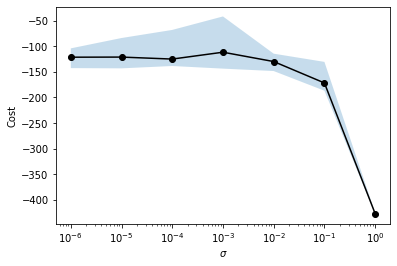

In [20]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(cost_end_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(cost_end_batch, 0.025, axis=0), 
                np.quantile(cost_end_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='Cost', xlabel=r'$\sigma$')
ax.semilogx() ;

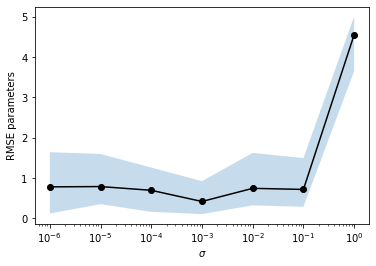

In [21]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(rmse_prms_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(rmse_prms_batch, 0.025, axis=0), 
                np.quantile(rmse_prms_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='RMSE parameters', xlabel=r'$\sigma$')
ax.semilogx() ;

## MAP

In [17]:
import cmdstanpy

In [ ]:
stan_models_dir = cwd + '/stan_models/'

In [18]:
model= 'uniform_vonly_sigest'
cmdModel = cmdstanpy.CmdStanModel(stan_file=stan_models_dir + model + '.stan')
cmdModel.compile()

#### Fixed dynamic noise = 0.1, to estimate:

In [19]:
%%time

sigma_noise = sigma_list[i_sig]
print('sigma=', sigma_noise)

data = data_input.copy()
X_obs = X_obs_list[i_sig]
data['rs'] = X_obs[1, :]
data['vs'] = X_obs[0, :]
data['ds'] = 1
params_true = prms + [sigma_noise]

fit = cmdModel.optimize(data=data, seed=0)

sigma= 0.1


12:25:22 - cmdstanpy - INFO - Chain [1] start processing
12:28:42 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.88 s, sys: 76.4 ms, total: 1.96 s
Wall time: 3min 21s


In [20]:
fit_vars = fit.stan_variables()

In [21]:
params_est = np.array([fit_vars['delta'], fit_vars['eta'], fit_vars['J'], fit_vars['sig']])
rmse_prms = RMSE(params_est, params_true)
rmse_prms

3.5809031044510715

In [22]:
X_est = np.vstack((fit_vars['v'], fit_vars['r']))
cost_final = np.sqrt(np.sum((X_est[0, :] - X_obs[0, :])**2))
cost_final

81.03987618839804

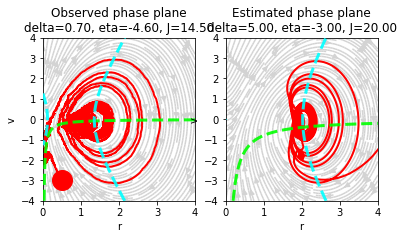

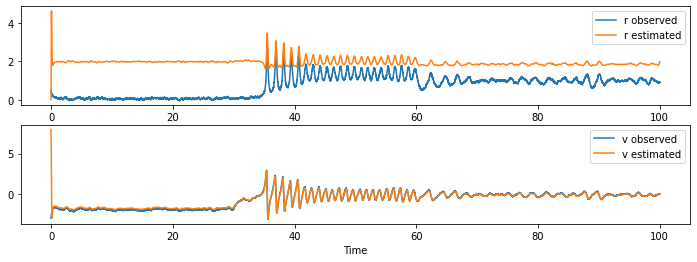

In [23]:
plot_phase_plane(params_true, params_est, X_obs, X_est)

New simulation with optimal parameters:

In [24]:
set_seed(0)
Sim_est = Montbrio_SDEmodel(params_est, inits, I_input, dt, ts)

In [25]:
v_sim_est = Sim_est[0]
r_sim_est = Sim_est[1]

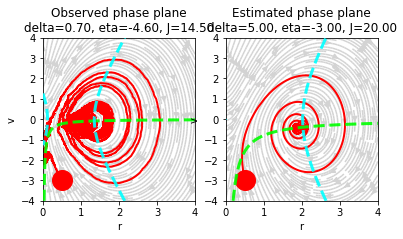

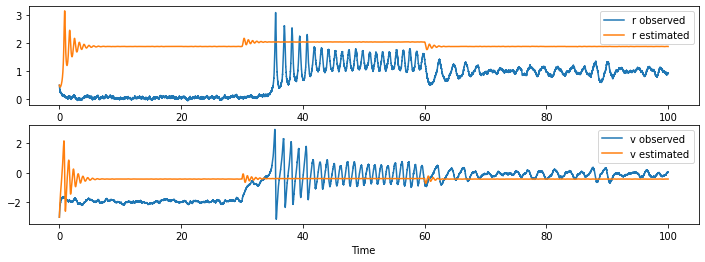

In [26]:
plot_phase_plane(params_true, params_est, X_obs, Sim_est)

In [27]:
res_dict = {'v_sim': list(v_sim_est), 'r_sim': list(r_sim_est), 
            'v_fit': list(fit_vars['v']), 'r_fit': list(fit_vars['r']), 
            'delta': fit_vars['delta'], 'eta': fit_vars['eta'], 'J': fit_vars['J'],
            'sigma': fit_vars['sig'], 
            'rmse_prms': rmse_prms, 'cost': cost_final}
json_object = json.dumps(res_dict, indent=4)
with open("results/v_only_map_sim_output.json", "w") as outfile:
    outfile.write(json_object)

In [25]:
with open("results/v_only_map_sim_output.json", "r") as readfile:
    sim = json.load(readfile)

In [26]:
sim['rmse_fit'] = RMSE(np.vstack([sim['v_fit'], sim['r_fit']]), X_obs)

json_object = json.dumps(sim, indent=4)
with open("results/v_only_map_sim_output.json", "w") as outfile:
    outfile.write(json_object)

### Influence of noise on optimization:

In [16]:
cost_end_batch = []
rmse_prms_batch = []

for batch in range(10) :
    print(batch)
    cost_end = []
    rmse_prms_list = []

    for i in range(len(sigma_list)) :

        sigma_noise = sigma_list[i]
        X_obs = X_obs_list[i]

        data = data_input.copy()
        data['rs'] = X_obs[1, :]
        data['vs'] = X_obs[0, :]
        params_true = prms + [sigma_noise]

        cmdModel = cmdstanpy.CmdStanModel(stan_file=cwd + '/model/' + model + '.stan')
        cmdModel.compile()
        fit = None
        while fit is None :
            try: 
                fit = cmdModel.optimize(data=data)
            except:
                continue
            
        fit_vars = fit.stan_variables()

        X_est = np.vstack((fit_vars['v'], fit_vars['r']))
        cost_end.append(np.sqrt(np.sum((X_est[0, :] - X_obs[0, :])**2)))
        rmse_prms_list.append(RMSE(np.array([fit_vars['delta'], fit_vars['eta'], fit_vars['J'],
                                            fit_vars['sig']]), params_true))
        
    cost_end_batch.append(cost_end)
    rmse_prms_batch.append(rmse_prms_list)

0


11:37:54 - cmdstanpy - INFO - Chain [1] start processing
11:40:10 - cmdstanpy - INFO - Chain [1] done processing
11:40:14 - cmdstanpy - INFO - Chain [1] start processing
11:42:29 - cmdstanpy - INFO - Chain [1] done processing
11:42:33 - cmdstanpy - INFO - Chain [1] start processing
11:44:55 - cmdstanpy - INFO - Chain [1] done processing
11:44:59 - cmdstanpy - INFO - Chain [1] start processing
11:47:24 - cmdstanpy - INFO - Chain [1] done processing
11:47:28 - cmdstanpy - INFO - Chain [1] start processing
11:49:58 - cmdstanpy - INFO - Chain [1] done processing
11:50:03 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing
11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:54:48 - cmdstanpy - INFO - Chain [1] done processing


1


11:54:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:25 - cmdstanpy - INFO - Chain [1] done processing
11:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing
12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:05:46 - cmdstanpy - INFO - Chain [1] done processing
12:05:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:10 - cmdstanpy - INFO - Chain [1] done processing
12:08:15 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing


2


12:10:48 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:25 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing
12:15:59 - cmdstanpy - INFO - Chain [1] start processing
12:18:22 - cmdstanpy - INFO - Chain [1] done processing
12:18:26 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing
12:20:49 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:05 - cmdstanpy - INFO - Chain [1] start processing
12:25:11 - cmdstanpy - INFO - Chain [1] done processing
12:25:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:22 - cmdstanpy - INFO - Chain [1] done processing


3


12:27:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:36 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing
12:31:45 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing
12:36:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:08 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing
12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:42:28 - cmdstanpy - INFO - Chain [1] done processing


4


12:42:32 - cmdstanpy - INFO - Chain [1] start processing
12:44:38 - cmdstanpy - INFO - Chain [1] done processing
12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:46:47 - cmdstanpy - INFO - Chain [1] done processing
12:46:51 - cmdstanpy - INFO - Chain [1] start processing
12:48:56 - cmdstanpy - INFO - Chain [1] done processing
12:49:00 - cmdstanpy - INFO - Chain [1] start processing
12:51:04 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:53:15 - cmdstanpy - INFO - Chain [1] done processing
12:53:19 - cmdstanpy - INFO - Chain [1] start processing
12:55:25 - cmdstanpy - INFO - Chain [1] done processing
12:55:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:35 - cmdstanpy - INFO - Chain [1] done processing


5


12:57:39 - cmdstanpy - INFO - Chain [1] start processing
12:59:44 - cmdstanpy - INFO - Chain [1] done processing
12:59:48 - cmdstanpy - INFO - Chain [1] start processing
13:01:53 - cmdstanpy - INFO - Chain [1] done processing
13:01:57 - cmdstanpy - INFO - Chain [1] start processing
13:04:02 - cmdstanpy - INFO - Chain [1] done processing
13:04:06 - cmdstanpy - INFO - Chain [1] start processing
13:06:10 - cmdstanpy - INFO - Chain [1] done processing
13:06:14 - cmdstanpy - INFO - Chain [1] start processing
13:08:19 - cmdstanpy - INFO - Chain [1] done processing
13:08:23 - cmdstanpy - INFO - Chain [1] start processing
13:10:28 - cmdstanpy - INFO - Chain [1] done processing
13:10:32 - cmdstanpy - INFO - Chain [1] start processing
13:12:38 - cmdstanpy - INFO - Chain [1] done processing


6


13:12:42 - cmdstanpy - INFO - Chain [1] start processing
13:14:47 - cmdstanpy - INFO - Chain [1] done processing
13:14:51 - cmdstanpy - INFO - Chain [1] start processing
13:16:58 - cmdstanpy - INFO - Chain [1] done processing
13:17:02 - cmdstanpy - INFO - Chain [1] start processing
13:19:07 - cmdstanpy - INFO - Chain [1] done processing
13:19:10 - cmdstanpy - INFO - Chain [1] start processing
13:21:15 - cmdstanpy - INFO - Chain [1] done processing
13:21:19 - cmdstanpy - INFO - Chain [1] start processing
13:23:26 - cmdstanpy - INFO - Chain [1] done processing
13:23:30 - cmdstanpy - INFO - Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:28:19 - cmdstanpy - INFO - Chain [1] done processing


7


13:28:23 - cmdstanpy - INFO - Chain [1] start processing
13:30:47 - cmdstanpy - INFO - Chain [1] done processing
13:30:51 - cmdstanpy - INFO - Chain [1] start processing
13:32:56 - cmdstanpy - INFO - Chain [1] done processing
13:33:00 - cmdstanpy - INFO - Chain [1] start processing
13:35:18 - cmdstanpy - INFO - Chain [1] done processing
13:35:22 - cmdstanpy - INFO - Chain [1] start processing
13:37:37 - cmdstanpy - INFO - Chain [1] done processing
13:37:41 - cmdstanpy - INFO - Chain [1] start processing
13:40:06 - cmdstanpy - INFO - Chain [1] done processing
13:40:10 - cmdstanpy - INFO - Chain [1] start processing
13:42:35 - cmdstanpy - INFO - Chain [1] done processing
13:42:39 - cmdstanpy - INFO - Chain [1] start processing
13:45:01 - cmdstanpy - INFO - Chain [1] done processing


8


13:45:06 - cmdstanpy - INFO - Chain [1] start processing
13:47:40 - cmdstanpy - INFO - Chain [1] done processing
13:47:44 - cmdstanpy - INFO - Chain [1] start processing
13:50:09 - cmdstanpy - INFO - Chain [1] done processing
13:50:13 - cmdstanpy - INFO - Chain [1] start processing
13:52:36 - cmdstanpy - INFO - Chain [1] done processing
13:52:40 - cmdstanpy - INFO - Chain [1] start processing
13:54:54 - cmdstanpy - INFO - Chain [1] done processing
13:54:58 - cmdstanpy - INFO - Chain [1] start processing
13:57:27 - cmdstanpy - INFO - Chain [1] done processing
13:57:31 - cmdstanpy - INFO - Chain [1] start processing
13:59:54 - cmdstanpy - INFO - Chain [1] done processing
13:59:58 - cmdstanpy - INFO - Chain [1] start processing
14:02:35 - cmdstanpy - INFO - Chain [1] done processing


9


14:02:39 - cmdstanpy - INFO - Chain [1] start processing
14:05:06 - cmdstanpy - INFO - Chain [1] done processing
14:05:10 - cmdstanpy - INFO - Chain [1] start processing
14:07:39 - cmdstanpy - INFO - Chain [1] done processing
14:07:44 - cmdstanpy - INFO - Chain [1] start processing
14:10:23 - cmdstanpy - INFO - Chain [1] done processing
14:10:28 - cmdstanpy - INFO - Chain [1] start processing
14:12:44 - cmdstanpy - INFO - Chain [1] done processing
14:12:48 - cmdstanpy - INFO - Chain [1] start processing
14:15:12 - cmdstanpy - INFO - Chain [1] done processing
14:15:16 - cmdstanpy - INFO - Chain [1] start processing
14:17:26 - cmdstanpy - INFO - Chain [1] done processing
14:17:30 - cmdstanpy - INFO - Chain [1] start processing
14:20:11 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
np.save("results/v_only_map_batch_cost_noise.npy", np.array(cost_end_batch))

In [18]:
np.save("results/v_only_map_batch_rmse_noise.npy", np.array(rmse_prms_batch))

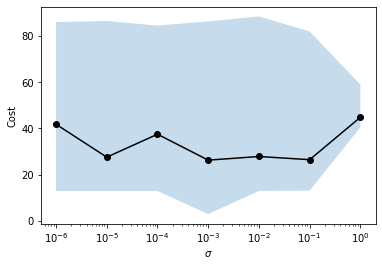

In [19]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(cost_end_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(cost_end_batch, 0.025, axis=0), 
                np.quantile(cost_end_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='Cost', xlabel=r'$\sigma$')
ax.semilogx() ;

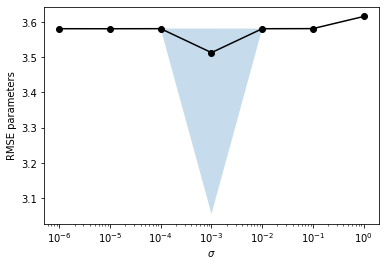

In [20]:
fig, ax = plt.subplots()
ax.plot(sigma_list, np.mean(rmse_prms_batch, axis=0), '-ok')
ax.fill_between(sigma_list, 
                np.quantile(rmse_prms_batch, 0.025, axis=0), 
                np.quantile(rmse_prms_batch, 0.975, axis=0),
                alpha=0.25)
ax.set(ylabel='RMSE parameters', xlabel=r'$\sigma$')
ax.semilogx() ;